In [1]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os
import torch.nn.functional as F
import numpy as np
import torch.utils.data as Data
from PIL import  Image,ImageDraw
import numpy as np
import random
import cv2
from torchvision import models
from torchsummary import summary

Batch_Size = 50
num_epochs = 200
learning_rate = 1e-5
samples = 20000

data1 = []
data2= []


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% --  Generate dataset
uframes = []
vidcap = cv2.VideoCapture('images_noisy_bullets.avi')
success,image = vidcap.read()
while success:
    uframes.append(image)   
    success,image = vidcap.read()

# cap = cv2.VideoCapture('video_drone_tank.avi')


# ret, frame = cap.read()

# uframes.append(frame)
# flag = 0
# z = 0
# while(z<30):
#     ret, frame = cap.read()
#     #np_frame = cv2.imread('video', frame) # does not work
#     #np_frame = np.asarray(cv2.GetMat(frame)) # does not work
#     #print(np_frame.shape)
#     for a in uframes:
#         if (np.array(a).any() != None):
#             print("a: ",np.shape(a))
#             print("frame: ",np.shape(a))
#             difference = cv2.subtract(np.array(a), np.array(frame))    
#             result = not np.any(difference)
#             #print("inside for")
#             if result is True:
#                 flag = 1
#                 #print("setting flag")
#                 break
#     if(not flag):
#         #print("appending")
#         uframes.append(frame)
#     z+=1

for i,frame in enumerate(uframes):
    uframes[i] = cv2.resize(frame,(100,100))
    
print(np.shape(uframes[0]))

print("length: ",len(uframes))
for i in range(samples):
    data1.append(np.array(np.transpose(np.asarray(uframes[i % len(uframes)]),(2,0,1)),dtype=np.float32))
    data2.append(np.array(np.transpose(np.asarray(uframes[(i+1) % len(uframes)]),(2,0,1)),dtype=np.float32))



#%%%%%%%%%%%%%%%%%%%%%%%%%%% Noisy data
img = Image.new('RGB', (100,100), color = '#9b7653')
# img.paste(im1,(5,75),im1)
# img.paste(im1,(10,55),im1)
# img.paste(im1,(25,50),im1)
# img.paste(im2,(75,5),im2)
# img.paste(im2,(60,30),im2)
# img.paste(im2,(90,20),im2)
# img.paste(im3,(75,60),im3)
# img.paste(im3,(60,80),im3)
im_n = np.reshape(img,(100,100,3))
b = np.asarray(im_n)
b = np.array(b, dtype=np.float32)
b = np.transpose(b,(2,0,1))
b = torch.from_numpy(b)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%       

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% - Data Preparation

y0 = np.asarray(data1)
y1 = np.asarray(data2)

#y0 = np.array(np.transpose(np.asarray(y0),(0,3,1,2)),dtype=np.float32)
#y1 = np.array(np.transpose(np.asarray(y1),(0,3,1,2)),dtype=np.float32)
print(np.shape(y0))

x = torch.from_numpy(y0)
y = torch.from_numpy(y1)


torch_dataset = Data.TensorDataset(x,y)


loader = Data.DataLoader(

    dataset=torch_dataset,

    batch_size=Batch_Size,

    shuffle=True,

    num_workers=0,

)


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% - Defining NN

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=10, stride=1)
        self.relu1 = nn.ReLU()

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=5)

#         # Convolution 2
#         self.cnn2 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=5, stride=1, padding=2)
#         self.relu2 = nn.ReLU()

#         # Max pool 2
#         self.maxpool2 = nn.MaxPool2d(kernel_size=5)

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(20736*2, 30)
        self.sigmoid1 = nn.Sigmoid()

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)

        # Max pool 1
        out = self.maxpool1(out)

        # Convolution 2 
        #out = self.cnn2(out)
        #out = self.relu2(out)

        # Max pool 2 
        #out = self.maxpool2(out)
        im_out = out
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        out = self.sigmoid1(out)
        return im_out,out
    
model = CNNModel()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% - Loss Function

def h_score(fx, gy):
 
    fx = fx - fx.mean(0)

    gy = gy - gy.mean(0)

    Nsamples = fx.size(0)
    #print(fx, np.shape(fx))
    #print(gy, np.shape(gy))
    #print(np.shape((torch.transpose(fx,3,2))),np.shape(fx))
    covf = torch.matmul(fx.t(), fx) / Nsamples

    covg = torch.matmul(gy.t(), gy) / Nsamples

    h = -2 * torch.mean((fx * gy).sum(1)) + (covf * covg).sum()

    return h


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)





for epoch in range(num_epochs):
    for x,y in loader:
        optimizer.zero_grad()
        # ===================forward=====================
        #loss = criterion(output1, img)
        loss = h_score(model(x)[1],model(y)[1])
        # ===================backward====================
 
        #optimizer_1.zero_grad()
        loss.backward()
        optimizer.step()
        #optimizer_1.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))
    #print("shape: ", np.shape(model(x[0].reshape(1,3,100, 100))[0]))
#     print("x: ", model(x[0].reshape(1,3,100, 100)))
#     print("y:", model(y[0].reshape(1,3,100, 100)))
#     print("b:", model(b.reshape(1,3,100, 100)))


(100, 100, 3)
length:  1549


KeyboardInterrupt: 

In [16]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

drone_moving_panels={}
tank_moving_panels={}
tank_reloading_panels={}
drone_reloading_panels={}
tank_firing_panels={}
drone_firing_panels={}

num_channels = 128
buffer = 5

blank_frame = 70
tank_moving = 30
tank_reloading = 35 
tank_firing = 40
drone_moving = 95
drone_reloading = 100 
drone_firing = 105
Tank_moving_Drone_moving = 0
Tank_reloading_Drone_moving = 110
Tank_firing_Drone_moving = 115
Tank_moving_Drone_reloading = 45
Tank_reloading_Drone_reloading = 10
Tank_firing_Drone_reloading = 120
Tank_moving_Drone_firing = 50
Tank_reloading_Drone_firing = 55
Tank_firing_Drone_firing = 15

def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position

def image_to_numpy(img):
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    return output


for i in range(num_channels):

    output = image_to_numpy(uframes[blank_frame])
    blank_panel = output[0][i]
    val_blank,pos_blank = val_pos(blank_panel)
    print("Blank: ",val_blank,pos_blank)
    print("**********")
    
    output = image_to_numpy(uframes[tank_moving])
    tank_moving_panel = output[0][i]
    val_tank_moving,pos_tank_moving = val_pos(tank_moving_panel)
    print("Tank Moving Panel: ",val_tank_moving,pos_tank_moving)
    print("**********")
    
    output = image_to_numpy(uframes[tank_reloading])
    tank_reloading_panel = output[0][i]
    val_tank_reloading,pos_tank_reloading = val_pos(tank_reloading_panel)
    print("Tank Reloading Panel: ",val_tank_reloading,pos_tank_reloading)
    print("**********")
    
    output = image_to_numpy(uframes[tank_firing])
    tank_firing_panel = output[0][i]
    val_tank_firing,pos_tank_firing = val_pos(tank_firing_panel)
    print("Tank firing Panel: ",val_tank_firing,pos_tank_firing)
    print("**********")
    
    output = image_to_numpy(uframes[drone_moving])
    drone_moving_panel = output[0][i]
    val_drone_moving,pos_drone_moving = val_pos(drone_moving_panel)
    print("Drone Moving Panel: ",val_drone_moving,pos_drone_moving)
    print("**********")
    
    output = image_to_numpy(uframes[drone_reloading])
    drone_reloading_panel = output[0][i]
    val_drone_reloading,pos_drone_reloading = val_pos(drone_reloading_panel)
    print("Drone Reloading Panel: ",val_drone_reloading,pos_drone_reloading)
    print("**********")
    
    output = image_to_numpy(uframes[drone_firing])
    drone_firing_panel = output[0][i]
    val_drone_firing,pos_drone_firing = val_pos(drone_firing_panel)
    print("Drone firing Panel: ",val_drone_firing,pos_drone_firing)
    print("**********")
    
    output = image_to_numpy(uframes[Tank_moving_Drone_moving])
    Tank_moving_Drone_moving_panel = output[0][i]
    val_Tank_moving_Drone_moving,pos_Tank_moving_Drone_moving = val_pos(Tank_moving_Drone_moving_panel)
    print("Tank_moving,Drone_moving Panel: ",val_Tank_moving_Drone_moving,pos_Tank_moving_Drone_moving)
    print("**********")
    
    output = image_to_numpy(uframes[Tank_reloading_Drone_moving])
    Tank_reloading_Drone_moving_panel = output[0][i]
    val_Tank_reloading_Drone_moving,pos_Tank_reloading_Drone_moving = val_pos(Tank_reloading_Drone_moving_panel)
    print("Tank_reloading_Drone_moving Panel: ",val_Tank_reloading_Drone_moving,pos_Tank_reloading_Drone_moving)
    print("**********")
    
    output = image_to_numpy(uframes[Tank_firing_Drone_moving])
    Tank_firing_Drone_moving_panel = output[0][i]
    val_Tank_firing_Drone_moving,pos_Tank_firing_Drone_moving = val_pos(Tank_firing_Drone_moving_panel)
    print("Tank_firing_Drone_moving Panel: ",val_Tank_firing_Drone_moving,pos_Tank_firing_Drone_moving)
    print("**********")
    
    output = image_to_numpy(uframes[Tank_moving_Drone_reloading])
    Tank_moving_Drone_reloading_panel = output[0][i]
    val_Tank_moving_Drone_reloading,pos_Tank_moving_Drone_reloading = val_pos(Tank_moving_Drone_reloading_panel)
    print("Tank_moving_Drone_reloading Panel: ",val_Tank_moving_Drone_reloading,pos_Tank_moving_Drone_reloading)
    print("**********")
    
    output = image_to_numpy(uframes[Tank_reloading_Drone_reloading])
    Tank_reloading_Drone_reloading_panel = output[0][i]
    val_Tank_reloading_Drone_reloading,pos_Tank_reloading_Drone_reloading = val_pos(Tank_reloading_Drone_reloading_panel)
    print("Tank_reloading_Drone_reloading Panel: ",val_Tank_reloading_Drone_reloading,pos_Tank_reloading_Drone_reloading)
    print("**********")
    
    output = image_to_numpy(uframes[Tank_firing_Drone_reloading])
    Tank_firing_Drone_reloading_panel = output[0][i]
    val_Tank_firing_Drone_reloading,pos_Tank_firing_Drone_reloading = val_pos(Tank_firing_Drone_reloading_panel)
    print("Tank_firing_Drone_reloading Panel: ",val_Tank_firing_Drone_reloading,pos_Tank_firing_Drone_reloading)
    print("**********")
    
    output = image_to_numpy(uframes[Tank_moving_Drone_firing])
    Tank_moving_Drone_firing_panel = output[0][i]
    val_Tank_moving_Drone_firing,pos_Tank_moving_Drone_firing = val_pos(Tank_moving_Drone_firing_panel)
    print("Tank_moving_Drone_firing Panel: ",val_Tank_moving_Drone_firing,pos_Tank_moving_Drone_firing)
    print("**********")
    
    output = image_to_numpy(uframes[Tank_reloading_Drone_firing])
    Tank_reloading_Drone_firing_panel = output[0][i]
    val_Tank_reloading_Drone_firing,pos_Tank_reloading_Drone_firing = val_pos(Tank_reloading_Drone_firing_panel)
    print("Tank_reloading_Drone_firing Panel: ",val_Tank_reloading_Drone_firing,pos_Tank_reloading_Drone_firing)
    print("**********")
    
    output = image_to_numpy(uframes[Tank_firing_Drone_firing])
    Tank_firing_Drone_firing_panel = output[0][i]
    val_Tank_firing_Drone_firing,pos_Tank_firing_Drone_firing = val_pos(Tank_firing_Drone_firing_panel)
    print("Tank_firing_Drone_firing Panel: ",val_Tank_firing_Drone_firing,pos_Tank_firing_Drone_firing)
    print("**********")

    
    
    print("\nPanel ",i)
    print("\n++++++++++++++++++++++++++++++++++++++++++++\n")
    
    if val_tank_moving > max(val_tank_reloading,val_tank_firing,val_drone_moving,val_drone_reloading,val_drone_firing):
        tank_moving_panels[i] = val_tank_moving - buffer
    
    elif val_drone_moving > max(val_tank_reloading,val_tank_firing,val_tank_moving,val_drone_reloading,val_drone_firing):
        drone_moving_panels[i] = val_drone_moving - buffer
    
    elif val_tank_reloading > max(val_tank_moving,val_tank_firing,val_drone_moving,val_drone_reloading,val_drone_firing):
        tank_reloading_panels[i] = val_tank_reloading - buffer
    
   
    elif val_tank_firing > max(val_tank_reloading,val_tank_moving,val_drone_moving,val_drone_reloading,val_drone_firing):
        tank_firing_panels[i] = val_tank_firing - buffer
    
    elif val_drone_firing > max(val_tank_reloading,val_tank_firing,val_tank_moving,val_drone_reloading,val_drone_moving):
        drone_firing_panels[i] = val_drone_firing - buffer
    
    elif val_drone_reloading > max(val_tank_reloading,val_tank_firing,val_tank_moving,val_drone_moving,val_drone_firing):
        drone_reloading_panels[i] = val_drone_reloading - buffer
    
print("\nTank Moving: \n", tank_moving_panels)
print("\nDrone Moving: \n", drone_moving_panels)
print("\nTank Reloading: \n", tank_reloading_panels)
print("\nDrone Reloading: \n", drone_reloading_panels)
print("\nTank Firing: \n", tank_firing_panels)
print("\nDrone Firing: \n", drone_firing_panels)


Blank:  19.645706 (10, 12)
**********
Tank Moving Panel:  78.884766 (5, 5)
**********
Tank Reloading Panel:  229.56319 (5, 7)
**********
Tank firing Panel:  127.8861 (5, 6)
**********
Drone Moving Panel:  235.90582 (12, 10)
**********
Drone Reloading Panel:  104.1252 (12, 15)
**********
Drone firing Panel:  159.7772 (9, 15)
**********
Tank_moving,Drone_moving Panel:  313.00037 (13, 3)
**********
Tank_reloading_Drone_moving Panel:  411.4137 (5, 15)
**********
Tank_firing_Drone_moving Panel:  367.63928 (9, 4)
**********
Tank_moving_Drone_reloading Panel:  177.3497 (10, 1)
**********
Tank_reloading_Drone_reloading Panel:  246.14172 (5, 3)
**********
Tank_firing_Drone_reloading Panel:  234.25912 (5, 14)
**********
Tank_moving_Drone_firing Panel:  203.53435 (12, 3)
**********
Tank_reloading_Drone_firing Panel:  338.42877 (5, 10)
**********
Tank_firing_Drone_firing Panel:  264.49832 (10, 16)
**********

Panel  0

++++++++++++++++++++++++++++++++++++++++++++

Blank:  448.4747 (16, 14)
*******

Drone Moving Panel:  151.59512 (11, 10)
**********
Drone Reloading Panel:  295.17532 (13, 16)
**********
Drone firing Panel:  219.05826 (10, 15)
**********
Tank_moving,Drone_moving Panel:  399.9607 (6, 2)
**********
Tank_reloading_Drone_moving Panel:  225.4679 (10, 7)
**********
Tank_firing_Drone_moving Panel:  245.81049 (9, 4)
**********
Tank_moving_Drone_reloading Panel:  608.778 (11, 1)
**********
Tank_reloading_Drone_reloading Panel:  455.0619 (13, 14)
**********
Tank_firing_Drone_reloading Panel:  432.2556 (11, 3)
**********
Tank_moving_Drone_firing Panel:  426.51672 (7, 8)
**********
Tank_reloading_Drone_firing Panel:  290.0063 (5, 7)
**********
Tank_firing_Drone_firing Panel:  265.5315 (10, 15)
**********

Panel  9

++++++++++++++++++++++++++++++++++++++++++++

Blank:  49.662388 (16, 13)
**********
Tank Moving Panel:  196.45934 (6, 4)
**********
Tank Reloading Panel:  209.58646 (5, 4)
**********
Tank firing Panel:  304.5231 (6, 5)
**********
Drone Moving Panel:  287.5749 (13, 8)

Tank_reloading_Drone_firing Panel:  575.7556 (13, 9)
**********
Tank_firing_Drone_firing Panel:  430.56995 (11, 15)
**********

Panel  18

++++++++++++++++++++++++++++++++++++++++++++

Blank:  130.05415 (10, 13)
**********
Tank Moving Panel:  224.5155 (10, 13)
**********
Tank Reloading Panel:  510.68265 (6, 6)
**********
Tank firing Panel:  318.30972 (10, 13)
**********
Drone Moving Panel:  491.5658 (12, 11)
**********
Drone Reloading Panel:  445.97842 (12, 17)
**********
Drone firing Panel:  529.1486 (10, 15)
**********
Tank_moving,Drone_moving Panel:  618.72955 (12, 3)
**********
Tank_reloading_Drone_moving Panel:  829.0377 (10, 8)
**********
Tank_firing_Drone_moving Panel:  680.7953 (10, 3)
**********
Tank_moving_Drone_reloading Panel:  577.12744 (10, 2)
**********
Tank_reloading_Drone_reloading Panel:  761.8065 (12, 14)
**********
Tank_firing_Drone_reloading Panel:  558.7188 (11, 3)
**********
Tank_moving_Drone_firing Panel:  594.4875 (12, 4)
**********
Tank_reloading_Drone_firing 

Drone firing Panel:  263.8009 (9, 16)
**********
Tank_moving,Drone_moving Panel:  377.78552 (13, 3)
**********
Tank_reloading_Drone_moving Panel:  452.8985 (11, 9)
**********
Tank_firing_Drone_moving Panel:  487.69122 (11, 4)
**********
Tank_moving_Drone_reloading Panel:  354.90912 (10, 1)
**********
Tank_reloading_Drone_reloading Panel:  402.6678 (12, 13)
**********
Tank_firing_Drone_reloading Panel:  349.922 (11, 2)
**********
Tank_moving_Drone_firing Panel:  413.50696 (12, 3)
**********
Tank_reloading_Drone_firing Panel:  401.50266 (12, 8)
**********
Tank_firing_Drone_firing Panel:  352.04437 (10, 15)
**********

Panel  27

++++++++++++++++++++++++++++++++++++++++++++

Blank:  137.70795 (11, 3)
**********
Tank Moving Panel:  528.74005 (6, 4)
**********
Tank Reloading Panel:  231.77936 (11, 3)
**********
Tank firing Panel:  364.8957 (6, 5)
**********
Drone Moving Panel:  317.4601 (14, 9)
**********
Drone Reloading Panel:  622.37396 (13, 16)
**********
Drone firing Panel:  368.25507 (

Tank_moving,Drone_moving Panel:  292.44836 (5, 0)
**********
Tank_reloading_Drone_moving Panel:  261.39133 (5, 13)
**********
Tank_firing_Drone_moving Panel:  423.3342 (5, 14)
**********
Tank_moving_Drone_reloading Panel:  313.48868 (5, 7)
**********
Tank_reloading_Drone_reloading Panel:  281.70117 (5, 2)
**********
Tank_firing_Drone_reloading Panel:  523.5414 (5, 14)
**********
Tank_moving_Drone_firing Panel:  374.57568 (5, 7)
**********
Tank_reloading_Drone_firing Panel:  277.29193 (5, 8)
**********
Tank_firing_Drone_firing Panel:  510.16867 (5, 3)
**********

Panel  36

++++++++++++++++++++++++++++++++++++++++++++

Blank:  65.51818 (10, 3)
**********
Tank Moving Panel:  364.29688 (5, 5)
**********
Tank Reloading Panel:  264.72504 (6, 6)
**********
Tank firing Panel:  273.2078 (5, 6)
**********
Drone Moving Panel:  263.02386 (13, 11)
**********
Drone Reloading Panel:  286.6701 (12, 15)
**********
Drone firing Panel:  297.24866 (9, 15)
**********
Tank_moving,Drone_moving Panel:  547.6

Tank Moving Panel:  171.94662 (6, 5)
**********
Tank Reloading Panel:  55.090958 (10, 14)
**********
Tank firing Panel:  101.0625 (6, 9)
**********
Drone Moving Panel:  153.79814 (13, 10)
**********
Drone Reloading Panel:  510.74313 (13, 16)
**********
Drone firing Panel:  272.41367 (9, 13)
**********
Tank_moving,Drone_moving Panel:  303.78748 (13, 3)
**********
Tank_reloading_Drone_moving Panel:  133.09758 (9, 8)
**********
Tank_firing_Drone_moving Panel:  180.56647 (10, 2)
**********
Tank_moving_Drone_reloading Panel:  556.77576 (11, 1)
**********
Tank_reloading_Drone_reloading Panel:  659.0504 (13, 14)
**********
Tank_firing_Drone_reloading Panel:  454.10507 (13, 2)
**********
Tank_moving_Drone_firing Panel:  411.58167 (12, 2)
**********
Tank_reloading_Drone_firing Panel:  309.56558 (12, 8)
**********
Tank_firing_Drone_firing Panel:  253.53566 (9, 15)
**********

Panel  46

++++++++++++++++++++++++++++++++++++++++++++

Blank:  1.884073 (10, 12)
**********
Tank Moving Panel:  146.562

Tank_reloading_Drone_reloading Panel:  377.7938 (13, 13)
**********
Tank_firing_Drone_reloading Panel:  515.42957 (12, 3)
**********
Tank_moving_Drone_firing Panel:  369.02505 (6, 10)
**********
Tank_reloading_Drone_firing Panel:  70.299805 (13, 9)
**********
Tank_firing_Drone_firing Panel:  33.68778 (10, 15)
**********

Panel  55

++++++++++++++++++++++++++++++++++++++++++++

Blank:  7.4757776 (8, 8)
**********
Tank Moving Panel:  247.86758 (6, 3)
**********
Tank Reloading Panel:  206.94406 (5, 7)
**********
Tank firing Panel:  107.6768 (6, 5)
**********
Drone Moving Panel:  244.71759 (12, 11)
**********
Drone Reloading Panel:  371.11368 (13, 17)
**********
Drone firing Panel:  190.12723 (9, 14)
**********
Tank_moving,Drone_moving Panel:  357.26465 (12, 3)
**********
Tank_reloading_Drone_moving Panel:  486.85464 (9, 9)
**********
Tank_firing_Drone_moving Panel:  300.41296 (9, 4)
**********
Tank_moving_Drone_reloading Panel:  576.9048 (10, 2)
**********
Tank_reloading_Drone_reloading P

Tank Reloading Panel:  79.08583 (6, 7)
**********
Tank firing Panel:  165.80795 (6, 7)
**********
Drone Moving Panel:  148.5307 (13, 12)
**********
Drone Reloading Panel:  204.43301 (12, 17)
**********
Drone firing Panel:  208.13403 (9, 13)
**********
Tank_moving,Drone_moving Panel:  261.24512 (5, 1)
**********
Tank_reloading_Drone_moving Panel:  242.20743 (10, 10)
**********
Tank_firing_Drone_moving Panel:  288.76917 (6, 15)
**********
Tank_moving_Drone_reloading Panel:  227.46266 (5, 8)
**********
Tank_reloading_Drone_reloading Panel:  376.32483 (12, 14)
**********
Tank_firing_Drone_reloading Panel:  322.2104 (11, 2)
**********
Tank_moving_Drone_firing Panel:  345.85028 (5, 8)
**********
Tank_reloading_Drone_firing Panel:  233.58057 (6, 9)
**********
Tank_firing_Drone_firing Panel:  270.97055 (10, 15)
**********

Panel  65

++++++++++++++++++++++++++++++++++++++++++++

Blank:  3.5991776 (15, 14)
**********
Tank Moving Panel:  67.058395 (6, 5)
**********
Tank Reloading Panel:  134.032

Tank_moving_Drone_reloading Panel:  657.0691 (11, 2)
**********
Tank_reloading_Drone_reloading Panel:  596.4114 (13, 14)
**********
Tank_firing_Drone_reloading Panel:  521.2469 (6, 14)
**********
Tank_moving_Drone_firing Panel:  594.6105 (6, 8)
**********
Tank_reloading_Drone_firing Panel:  489.26147 (7, 8)
**********
Tank_firing_Drone_firing Panel:  498.28726 (6, 2)
**********

Panel  74

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
**********
Tank Moving Panel:  0.0 (0, 0)
**********
Tank Reloading Panel:  98.15489 (6, 8)
**********
Tank firing Panel:  69.44601 (6, 9)
**********
Drone Moving Panel:  156.75099 (12, 11)
**********
Drone Reloading Panel:  10.895536 (13, 15)
**********
Drone firing Panel:  25.083088 (9, 15)
**********
Tank_moving,Drone_moving Panel:  201.57477 (12, 3)
**********
Tank_reloading_Drone_moving Panel:  237.56415 (9, 9)
**********
Tank_firing_Drone_moving Panel:  153.82349 (9, 4)
**********
Tank_moving_Drone_reloading Panel:  36.255936 (6, 

Tank Moving Panel:  448.7622 (5, 5)
**********
Tank Reloading Panel:  293.86255 (7, 9)
**********
Tank firing Panel:  428.39676 (5, 9)
**********
Drone Moving Panel:  259.0067 (7, 10)
**********
Drone Reloading Panel:  522.08716 (13, 16)
**********
Drone firing Panel:  436.5015 (9, 14)
**********
Tank_moving,Drone_moving Panel:  582.3937 (5, 1)
**********
Tank_reloading_Drone_moving Panel:  448.0772 (11, 10)
**********
Tank_firing_Drone_moving Panel:  518.5851 (5, 15)
**********
Tank_moving_Drone_reloading Panel:  871.7041 (11, 1)
**********
Tank_reloading_Drone_reloading Panel:  733.83844 (13, 14)
**********
Tank_firing_Drone_reloading Panel:  845.9064 (12, 2)
**********
Tank_moving_Drone_firing Panel:  712.9098 (5, 10)
**********
Tank_reloading_Drone_firing Panel:  549.7865 (13, 10)
**********
Tank_firing_Drone_firing Panel:  647.9484 (5, 4)
**********

Panel  84

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
**********
Tank Moving Panel:  186.69456 (5, 4)
********

Drone Reloading Panel:  246.56435 (13, 15)
**********
Drone firing Panel:  217.35936 (10, 15)
**********
Tank_moving,Drone_moving Panel:  339.51227 (6, 1)
**********
Tank_reloading_Drone_moving Panel:  410.55185 (10, 8)
**********
Tank_firing_Drone_moving Panel:  400.24704 (10, 3)
**********
Tank_moving_Drone_reloading Panel:  421.82953 (6, 7)
**********
Tank_reloading_Drone_reloading Panel:  429.73474 (12, 13)
**********
Tank_firing_Drone_reloading Panel:  333.40378 (6, 17)
**********
Tank_moving_Drone_firing Panel:  462.86713 (12, 3)
**********
Tank_reloading_Drone_firing Panel:  403.33453 (13, 9)
**********
Tank_firing_Drone_firing Panel:  373.9364 (6, 3)
**********

Panel  93

++++++++++++++++++++++++++++++++++++++++++++

Blank:  11.649551 (7, 10)
**********
Tank Moving Panel:  253.56213 (6, 5)
**********
Tank Reloading Panel:  75.86561 (5, 6)
**********
Tank firing Panel:  83.33351 (6, 7)
**********
Drone Moving Panel:  141.61179 (12, 10)
**********
Drone Reloading Panel:  328.704

Tank_reloading_Drone_reloading Panel:  224.49152 (6, 1)
**********
Tank_firing_Drone_reloading Panel:  314.02734 (6, 14)
**********
Tank_moving_Drone_firing Panel:  376.60052 (5, 7)
**********
Tank_reloading_Drone_firing Panel:  263.60532 (6, 7)
**********
Tank_firing_Drone_firing Panel:  321.27255 (6, 2)
**********

Panel  102

++++++++++++++++++++++++++++++++++++++++++++

Blank:  45.000496 (17, 15)
**********
Tank Moving Panel:  148.20692 (6, 6)
**********
Tank Reloading Panel:  87.08547 (17, 15)
**********
Tank firing Panel:  202.81064 (6, 7)
**********
Drone Moving Panel:  113.587494 (13, 10)
**********
Drone Reloading Panel:  177.52351 (13, 14)
**********
Drone firing Panel:  288.21848 (11, 14)
**********
Tank_moving,Drone_moving Panel:  211.01367 (6, 2)
**********
Tank_reloading_Drone_moving Panel:  265.0083 (8, 9)
**********
Tank_firing_Drone_moving Panel:  336.3653 (10, 3)
**********
Tank_moving_Drone_reloading Panel:  263.50034 (12, 2)
**********
Tank_reloading_Drone_reloading

Tank firing Panel:  766.0088 (6, 6)
**********
Drone Moving Panel:  845.68396 (12, 9)
**********
Drone Reloading Panel:  758.9746 (14, 15)
**********
Drone firing Panel:  836.5495 (10, 14)
**********
Tank_moving,Drone_moving Panel:  1030.9016 (13, 3)
**********
Tank_reloading_Drone_moving Panel:  1321.777 (6, 13)
**********
Tank_firing_Drone_moving Panel:  1290.5105 (6, 14)
**********
Tank_moving_Drone_reloading Panel:  921.5971 (12, 1)
**********
Tank_reloading_Drone_reloading Panel:  1238.8479 (6, 2)
**********
Tank_firing_Drone_reloading Panel:  1017.72925 (6, 15)
**********
Tank_moving_Drone_firing Panel:  1110.5015 (13, 4)
**********
Tank_reloading_Drone_firing Panel:  1348.6719 (6, 8)
**********
Tank_firing_Drone_firing Panel:  1399.8892 (6, 3)
**********

Panel  112

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
**********
Tank Moving Panel:  240.15034 (6, 6)
**********
Tank Reloading Panel:  87.437584 (5, 8)
**********
Tank firing Panel:  97.842545 (5, 7)
***

Tank_reloading_Drone_firing Panel:  509.0016 (7, 9)
**********
Tank_firing_Drone_firing Panel:  170.71231 (10, 12)
**********

Panel  120

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
**********
Tank Moving Panel:  269.76404 (5, 6)
**********
Tank Reloading Panel:  40.579002 (6, 7)
**********
Tank firing Panel:  21.160332 (6, 7)
**********
Drone Moving Panel:  53.9493 (13, 10)
**********
Drone Reloading Panel:  381.57983 (12, 17)
**********
Drone firing Panel:  43.1584 (10, 13)
**********
Tank_moving,Drone_moving Panel:  353.97473 (5, 2)
**********
Tank_reloading_Drone_moving Panel:  76.42317 (6, 14)
**********
Tank_firing_Drone_moving Panel:  54.04 (11, 2)
**********
Tank_moving_Drone_reloading Panel:  685.1189 (10, 2)
**********
Tank_reloading_Drone_reloading Panel:  437.69528 (12, 13)
**********
Tank_firing_Drone_reloading Panel:  343.00345 (12, 2)
**********
Tank_moving_Drone_firing Panel:  369.77994 (6, 8)
**********
Tank_reloading_Drone_firing Panel:  92.5557 

In [18]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

drone_moving_panels={}
tank_moving_panels={}
tank_reloading_panels={}
drone_reloading_panels={}
tank_firing_panels={}
drone_firing_panels={}

num_channels = 128
buffer = 5

blank_frame = 70
tank_moving = 30
tank_reloading = [10,11,12,13,14,35,36,37,38,39,55,56,57,58,59,75,76,77,78,79,110,111,112,113,114]
tank_firing = 40
drone_moving = 95
drone_reloading = 100 
drone_firing = 105
Tank_moving_Drone_moving = 0
Tank_reloading_Drone_moving = 110
Tank_firing_Drone_moving = 115
Tank_moving_Drone_reloading = 45
Tank_reloading_Drone_reloading = 10
Tank_firing_Drone_reloading = 120
Tank_moving_Drone_firing = 50
Tank_reloading_Drone_firing = 55
Tank_firing_Drone_firing = 15

def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position

def image_to_numpy(img):
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    return output


for i in range(num_channels):
    for j in tank_reloading:
        output = image_to_numpy(uframes[blank_frame])
        blank_panel = output[0][i]
        val_blank,pos_blank = val_pos(blank_panel)
        print("Blank: ",val_blank,pos_blank)
    #     print("**********")

        output = image_to_numpy(uframes[tank_moving])
        tank_moving_panel = output[0][i]
        val_tank_moving,pos_tank_moving = val_pos(tank_moving_panel)
        print("Tank Moving Panel: ",val_tank_moving,pos_tank_moving)
    #     print("**********")

        output = image_to_numpy(uframes[j])
        tank_reloading_panel = output[0][i]
        val_tank_reloading,pos_tank_reloading = val_pos(tank_reloading_panel)
        print("Tank Reloading Panel: ",val_tank_reloading,pos_tank_reloading)
    #     print("**********")

        output = image_to_numpy(uframes[tank_firing])
        tank_firing_panel = output[0][i]
        val_tank_firing,pos_tank_firing = val_pos(tank_firing_panel)
        print("Tank firing Panel: ",val_tank_firing,pos_tank_firing)
    #     print("**********")

        output = image_to_numpy(uframes[drone_moving])
        drone_moving_panel = output[0][i]
        val_drone_moving,pos_drone_moving = val_pos(drone_moving_panel)
        print("Drone Moving Panel: ",val_drone_moving,pos_drone_moving)
    #     print("**********")

        output = image_to_numpy(uframes[drone_reloading])
        drone_reloading_panel = output[0][i]
        val_drone_reloading,pos_drone_reloading = val_pos(drone_reloading_panel)
        print("Drone Reloading Panel: ",val_drone_reloading,pos_drone_reloading)
    #     print("**********")

        output = image_to_numpy(uframes[drone_firing])
        drone_firing_panel = output[0][i]
        val_drone_firing,pos_drone_firing = val_pos(drone_firing_panel)
        print("Drone firing Panel: ",val_drone_firing,pos_drone_firing)
    #     print("**********")

        output = image_to_numpy(uframes[Tank_moving_Drone_moving])
        Tank_moving_Drone_moving_panel = output[0][i]
        val_Tank_moving_Drone_moving,pos_Tank_moving_Drone_moving = val_pos(Tank_moving_Drone_moving_panel)
        print("Tank_moving,Drone_moving Panel: ",val_Tank_moving_Drone_moving,pos_Tank_moving_Drone_moving)
    #     print("**********")

        output = image_to_numpy(uframes[Tank_reloading_Drone_moving])
        Tank_reloading_Drone_moving_panel = output[0][i]
        val_Tank_reloading_Drone_moving,pos_Tank_reloading_Drone_moving = val_pos(Tank_reloading_Drone_moving_panel)
        print("Tank_reloading_Drone_moving Panel: ",val_Tank_reloading_Drone_moving,pos_Tank_reloading_Drone_moving)
    #     print("**********")

        output = image_to_numpy(uframes[Tank_firing_Drone_moving])
        Tank_firing_Drone_moving_panel = output[0][i]
        val_Tank_firing_Drone_moving,pos_Tank_firing_Drone_moving = val_pos(Tank_firing_Drone_moving_panel)
        print("Tank_firing_Drone_moving Panel: ",val_Tank_firing_Drone_moving,pos_Tank_firing_Drone_moving)
    #     print("**********")

        output = image_to_numpy(uframes[Tank_moving_Drone_reloading])
        Tank_moving_Drone_reloading_panel = output[0][i]
        val_Tank_moving_Drone_reloading,pos_Tank_moving_Drone_reloading = val_pos(Tank_moving_Drone_reloading_panel)
        print("Tank_moving_Drone_reloading Panel: ",val_Tank_moving_Drone_reloading,pos_Tank_moving_Drone_reloading)
    #     print("**********")

        output = image_to_numpy(uframes[Tank_reloading_Drone_reloading])
        Tank_reloading_Drone_reloading_panel = output[0][i]
        val_Tank_reloading_Drone_reloading,pos_Tank_reloading_Drone_reloading = val_pos(Tank_reloading_Drone_reloading_panel)
        print("Tank_reloading_Drone_reloading Panel: ",val_Tank_reloading_Drone_reloading,pos_Tank_reloading_Drone_reloading)
    #     print("**********")

        output = image_to_numpy(uframes[Tank_firing_Drone_reloading])
        Tank_firing_Drone_reloading_panel = output[0][i]
        val_Tank_firing_Drone_reloading,pos_Tank_firing_Drone_reloading = val_pos(Tank_firing_Drone_reloading_panel)
        print("Tank_firing_Drone_reloading Panel: ",val_Tank_firing_Drone_reloading,pos_Tank_firing_Drone_reloading)
    #     print("**********")

        output = image_to_numpy(uframes[Tank_moving_Drone_firing])
        Tank_moving_Drone_firing_panel = output[0][i]
        val_Tank_moving_Drone_firing,pos_Tank_moving_Drone_firing = val_pos(Tank_moving_Drone_firing_panel)
        print("Tank_moving_Drone_firing Panel: ",val_Tank_moving_Drone_firing,pos_Tank_moving_Drone_firing)
    #     print("**********")

        output = image_to_numpy(uframes[Tank_reloading_Drone_firing])
        Tank_reloading_Drone_firing_panel = output[0][i]
        val_Tank_reloading_Drone_firing,pos_Tank_reloading_Drone_firing = val_pos(Tank_reloading_Drone_firing_panel)
        print("Tank_reloading_Drone_firing Panel: ",val_Tank_reloading_Drone_firing,pos_Tank_reloading_Drone_firing)
    #     print("**********")

        output = image_to_numpy(uframes[Tank_firing_Drone_firing])
        Tank_firing_Drone_firing_panel = output[0][i]
        val_Tank_firing_Drone_firing,pos_Tank_firing_Drone_firing = val_pos(Tank_firing_Drone_firing_panel)
        print("Tank_firing_Drone_firing Panel: ",val_Tank_firing_Drone_firing,pos_Tank_firing_Drone_firing)
    #     print("**********")



        print("\nPanel ",i)
        print("\n++++++++++++++++++++++++++++++++++++++++++++\n")

        if val_tank_moving > max(val_tank_reloading,val_tank_firing,val_drone_moving,val_drone_reloading,val_drone_firing):
            tank_moving_panels[i] = val_tank_moving - buffer

        elif val_drone_moving > max(val_tank_reloading,val_tank_firing,val_tank_moving,val_drone_reloading,val_drone_firing):
            drone_moving_panels[i] = val_drone_moving - buffer

        elif val_tank_reloading > max(val_tank_moving,val_tank_firing,val_drone_moving,val_drone_reloading,val_drone_firing):
            tank_reloading_panels[i] = val_tank_reloading - buffer


        elif val_tank_firing > max(val_tank_reloading,val_tank_moving,val_drone_moving,val_drone_reloading,val_drone_firing):
            tank_firing_panels[i] = val_tank_firing - buffer

        elif val_drone_firing > max(val_tank_reloading,val_tank_firing,val_tank_moving,val_drone_reloading,val_drone_moving):
            drone_firing_panels[i] = val_drone_firing - buffer

        elif val_drone_reloading > max(val_tank_reloading,val_tank_firing,val_tank_moving,val_drone_moving,val_drone_firing):
            drone_reloading_panels[i] = val_drone_reloading - buffer
    
print("\nTank Moving: \n", tank_moving_panels)
print("\nDrone Moving: \n", drone_moving_panels)
print("\nTank Reloading: \n", tank_reloading_panels)
print("\nDrone Reloading: \n", drone_reloading_panels)
print("\nTank Firing: \n", tank_firing_panels)
print("\nDrone Firing: \n", drone_firing_panels)


Blank:  19.645706 (10, 12)
Tank Moving Panel:  78.884766 (5, 5)
Tank Reloading Panel:  246.14172 (5, 3)
Tank firing Panel:  127.8861 (5, 6)
Drone Moving Panel:  235.90582 (12, 10)
Drone Reloading Panel:  104.1252 (12, 15)
Drone firing Panel:  159.7772 (9, 15)
Tank_moving,Drone_moving Panel:  313.00037 (13, 3)
Tank_reloading_Drone_moving Panel:  411.4137 (5, 15)
Tank_firing_Drone_moving Panel:  367.63928 (9, 4)
Tank_moving_Drone_reloading Panel:  177.3497 (10, 1)
Tank_reloading_Drone_reloading Panel:  246.14172 (5, 3)
Tank_firing_Drone_reloading Panel:  234.25912 (5, 14)
Tank_moving_Drone_firing Panel:  203.53435 (12, 3)
Tank_reloading_Drone_firing Panel:  338.42877 (5, 10)
Tank_firing_Drone_firing Panel:  264.49832 (10, 16)

Panel  0

++++++++++++++++++++++++++++++++++++++++++++

Blank:  19.645706 (10, 12)
Tank Moving Panel:  78.884766 (5, 5)
Tank Reloading Panel:  283.73633 (5, 4)
Tank firing Panel:  127.8861 (5, 6)
Drone Moving Panel:  235.90582 (12, 10)
Drone Reloading Panel:  104.1

Tank firing Panel:  127.8861 (5, 6)
Drone Moving Panel:  235.90582 (12, 10)
Drone Reloading Panel:  104.1252 (12, 15)
Drone firing Panel:  159.7772 (9, 15)
Tank_moving,Drone_moving Panel:  313.00037 (13, 3)
Tank_reloading_Drone_moving Panel:  411.4137 (5, 15)
Tank_firing_Drone_moving Panel:  367.63928 (9, 4)
Tank_moving_Drone_reloading Panel:  177.3497 (10, 1)
Tank_reloading_Drone_reloading Panel:  246.14172 (5, 3)
Tank_firing_Drone_reloading Panel:  234.25912 (5, 14)
Tank_moving_Drone_firing Panel:  203.53435 (12, 3)
Tank_reloading_Drone_firing Panel:  338.42877 (5, 10)
Tank_firing_Drone_firing Panel:  264.49832 (10, 16)

Panel  0

++++++++++++++++++++++++++++++++++++++++++++

Blank:  19.645706 (10, 12)
Tank Moving Panel:  78.884766 (5, 5)
Tank Reloading Panel:  400.72852 (5, 10)
Tank firing Panel:  127.8861 (5, 6)
Drone Moving Panel:  235.90582 (12, 10)
Drone Reloading Panel:  104.1252 (12, 15)
Drone firing Panel:  159.7772 (9, 15)
Tank_moving,Drone_moving Panel:  313.00037 (13, 3)
T

Tank_moving_Drone_firing Panel:  203.53435 (12, 3)
Tank_reloading_Drone_firing Panel:  338.42877 (5, 10)
Tank_firing_Drone_firing Panel:  264.49832 (10, 16)

Panel  0

++++++++++++++++++++++++++++++++++++++++++++

Blank:  19.645706 (10, 12)
Tank Moving Panel:  78.884766 (5, 5)
Tank Reloading Panel:  409.2286 (9, 7)
Tank firing Panel:  127.8861 (5, 6)
Drone Moving Panel:  235.90582 (12, 10)
Drone Reloading Panel:  104.1252 (12, 15)
Drone firing Panel:  159.7772 (9, 15)
Tank_moving,Drone_moving Panel:  313.00037 (13, 3)
Tank_reloading_Drone_moving Panel:  411.4137 (5, 15)
Tank_firing_Drone_moving Panel:  367.63928 (9, 4)
Tank_moving_Drone_reloading Panel:  177.3497 (10, 1)
Tank_reloading_Drone_reloading Panel:  246.14172 (5, 3)
Tank_firing_Drone_reloading Panel:  234.25912 (5, 14)
Tank_moving_Drone_firing Panel:  203.53435 (12, 3)
Tank_reloading_Drone_firing Panel:  338.42877 (5, 10)
Tank_firing_Drone_firing Panel:  264.49832 (10, 16)

Panel  0

++++++++++++++++++++++++++++++++++++++++++

Tank_reloading_Drone_firing Panel:  1199.4778 (12, 8)
Tank_firing_Drone_firing Panel:  1194.1766 (6, 3)

Panel  1

++++++++++++++++++++++++++++++++++++++++++++

Blank:  448.4747 (16, 14)
Tank Moving Panel:  619.1254 (6, 5)
Tank Reloading Panel:  852.5959 (5, 7)
Tank firing Panel:  867.2221 (6, 6)
Drone Moving Panel:  882.5526 (13, 11)
Drone Reloading Panel:  659.81323 (16, 14)
Drone firing Panel:  842.6794 (10, 15)
Tank_moving,Drone_moving Panel:  1055.2611 (13, 3)
Tank_reloading_Drone_moving Panel:  1171.6359 (10, 10)
Tank_firing_Drone_moving Panel:  1177.6644 (10, 5)
Tank_moving_Drone_reloading Panel:  781.10144 (6, 7)
Tank_reloading_Drone_reloading Panel:  1017.7992 (16, 14)
Tank_firing_Drone_reloading Panel:  955.9059 (6, 14)
Tank_moving_Drone_firing Panel:  1094.5857 (12, 2)
Tank_reloading_Drone_firing Panel:  1199.4778 (12, 8)
Tank_firing_Drone_firing Panel:  1194.1766 (6, 3)

Panel  1

++++++++++++++++++++++++++++++++++++++++++++

Blank:  448.4747 (16, 14)
Tank Moving Panel:  61

Tank Moving Panel:  619.1254 (6, 5)
Tank Reloading Panel:  956.88086 (5, 12)
Tank firing Panel:  867.2221 (6, 6)
Drone Moving Panel:  882.5526 (13, 11)
Drone Reloading Panel:  659.81323 (16, 14)
Drone firing Panel:  842.6794 (10, 15)
Tank_moving,Drone_moving Panel:  1055.2611 (13, 3)
Tank_reloading_Drone_moving Panel:  1171.6359 (10, 10)
Tank_firing_Drone_moving Panel:  1177.6644 (10, 5)
Tank_moving_Drone_reloading Panel:  781.10144 (6, 7)
Tank_reloading_Drone_reloading Panel:  1017.7992 (16, 14)
Tank_firing_Drone_reloading Panel:  955.9059 (6, 14)
Tank_moving_Drone_firing Panel:  1094.5857 (12, 2)
Tank_reloading_Drone_firing Panel:  1199.4778 (12, 8)
Tank_firing_Drone_firing Panel:  1194.1766 (6, 3)

Panel  1

++++++++++++++++++++++++++++++++++++++++++++

Blank:  448.4747 (16, 14)
Tank Moving Panel:  619.1254 (6, 5)
Tank Reloading Panel:  1171.6359 (10, 10)
Tank firing Panel:  867.2221 (6, 6)
Drone Moving Panel:  882.5526 (13, 11)
Drone Reloading Panel:  659.81323 (16, 14)
Drone firin

Tank_moving_Drone_reloading Panel:  456.8198 (11, 2)
Tank_reloading_Drone_reloading Panel:  403.33795 (12, 13)
Tank_firing_Drone_reloading Panel:  370.41614 (11, 0)
Tank_moving_Drone_firing Panel:  332.46338 (5, 9)
Tank_reloading_Drone_firing Panel:  248.37346 (13, 9)
Tank_firing_Drone_firing Panel:  275.69904 (11, 16)

Panel  2

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  197.43 (5, 6)
Tank Reloading Panel:  74.31181 (6, 5)
Tank firing Panel:  95.948654 (6, 6)
Drone Moving Panel:  121.55733 (12, 11)
Drone Reloading Panel:  271.00653 (12, 16)
Drone firing Panel:  274.09695 (9, 13)
Tank_moving,Drone_moving Panel:  238.71707 (4, 2)
Tank_reloading_Drone_moving Panel:  156.12616 (6, 13)
Tank_firing_Drone_moving Panel:  262.0949 (9, 3)
Tank_moving_Drone_reloading Panel:  456.8198 (11, 2)
Tank_reloading_Drone_reloading Panel:  403.33795 (12, 13)
Tank_firing_Drone_reloading Panel:  370.41614 (11, 0)
Tank_moving_Drone_firing Panel:  332.46338 (5, 9)
Tan

Tank_firing_Drone_reloading Panel:  370.41614 (11, 0)
Tank_moving_Drone_firing Panel:  332.46338 (5, 9)
Tank_reloading_Drone_firing Panel:  248.37346 (13, 9)
Tank_firing_Drone_firing Panel:  275.69904 (11, 16)

Panel  2

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  197.43 (5, 6)
Tank Reloading Panel:  344.61884 (10, 8)
Tank firing Panel:  95.948654 (6, 6)
Drone Moving Panel:  121.55733 (12, 11)
Drone Reloading Panel:  271.00653 (12, 16)
Drone firing Panel:  274.09695 (9, 13)
Tank_moving,Drone_moving Panel:  238.71707 (4, 2)
Tank_reloading_Drone_moving Panel:  156.12616 (6, 13)
Tank_firing_Drone_moving Panel:  262.0949 (9, 3)
Tank_moving_Drone_reloading Panel:  456.8198 (11, 2)
Tank_reloading_Drone_reloading Panel:  403.33795 (12, 13)
Tank_firing_Drone_reloading Panel:  370.41614 (11, 0)
Tank_moving_Drone_firing Panel:  332.46338 (5, 9)
Tank_reloading_Drone_firing Panel:  248.37346 (13, 9)
Tank_firing_Drone_firing Panel:  275.69904 (11, 16)

Panel


Panel  3

++++++++++++++++++++++++++++++++++++++++++++

Blank:  4.704556 (11, 12)
Tank Moving Panel:  78.69023 (6, 7)
Tank Reloading Panel:  175.3616 (6, 4)
Tank firing Panel:  67.842545 (6, 8)
Drone Moving Panel:  71.79579 (13, 11)
Drone Reloading Panel:  128.16545 (12, 16)
Drone firing Panel:  104.609024 (10, 14)
Tank_moving,Drone_moving Panel:  165.40207 (13, 3)
Tank_reloading_Drone_moving Panel:  125.42084 (10, 8)
Tank_firing_Drone_moving Panel:  136.77484 (10, 3)
Tank_moving_Drone_reloading Panel:  136.8437 (6, 7)
Tank_reloading_Drone_reloading Panel:  216.71283 (12, 14)
Tank_firing_Drone_reloading Panel:  129.42905 (12, 2)
Tank_moving_Drone_firing Panel:  192.87415 (13, 4)
Tank_reloading_Drone_firing Panel:  204.60596 (13, 10)
Tank_firing_Drone_firing Panel:  114.58679 (10, 15)

Panel  3

++++++++++++++++++++++++++++++++++++++++++++

Blank:  4.704556 (11, 12)
Tank Moving Panel:  78.69023 (6, 7)
Tank Reloading Panel:  131.43924 (6, 5)
Tank firing Panel:  67.842545 (6, 8)
Drone Mo

Tank_reloading_Drone_moving Panel:  125.42084 (10, 8)
Tank_firing_Drone_moving Panel:  136.77484 (10, 3)
Tank_moving_Drone_reloading Panel:  136.8437 (6, 7)
Tank_reloading_Drone_reloading Panel:  216.71283 (12, 14)
Tank_firing_Drone_reloading Panel:  129.42905 (12, 2)
Tank_moving_Drone_firing Panel:  192.87415 (13, 4)
Tank_reloading_Drone_firing Panel:  204.60596 (13, 10)
Tank_firing_Drone_firing Panel:  114.58679 (10, 15)

Panel  3

++++++++++++++++++++++++++++++++++++++++++++

Blank:  4.704556 (11, 12)
Tank Moving Panel:  78.69023 (6, 7)
Tank Reloading Panel:  158.80115 (10, 10)
Tank firing Panel:  67.842545 (6, 8)
Drone Moving Panel:  71.79579 (13, 11)
Drone Reloading Panel:  128.16545 (12, 16)
Drone firing Panel:  104.609024 (10, 14)
Tank_moving,Drone_moving Panel:  165.40207 (13, 3)
Tank_reloading_Drone_moving Panel:  125.42084 (10, 8)
Tank_firing_Drone_moving Panel:  136.77484 (10, 3)
Tank_moving_Drone_reloading Panel:  136.8437 (6, 7)
Tank_reloading_Drone_reloading Panel:  216.7

Tank_moving_Drone_firing Panel:  988.75226 (12, 4)
Tank_reloading_Drone_firing Panel:  1371.7386 (7, 9)
Tank_firing_Drone_firing Panel:  1063.976 (10, 16)

Panel  4

++++++++++++++++++++++++++++++++++++++++++++

Blank:  457.33612 (10, 12)
Tank Moving Panel:  577.964 (10, 12)
Tank Reloading Panel:  1217.778 (13, 14)
Tank firing Panel:  692.1315 (7, 9)
Drone Moving Panel:  1164.5817 (13, 10)
Drone Reloading Panel:  733.3933 (10, 12)
Drone firing Panel:  822.6984 (10, 13)
Tank_moving,Drone_moving Panel:  1309.5485 (13, 3)
Tank_reloading_Drone_moving Panel:  1538.403 (10, 9)
Tank_firing_Drone_moving Panel:  1330.2339 (10, 4)
Tank_moving_Drone_reloading Panel:  846.7958 (11, 2)
Tank_reloading_Drone_reloading Panel:  1304.567 (12, 12)
Tank_firing_Drone_reloading Panel:  888.32666 (11, 2)
Tank_moving_Drone_firing Panel:  988.75226 (12, 4)
Tank_reloading_Drone_firing Panel:  1371.7386 (7, 9)
Tank_firing_Drone_firing Panel:  1063.976 (10, 16)

Panel  4

+++++++++++++++++++++++++++++++++++++++++

Tank_moving_Drone_firing Panel:  988.75226 (12, 4)
Tank_reloading_Drone_firing Panel:  1371.7386 (7, 9)
Tank_firing_Drone_firing Panel:  1063.976 (10, 16)

Panel  4

++++++++++++++++++++++++++++++++++++++++++++

Blank:  457.33612 (10, 12)
Tank Moving Panel:  577.964 (10, 12)
Tank Reloading Panel:  1323.8003 (12, 12)
Tank firing Panel:  692.1315 (7, 9)
Drone Moving Panel:  1164.5817 (13, 10)
Drone Reloading Panel:  733.3933 (10, 12)
Drone firing Panel:  822.6984 (10, 13)
Tank_moving,Drone_moving Panel:  1309.5485 (13, 3)
Tank_reloading_Drone_moving Panel:  1538.403 (10, 9)
Tank_firing_Drone_moving Panel:  1330.2339 (10, 4)
Tank_moving_Drone_reloading Panel:  846.7958 (11, 2)
Tank_reloading_Drone_reloading Panel:  1304.567 (12, 12)
Tank_firing_Drone_reloading Panel:  888.32666 (11, 2)
Tank_moving_Drone_firing Panel:  988.75226 (12, 4)
Tank_reloading_Drone_firing Panel:  1371.7386 (7, 9)
Tank_firing_Drone_firing Panel:  1063.976 (10, 16)

Panel  4

++++++++++++++++++++++++++++++++++++++++

Tank_firing_Drone_firing Panel:  1063.976 (10, 16)

Panel  4

++++++++++++++++++++++++++++++++++++++++++++

Blank:  457.33612 (10, 12)
Tank Moving Panel:  577.964 (10, 12)
Tank Reloading Panel:  1555.4303 (10, 6)
Tank firing Panel:  692.1315 (7, 9)
Drone Moving Panel:  1164.5817 (13, 10)
Drone Reloading Panel:  733.3933 (10, 12)
Drone firing Panel:  822.6984 (10, 13)
Tank_moving,Drone_moving Panel:  1309.5485 (13, 3)
Tank_reloading_Drone_moving Panel:  1538.403 (10, 9)
Tank_firing_Drone_moving Panel:  1330.2339 (10, 4)
Tank_moving_Drone_reloading Panel:  846.7958 (11, 2)
Tank_reloading_Drone_reloading Panel:  1304.567 (12, 12)
Tank_firing_Drone_reloading Panel:  888.32666 (11, 2)
Tank_moving_Drone_firing Panel:  988.75226 (12, 4)
Tank_reloading_Drone_firing Panel:  1371.7386 (7, 9)
Tank_firing_Drone_firing Panel:  1063.976 (10, 16)

Panel  4

++++++++++++++++++++++++++++++++++++++++++++

Blank:  457.33612 (10, 12)
Tank Moving Panel:  577.964 (10, 12)
Tank Reloading Panel:  1545.8533 (1

Tank_reloading_Drone_firing Panel:  459.2345 (6, 8)
Tank_firing_Drone_firing Panel:  396.63544 (10, 14)

Panel  5

++++++++++++++++++++++++++++++++++++++++++++

Blank:  35.42882 (16, 15)
Tank Moving Panel:  111.02899 (5, 5)
Tank Reloading Panel:  217.3411 (6, 6)
Tank firing Panel:  263.41742 (6, 7)
Drone Moving Panel:  314.23636 (13, 9)
Drone Reloading Panel:  222.29327 (11, 14)
Drone firing Panel:  308.2165 (10, 14)
Tank_moving,Drone_moving Panel:  335.73822 (13, 2)
Tank_reloading_Drone_moving Panel:  461.89178 (6, 13)
Tank_firing_Drone_moving Panel:  397.4837 (10, 3)
Tank_moving_Drone_reloading Panel:  333.15796 (9, 0)
Tank_reloading_Drone_reloading Panel:  351.50568 (12, 12)
Tank_firing_Drone_reloading Panel:  295.4486 (6, 15)
Tank_moving_Drone_firing Panel:  436.45694 (12, 2)
Tank_reloading_Drone_firing Panel:  459.2345 (6, 8)
Tank_firing_Drone_firing Panel:  396.63544 (10, 14)

Panel  5

++++++++++++++++++++++++++++++++++++++++++++

Blank:  35.42882 (16, 15)
Tank Moving Panel:  11

Tank_firing_Drone_reloading Panel:  295.4486 (6, 15)
Tank_moving_Drone_firing Panel:  436.45694 (12, 2)
Tank_reloading_Drone_firing Panel:  459.2345 (6, 8)
Tank_firing_Drone_firing Panel:  396.63544 (10, 14)

Panel  5

++++++++++++++++++++++++++++++++++++++++++++

Blank:  35.42882 (16, 15)
Tank Moving Panel:  111.02899 (5, 5)
Tank Reloading Panel:  461.89178 (6, 13)
Tank firing Panel:  263.41742 (6, 7)
Drone Moving Panel:  314.23636 (13, 9)
Drone Reloading Panel:  222.29327 (11, 14)
Drone firing Panel:  308.2165 (10, 14)
Tank_moving,Drone_moving Panel:  335.73822 (13, 2)
Tank_reloading_Drone_moving Panel:  461.89178 (6, 13)
Tank_firing_Drone_moving Panel:  397.4837 (10, 3)
Tank_moving_Drone_reloading Panel:  333.15796 (9, 0)
Tank_reloading_Drone_reloading Panel:  351.50568 (12, 12)
Tank_firing_Drone_reloading Panel:  295.4486 (6, 15)
Tank_moving_Drone_firing Panel:  436.45694 (12, 2)
Tank_reloading_Drone_firing Panel:  459.2345 (6, 8)
Tank_firing_Drone_firing Panel:  396.63544 (10, 14)

Tank_moving_Drone_firing Panel:  559.742 (13, 4)
Tank_reloading_Drone_firing Panel:  358.77155 (13, 10)
Tank_firing_Drone_firing Panel:  334.12506 (11, 16)

Panel  6

++++++++++++++++++++++++++++++++++++++++++++

Blank:  12.053581 (3, 8)
Tank Moving Panel:  273.09085 (5, 6)
Tank Reloading Panel:  142.22198 (6, 5)
Tank firing Panel:  117.37459 (6, 6)
Drone Moving Panel:  260.1909 (13, 11)
Drone Reloading Panel:  395.53162 (13, 16)
Drone firing Panel:  327.88013 (10, 14)
Tank_moving,Drone_moving Panel:  556.1309 (5, 2)
Tank_reloading_Drone_moving Panel:  279.97034 (10, 8)
Tank_firing_Drone_moving Panel:  309.9803 (11, 3)
Tank_moving_Drone_reloading Panel:  689.3884 (11, 2)
Tank_reloading_Drone_reloading Panel:  552.3097 (13, 14)
Tank_firing_Drone_reloading Panel:  453.60992 (12, 2)
Tank_moving_Drone_firing Panel:  559.742 (13, 4)
Tank_reloading_Drone_firing Panel:  358.77155 (13, 10)
Tank_firing_Drone_firing Panel:  334.12506 (11, 16)

Panel  6

++++++++++++++++++++++++++++++++++++++++++

Tank Reloading Panel:  576.344 (10, 8)
Tank firing Panel:  117.37459 (6, 6)
Drone Moving Panel:  260.1909 (13, 11)
Drone Reloading Panel:  395.53162 (13, 16)
Drone firing Panel:  327.88013 (10, 14)
Tank_moving,Drone_moving Panel:  556.1309 (5, 2)
Tank_reloading_Drone_moving Panel:  279.97034 (10, 8)
Tank_firing_Drone_moving Panel:  309.9803 (11, 3)
Tank_moving_Drone_reloading Panel:  689.3884 (11, 2)
Tank_reloading_Drone_reloading Panel:  552.3097 (13, 14)
Tank_firing_Drone_reloading Panel:  453.60992 (12, 2)
Tank_moving_Drone_firing Panel:  559.742 (13, 4)
Tank_reloading_Drone_firing Panel:  358.77155 (13, 10)
Tank_firing_Drone_firing Panel:  334.12506 (11, 16)

Panel  6

++++++++++++++++++++++++++++++++++++++++++++

Blank:  12.053581 (3, 8)
Tank Moving Panel:  273.09085 (5, 6)
Tank Reloading Panel:  554.15356 (10, 7)
Tank firing Panel:  117.37459 (6, 6)
Drone Moving Panel:  260.1909 (13, 11)
Drone Reloading Panel:  395.53162 (13, 16)
Drone firing Panel:  327.88013 (10, 14)
Tank_movin

Tank_moving_Drone_firing Panel:  611.97205 (12, 4)
Tank_reloading_Drone_firing Panel:  364.80692 (13, 8)
Tank_firing_Drone_firing Panel:  346.95822 (10, 15)

Panel  7

++++++++++++++++++++++++++++++++++++++++++++

Blank:  18.564537 (7, 9)
Tank Moving Panel:  362.31418 (6, 5)
Tank Reloading Panel:  571.349 (12, 15)
Tank firing Panel:  141.65833 (7, 9)
Drone Moving Panel:  127.984375 (13, 9)
Drone Reloading Panel:  471.60196 (13, 15)
Drone firing Panel:  214.91614 (10, 14)
Tank_moving,Drone_moving Panel:  448.79083 (6, 0)
Tank_reloading_Drone_moving Panel:  222.40088 (9, 10)
Tank_firing_Drone_moving Panel:  226.66025 (9, 4)
Tank_moving_Drone_reloading Panel:  853.2799 (11, 1)
Tank_reloading_Drone_reloading Panel:  502.84106 (13, 13)
Tank_firing_Drone_reloading Panel:  603.4249 (12, 3)
Tank_moving_Drone_firing Panel:  611.97205 (12, 4)
Tank_reloading_Drone_firing Panel:  364.80692 (13, 8)
Tank_firing_Drone_firing Panel:  346.95822 (10, 15)

Panel  7

++++++++++++++++++++++++++++++++++++++

Tank firing Panel:  141.65833 (7, 9)
Drone Moving Panel:  127.984375 (13, 9)
Drone Reloading Panel:  471.60196 (13, 15)
Drone firing Panel:  214.91614 (10, 14)
Tank_moving,Drone_moving Panel:  448.79083 (6, 0)
Tank_reloading_Drone_moving Panel:  222.40088 (9, 10)
Tank_firing_Drone_moving Panel:  226.66025 (9, 4)
Tank_moving_Drone_reloading Panel:  853.2799 (11, 1)
Tank_reloading_Drone_reloading Panel:  502.84106 (13, 13)
Tank_firing_Drone_reloading Panel:  603.4249 (12, 3)
Tank_moving_Drone_firing Panel:  611.97205 (12, 4)
Tank_reloading_Drone_firing Panel:  364.80692 (13, 8)
Tank_firing_Drone_firing Panel:  346.95822 (10, 15)

Panel  7

++++++++++++++++++++++++++++++++++++++++++++

Blank:  18.564537 (7, 9)
Tank Moving Panel:  362.31418 (6, 5)
Tank Reloading Panel:  637.8009 (10, 9)
Tank firing Panel:  141.65833 (7, 9)
Drone Moving Panel:  127.984375 (13, 9)
Drone Reloading Panel:  471.60196 (13, 15)
Drone firing Panel:  214.91614 (10, 14)
Tank_moving,Drone_moving Panel:  448.79083 (6,

Tank Reloading Panel:  71.09228 (13, 14)
Tank firing Panel:  13.238376 (5, 9)
Drone Moving Panel:  43.66326 (12, 10)
Drone Reloading Panel:  78.142914 (13, 17)
Drone firing Panel:  72.16919 (10, 15)
Tank_moving,Drone_moving Panel:  67.80789 (12, 2)
Tank_reloading_Drone_moving Panel:  31.679249 (10, 10)
Tank_firing_Drone_moving Panel:  63.73519 (10, 3)
Tank_moving_Drone_reloading Panel:  196.46027 (11, 2)
Tank_reloading_Drone_reloading Panel:  71.09228 (13, 14)
Tank_firing_Drone_reloading Panel:  148.45851 (11, 3)
Tank_moving_Drone_firing Panel:  165.16782 (13, 4)
Tank_reloading_Drone_firing Panel:  62.764236 (13, 10)
Tank_firing_Drone_firing Panel:  62.58267 (10, 16)

Panel  8

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  45.824963 (6, 6)
Tank Reloading Panel:  133.49844 (13, 15)
Tank firing Panel:  13.238376 (5, 9)
Drone Moving Panel:  43.66326 (12, 10)
Drone Reloading Panel:  78.142914 (13, 17)
Drone firing Panel:  72.16919 (10, 15)
Tank_moving

Drone Moving Panel:  43.66326 (12, 10)
Drone Reloading Panel:  78.142914 (13, 17)
Drone firing Panel:  72.16919 (10, 15)
Tank_moving,Drone_moving Panel:  67.80789 (12, 2)
Tank_reloading_Drone_moving Panel:  31.679249 (10, 10)
Tank_firing_Drone_moving Panel:  63.73519 (10, 3)
Tank_moving_Drone_reloading Panel:  196.46027 (11, 2)
Tank_reloading_Drone_reloading Panel:  71.09228 (13, 14)
Tank_firing_Drone_reloading Panel:  148.45851 (11, 3)
Tank_moving_Drone_firing Panel:  165.16782 (13, 4)
Tank_reloading_Drone_firing Panel:  62.764236 (13, 10)
Tank_firing_Drone_firing Panel:  62.58267 (10, 16)

Panel  8

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  45.824963 (6, 6)
Tank Reloading Panel:  62.910862 (13, 12)
Tank firing Panel:  13.238376 (5, 9)
Drone Moving Panel:  43.66326 (12, 10)
Drone Reloading Panel:  78.142914 (13, 17)
Drone firing Panel:  72.16919 (10, 15)
Tank_moving,Drone_moving Panel:  67.80789 (12, 2)
Tank_reloading_Drone_moving Panel:  31.

Tank_moving_Drone_firing Panel:  165.16782 (13, 4)
Tank_reloading_Drone_firing Panel:  62.764236 (13, 10)
Tank_firing_Drone_firing Panel:  62.58267 (10, 16)

Panel  8

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  45.824963 (6, 6)
Tank Reloading Panel:  23.67361 (10, 6)
Tank firing Panel:  13.238376 (5, 9)
Drone Moving Panel:  43.66326 (12, 10)
Drone Reloading Panel:  78.142914 (13, 17)
Drone firing Panel:  72.16919 (10, 15)
Tank_moving,Drone_moving Panel:  67.80789 (12, 2)
Tank_reloading_Drone_moving Panel:  31.679249 (10, 10)
Tank_firing_Drone_moving Panel:  63.73519 (10, 3)
Tank_moving_Drone_reloading Panel:  196.46027 (11, 2)
Tank_reloading_Drone_reloading Panel:  71.09228 (13, 14)
Tank_firing_Drone_reloading Panel:  148.45851 (11, 3)
Tank_moving_Drone_firing Panel:  165.16782 (13, 4)
Tank_reloading_Drone_firing Panel:  62.764236 (13, 10)
Tank_firing_Drone_firing Panel:  62.58267 (10, 16)

Panel  8

++++++++++++++++++++++++++++++++++++++++++++

Tank Reloading Panel:  120.81827 (5, 4)
Tank firing Panel:  177.6748 (7, 8)
Drone Moving Panel:  151.59512 (11, 10)
Drone Reloading Panel:  295.17532 (13, 16)
Drone firing Panel:  219.05826 (10, 15)
Tank_moving,Drone_moving Panel:  399.9607 (6, 2)
Tank_reloading_Drone_moving Panel:  225.4679 (10, 7)
Tank_firing_Drone_moving Panel:  245.81049 (9, 4)
Tank_moving_Drone_reloading Panel:  608.778 (11, 1)
Tank_reloading_Drone_reloading Panel:  455.0619 (13, 14)
Tank_firing_Drone_reloading Panel:  432.2556 (11, 3)
Tank_moving_Drone_firing Panel:  426.51672 (7, 8)
Tank_reloading_Drone_firing Panel:  290.0063 (5, 7)
Tank_firing_Drone_firing Panel:  265.5315 (10, 15)

Panel  9

++++++++++++++++++++++++++++++++++++++++++++

Blank:  17.383377 (9, 11)
Tank Moving Panel:  265.17288 (6, 7)
Tank Reloading Panel:  116.59892 (5, 4)
Tank firing Panel:  177.6748 (7, 8)
Drone Moving Panel:  151.59512 (11, 10)
Drone Reloading Panel:  295.17532 (13, 16)
Drone firing Panel:  219.05826 (10, 15)
Tank_moving,Dro

Drone Moving Panel:  151.59512 (11, 10)
Drone Reloading Panel:  295.17532 (13, 16)
Drone firing Panel:  219.05826 (10, 15)
Tank_moving,Drone_moving Panel:  399.9607 (6, 2)
Tank_reloading_Drone_moving Panel:  225.4679 (10, 7)
Tank_firing_Drone_moving Panel:  245.81049 (9, 4)
Tank_moving_Drone_reloading Panel:  608.778 (11, 1)
Tank_reloading_Drone_reloading Panel:  455.0619 (13, 14)
Tank_firing_Drone_reloading Panel:  432.2556 (11, 3)
Tank_moving_Drone_firing Panel:  426.51672 (7, 8)
Tank_reloading_Drone_firing Panel:  290.0063 (5, 7)
Tank_firing_Drone_firing Panel:  265.5315 (10, 15)

Panel  9

++++++++++++++++++++++++++++++++++++++++++++

Blank:  17.383377 (9, 11)
Tank Moving Panel:  265.17288 (6, 7)
Tank Reloading Panel:  225.4679 (10, 7)
Tank firing Panel:  177.6748 (7, 8)
Drone Moving Panel:  151.59512 (11, 10)
Drone Reloading Panel:  295.17532 (13, 16)
Drone firing Panel:  219.05826 (10, 15)
Tank_moving,Drone_moving Panel:  399.9607 (6, 2)
Tank_reloading_Drone_moving Panel:  225.46

Tank_firing_Drone_moving Panel:  435.33734 (11, 4)
Tank_moving_Drone_reloading Panel:  385.38266 (6, 6)
Tank_reloading_Drone_reloading Panel:  484.27106 (13, 12)
Tank_firing_Drone_reloading Panel:  444.13477 (12, 0)
Tank_moving_Drone_firing Panel:  493.99417 (13, 2)
Tank_reloading_Drone_firing Panel:  539.23773 (13, 7)
Tank_firing_Drone_firing Panel:  456.57407 (10, 16)

Panel  10

++++++++++++++++++++++++++++++++++++++++++++

Blank:  49.662388 (16, 13)
Tank Moving Panel:  196.45934 (6, 4)
Tank Reloading Panel:  230.50311 (6, 8)
Tank firing Panel:  304.5231 (6, 5)
Drone Moving Panel:  287.5749 (13, 8)
Drone Reloading Panel:  260.90863 (13, 14)
Drone firing Panel:  209.18187 (9, 14)
Tank_moving,Drone_moving Panel:  395.621 (13, 1)
Tank_reloading_Drone_moving Panel:  496.02643 (10, 8)
Tank_firing_Drone_moving Panel:  435.33734 (11, 4)
Tank_moving_Drone_reloading Panel:  385.38266 (6, 6)
Tank_reloading_Drone_reloading Panel:  484.27106 (13, 12)
Tank_firing_Drone_reloading Panel:  444.1347

Tank_reloading_Drone_firing Panel:  539.23773 (13, 7)
Tank_firing_Drone_firing Panel:  456.57407 (10, 16)

Panel  10

++++++++++++++++++++++++++++++++++++++++++++

Blank:  49.662388 (16, 13)
Tank Moving Panel:  196.45934 (6, 4)
Tank Reloading Panel:  355.25983 (10, 6)
Tank firing Panel:  304.5231 (6, 5)
Drone Moving Panel:  287.5749 (13, 8)
Drone Reloading Panel:  260.90863 (13, 14)
Drone firing Panel:  209.18187 (9, 14)
Tank_moving,Drone_moving Panel:  395.621 (13, 1)
Tank_reloading_Drone_moving Panel:  496.02643 (10, 8)
Tank_firing_Drone_moving Panel:  435.33734 (11, 4)
Tank_moving_Drone_reloading Panel:  385.38266 (6, 6)
Tank_reloading_Drone_reloading Panel:  484.27106 (13, 12)
Tank_firing_Drone_reloading Panel:  444.13477 (12, 0)
Tank_moving_Drone_firing Panel:  493.99417 (13, 2)
Tank_reloading_Drone_firing Panel:  539.23773 (13, 7)
Tank_firing_Drone_firing Panel:  456.57407 (10, 16)

Panel  10

++++++++++++++++++++++++++++++++++++++++++++

Blank:  49.662388 (16, 13)
Tank Moving Pa

Drone firing Panel:  332.7211 (9, 15)
Tank_moving,Drone_moving Panel:  470.17197 (13, 4)
Tank_reloading_Drone_moving Panel:  646.4596 (10, 10)
Tank_firing_Drone_moving Panel:  621.542 (10, 3)
Tank_moving_Drone_reloading Panel:  390.22937 (10, 13)
Tank_reloading_Drone_reloading Panel:  587.3158 (12, 15)
Tank_firing_Drone_reloading Panel:  389.54785 (12, 3)
Tank_moving_Drone_firing Panel:  498.1626 (12, 4)
Tank_reloading_Drone_firing Panel:  536.6666 (12, 10)
Tank_firing_Drone_firing Panel:  387.141 (10, 13)

Panel  11

++++++++++++++++++++++++++++++++++++++++++++

Blank:  126.69454 (10, 13)
Tank Moving Panel:  233.51328 (10, 13)
Tank Reloading Panel:  451.5389 (11, 16)
Tank firing Panel:  303.23798 (10, 13)
Drone Moving Panel:  392.27756 (13, 12)
Drone Reloading Panel:  324.7518 (12, 16)
Drone firing Panel:  332.7211 (9, 15)
Tank_moving,Drone_moving Panel:  470.17197 (13, 4)
Tank_reloading_Drone_moving Panel:  646.4596 (10, 10)
Tank_firing_Drone_moving Panel:  621.542 (10, 3)
Tank_movin

Tank_moving_Drone_firing Panel:  498.1626 (12, 4)
Tank_reloading_Drone_firing Panel:  536.6666 (12, 10)
Tank_firing_Drone_firing Panel:  387.141 (10, 13)

Panel  11

++++++++++++++++++++++++++++++++++++++++++++

Blank:  126.69454 (10, 13)
Tank Moving Panel:  233.51328 (10, 13)
Tank Reloading Panel:  618.6265 (10, 6)
Tank firing Panel:  303.23798 (10, 13)
Drone Moving Panel:  392.27756 (13, 12)
Drone Reloading Panel:  324.7518 (12, 16)
Drone firing Panel:  332.7211 (9, 15)
Tank_moving,Drone_moving Panel:  470.17197 (13, 4)
Tank_reloading_Drone_moving Panel:  646.4596 (10, 10)
Tank_firing_Drone_moving Panel:  621.542 (10, 3)
Tank_moving_Drone_reloading Panel:  390.22937 (10, 13)
Tank_reloading_Drone_reloading Panel:  587.3158 (12, 15)
Tank_firing_Drone_reloading Panel:  389.54785 (12, 3)
Tank_moving_Drone_firing Panel:  498.1626 (12, 4)
Tank_reloading_Drone_firing Panel:  536.6666 (12, 10)
Tank_firing_Drone_firing Panel:  387.141 (10, 13)

Panel  11

+++++++++++++++++++++++++++++++++++++

Tank_firing_Drone_moving Panel:  138.44942 (9, 3)
Tank_moving_Drone_reloading Panel:  409.9648 (6, 8)
Tank_reloading_Drone_reloading Panel:  237.7563 (13, 15)
Tank_firing_Drone_reloading Panel:  269.21872 (12, 2)
Tank_moving_Drone_firing Panel:  380.84344 (6, 9)
Tank_reloading_Drone_firing Panel:  160.96904 (12, 9)
Tank_firing_Drone_firing Panel:  195.86395 (5, 3)

Panel  12

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  198.19589 (6, 6)
Tank Reloading Panel:  160.96904 (12, 9)
Tank firing Panel:  127.97488 (5, 8)
Drone Moving Panel:  67.59981 (12, 11)
Drone Reloading Panel:  209.07973 (13, 17)
Drone firing Panel:  94.714386 (10, 14)
Tank_moving,Drone_moving Panel:  259.9017 (6, 2)
Tank_reloading_Drone_moving Panel:  175.46321 (9, 10)
Tank_firing_Drone_moving Panel:  138.44942 (9, 3)
Tank_moving_Drone_reloading Panel:  409.9648 (6, 8)
Tank_reloading_Drone_reloading Panel:  237.7563 (13, 15)
Tank_firing_Drone_reloading Panel:  269.21872 (12, 2)
Tan

Tank firing Panel:  127.97488 (5, 8)
Drone Moving Panel:  67.59981 (12, 11)
Drone Reloading Panel:  209.07973 (13, 17)
Drone firing Panel:  94.714386 (10, 14)
Tank_moving,Drone_moving Panel:  259.9017 (6, 2)
Tank_reloading_Drone_moving Panel:  175.46321 (9, 10)
Tank_firing_Drone_moving Panel:  138.44942 (9, 3)
Tank_moving_Drone_reloading Panel:  409.9648 (6, 8)
Tank_reloading_Drone_reloading Panel:  237.7563 (13, 15)
Tank_firing_Drone_reloading Panel:  269.21872 (12, 2)
Tank_moving_Drone_firing Panel:  380.84344 (6, 9)
Tank_reloading_Drone_firing Panel:  160.96904 (12, 9)
Tank_firing_Drone_firing Panel:  195.86395 (5, 3)

Panel  12

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  198.19589 (6, 6)
Tank Reloading Panel:  93.72034 (9, 5)
Tank firing Panel:  127.97488 (5, 8)
Drone Moving Panel:  67.59981 (12, 11)
Drone Reloading Panel:  209.07973 (13, 17)
Drone firing Panel:  94.714386 (10, 14)
Tank_moving,Drone_moving Panel:  259.9017 (6, 2)
Tank_reloa

Tank_moving_Drone_reloading Panel:  488.91998 (10, 0)
Tank_reloading_Drone_reloading Panel:  388.11646 (13, 13)
Tank_firing_Drone_reloading Panel:  355.07855 (13, 1)
Tank_moving_Drone_firing Panel:  244.44173 (6, 9)
Tank_reloading_Drone_firing Panel:  103.89053 (13, 10)
Tank_firing_Drone_firing Panel:  66.747406 (10, 14)

Panel  13

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  134.39738 (5, 6)
Tank Reloading Panel:  22.280485 (6, 8)
Tank firing Panel:  15.713922 (6, 7)
Drone Moving Panel:  36.20084 (12, 12)
Drone Reloading Panel:  361.46747 (13, 16)
Drone firing Panel:  58.92806 (10, 16)
Tank_moving,Drone_moving Panel:  219.94226 (5, 2)
Tank_reloading_Drone_moving Panel:  46.23626 (8, 9)
Tank_firing_Drone_moving Panel:  25.57398 (9, 3)
Tank_moving_Drone_reloading Panel:  488.91998 (10, 0)
Tank_reloading_Drone_reloading Panel:  388.11646 (13, 13)
Tank_firing_Drone_reloading Panel:  355.07855 (13, 1)
Tank_moving_Drone_firing Panel:  244.44173 (6, 9

Drone Moving Panel:  36.20084 (12, 12)
Drone Reloading Panel:  361.46747 (13, 16)
Drone firing Panel:  58.92806 (10, 16)
Tank_moving,Drone_moving Panel:  219.94226 (5, 2)
Tank_reloading_Drone_moving Panel:  46.23626 (8, 9)
Tank_firing_Drone_moving Panel:  25.57398 (9, 3)
Tank_moving_Drone_reloading Panel:  488.91998 (10, 0)
Tank_reloading_Drone_reloading Panel:  388.11646 (13, 13)
Tank_firing_Drone_reloading Panel:  355.07855 (13, 1)
Tank_moving_Drone_firing Panel:  244.44173 (6, 9)
Tank_reloading_Drone_firing Panel:  103.89053 (13, 10)
Tank_firing_Drone_firing Panel:  66.747406 (10, 14)

Panel  13

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  134.39738 (5, 6)
Tank Reloading Panel:  46.23626 (8, 9)
Tank firing Panel:  15.713922 (6, 7)
Drone Moving Panel:  36.20084 (12, 12)
Drone Reloading Panel:  361.46747 (13, 16)
Drone firing Panel:  58.92806 (10, 16)
Tank_moving,Drone_moving Panel:  219.94226 (5, 2)
Tank_reloading_Drone_moving Panel:  46.23626

Tank firing Panel:  81.84078 (6, 6)
Drone Moving Panel:  4.0625553 (14, 10)
Drone Reloading Panel:  209.76555 (13, 15)
Drone firing Panel:  72.729805 (10, 14)
Tank_moving,Drone_moving Panel:  148.80359 (6, 1)
Tank_reloading_Drone_moving Panel:  0.0 (0, 0)
Tank_firing_Drone_moving Panel:  56.765438 (6, 14)
Tank_moving_Drone_reloading Panel:  285.80908 (11, 1)
Tank_reloading_Drone_reloading Panel:  228.74658 (13, 13)
Tank_firing_Drone_reloading Panel:  181.99236 (12, 1)
Tank_moving_Drone_firing Panel:  235.88309 (6, 8)
Tank_reloading_Drone_firing Panel:  111.862495 (13, 9)
Tank_firing_Drone_firing Panel:  175.83932 (6, 3)

Panel  14

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  146.39839 (6, 5)
Tank Reloading Panel:  0.0 (0, 0)
Tank firing Panel:  81.84078 (6, 6)
Drone Moving Panel:  4.0625553 (14, 10)
Drone Reloading Panel:  209.76555 (13, 15)
Drone firing Panel:  72.729805 (10, 14)
Tank_moving,Drone_moving Panel:  148.80359 (6, 1)
Tank_reloading_

Tank_firing_Drone_firing Panel:  175.83932 (6, 3)

Panel  14

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  146.39839 (6, 5)
Tank Reloading Panel:  85.980316 (10, 8)
Tank firing Panel:  81.84078 (6, 6)
Drone Moving Panel:  4.0625553 (14, 10)
Drone Reloading Panel:  209.76555 (13, 15)
Drone firing Panel:  72.729805 (10, 14)
Tank_moving,Drone_moving Panel:  148.80359 (6, 1)
Tank_reloading_Drone_moving Panel:  0.0 (0, 0)
Tank_firing_Drone_moving Panel:  56.765438 (6, 14)
Tank_moving_Drone_reloading Panel:  285.80908 (11, 1)
Tank_reloading_Drone_reloading Panel:  228.74658 (13, 13)
Tank_firing_Drone_reloading Panel:  181.99236 (12, 1)
Tank_moving_Drone_firing Panel:  235.88309 (6, 8)
Tank_reloading_Drone_firing Panel:  111.862495 (13, 9)
Tank_firing_Drone_firing Panel:  175.83932 (6, 3)

Panel  14

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  146.39839 (6, 5)
Tank Reloading Panel:  164.88959 (10, 7)
Tank firing 

Drone Reloading Panel:  6.62281 (13, 16)
Drone firing Panel:  117.66021 (10, 15)
Tank_moving,Drone_moving Panel:  123.20481 (13, 2)
Tank_reloading_Drone_moving Panel:  286.28906 (6, 13)
Tank_firing_Drone_moving Panel:  266.06213 (10, 3)
Tank_moving_Drone_reloading Panel:  75.746506 (5, 7)
Tank_reloading_Drone_reloading Panel:  180.46794 (6, 2)
Tank_firing_Drone_reloading Panel:  187.4314 (5, 15)
Tank_moving_Drone_firing Panel:  149.98102 (13, 4)
Tank_reloading_Drone_firing Panel:  340.84943 (6, 8)
Tank_firing_Drone_firing Panel:  331.45563 (10, 16)

Panel  15

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  44.513638 (5, 5)
Tank Reloading Panel:  272.6274 (6, 3)
Tank firing Panel:  158.32999 (5, 7)
Drone Moving Panel:  96.84257 (13, 10)
Drone Reloading Panel:  6.62281 (13, 16)
Drone firing Panel:  117.66021 (10, 15)
Tank_moving,Drone_moving Panel:  123.20481 (13, 2)
Tank_reloading_Drone_moving Panel:  286.28906 (6, 13)
Tank_firing_Drone_moving Panel

Drone Moving Panel:  96.84257 (13, 10)
Drone Reloading Panel:  6.62281 (13, 16)
Drone firing Panel:  117.66021 (10, 15)
Tank_moving,Drone_moving Panel:  123.20481 (13, 2)
Tank_reloading_Drone_moving Panel:  286.28906 (6, 13)
Tank_firing_Drone_moving Panel:  266.06213 (10, 3)
Tank_moving_Drone_reloading Panel:  75.746506 (5, 7)
Tank_reloading_Drone_reloading Panel:  180.46794 (6, 2)
Tank_firing_Drone_reloading Panel:  187.4314 (5, 15)
Tank_moving_Drone_firing Panel:  149.98102 (13, 4)
Tank_reloading_Drone_firing Panel:  340.84943 (6, 8)
Tank_firing_Drone_firing Panel:  331.45563 (10, 16)

Panel  15

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  44.513638 (5, 5)
Tank Reloading Panel:  234.19725 (6, 10)
Tank firing Panel:  158.32999 (5, 7)
Drone Moving Panel:  96.84257 (13, 10)
Drone Reloading Panel:  6.62281 (13, 16)
Drone firing Panel:  117.66021 (10, 15)
Tank_moving,Drone_moving Panel:  123.20481 (13, 2)
Tank_reloading_Drone_moving Panel:  286.289

Tank Moving Panel:  262.94974 (5, 5)
Tank Reloading Panel:  392.07507 (5, 2)
Tank firing Panel:  448.87802 (5, 7)
Drone Moving Panel:  147.42212 (13, 10)
Drone Reloading Panel:  86.10566 (13, 16)
Drone firing Panel:  192.61194 (9, 15)
Tank_moving,Drone_moving Panel:  406.08978 (5, 1)
Tank_reloading_Drone_moving Panel:  466.9394 (5, 14)
Tank_firing_Drone_moving Panel:  577.86707 (5, 14)
Tank_moving_Drone_reloading Panel:  330.09247 (5, 7)
Tank_reloading_Drone_reloading Panel:  392.07507 (5, 2)
Tank_firing_Drone_reloading Panel:  483.4206 (6, 14)
Tank_moving_Drone_firing Panel:  516.9957 (5, 8)
Tank_reloading_Drone_firing Panel:  518.7578 (5, 9)
Tank_firing_Drone_firing Panel:  648.8919 (5, 3)

Panel  16

++++++++++++++++++++++++++++++++++++++++++++

Blank:  20.815025 (7, 9)
Tank Moving Panel:  262.94974 (5, 5)
Tank Reloading Panel:  362.53235 (5, 3)
Tank firing Panel:  448.87802 (5, 7)
Drone Moving Panel:  147.42212 (13, 10)
Drone Reloading Panel:  86.10566 (13, 16)
Drone firing Panel: 

Drone Reloading Panel:  86.10566 (13, 16)
Drone firing Panel:  192.61194 (9, 15)
Tank_moving,Drone_moving Panel:  406.08978 (5, 1)
Tank_reloading_Drone_moving Panel:  466.9394 (5, 14)
Tank_firing_Drone_moving Panel:  577.86707 (5, 14)
Tank_moving_Drone_reloading Panel:  330.09247 (5, 7)
Tank_reloading_Drone_reloading Panel:  392.07507 (5, 2)
Tank_firing_Drone_reloading Panel:  483.4206 (6, 14)
Tank_moving_Drone_firing Panel:  516.9957 (5, 8)
Tank_reloading_Drone_firing Panel:  518.7578 (5, 9)
Tank_firing_Drone_firing Panel:  648.8919 (5, 3)

Panel  16

++++++++++++++++++++++++++++++++++++++++++++

Blank:  20.815025 (7, 9)
Tank Moving Panel:  262.94974 (5, 5)
Tank Reloading Panel:  501.98898 (5, 9)
Tank firing Panel:  448.87802 (5, 7)
Drone Moving Panel:  147.42212 (13, 10)
Drone Reloading Panel:  86.10566 (13, 16)
Drone firing Panel:  192.61194 (9, 15)
Tank_moving,Drone_moving Panel:  406.08978 (5, 1)
Tank_reloading_Drone_moving Panel:  466.9394 (5, 14)
Tank_firing_Drone_moving Panel: 

Tank_firing_Drone_moving Panel:  577.86707 (5, 14)
Tank_moving_Drone_reloading Panel:  330.09247 (5, 7)
Tank_reloading_Drone_reloading Panel:  392.07507 (5, 2)
Tank_firing_Drone_reloading Panel:  483.4206 (6, 14)
Tank_moving_Drone_firing Panel:  516.9957 (5, 8)
Tank_reloading_Drone_firing Panel:  518.7578 (5, 9)
Tank_firing_Drone_firing Panel:  648.8919 (5, 3)

Panel  16

++++++++++++++++++++++++++++++++++++++++++++

Blank:  20.815025 (7, 9)
Tank Moving Panel:  262.94974 (5, 5)
Tank Reloading Panel:  510.95856 (5, 14)
Tank firing Panel:  448.87802 (5, 7)
Drone Moving Panel:  147.42212 (13, 10)
Drone Reloading Panel:  86.10566 (13, 16)
Drone firing Panel:  192.61194 (9, 15)
Tank_moving,Drone_moving Panel:  406.08978 (5, 1)
Tank_reloading_Drone_moving Panel:  466.9394 (5, 14)
Tank_firing_Drone_moving Panel:  577.86707 (5, 14)
Tank_moving_Drone_reloading Panel:  330.09247 (5, 7)
Tank_reloading_Drone_reloading Panel:  392.07507 (5, 2)
Tank_firing_Drone_reloading Panel:  483.4206 (6, 14)
Ta

Tank_reloading_Drone_moving Panel:  943.3788 (10, 9)
Tank_firing_Drone_moving Panel:  1022.0957 (10, 3)
Tank_moving_Drone_reloading Panel:  1178.4467 (10, 1)
Tank_reloading_Drone_reloading Panel:  1079.5474 (12, 13)
Tank_firing_Drone_reloading Panel:  968.8832 (11, 2)
Tank_moving_Drone_firing Panel:  1180.5216 (12, 3)
Tank_reloading_Drone_firing Panel:  973.3356 (12, 9)
Tank_firing_Drone_firing Panel:  953.4957 (10, 15)

Panel  17

++++++++++++++++++++++++++++++++++++++++++++

Blank:  347.36877 (7, 10)
Tank Moving Panel:  712.5517 (6, 5)
Tank Reloading Panel:  502.79944 (7, 10)
Tank firing Panel:  687.5658 (7, 10)
Drone Moving Panel:  763.6429 (13, 12)
Drone Reloading Panel:  764.852 (12, 15)
Drone firing Panel:  773.94226 (9, 14)
Tank_moving,Drone_moving Panel:  1135.1654 (13, 3)
Tank_reloading_Drone_moving Panel:  943.3788 (10, 9)
Tank_firing_Drone_moving Panel:  1022.0957 (10, 3)
Tank_moving_Drone_reloading Panel:  1178.4467 (10, 1)
Tank_reloading_Drone_reloading Panel:  1079.5474 (

Tank Moving Panel:  712.5517 (6, 5)
Tank Reloading Panel:  943.3788 (10, 9)
Tank firing Panel:  687.5658 (7, 10)
Drone Moving Panel:  763.6429 (13, 12)
Drone Reloading Panel:  764.852 (12, 15)
Drone firing Panel:  773.94226 (9, 14)
Tank_moving,Drone_moving Panel:  1135.1654 (13, 3)
Tank_reloading_Drone_moving Panel:  943.3788 (10, 9)
Tank_firing_Drone_moving Panel:  1022.0957 (10, 3)
Tank_moving_Drone_reloading Panel:  1178.4467 (10, 1)
Tank_reloading_Drone_reloading Panel:  1079.5474 (12, 13)
Tank_firing_Drone_reloading Panel:  968.8832 (11, 2)
Tank_moving_Drone_firing Panel:  1180.5216 (12, 3)
Tank_reloading_Drone_firing Panel:  973.3356 (12, 9)
Tank_firing_Drone_firing Panel:  953.4957 (10, 15)

Panel  17

++++++++++++++++++++++++++++++++++++++++++++

Blank:  347.36877 (7, 10)
Tank Moving Panel:  712.5517 (6, 5)
Tank Reloading Panel:  971.9682 (10, 8)
Tank firing Panel:  687.5658 (7, 10)
Drone Moving Panel:  763.6429 (13, 12)
Drone Reloading Panel:  764.852 (12, 15)
Drone firing Pan

Drone firing Panel:  267.78302 (10, 14)
Tank_moving,Drone_moving Panel:  551.57416 (13, 2)
Tank_reloading_Drone_moving Panel:  459.76666 (10, 9)
Tank_firing_Drone_moving Panel:  271.14554 (10, 3)
Tank_moving_Drone_reloading Panel:  975.3443 (11, 1)
Tank_reloading_Drone_reloading Panel:  771.8275 (12, 13)
Tank_firing_Drone_reloading Panel:  642.754 (12, 1)
Tank_moving_Drone_firing Panel:  798.45483 (13, 3)
Tank_reloading_Drone_firing Panel:  575.7556 (13, 9)
Tank_firing_Drone_firing Panel:  430.56995 (11, 15)

Panel  18

++++++++++++++++++++++++++++++++++++++++++++

Blank:  15.322041 (3, 8)
Tank Moving Panel:  398.94727 (5, 6)
Tank Reloading Panel:  135.10568 (5, 5)
Tank firing Panel:  152.20857 (7, 9)
Drone Moving Panel:  214.33026 (13, 10)
Drone Reloading Panel:  616.6696 (13, 15)
Drone firing Panel:  267.78302 (10, 14)
Tank_moving,Drone_moving Panel:  551.57416 (13, 2)
Tank_reloading_Drone_moving Panel:  459.76666 (10, 9)
Tank_firing_Drone_moving Panel:  271.14554 (10, 3)
Tank_moving

Tank_reloading_Drone_moving Panel:  459.76666 (10, 9)
Tank_firing_Drone_moving Panel:  271.14554 (10, 3)
Tank_moving_Drone_reloading Panel:  975.3443 (11, 1)
Tank_reloading_Drone_reloading Panel:  771.8275 (12, 13)
Tank_firing_Drone_reloading Panel:  642.754 (12, 1)
Tank_moving_Drone_firing Panel:  798.45483 (13, 3)
Tank_reloading_Drone_firing Panel:  575.7556 (13, 9)
Tank_firing_Drone_firing Panel:  430.56995 (11, 15)

Panel  18

++++++++++++++++++++++++++++++++++++++++++++

Blank:  15.322041 (3, 8)
Tank Moving Panel:  398.94727 (5, 6)
Tank Reloading Panel:  708.546 (10, 6)
Tank firing Panel:  152.20857 (7, 9)
Drone Moving Panel:  214.33026 (13, 10)
Drone Reloading Panel:  616.6696 (13, 15)
Drone firing Panel:  267.78302 (10, 14)
Tank_moving,Drone_moving Panel:  551.57416 (13, 2)
Tank_reloading_Drone_moving Panel:  459.76666 (10, 9)
Tank_firing_Drone_moving Panel:  271.14554 (10, 3)
Tank_moving_Drone_reloading Panel:  975.3443 (11, 1)
Tank_reloading_Drone_reloading Panel:  771.8275 (1

Blank:  130.05415 (10, 13)
Tank Moving Panel:  224.5155 (10, 13)
Tank Reloading Panel:  641.7615 (11, 16)
Tank firing Panel:  318.30972 (10, 13)
Drone Moving Panel:  491.5658 (12, 11)
Drone Reloading Panel:  445.97842 (12, 17)
Drone firing Panel:  529.1486 (10, 15)
Tank_moving,Drone_moving Panel:  618.72955 (12, 3)
Tank_reloading_Drone_moving Panel:  829.0377 (10, 8)
Tank_firing_Drone_moving Panel:  680.7953 (10, 3)
Tank_moving_Drone_reloading Panel:  577.12744 (10, 2)
Tank_reloading_Drone_reloading Panel:  761.8065 (12, 14)
Tank_firing_Drone_reloading Panel:  558.7188 (11, 3)
Tank_moving_Drone_firing Panel:  594.4875 (12, 4)
Tank_reloading_Drone_firing Panel:  813.0474 (12, 10)
Tank_firing_Drone_firing Panel:  577.3687 (10, 17)

Panel  19

++++++++++++++++++++++++++++++++++++++++++++

Blank:  130.05415 (10, 13)
Tank Moving Panel:  224.5155 (10, 13)
Tank Reloading Panel:  510.68265 (6, 6)
Tank firing Panel:  318.30972 (10, 13)
Drone Moving Panel:  491.5658 (12, 11)
Drone Reloading Pane

Tank_reloading_Drone_moving Panel:  829.0377 (10, 8)
Tank_firing_Drone_moving Panel:  680.7953 (10, 3)
Tank_moving_Drone_reloading Panel:  577.12744 (10, 2)
Tank_reloading_Drone_reloading Panel:  761.8065 (12, 14)
Tank_firing_Drone_reloading Panel:  558.7188 (11, 3)
Tank_moving_Drone_firing Panel:  594.4875 (12, 4)
Tank_reloading_Drone_firing Panel:  813.0474 (12, 10)
Tank_firing_Drone_firing Panel:  577.3687 (10, 17)

Panel  19

++++++++++++++++++++++++++++++++++++++++++++

Blank:  130.05415 (10, 13)
Tank Moving Panel:  224.5155 (10, 13)
Tank Reloading Panel:  836.4158 (10, 10)
Tank firing Panel:  318.30972 (10, 13)
Drone Moving Panel:  491.5658 (12, 11)
Drone Reloading Panel:  445.97842 (12, 17)
Drone firing Panel:  529.1486 (10, 15)
Tank_moving,Drone_moving Panel:  618.72955 (12, 3)
Tank_reloading_Drone_moving Panel:  829.0377 (10, 8)
Tank_firing_Drone_moving Panel:  680.7953 (10, 3)
Tank_moving_Drone_reloading Panel:  577.12744 (10, 2)
Tank_reloading_Drone_reloading Panel:  761.806

Tank_moving_Drone_reloading Panel:  375.80963 (11, 0)
Tank_reloading_Drone_reloading Panel:  306.23035 (13, 12)
Tank_firing_Drone_reloading Panel:  332.2877 (12, 2)
Tank_moving_Drone_firing Panel:  333.32904 (5, 9)
Tank_reloading_Drone_firing Panel:  176.43314 (13, 10)
Tank_firing_Drone_firing Panel:  136.17323 (11, 14)

Panel  20

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.78442967 (10, 13)
Tank Moving Panel:  135.11462 (5, 6)
Tank Reloading Panel:  262.182 (13, 16)
Tank firing Panel:  57.034718 (7, 9)
Drone Moving Panel:  63.537262 (14, 10)
Drone Reloading Panel:  209.6168 (13, 16)
Drone firing Panel:  122.38661 (10, 16)
Tank_moving,Drone_moving Panel:  246.712 (5, 2)
Tank_reloading_Drone_moving Panel:  112.75716 (9, 9)
Tank_firing_Drone_moving Panel:  78.33126 (11, 3)
Tank_moving_Drone_reloading Panel:  375.80963 (11, 0)
Tank_reloading_Drone_reloading Panel:  306.23035 (13, 12)
Tank_firing_Drone_reloading Panel:  332.2877 (12, 2)
Tank_moving_Drone_firing Panel:  333.329

Tank_firing_Drone_firing Panel:  136.17323 (11, 14)

Panel  20

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.78442967 (10, 13)
Tank Moving Panel:  135.11462 (5, 6)
Tank Reloading Panel:  152.3404 (7, 9)
Tank firing Panel:  57.034718 (7, 9)
Drone Moving Panel:  63.537262 (14, 10)
Drone Reloading Panel:  209.6168 (13, 16)
Drone firing Panel:  122.38661 (10, 16)
Tank_moving,Drone_moving Panel:  246.712 (5, 2)
Tank_reloading_Drone_moving Panel:  112.75716 (9, 9)
Tank_firing_Drone_moving Panel:  78.33126 (11, 3)
Tank_moving_Drone_reloading Panel:  375.80963 (11, 0)
Tank_reloading_Drone_reloading Panel:  306.23035 (13, 12)
Tank_firing_Drone_reloading Panel:  332.2877 (12, 2)
Tank_moving_Drone_firing Panel:  333.32904 (5, 9)
Tank_reloading_Drone_firing Panel:  176.43314 (13, 10)
Tank_firing_Drone_firing Panel:  136.17323 (11, 14)

Panel  20

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.78442967 (10, 13)
Tank Moving Panel:  135.11462 (5, 6)
Tank Reloading Panel:  204.8561

Tank Moving Panel:  135.11462 (5, 6)
Tank Reloading Panel:  95.267426 (9, 4)
Tank firing Panel:  57.034718 (7, 9)
Drone Moving Panel:  63.537262 (14, 10)
Drone Reloading Panel:  209.6168 (13, 16)
Drone firing Panel:  122.38661 (10, 16)
Tank_moving,Drone_moving Panel:  246.712 (5, 2)
Tank_reloading_Drone_moving Panel:  112.75716 (9, 9)
Tank_firing_Drone_moving Panel:  78.33126 (11, 3)
Tank_moving_Drone_reloading Panel:  375.80963 (11, 0)
Tank_reloading_Drone_reloading Panel:  306.23035 (13, 12)
Tank_firing_Drone_reloading Panel:  332.2877 (12, 2)
Tank_moving_Drone_firing Panel:  333.32904 (5, 9)
Tank_reloading_Drone_firing Panel:  176.43314 (13, 10)
Tank_firing_Drone_firing Panel:  136.17323 (11, 14)

Panel  20

++++++++++++++++++++++++++++++++++++++++++++

Blank:  57.680065 (13, 6)
Tank Moving Panel:  324.79675 (6, 8)
Tank Reloading Panel:  822.11633 (13, 14)
Tank firing Panel:  216.83899 (6, 10)
Drone Moving Panel:  227.9519 (12, 10)
Drone Reloading Panel:  625.92224 (13, 17)
Drone fi

Drone Moving Panel:  227.9519 (12, 10)
Drone Reloading Panel:  625.92224 (13, 17)
Drone firing Panel:  310.17233 (9, 13)
Tank_moving,Drone_moving Panel:  421.77454 (6, 1)
Tank_reloading_Drone_moving Panel:  372.52692 (9, 10)
Tank_firing_Drone_moving Panel:  312.05273 (10, 3)
Tank_moving_Drone_reloading Panel:  887.2429 (10, 2)
Tank_reloading_Drone_reloading Panel:  822.11633 (13, 14)
Tank_firing_Drone_reloading Panel:  617.72473 (12, 3)
Tank_moving_Drone_firing Panel:  572.8773 (6, 10)
Tank_reloading_Drone_firing Panel:  401.27414 (12, 10)
Tank_firing_Drone_firing Panel:  292.90454 (10, 17)

Panel  21

++++++++++++++++++++++++++++++++++++++++++++

Blank:  57.680065 (13, 6)
Tank Moving Panel:  324.79675 (6, 8)
Tank Reloading Panel:  503.46313 (13, 9)
Tank firing Panel:  216.83899 (6, 10)
Drone Moving Panel:  227.9519 (12, 10)
Drone Reloading Panel:  625.92224 (13, 17)
Drone firing Panel:  310.17233 (9, 13)
Tank_moving,Drone_moving Panel:  421.77454 (6, 1)
Tank_reloading_Drone_moving Pan

Tank_moving_Drone_reloading Panel:  887.2429 (10, 2)
Tank_reloading_Drone_reloading Panel:  822.11633 (13, 14)
Tank_firing_Drone_reloading Panel:  617.72473 (12, 3)
Tank_moving_Drone_firing Panel:  572.8773 (6, 10)
Tank_reloading_Drone_firing Panel:  401.27414 (12, 10)
Tank_firing_Drone_firing Panel:  292.90454 (10, 17)

Panel  21

++++++++++++++++++++++++++++++++++++++++++++

Blank:  57.680065 (13, 6)
Tank Moving Panel:  324.79675 (6, 8)
Tank Reloading Panel:  349.58957 (10, 9)
Tank firing Panel:  216.83899 (6, 10)
Drone Moving Panel:  227.9519 (12, 10)
Drone Reloading Panel:  625.92224 (13, 17)
Drone firing Panel:  310.17233 (9, 13)
Tank_moving,Drone_moving Panel:  421.77454 (6, 1)
Tank_reloading_Drone_moving Panel:  372.52692 (9, 10)
Tank_firing_Drone_moving Panel:  312.05273 (10, 3)
Tank_moving_Drone_reloading Panel:  887.2429 (10, 2)
Tank_reloading_Drone_reloading Panel:  822.11633 (13, 14)
Tank_firing_Drone_reloading Panel:  617.72473 (12, 3)
Tank_moving_Drone_firing Panel:  572.

Tank_reloading_Drone_firing Panel:  92.83552 (12, 9)
Tank_firing_Drone_firing Panel:  131.311 (10, 16)

Panel  22

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  109.63606 (5, 6)
Tank Reloading Panel:  31.212812 (6, 6)
Tank firing Panel:  28.230104 (6, 5)
Drone Moving Panel:  9.877803 (13, 8)
Drone Reloading Panel:  156.09407 (12, 17)
Drone firing Panel:  39.772568 (9, 14)
Tank_moving,Drone_moving Panel:  96.59047 (6, 0)
Tank_reloading_Drone_moving Panel:  33.41113 (6, 13)
Tank_firing_Drone_moving Panel:  81.12677 (6, 13)
Tank_moving_Drone_reloading Panel:  324.52673 (10, 1)
Tank_reloading_Drone_reloading Panel:  203.14992 (12, 15)
Tank_firing_Drone_reloading Panel:  250.2793 (11, 3)
Tank_moving_Drone_firing Panel:  232.12079 (12, 4)
Tank_reloading_Drone_firing Panel:  92.83552 (12, 9)
Tank_firing_Drone_firing Panel:  131.311 (10, 16)

Panel  22

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  109.63606 (5, 6)
T

Tank firing Panel:  28.230104 (6, 5)
Drone Moving Panel:  9.877803 (13, 8)
Drone Reloading Panel:  156.09407 (12, 17)
Drone firing Panel:  39.772568 (9, 14)
Tank_moving,Drone_moving Panel:  96.59047 (6, 0)
Tank_reloading_Drone_moving Panel:  33.41113 (6, 13)
Tank_firing_Drone_moving Panel:  81.12677 (6, 13)
Tank_moving_Drone_reloading Panel:  324.52673 (10, 1)
Tank_reloading_Drone_reloading Panel:  203.14992 (12, 15)
Tank_firing_Drone_reloading Panel:  250.2793 (11, 3)
Tank_moving_Drone_firing Panel:  232.12079 (12, 4)
Tank_reloading_Drone_firing Panel:  92.83552 (12, 9)
Tank_firing_Drone_firing Panel:  131.311 (10, 16)

Panel  22

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  109.63606 (5, 6)
Tank Reloading Panel:  33.41113 (6, 13)
Tank firing Panel:  28.230104 (6, 5)
Drone Moving Panel:  9.877803 (13, 8)
Drone Reloading Panel:  156.09407 (12, 17)
Drone firing Panel:  39.772568 (9, 14)
Tank_moving,Drone_moving Panel:  96.59047 (6, 0)
Tank_reloadi

Tank_firing_Drone_firing Panel:  189.0797 (11, 16)

Panel  23

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.2926485 (11, 4)
Tank Moving Panel:  245.6146 (6, 8)
Tank Reloading Panel:  14.332123 (7, 5)
Tank firing Panel:  123.51606 (7, 7)
Drone Moving Panel:  75.22161 (12, 10)
Drone Reloading Panel:  220.51494 (13, 17)
Drone firing Panel:  263.32242 (10, 15)
Tank_moving,Drone_moving Panel:  302.37146 (6, 4)
Tank_reloading_Drone_moving Panel:  77.76211 (8, 9)
Tank_firing_Drone_moving Panel:  235.50932 (11, 4)
Tank_moving_Drone_reloading Panel:  470.22604 (11, 2)
Tank_reloading_Drone_reloading Panel:  330.16275 (13, 14)
Tank_firing_Drone_reloading Panel:  373.89948 (12, 3)
Tank_moving_Drone_firing Panel:  426.37634 (13, 4)
Tank_reloading_Drone_firing Panel:  231.7026 (13, 10)
Tank_firing_Drone_firing Panel:  189.0797 (11, 16)

Panel  23

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.2926485 (11, 4)
Tank Moving Panel:  245.6146 (6, 8)
Tank Reloading Panel:  10.071032 (7

Tank firing Panel:  123.51606 (7, 7)
Drone Moving Panel:  75.22161 (12, 10)
Drone Reloading Panel:  220.51494 (13, 17)
Drone firing Panel:  263.32242 (10, 15)
Tank_moving,Drone_moving Panel:  302.37146 (6, 4)
Tank_reloading_Drone_moving Panel:  77.76211 (8, 9)
Tank_firing_Drone_moving Panel:  235.50932 (11, 4)
Tank_moving_Drone_reloading Panel:  470.22604 (11, 2)
Tank_reloading_Drone_reloading Panel:  330.16275 (13, 14)
Tank_firing_Drone_reloading Panel:  373.89948 (12, 3)
Tank_moving_Drone_firing Panel:  426.37634 (13, 4)
Tank_reloading_Drone_firing Panel:  231.7026 (13, 10)
Tank_firing_Drone_firing Panel:  189.0797 (11, 16)

Panel  23

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.2926485 (11, 4)
Tank Moving Panel:  245.6146 (6, 8)
Tank Reloading Panel:  338.7144 (10, 8)
Tank firing Panel:  123.51606 (7, 7)
Drone Moving Panel:  75.22161 (12, 10)
Drone Reloading Panel:  220.51494 (13, 17)
Drone firing Panel:  263.32242 (10, 15)
Tank_moving,Drone_moving Panel:  302.37146 (6, 

Tank Moving Panel:  135.60097 (6, 6)
Tank Reloading Panel:  467.91455 (13, 16)
Tank firing Panel:  190.7304 (6, 7)
Drone Moving Panel:  465.41745 (13, 11)
Drone Reloading Panel:  227.39334 (13, 17)
Drone firing Panel:  341.66357 (10, 15)
Tank_moving,Drone_moving Panel:  525.8236 (13, 3)
Tank_reloading_Drone_moving Panel:  449.74872 (10, 10)
Tank_firing_Drone_moving Panel:  425.1455 (10, 4)
Tank_moving_Drone_reloading Panel:  402.8166 (11, 2)
Tank_reloading_Drone_reloading Panel:  494.71338 (13, 12)
Tank_firing_Drone_reloading Panel:  448.59158 (11, 2)
Tank_moving_Drone_firing Panel:  388.0321 (13, 4)
Tank_reloading_Drone_firing Panel:  503.72 (13, 10)
Tank_firing_Drone_firing Panel:  380.4504 (11, 16)

Panel  24

++++++++++++++++++++++++++++++++++++++++++++

Blank:  48.41743 (10, 12)
Tank Moving Panel:  135.60097 (6, 6)
Tank Reloading Panel:  407.78873 (10, 16)
Tank firing Panel:  190.7304 (6, 7)
Drone Moving Panel:  465.41745 (13, 11)
Drone Reloading Panel:  227.39334 (13, 17)
Drone f

Tank_firing_Drone_moving Panel:  425.1455 (10, 4)
Tank_moving_Drone_reloading Panel:  402.8166 (11, 2)
Tank_reloading_Drone_reloading Panel:  494.71338 (13, 12)
Tank_firing_Drone_reloading Panel:  448.59158 (11, 2)
Tank_moving_Drone_firing Panel:  388.0321 (13, 4)
Tank_reloading_Drone_firing Panel:  503.72 (13, 10)
Tank_firing_Drone_firing Panel:  380.4504 (11, 16)

Panel  24

++++++++++++++++++++++++++++++++++++++++++++

Blank:  48.41743 (10, 12)
Tank Moving Panel:  135.60097 (6, 6)
Tank Reloading Panel:  526.46735 (13, 14)
Tank firing Panel:  190.7304 (6, 7)
Drone Moving Panel:  465.41745 (13, 11)
Drone Reloading Panel:  227.39334 (13, 17)
Drone firing Panel:  341.66357 (10, 15)
Tank_moving,Drone_moving Panel:  525.8236 (13, 3)
Tank_reloading_Drone_moving Panel:  449.74872 (10, 10)
Tank_firing_Drone_moving Panel:  425.1455 (10, 4)
Tank_moving_Drone_reloading Panel:  402.8166 (11, 2)
Tank_reloading_Drone_reloading Panel:  494.71338 (13, 12)
Tank_firing_Drone_reloading Panel:  448.5915

Tank_moving_Drone_reloading Panel:  402.8166 (11, 2)
Tank_reloading_Drone_reloading Panel:  494.71338 (13, 12)
Tank_firing_Drone_reloading Panel:  448.59158 (11, 2)
Tank_moving_Drone_firing Panel:  388.0321 (13, 4)
Tank_reloading_Drone_firing Panel:  503.72 (13, 10)
Tank_firing_Drone_firing Panel:  380.4504 (11, 16)

Panel  24

++++++++++++++++++++++++++++++++++++++++++++

Blank:  106.587875 (10, 12)
Tank Moving Panel:  353.49048 (6, 5)
Tank Reloading Panel:  769.5007 (12, 13)
Tank firing Panel:  494.81213 (6, 6)
Drone Moving Panel:  603.77734 (13, 11)
Drone Reloading Panel:  392.62415 (12, 15)
Drone firing Panel:  472.36185 (9, 14)
Tank_moving,Drone_moving Panel:  789.78973 (13, 3)
Tank_reloading_Drone_moving Panel:  780.5989 (6, 13)
Tank_firing_Drone_moving Panel:  816.28937 (9, 3)
Tank_moving_Drone_reloading Panel:  575.90094 (10, 1)
Tank_reloading_Drone_reloading Panel:  769.5007 (12, 13)
Tank_firing_Drone_reloading Panel:  737.4084 (6, 15)
Tank_moving_Drone_firing Panel:  1000.869

Blank:  106.587875 (10, 12)
Tank Moving Panel:  353.49048 (6, 5)
Tank Reloading Panel:  854.0247 (12, 8)
Tank firing Panel:  494.81213 (6, 6)
Drone Moving Panel:  603.77734 (13, 11)
Drone Reloading Panel:  392.62415 (12, 15)
Drone firing Panel:  472.36185 (9, 14)
Tank_moving,Drone_moving Panel:  789.78973 (13, 3)
Tank_reloading_Drone_moving Panel:  780.5989 (6, 13)
Tank_firing_Drone_moving Panel:  816.28937 (9, 3)
Tank_moving_Drone_reloading Panel:  575.90094 (10, 1)
Tank_reloading_Drone_reloading Panel:  769.5007 (12, 13)
Tank_firing_Drone_reloading Panel:  737.4084 (6, 15)
Tank_moving_Drone_firing Panel:  1000.8696 (12, 3)
Tank_reloading_Drone_firing Panel:  854.0247 (12, 8)
Tank_firing_Drone_firing Panel:  901.53125 (10, 15)

Panel  25

++++++++++++++++++++++++++++++++++++++++++++

Blank:  106.587875 (10, 12)
Tank Moving Panel:  353.49048 (6, 5)
Tank Reloading Panel:  855.95764 (12, 10)
Tank firing Panel:  494.81213 (6, 6)
Drone Moving Panel:  603.77734 (13, 11)
Drone Reloading Pane

Blank:  106.587875 (10, 12)
Tank Moving Panel:  353.49048 (6, 5)
Tank Reloading Panel:  658.9125 (6, 14)
Tank firing Panel:  494.81213 (6, 6)
Drone Moving Panel:  603.77734 (13, 11)
Drone Reloading Panel:  392.62415 (12, 15)
Drone firing Panel:  472.36185 (9, 14)
Tank_moving,Drone_moving Panel:  789.78973 (13, 3)
Tank_reloading_Drone_moving Panel:  780.5989 (6, 13)
Tank_firing_Drone_moving Panel:  816.28937 (9, 3)
Tank_moving_Drone_reloading Panel:  575.90094 (10, 1)
Tank_reloading_Drone_reloading Panel:  769.5007 (12, 13)
Tank_firing_Drone_reloading Panel:  737.4084 (6, 15)
Tank_moving_Drone_firing Panel:  1000.8696 (12, 3)
Tank_reloading_Drone_firing Panel:  854.0247 (12, 8)
Tank_firing_Drone_firing Panel:  901.53125 (10, 15)

Panel  25

++++++++++++++++++++++++++++++++++++++++++++

Blank:  106.587875 (10, 12)
Tank Moving Panel:  353.49048 (6, 5)
Tank Reloading Panel:  722.4728 (6, 13)
Tank firing Panel:  494.81213 (6, 6)
Drone Moving Panel:  603.77734 (13, 11)
Drone Reloading Panel:

Tank_firing_Drone_firing Panel:  269.69348 (5, 3)

Panel  26

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  72.09648 (5, 5)
Tank Reloading Panel:  262.72992 (5, 6)
Tank firing Panel:  183.61682 (5, 6)
Drone Moving Panel:  109.72667 (13, 10)
Drone Reloading Panel:  35.646584 (12, 15)
Drone firing Panel:  166.78542 (10, 14)
Tank_moving,Drone_moving Panel:  214.43417 (5, 1)
Tank_reloading_Drone_moving Panel:  376.17072 (5, 13)
Tank_firing_Drone_moving Panel:  276.08997 (5, 14)
Tank_moving_Drone_reloading Panel:  121.33269 (5, 7)
Tank_reloading_Drone_reloading Panel:  323.14996 (5, 2)
Tank_firing_Drone_reloading Panel:  225.02339 (5, 15)
Tank_moving_Drone_firing Panel:  208.83127 (5, 8)
Tank_reloading_Drone_firing Panel:  345.4919 (5, 9)
Tank_firing_Drone_firing Panel:  269.69348 (5, 3)

Panel  26

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  72.09648 (5, 5)
Tank Reloading Panel:  252.3115 (5, 6)
Tank firing Pan

Tank firing Panel:  183.61682 (5, 6)
Drone Moving Panel:  109.72667 (13, 10)
Drone Reloading Panel:  35.646584 (12, 15)
Drone firing Panel:  166.78542 (10, 14)
Tank_moving,Drone_moving Panel:  214.43417 (5, 1)
Tank_reloading_Drone_moving Panel:  376.17072 (5, 13)
Tank_firing_Drone_moving Panel:  276.08997 (5, 14)
Tank_moving_Drone_reloading Panel:  121.33269 (5, 7)
Tank_reloading_Drone_reloading Panel:  323.14996 (5, 2)
Tank_firing_Drone_reloading Panel:  225.02339 (5, 15)
Tank_moving_Drone_firing Panel:  208.83127 (5, 8)
Tank_reloading_Drone_firing Panel:  345.4919 (5, 9)
Tank_firing_Drone_firing Panel:  269.69348 (5, 3)

Panel  26

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  72.09648 (5, 5)
Tank Reloading Panel:  251.13672 (5, 11)
Tank firing Panel:  183.61682 (5, 6)
Drone Moving Panel:  109.72667 (13, 10)
Drone Reloading Panel:  35.646584 (12, 15)
Drone firing Panel:  166.78542 (10, 14)
Tank_moving,Drone_moving Panel:  214.43417 (5, 1)
Tank_r

Tank_moving,Drone_moving Panel:  377.78552 (13, 3)
Tank_reloading_Drone_moving Panel:  452.8985 (11, 9)
Tank_firing_Drone_moving Panel:  487.69122 (11, 4)
Tank_moving_Drone_reloading Panel:  354.90912 (10, 1)
Tank_reloading_Drone_reloading Panel:  402.6678 (12, 13)
Tank_firing_Drone_reloading Panel:  349.922 (11, 2)
Tank_moving_Drone_firing Panel:  413.50696 (12, 3)
Tank_reloading_Drone_firing Panel:  401.50266 (12, 8)
Tank_firing_Drone_firing Panel:  352.04437 (10, 15)

Panel  27

++++++++++++++++++++++++++++++++++++++++++++

Blank:  35.2005 (7, 10)
Tank Moving Panel:  146.76474 (5, 7)
Tank Reloading Panel:  137.51207 (6, 5)
Tank firing Panel:  184.25772 (7, 10)
Drone Moving Panel:  362.22308 (13, 11)
Drone Reloading Panel:  256.08188 (12, 15)
Drone firing Panel:  263.8009 (9, 16)
Tank_moving,Drone_moving Panel:  377.78552 (13, 3)
Tank_reloading_Drone_moving Panel:  452.8985 (11, 9)
Tank_firing_Drone_moving Panel:  487.69122 (11, 4)
Tank_moving_Drone_reloading Panel:  354.90912 (10, 1

Tank_firing_Drone_reloading Panel:  349.922 (11, 2)
Tank_moving_Drone_firing Panel:  413.50696 (12, 3)
Tank_reloading_Drone_firing Panel:  401.50266 (12, 8)
Tank_firing_Drone_firing Panel:  352.04437 (10, 15)

Panel  27

++++++++++++++++++++++++++++++++++++++++++++

Blank:  35.2005 (7, 10)
Tank Moving Panel:  146.76474 (5, 7)
Tank Reloading Panel:  447.3944 (9, 10)
Tank firing Panel:  184.25772 (7, 10)
Drone Moving Panel:  362.22308 (13, 11)
Drone Reloading Panel:  256.08188 (12, 15)
Drone firing Panel:  263.8009 (9, 16)
Tank_moving,Drone_moving Panel:  377.78552 (13, 3)
Tank_reloading_Drone_moving Panel:  452.8985 (11, 9)
Tank_firing_Drone_moving Panel:  487.69122 (11, 4)
Tank_moving_Drone_reloading Panel:  354.90912 (10, 1)
Tank_reloading_Drone_reloading Panel:  402.6678 (12, 13)
Tank_firing_Drone_reloading Panel:  349.922 (11, 2)
Tank_moving_Drone_firing Panel:  413.50696 (12, 3)
Tank_reloading_Drone_firing Panel:  401.50266 (12, 8)
Tank_firing_Drone_firing Panel:  352.04437 (10, 15

Tank Moving Panel:  528.74005 (6, 4)
Tank Reloading Panel:  704.8386 (13, 16)
Tank firing Panel:  364.8957 (6, 5)
Drone Moving Panel:  317.4601 (14, 9)
Drone Reloading Panel:  622.37396 (13, 16)
Drone firing Panel:  368.25507 (10, 15)
Tank_moving,Drone_moving Panel:  647.269 (6, 0)
Tank_reloading_Drone_moving Panel:  378.05554 (11, 8)
Tank_firing_Drone_moving Panel:  462.94763 (6, 13)
Tank_moving_Drone_reloading Panel:  898.74567 (11, 2)
Tank_reloading_Drone_reloading Panel:  788.21906 (13, 14)
Tank_firing_Drone_reloading Panel:  800.74554 (11, 2)
Tank_moving_Drone_firing Panel:  822.88513 (6, 6)
Tank_reloading_Drone_firing Panel:  631.5819 (12, 10)
Tank_firing_Drone_firing Panel:  689.92065 (6, 2)

Panel  28

++++++++++++++++++++++++++++++++++++++++++++

Blank:  137.70795 (11, 3)
Tank Moving Panel:  528.74005 (6, 4)
Tank Reloading Panel:  707.92487 (13, 16)
Tank firing Panel:  364.8957 (6, 5)
Drone Moving Panel:  317.4601 (14, 9)
Drone Reloading Panel:  622.37396 (13, 16)
Drone firing

Drone Moving Panel:  317.4601 (14, 9)
Drone Reloading Panel:  622.37396 (13, 16)
Drone firing Panel:  368.25507 (10, 15)
Tank_moving,Drone_moving Panel:  647.269 (6, 0)
Tank_reloading_Drone_moving Panel:  378.05554 (11, 8)
Tank_firing_Drone_moving Panel:  462.94763 (6, 13)
Tank_moving_Drone_reloading Panel:  898.74567 (11, 2)
Tank_reloading_Drone_reloading Panel:  788.21906 (13, 14)
Tank_firing_Drone_reloading Panel:  800.74554 (11, 2)
Tank_moving_Drone_firing Panel:  822.88513 (6, 6)
Tank_reloading_Drone_firing Panel:  631.5819 (12, 10)
Tank_firing_Drone_firing Panel:  689.92065 (6, 2)

Panel  28

++++++++++++++++++++++++++++++++++++++++++++

Blank:  137.70795 (11, 3)
Tank Moving Panel:  528.74005 (6, 4)
Tank Reloading Panel:  663.07367 (13, 12)
Tank firing Panel:  364.8957 (6, 5)
Drone Moving Panel:  317.4601 (14, 9)
Drone Reloading Panel:  622.37396 (13, 16)
Drone firing Panel:  368.25507 (10, 15)
Tank_moving,Drone_moving Panel:  647.269 (6, 0)
Tank_reloading_Drone_moving Panel:  37

Tank_firing_Drone_moving Panel:  462.94763 (6, 13)
Tank_moving_Drone_reloading Panel:  898.74567 (11, 2)
Tank_reloading_Drone_reloading Panel:  788.21906 (13, 14)
Tank_firing_Drone_reloading Panel:  800.74554 (11, 2)
Tank_moving_Drone_firing Panel:  822.88513 (6, 6)
Tank_reloading_Drone_firing Panel:  631.5819 (12, 10)
Tank_firing_Drone_firing Panel:  689.92065 (6, 2)

Panel  28

++++++++++++++++++++++++++++++++++++++++++++

Blank:  18.794403 (16, 15)
Tank Moving Panel:  150.9626 (6, 5)
Tank Reloading Panel:  345.61356 (6, 2)
Tank firing Panel:  228.02022 (6, 9)
Drone Moving Panel:  172.03268 (13, 10)
Drone Reloading Panel:  152.77261 (13, 15)
Drone firing Panel:  152.60896 (10, 15)
Tank_moving,Drone_moving Panel:  260.14413 (13, 2)
Tank_reloading_Drone_moving Panel:  294.6678 (6, 13)
Tank_firing_Drone_moving Panel:  346.7354 (6, 16)
Tank_moving_Drone_reloading Panel:  360.0931 (6, 7)
Tank_reloading_Drone_reloading Panel:  345.61356 (6, 2)
Tank_firing_Drone_reloading Panel:  320.42017 

Drone Moving Panel:  172.03268 (13, 10)
Drone Reloading Panel:  152.77261 (13, 15)
Drone firing Panel:  152.60896 (10, 15)
Tank_moving,Drone_moving Panel:  260.14413 (13, 2)
Tank_reloading_Drone_moving Panel:  294.6678 (6, 13)
Tank_firing_Drone_moving Panel:  346.7354 (6, 16)
Tank_moving_Drone_reloading Panel:  360.0931 (6, 7)
Tank_reloading_Drone_reloading Panel:  345.61356 (6, 2)
Tank_firing_Drone_reloading Panel:  320.42017 (6, 17)
Tank_moving_Drone_firing Panel:  339.8249 (13, 3)
Tank_reloading_Drone_firing Panel:  421.18488 (6, 8)
Tank_firing_Drone_firing Panel:  434.28876 (6, 5)

Panel  29

++++++++++++++++++++++++++++++++++++++++++++

Blank:  18.794403 (16, 15)
Tank Moving Panel:  150.9626 (6, 5)
Tank Reloading Panel:  270.06592 (6, 13)
Tank firing Panel:  228.02022 (6, 9)
Drone Moving Panel:  172.03268 (13, 10)
Drone Reloading Panel:  152.77261 (13, 15)
Drone firing Panel:  152.60896 (10, 15)
Tank_moving,Drone_moving Panel:  260.14413 (13, 2)
Tank_reloading_Drone_moving Panel: 

Tank_moving_Drone_firing Panel:  182.93956 (13, 4)
Tank_reloading_Drone_firing Panel:  250.63406 (5, 9)
Tank_firing_Drone_firing Panel:  246.80232 (9, 17)

Panel  30

++++++++++++++++++++++++++++++++++++++++++++

Blank:  7.512451 (10, 12)
Tank Moving Panel:  60.323383 (7, 9)
Tank Reloading Panel:  122.23621 (5, 6)
Tank firing Panel:  108.931496 (5, 8)
Drone Moving Panel:  90.754166 (12, 9)
Drone Reloading Panel:  139.48723 (13, 17)
Drone firing Panel:  167.27861 (9, 16)
Tank_moving,Drone_moving Panel:  144.91801 (12, 1)
Tank_reloading_Drone_moving Panel:  189.14473 (5, 13)
Tank_firing_Drone_moving Panel:  232.26395 (5, 15)
Tank_moving_Drone_reloading Panel:  219.6411 (9, 2)
Tank_reloading_Drone_reloading Panel:  221.83691 (5, 2)
Tank_firing_Drone_reloading Panel:  216.37802 (12, 2)
Tank_moving_Drone_firing Panel:  182.93956 (13, 4)
Tank_reloading_Drone_firing Panel:  250.63406 (5, 9)
Tank_firing_Drone_firing Panel:  246.80232 (9, 17)

Panel  30

++++++++++++++++++++++++++++++++++++++++

Tank firing Panel:  108.931496 (5, 8)
Drone Moving Panel:  90.754166 (12, 9)
Drone Reloading Panel:  139.48723 (13, 17)
Drone firing Panel:  167.27861 (9, 16)
Tank_moving,Drone_moving Panel:  144.91801 (12, 1)
Tank_reloading_Drone_moving Panel:  189.14473 (5, 13)
Tank_firing_Drone_moving Panel:  232.26395 (5, 15)
Tank_moving_Drone_reloading Panel:  219.6411 (9, 2)
Tank_reloading_Drone_reloading Panel:  221.83691 (5, 2)
Tank_firing_Drone_reloading Panel:  216.37802 (12, 2)
Tank_moving_Drone_firing Panel:  182.93956 (13, 4)
Tank_reloading_Drone_firing Panel:  250.63406 (5, 9)
Tank_firing_Drone_firing Panel:  246.80232 (9, 17)

Panel  30

++++++++++++++++++++++++++++++++++++++++++++

Blank:  7.512451 (10, 12)
Tank Moving Panel:  60.323383 (7, 9)
Tank Reloading Panel:  231.58386 (10, 7)
Tank firing Panel:  108.931496 (5, 8)
Drone Moving Panel:  90.754166 (12, 9)
Drone Reloading Panel:  139.48723 (13, 17)
Drone firing Panel:  167.27861 (9, 16)
Tank_moving,Drone_moving Panel:  144.91801 (12,

Tank_firing_Drone_reloading Panel:  491.31015 (12, 1)
Tank_moving_Drone_firing Panel:  535.12885 (6, 9)
Tank_reloading_Drone_firing Panel:  377.84225 (13, 8)
Tank_firing_Drone_firing Panel:  234.48773 (9, 16)

Panel  31

++++++++++++++++++++++++++++++++++++++++++++

Blank:  4.218636 (7, 10)
Tank Moving Panel:  259.72534 (6, 6)
Tank Reloading Panel:  498.197 (12, 16)
Tank firing Panel:  78.83305 (5, 7)
Drone Moving Panel:  78.3688 (11, 11)
Drone Reloading Panel:  474.99225 (13, 14)
Drone firing Panel:  200.73683 (10, 14)
Tank_moving,Drone_moving Panel:  437.9883 (6, 2)
Tank_reloading_Drone_moving Panel:  254.48897 (9, 9)
Tank_firing_Drone_moving Panel:  184.8479 (9, 5)
Tank_moving_Drone_reloading Panel:  693.05524 (10, 0)
Tank_reloading_Drone_reloading Panel:  630.60693 (13, 12)
Tank_firing_Drone_reloading Panel:  491.31015 (12, 1)
Tank_moving_Drone_firing Panel:  535.12885 (6, 9)
Tank_reloading_Drone_firing Panel:  377.84225 (13, 8)
Tank_firing_Drone_firing Panel:  234.48773 (9, 16)

P

Tank_firing_Drone_firing Panel:  234.48773 (9, 16)

Panel  31

++++++++++++++++++++++++++++++++++++++++++++

Blank:  4.218636 (7, 10)
Tank Moving Panel:  259.72534 (6, 6)
Tank Reloading Panel:  589.1487 (10, 10)
Tank firing Panel:  78.83305 (5, 7)
Drone Moving Panel:  78.3688 (11, 11)
Drone Reloading Panel:  474.99225 (13, 14)
Drone firing Panel:  200.73683 (10, 14)
Tank_moving,Drone_moving Panel:  437.9883 (6, 2)
Tank_reloading_Drone_moving Panel:  254.48897 (9, 9)
Tank_firing_Drone_moving Panel:  184.8479 (9, 5)
Tank_moving_Drone_reloading Panel:  693.05524 (10, 0)
Tank_reloading_Drone_reloading Panel:  630.60693 (13, 12)
Tank_firing_Drone_reloading Panel:  491.31015 (12, 1)
Tank_moving_Drone_firing Panel:  535.12885 (6, 9)
Tank_reloading_Drone_firing Panel:  377.84225 (13, 8)
Tank_firing_Drone_firing Panel:  234.48773 (9, 16)

Panel  31

++++++++++++++++++++++++++++++++++++++++++++

Blank:  4.218636 (7, 10)
Tank Moving Panel:  259.72534 (6, 6)
Tank Reloading Panel:  703.79144 (10, 8

Tank_firing_Drone_moving Panel:  754.94116 (10, 2)
Tank_moving_Drone_reloading Panel:  662.4629 (10, 2)
Tank_reloading_Drone_reloading Panel:  960.0765 (13, 14)
Tank_firing_Drone_reloading Panel:  811.71576 (11, 2)
Tank_moving_Drone_firing Panel:  656.79114 (13, 2)
Tank_reloading_Drone_firing Panel:  884.3811 (6, 7)
Tank_firing_Drone_firing Panel:  642.8462 (9, 15)

Panel  32

++++++++++++++++++++++++++++++++++++++++++++

Blank:  279.14478 (11, 12)
Tank Moving Panel:  374.1333 (11, 12)
Tank Reloading Panel:  949.2538 (13, 16)
Tank firing Panel:  390.74368 (11, 12)
Drone Moving Panel:  722.56805 (13, 8)
Drone Reloading Panel:  628.1225 (13, 16)
Drone firing Panel:  505.93237 (10, 15)
Tank_moving,Drone_moving Panel:  893.48096 (13, 1)
Tank_reloading_Drone_moving Panel:  1041.7114 (10, 7)
Tank_firing_Drone_moving Panel:  754.94116 (10, 2)
Tank_moving_Drone_reloading Panel:  662.4629 (10, 2)
Tank_reloading_Drone_reloading Panel:  960.0765 (13, 14)
Tank_firing_Drone_reloading Panel:  811.71

Tank_firing_Drone_firing Panel:  642.8462 (9, 15)

Panel  32

++++++++++++++++++++++++++++++++++++++++++++

Blank:  279.14478 (11, 12)
Tank Moving Panel:  374.1333 (11, 12)
Tank Reloading Panel:  952.65424 (11, 12)
Tank firing Panel:  390.74368 (11, 12)
Drone Moving Panel:  722.56805 (13, 8)
Drone Reloading Panel:  628.1225 (13, 16)
Drone firing Panel:  505.93237 (10, 15)
Tank_moving,Drone_moving Panel:  893.48096 (13, 1)
Tank_reloading_Drone_moving Panel:  1041.7114 (10, 7)
Tank_firing_Drone_moving Panel:  754.94116 (10, 2)
Tank_moving_Drone_reloading Panel:  662.4629 (10, 2)
Tank_reloading_Drone_reloading Panel:  960.0765 (13, 14)
Tank_firing_Drone_reloading Panel:  811.71576 (11, 2)
Tank_moving_Drone_firing Panel:  656.79114 (13, 2)
Tank_reloading_Drone_firing Panel:  884.3811 (6, 7)
Tank_firing_Drone_firing Panel:  642.8462 (9, 15)

Panel  32

++++++++++++++++++++++++++++++++++++++++++++

Blank:  279.14478 (11, 12)
Tank Moving Panel:  374.1333 (11, 12)
Tank Reloading Panel:  947.82

Tank_firing_Drone_firing Panel:  642.8462 (9, 15)

Panel  32

++++++++++++++++++++++++++++++++++++++++++++

Blank:  279.14478 (11, 12)
Tank Moving Panel:  374.1333 (11, 12)
Tank Reloading Panel:  996.42114 (10, 5)
Tank firing Panel:  390.74368 (11, 12)
Drone Moving Panel:  722.56805 (13, 8)
Drone Reloading Panel:  628.1225 (13, 16)
Drone firing Panel:  505.93237 (10, 15)
Tank_moving,Drone_moving Panel:  893.48096 (13, 1)
Tank_reloading_Drone_moving Panel:  1041.7114 (10, 7)
Tank_firing_Drone_moving Panel:  754.94116 (10, 2)
Tank_moving_Drone_reloading Panel:  662.4629 (10, 2)
Tank_reloading_Drone_reloading Panel:  960.0765 (13, 14)
Tank_firing_Drone_reloading Panel:  811.71576 (11, 2)
Tank_moving_Drone_firing Panel:  656.79114 (13, 2)
Tank_reloading_Drone_firing Panel:  884.3811 (6, 7)
Tank_firing_Drone_firing Panel:  642.8462 (9, 15)

Panel  32

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  79.99443 (7, 5)
Tank Reloading Panel:  133.61723 (13, 12

Tank_firing_Drone_moving Panel:  70.17868 (6, 13)
Tank_moving_Drone_reloading Panel:  102.248726 (7, 7)
Tank_reloading_Drone_reloading Panel:  133.61723 (13, 12)
Tank_firing_Drone_reloading Panel:  84.92286 (6, 14)
Tank_moving_Drone_firing Panel:  154.70522 (13, 4)
Tank_reloading_Drone_firing Panel:  95.56842 (13, 8)
Tank_firing_Drone_firing Panel:  104.12433 (6, 2)

Panel  33

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  79.99443 (7, 5)
Tank Reloading Panel:  70.9523 (13, 11)
Tank firing Panel:  74.042206 (6, 5)
Drone Moving Panel:  10.224252 (13, 11)
Drone Reloading Panel:  83.337456 (13, 16)
Drone firing Panel:  38.794426 (10, 16)
Tank_moving,Drone_moving Panel:  81.274704 (7, 1)
Tank_reloading_Drone_moving Panel:  65.442276 (7, 13)
Tank_firing_Drone_moving Panel:  70.17868 (6, 13)
Tank_moving_Drone_reloading Panel:  102.248726 (7, 7)
Tank_reloading_Drone_reloading Panel:  133.61723 (13, 12)
Tank_firing_Drone_reloading Panel:  84.92286 (6, 14)

Blank:  0.0 (0, 0)
Tank Moving Panel:  79.99443 (7, 5)
Tank Reloading Panel:  62.102158 (10, 8)
Tank firing Panel:  74.042206 (6, 5)
Drone Moving Panel:  10.224252 (13, 11)
Drone Reloading Panel:  83.337456 (13, 16)
Drone firing Panel:  38.794426 (10, 16)
Tank_moving,Drone_moving Panel:  81.274704 (7, 1)
Tank_reloading_Drone_moving Panel:  65.442276 (7, 13)
Tank_firing_Drone_moving Panel:  70.17868 (6, 13)
Tank_moving_Drone_reloading Panel:  102.248726 (7, 7)
Tank_reloading_Drone_reloading Panel:  133.61723 (13, 12)
Tank_firing_Drone_reloading Panel:  84.92286 (6, 14)
Tank_moving_Drone_firing Panel:  154.70522 (13, 4)
Tank_reloading_Drone_firing Panel:  95.56842 (13, 8)
Tank_firing_Drone_firing Panel:  104.12433 (6, 2)

Panel  33

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  79.99443 (7, 5)
Tank Reloading Panel:  35.64406 (7, 13)
Tank firing Panel:  74.042206 (6, 5)
Drone Moving Panel:  10.224252 (13, 11)
Drone Reloading Panel:  83.337456 (13, 16

Tank_moving,Drone_moving Panel:  356.01926 (13, 2)
Tank_reloading_Drone_moving Panel:  576.4908 (10, 10)
Tank_firing_Drone_moving Panel:  328.1907 (10, 4)
Tank_moving_Drone_reloading Panel:  87.9086 (10, 1)
Tank_reloading_Drone_reloading Panel:  469.82465 (13, 13)
Tank_firing_Drone_reloading Panel:  155.59721 (11, 1)
Tank_moving_Drone_firing Panel:  322.9726 (13, 3)
Tank_reloading_Drone_firing Panel:  510.41904 (13, 8)
Tank_firing_Drone_firing Panel:  284.6901 (10, 16)

Panel  34

++++++++++++++++++++++++++++++++++++++++++++

Blank:  5.9583054 (10, 12)
Tank Moving Panel:  9.485178 (10, 12)
Tank Reloading Panel:  302.96014 (5, 8)
Tank firing Panel:  89.11362 (6, 8)
Drone Moving Panel:  366.20712 (13, 9)
Drone Reloading Panel:  197.11888 (13, 15)
Drone firing Panel:  295.31866 (10, 15)
Tank_moving,Drone_moving Panel:  356.01926 (13, 2)
Tank_reloading_Drone_moving Panel:  576.4908 (10, 10)
Tank_firing_Drone_moving Panel:  328.1907 (10, 4)
Tank_moving_Drone_reloading Panel:  87.9086 (10, 1

Tank_moving_Drone_firing Panel:  322.9726 (13, 3)
Tank_reloading_Drone_firing Panel:  510.41904 (13, 8)
Tank_firing_Drone_firing Panel:  284.6901 (10, 16)

Panel  34

++++++++++++++++++++++++++++++++++++++++++++

Blank:  5.9583054 (10, 12)
Tank Moving Panel:  9.485178 (10, 12)
Tank Reloading Panel:  576.4908 (10, 10)
Tank firing Panel:  89.11362 (6, 8)
Drone Moving Panel:  366.20712 (13, 9)
Drone Reloading Panel:  197.11888 (13, 15)
Drone firing Panel:  295.31866 (10, 15)
Tank_moving,Drone_moving Panel:  356.01926 (13, 2)
Tank_reloading_Drone_moving Panel:  576.4908 (10, 10)
Tank_firing_Drone_moving Panel:  328.1907 (10, 4)
Tank_moving_Drone_reloading Panel:  87.9086 (10, 1)
Tank_reloading_Drone_reloading Panel:  469.82465 (13, 13)
Tank_firing_Drone_reloading Panel:  155.59721 (11, 1)
Tank_moving_Drone_firing Panel:  322.9726 (13, 3)
Tank_reloading_Drone_firing Panel:  510.41904 (13, 8)
Tank_firing_Drone_firing Panel:  284.6901 (10, 16)

Panel  34

+++++++++++++++++++++++++++++++++++++

Tank_reloading_Drone_moving Panel:  116.346016 (10, 9)
Tank_firing_Drone_moving Panel:  126.60896 (6, 14)
Tank_moving_Drone_reloading Panel:  1060.9126 (11, 0)
Tank_reloading_Drone_reloading Panel:  648.5263 (13, 13)
Tank_firing_Drone_reloading Panel:  710.5382 (12, 1)
Tank_moving_Drone_firing Panel:  668.3596 (6, 9)
Tank_reloading_Drone_firing Panel:  200.76303 (13, 9)
Tank_firing_Drone_firing Panel:  163.71735 (11, 15)

Panel  35

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  443.2768 (6, 6)
Tank Reloading Panel:  34.750385 (4, 7)
Tank firing Panel:  104.26021 (5, 7)
Drone Moving Panel:  80.09362 (12, 9)
Drone Reloading Panel:  572.2876 (13, 15)
Drone firing Panel:  199.45064 (10, 13)
Tank_moving,Drone_moving Panel:  545.43567 (6, 2)
Tank_reloading_Drone_moving Panel:  116.346016 (10, 9)
Tank_firing_Drone_moving Panel:  126.60896 (6, 14)
Tank_moving_Drone_reloading Panel:  1060.9126 (11, 0)
Tank_reloading_Drone_reloading Panel:  648.5263 (13, 13

Tank_reloading_Drone_reloading Panel:  648.5263 (13, 13)
Tank_firing_Drone_reloading Panel:  710.5382 (12, 1)
Tank_moving_Drone_firing Panel:  668.3596 (6, 9)
Tank_reloading_Drone_firing Panel:  200.76303 (13, 9)
Tank_firing_Drone_firing Panel:  163.71735 (11, 15)

Panel  35

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  443.2768 (6, 6)
Tank Reloading Panel:  686.2689 (10, 7)
Tank firing Panel:  104.26021 (5, 7)
Drone Moving Panel:  80.09362 (12, 9)
Drone Reloading Panel:  572.2876 (13, 15)
Drone firing Panel:  199.45064 (10, 13)
Tank_moving,Drone_moving Panel:  545.43567 (6, 2)
Tank_reloading_Drone_moving Panel:  116.346016 (10, 9)
Tank_firing_Drone_moving Panel:  126.60896 (6, 14)
Tank_moving_Drone_reloading Panel:  1060.9126 (11, 0)
Tank_reloading_Drone_reloading Panel:  648.5263 (13, 13)
Tank_firing_Drone_reloading Panel:  710.5382 (12, 1)
Tank_moving_Drone_firing Panel:  668.3596 (6, 9)
Tank_reloading_Drone_firing Panel:  200.76303 (13, 9)
Ta

Tank Moving Panel:  226.61954 (5, 5)
Tank Reloading Panel:  291.55365 (5, 2)
Tank firing Panel:  371.5842 (5, 6)
Drone Moving Panel:  120.91935 (13, 10)
Drone Reloading Panel:  185.64986 (13, 17)
Drone firing Panel:  163.72739 (9, 15)
Tank_moving,Drone_moving Panel:  292.44836 (5, 0)
Tank_reloading_Drone_moving Panel:  261.39133 (5, 13)
Tank_firing_Drone_moving Panel:  423.3342 (5, 14)
Tank_moving_Drone_reloading Panel:  313.48868 (5, 7)
Tank_reloading_Drone_reloading Panel:  281.70117 (5, 2)
Tank_firing_Drone_reloading Panel:  523.5414 (5, 14)
Tank_moving_Drone_firing Panel:  374.57568 (5, 7)
Tank_reloading_Drone_firing Panel:  277.29193 (5, 8)
Tank_firing_Drone_firing Panel:  510.16867 (5, 3)

Panel  36

++++++++++++++++++++++++++++++++++++++++++++

Blank:  22.795034 (13, 17)
Tank Moving Panel:  226.61954 (5, 5)
Tank Reloading Panel:  200.6297 (5, 2)
Tank firing Panel:  371.5842 (5, 6)
Drone Moving Panel:  120.91935 (13, 10)
Drone Reloading Panel:  185.64986 (13, 17)
Drone firing Pan

Drone firing Panel:  163.72739 (9, 15)
Tank_moving,Drone_moving Panel:  292.44836 (5, 0)
Tank_reloading_Drone_moving Panel:  261.39133 (5, 13)
Tank_firing_Drone_moving Panel:  423.3342 (5, 14)
Tank_moving_Drone_reloading Panel:  313.48868 (5, 7)
Tank_reloading_Drone_reloading Panel:  281.70117 (5, 2)
Tank_firing_Drone_reloading Panel:  523.5414 (5, 14)
Tank_moving_Drone_firing Panel:  374.57568 (5, 7)
Tank_reloading_Drone_firing Panel:  277.29193 (5, 8)
Tank_firing_Drone_firing Panel:  510.16867 (5, 3)

Panel  36

++++++++++++++++++++++++++++++++++++++++++++

Blank:  22.795034 (13, 17)
Tank Moving Panel:  226.61954 (5, 5)
Tank Reloading Panel:  285.31482 (9, 12)
Tank firing Panel:  371.5842 (5, 6)
Drone Moving Panel:  120.91935 (13, 10)
Drone Reloading Panel:  185.64986 (13, 17)
Drone firing Panel:  163.72739 (9, 15)
Tank_moving,Drone_moving Panel:  292.44836 (5, 0)
Tank_reloading_Drone_moving Panel:  261.39133 (5, 13)
Tank_firing_Drone_moving Panel:  423.3342 (5, 14)
Tank_moving_Drone

Tank_firing_Drone_moving Panel:  413.10773 (10, 5)
Tank_moving_Drone_reloading Panel:  584.12195 (10, 1)
Tank_reloading_Drone_reloading Panel:  471.02188 (12, 13)
Tank_firing_Drone_reloading Panel:  481.38434 (11, 1)
Tank_moving_Drone_firing Panel:  544.8543 (12, 3)
Tank_reloading_Drone_firing Panel:  411.9897 (6, 9)
Tank_firing_Drone_firing Panel:  403.073 (10, 15)

Panel  37

++++++++++++++++++++++++++++++++++++++++++++

Blank:  65.51818 (10, 3)
Tank Moving Panel:  364.29688 (5, 5)
Tank Reloading Panel:  516.4422 (12, 15)
Tank firing Panel:  273.2078 (5, 6)
Drone Moving Panel:  263.02386 (13, 11)
Drone Reloading Panel:  286.6701 (12, 15)
Drone firing Panel:  297.24866 (9, 15)
Tank_moving,Drone_moving Panel:  547.62354 (13, 3)
Tank_reloading_Drone_moving Panel:  421.91193 (6, 14)
Tank_firing_Drone_moving Panel:  413.10773 (10, 5)
Tank_moving_Drone_reloading Panel:  584.12195 (10, 1)
Tank_reloading_Drone_reloading Panel:  471.02188 (12, 13)
Tank_firing_Drone_reloading Panel:  481.38434

Tank_reloading_Drone_firing Panel:  411.9897 (6, 9)
Tank_firing_Drone_firing Panel:  403.073 (10, 15)

Panel  37

++++++++++++++++++++++++++++++++++++++++++++

Blank:  65.51818 (10, 3)
Tank Moving Panel:  364.29688 (5, 5)
Tank Reloading Panel:  366.74615 (6, 9)
Tank firing Panel:  273.2078 (5, 6)
Drone Moving Panel:  263.02386 (13, 11)
Drone Reloading Panel:  286.6701 (12, 15)
Drone firing Panel:  297.24866 (9, 15)
Tank_moving,Drone_moving Panel:  547.62354 (13, 3)
Tank_reloading_Drone_moving Panel:  421.91193 (6, 14)
Tank_firing_Drone_moving Panel:  413.10773 (10, 5)
Tank_moving_Drone_reloading Panel:  584.12195 (10, 1)
Tank_reloading_Drone_reloading Panel:  471.02188 (12, 13)
Tank_firing_Drone_reloading Panel:  481.38434 (11, 1)
Tank_moving_Drone_firing Panel:  544.8543 (12, 3)
Tank_reloading_Drone_firing Panel:  411.9897 (6, 9)
Tank_firing_Drone_firing Panel:  403.073 (10, 15)

Panel  37

++++++++++++++++++++++++++++++++++++++++++++

Blank:  65.51818 (10, 3)
Tank Moving Panel:  364.

Drone firing Panel:  297.24866 (9, 15)
Tank_moving,Drone_moving Panel:  547.62354 (13, 3)
Tank_reloading_Drone_moving Panel:  421.91193 (6, 14)
Tank_firing_Drone_moving Panel:  413.10773 (10, 5)
Tank_moving_Drone_reloading Panel:  584.12195 (10, 1)
Tank_reloading_Drone_reloading Panel:  471.02188 (12, 13)
Tank_firing_Drone_reloading Panel:  481.38434 (11, 1)
Tank_moving_Drone_firing Panel:  544.8543 (12, 3)
Tank_reloading_Drone_firing Panel:  411.9897 (6, 9)
Tank_firing_Drone_firing Panel:  403.073 (10, 15)

Panel  37

++++++++++++++++++++++++++++++++++++++++++++

Blank:  65.51818 (10, 3)
Tank Moving Panel:  364.29688 (5, 5)
Tank Reloading Panel:  529.2051 (10, 3)
Tank firing Panel:  273.2078 (5, 6)
Drone Moving Panel:  263.02386 (13, 11)
Drone Reloading Panel:  286.6701 (12, 15)
Drone firing Panel:  297.24866 (9, 15)
Tank_moving,Drone_moving Panel:  547.62354 (13, 3)
Tank_reloading_Drone_moving Panel:  421.91193 (6, 14)
Tank_firing_Drone_moving Panel:  413.10773 (10, 5)
Tank_moving_Dr

Tank_firing_Drone_reloading Panel:  473.46777 (12, 2)
Tank_moving_Drone_firing Panel:  476.6589 (5, 9)
Tank_reloading_Drone_firing Panel:  122.21183 (14, 10)
Tank_firing_Drone_firing Panel:  80.8025 (10, 17)

Panel  38

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  253.12218 (5, 6)
Tank Reloading Panel:  122.21183 (14, 10)
Tank firing Panel:  41.886627 (6, 9)
Drone Moving Panel:  40.549454 (13, 9)
Drone Reloading Panel:  405.68402 (14, 16)
Drone firing Panel:  63.190655 (10, 15)
Tank_moving,Drone_moving Panel:  294.97116 (5, 2)
Tank_reloading_Drone_moving Panel:  65.22429 (10, 8)
Tank_firing_Drone_moving Panel:  59.786324 (10, 2)
Tank_moving_Drone_reloading Panel:  722.1246 (11, 2)
Tank_reloading_Drone_reloading Panel:  455.66635 (14, 14)
Tank_firing_Drone_reloading Panel:  473.46777 (12, 2)
Tank_moving_Drone_firing Panel:  476.6589 (5, 9)
Tank_reloading_Drone_firing Panel:  122.21183 (14, 10)
Tank_firing_Drone_firing Panel:  80.8025 (10, 17)

Pan

Tank Reloading Panel:  33.454163 (10, 7)
Tank firing Panel:  41.886627 (6, 9)
Drone Moving Panel:  40.549454 (13, 9)
Drone Reloading Panel:  405.68402 (14, 16)
Drone firing Panel:  63.190655 (10, 15)
Tank_moving,Drone_moving Panel:  294.97116 (5, 2)
Tank_reloading_Drone_moving Panel:  65.22429 (10, 8)
Tank_firing_Drone_moving Panel:  59.786324 (10, 2)
Tank_moving_Drone_reloading Panel:  722.1246 (11, 2)
Tank_reloading_Drone_reloading Panel:  455.66635 (14, 14)
Tank_firing_Drone_reloading Panel:  473.46777 (12, 2)
Tank_moving_Drone_firing Panel:  476.6589 (5, 9)
Tank_reloading_Drone_firing Panel:  122.21183 (14, 10)
Tank_firing_Drone_firing Panel:  80.8025 (10, 17)

Panel  38

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  253.12218 (5, 6)
Tank Reloading Panel:  39.1518 (10, 5)
Tank firing Panel:  41.886627 (6, 9)
Drone Moving Panel:  40.549454 (13, 9)
Drone Reloading Panel:  405.68402 (14, 16)
Drone firing Panel:  63.190655 (10, 15)
Tank_moving,Dro

Tank_moving,Drone_moving Panel:  169.49748 (6, 0)
Tank_reloading_Drone_moving Panel:  106.75453 (5, 12)
Tank_firing_Drone_moving Panel:  193.68225 (6, 13)
Tank_moving_Drone_reloading Panel:  330.3782 (11, 0)
Tank_reloading_Drone_reloading Panel:  287.69986 (12, 14)
Tank_firing_Drone_reloading Panel:  282.62955 (11, 2)
Tank_moving_Drone_firing Panel:  359.8084 (13, 2)
Tank_reloading_Drone_firing Panel:  257.9591 (13, 8)
Tank_firing_Drone_firing Panel:  325.87347 (11, 14)

Panel  39

++++++++++++++++++++++++++++++++++++++++++++

Blank:  14.614998 (11, 2)
Tank Moving Panel:  188.5276 (5, 4)
Tank Reloading Panel:  79.23942 (5, 5)
Tank firing Panel:  257.39987 (6, 9)
Drone Moving Panel:  55.319748 (13, 8)
Drone Reloading Panel:  239.868 (13, 14)
Drone firing Panel:  132.43665 (9, 15)
Tank_moving,Drone_moving Panel:  169.49748 (6, 0)
Tank_reloading_Drone_moving Panel:  106.75453 (5, 12)
Tank_firing_Drone_moving Panel:  193.68225 (6, 13)
Tank_moving_Drone_reloading Panel:  330.3782 (11, 0)
Ta

Tank_moving_Drone_firing Panel:  359.8084 (13, 2)
Tank_reloading_Drone_firing Panel:  257.9591 (13, 8)
Tank_firing_Drone_firing Panel:  325.87347 (11, 14)

Panel  39

++++++++++++++++++++++++++++++++++++++++++++

Blank:  14.614998 (11, 2)
Tank Moving Panel:  188.5276 (5, 4)
Tank Reloading Panel:  173.25957 (10, 6)
Tank firing Panel:  257.39987 (6, 9)
Drone Moving Panel:  55.319748 (13, 8)
Drone Reloading Panel:  239.868 (13, 14)
Drone firing Panel:  132.43665 (9, 15)
Tank_moving,Drone_moving Panel:  169.49748 (6, 0)
Tank_reloading_Drone_moving Panel:  106.75453 (5, 12)
Tank_firing_Drone_moving Panel:  193.68225 (6, 13)
Tank_moving_Drone_reloading Panel:  330.3782 (11, 0)
Tank_reloading_Drone_reloading Panel:  287.69986 (12, 14)
Tank_firing_Drone_reloading Panel:  282.62955 (11, 2)
Tank_moving_Drone_firing Panel:  359.8084 (13, 2)
Tank_reloading_Drone_firing Panel:  257.9591 (13, 8)
Tank_firing_Drone_firing Panel:  325.87347 (11, 14)

Panel  39

+++++++++++++++++++++++++++++++++++++++++

Tank firing Panel:  49.074234 (6, 8)
Drone Moving Panel:  45.319736 (13, 9)
Drone Reloading Panel:  110.62852 (13, 14)
Drone firing Panel:  24.000555 (10, 14)
Tank_moving,Drone_moving Panel:  190.2872 (7, 1)
Tank_reloading_Drone_moving Panel:  62.66716 (9, 9)
Tank_firing_Drone_moving Panel:  142.58731 (10, 3)
Tank_moving_Drone_reloading Panel:  254.08899 (7, 8)
Tank_reloading_Drone_reloading Panel:  131.39153 (13, 12)
Tank_firing_Drone_reloading Panel:  207.0575 (12, 0)
Tank_moving_Drone_firing Panel:  196.19333 (7, 8)
Tank_reloading_Drone_firing Panel:  82.73028 (13, 8)
Tank_firing_Drone_firing Panel:  95.69302 (11, 14)

Panel  40

++++++++++++++++++++++++++++++++++++++++++++

Blank:  1.0549107 (17, 15)
Tank Moving Panel:  161.72134 (7, 5)
Tank Reloading Panel:  13.731143 (6, 9)
Tank firing Panel:  49.074234 (6, 8)
Drone Moving Panel:  45.319736 (13, 9)
Drone Reloading Panel:  110.62852 (13, 14)
Drone firing Panel:  24.000555 (10, 14)
Tank_moving,Drone_moving Panel:  190.2872 (7, 1)
T

Tank_firing_Drone_reloading Panel:  207.0575 (12, 0)
Tank_moving_Drone_firing Panel:  196.19333 (7, 8)
Tank_reloading_Drone_firing Panel:  82.73028 (13, 8)
Tank_firing_Drone_firing Panel:  95.69302 (11, 14)

Panel  40

++++++++++++++++++++++++++++++++++++++++++++

Blank:  1.0549107 (17, 15)
Tank Moving Panel:  161.72134 (7, 5)
Tank Reloading Panel:  187.90591 (10, 10)
Tank firing Panel:  49.074234 (6, 8)
Drone Moving Panel:  45.319736 (13, 9)
Drone Reloading Panel:  110.62852 (13, 14)
Drone firing Panel:  24.000555 (10, 14)
Tank_moving,Drone_moving Panel:  190.2872 (7, 1)
Tank_reloading_Drone_moving Panel:  62.66716 (9, 9)
Tank_firing_Drone_moving Panel:  142.58731 (10, 3)
Tank_moving_Drone_reloading Panel:  254.08899 (7, 8)
Tank_reloading_Drone_reloading Panel:  131.39153 (13, 12)
Tank_firing_Drone_reloading Panel:  207.0575 (12, 0)
Tank_moving_Drone_firing Panel:  196.19333 (7, 8)
Tank_reloading_Drone_firing Panel:  82.73028 (13, 8)
Tank_firing_Drone_firing Panel:  95.69302 (11, 14)


Tank_moving,Drone_moving Panel:  101.877304 (12, 2)
Tank_reloading_Drone_moving Panel:  183.6813 (5, 14)
Tank_firing_Drone_moving Panel:  68.69216 (5, 14)
Tank_moving_Drone_reloading Panel:  53.70977 (5, 7)
Tank_reloading_Drone_reloading Panel:  289.2683 (5, 3)
Tank_firing_Drone_reloading Panel:  81.9945 (5, 14)
Tank_moving_Drone_firing Panel:  76.55149 (5, 7)
Tank_reloading_Drone_firing Panel:  252.61023 (5, 10)
Tank_firing_Drone_firing Panel:  64.81356 (5, 3)

Panel  41

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  57.505108 (5, 6)
Tank Reloading Panel:  240.61073 (5, 4)
Tank firing Panel:  56.901405 (5, 7)
Drone Moving Panel:  45.86844 (12, 10)
Drone Reloading Panel:  35.085526 (13, 16)
Drone firing Panel:  70.88599 (9, 14)
Tank_moving,Drone_moving Panel:  101.877304 (12, 2)
Tank_reloading_Drone_moving Panel:  183.6813 (5, 14)
Tank_firing_Drone_moving Panel:  68.69216 (5, 14)
Tank_moving_Drone_reloading Panel:  53.70977 (5, 7)
Tank_reloading_D

Tank_reloading_Drone_moving Panel:  183.6813 (5, 14)
Tank_firing_Drone_moving Panel:  68.69216 (5, 14)
Tank_moving_Drone_reloading Panel:  53.70977 (5, 7)
Tank_reloading_Drone_reloading Panel:  289.2683 (5, 3)
Tank_firing_Drone_reloading Panel:  81.9945 (5, 14)
Tank_moving_Drone_firing Panel:  76.55149 (5, 7)
Tank_reloading_Drone_firing Panel:  252.61023 (5, 10)
Tank_firing_Drone_firing Panel:  64.81356 (5, 3)

Panel  41

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  57.505108 (5, 6)
Tank Reloading Panel:  272.99774 (5, 10)
Tank firing Panel:  56.901405 (5, 7)
Drone Moving Panel:  45.86844 (12, 10)
Drone Reloading Panel:  35.085526 (13, 16)
Drone firing Panel:  70.88599 (9, 14)
Tank_moving,Drone_moving Panel:  101.877304 (12, 2)
Tank_reloading_Drone_moving Panel:  183.6813 (5, 14)
Tank_firing_Drone_moving Panel:  68.69216 (5, 14)
Tank_moving_Drone_reloading Panel:  53.70977 (5, 7)
Tank_reloading_Drone_reloading Panel:  289.2683 (5, 3)
Tank_firing_

Tank_moving_Drone_firing Panel:  76.55149 (5, 7)
Tank_reloading_Drone_firing Panel:  252.61023 (5, 10)
Tank_firing_Drone_firing Panel:  64.81356 (5, 3)

Panel  41

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  57.505108 (5, 6)
Tank Reloading Panel:  294.17526 (5, 15)
Tank firing Panel:  56.901405 (5, 7)
Drone Moving Panel:  45.86844 (12, 10)
Drone Reloading Panel:  35.085526 (13, 16)
Drone firing Panel:  70.88599 (9, 14)
Tank_moving,Drone_moving Panel:  101.877304 (12, 2)
Tank_reloading_Drone_moving Panel:  183.6813 (5, 14)
Tank_firing_Drone_moving Panel:  68.69216 (5, 14)
Tank_moving_Drone_reloading Panel:  53.70977 (5, 7)
Tank_reloading_Drone_reloading Panel:  289.2683 (5, 3)
Tank_firing_Drone_reloading Panel:  81.9945 (5, 14)
Tank_moving_Drone_firing Panel:  76.55149 (5, 7)
Tank_reloading_Drone_firing Panel:  252.61023 (5, 10)
Tank_firing_Drone_firing Panel:  64.81356 (5, 3)

Panel  41

++++++++++++++++++++++++++++++++++++++++++++

Blank:  114.

Tank_reloading_Drone_firing Panel:  775.7335 (12, 8)
Tank_firing_Drone_firing Panel:  691.5698 (10, 16)

Panel  42

++++++++++++++++++++++++++++++++++++++++++++

Blank:  114.81665 (11, 12)
Tank Moving Panel:  335.19623 (5, 5)
Tank Reloading Panel:  775.7335 (12, 8)
Tank firing Panel:  368.7671 (5, 8)
Drone Moving Panel:  513.0707 (13, 10)
Drone Reloading Panel:  416.49182 (12, 17)
Drone firing Panel:  529.3406 (9, 14)
Tank_moving,Drone_moving Panel:  674.71924 (12, 1)
Tank_reloading_Drone_moving Panel:  680.6278 (10, 10)
Tank_firing_Drone_moving Panel:  777.45325 (11, 3)
Tank_moving_Drone_reloading Panel:  572.1294 (10, 3)
Tank_reloading_Drone_reloading Panel:  666.7381 (12, 15)
Tank_firing_Drone_reloading Panel:  618.83923 (12, 1)
Tank_moving_Drone_firing Panel:  748.32324 (12, 4)
Tank_reloading_Drone_firing Panel:  775.7335 (12, 8)
Tank_firing_Drone_firing Panel:  691.5698 (10, 16)

Panel  42

++++++++++++++++++++++++++++++++++++++++++++

Blank:  114.81665 (11, 12)
Tank Moving Panel:

Drone Reloading Panel:  416.49182 (12, 17)
Drone firing Panel:  529.3406 (9, 14)
Tank_moving,Drone_moving Panel:  674.71924 (12, 1)
Tank_reloading_Drone_moving Panel:  680.6278 (10, 10)
Tank_firing_Drone_moving Panel:  777.45325 (11, 3)
Tank_moving_Drone_reloading Panel:  572.1294 (10, 3)
Tank_reloading_Drone_reloading Panel:  666.7381 (12, 15)
Tank_firing_Drone_reloading Panel:  618.83923 (12, 1)
Tank_moving_Drone_firing Panel:  748.32324 (12, 4)
Tank_reloading_Drone_firing Panel:  775.7335 (12, 8)
Tank_firing_Drone_firing Panel:  691.5698 (10, 16)

Panel  42

++++++++++++++++++++++++++++++++++++++++++++

Blank:  114.81665 (11, 12)
Tank Moving Panel:  335.19623 (5, 5)
Tank Reloading Panel:  740.90955 (10, 9)
Tank firing Panel:  368.7671 (5, 8)
Drone Moving Panel:  513.0707 (13, 10)
Drone Reloading Panel:  416.49182 (12, 17)
Drone firing Panel:  529.3406 (9, 14)
Tank_moving,Drone_moving Panel:  674.71924 (12, 1)
Tank_reloading_Drone_moving Panel:  680.6278 (10, 10)
Tank_firing_Drone_mo

Blank:  6.047497 (17, 14)
Tank Moving Panel:  130.98564 (6, 5)
Tank Reloading Panel:  144.51213 (6, 5)
Tank firing Panel:  94.027054 (6, 7)
Drone Moving Panel:  167.41516 (14, 10)
Drone Reloading Panel:  184.8284 (12, 14)
Drone firing Panel:  183.39847 (11, 13)
Tank_moving,Drone_moving Panel:  314.47327 (5, 2)
Tank_reloading_Drone_moving Panel:  357.4152 (6, 13)
Tank_firing_Drone_moving Panel:  295.66635 (10, 3)
Tank_moving_Drone_reloading Panel:  260.24054 (5, 8)
Tank_reloading_Drone_reloading Panel:  403.1739 (6, 2)
Tank_firing_Drone_reloading Panel:  288.1475 (12, 2)
Tank_moving_Drone_firing Panel:  372.03992 (6, 8)
Tank_reloading_Drone_firing Panel:  318.92584 (6, 8)
Tank_firing_Drone_firing Panel:  264.20087 (10, 15)

Panel  43

++++++++++++++++++++++++++++++++++++++++++++

Blank:  6.047497 (17, 14)
Tank Moving Panel:  130.98564 (6, 5)
Tank Reloading Panel:  159.98624 (6, 6)
Tank firing Panel:  94.027054 (6, 7)
Drone Moving Panel:  167.41516 (14, 10)
Drone Reloading Panel:  184.82

Tank Moving Panel:  130.98564 (6, 5)
Tank Reloading Panel:  341.48563 (6, 10)
Tank firing Panel:  94.027054 (6, 7)
Drone Moving Panel:  167.41516 (14, 10)
Drone Reloading Panel:  184.8284 (12, 14)
Drone firing Panel:  183.39847 (11, 13)
Tank_moving,Drone_moving Panel:  314.47327 (5, 2)
Tank_reloading_Drone_moving Panel:  357.4152 (6, 13)
Tank_firing_Drone_moving Panel:  295.66635 (10, 3)
Tank_moving_Drone_reloading Panel:  260.24054 (5, 8)
Tank_reloading_Drone_reloading Panel:  403.1739 (6, 2)
Tank_firing_Drone_reloading Panel:  288.1475 (12, 2)
Tank_moving_Drone_firing Panel:  372.03992 (6, 8)
Tank_reloading_Drone_firing Panel:  318.92584 (6, 8)
Tank_firing_Drone_firing Panel:  264.20087 (10, 15)

Panel  43

++++++++++++++++++++++++++++++++++++++++++++

Blank:  6.047497 (17, 14)
Tank Moving Panel:  130.98564 (6, 5)
Tank Reloading Panel:  366.693 (6, 10)
Tank firing Panel:  94.027054 (6, 7)
Drone Moving Panel:  167.41516 (14, 10)
Drone Reloading Panel:  184.8284 (12, 14)
Drone firing P

Tank Moving Panel:  975.30164 (10, 13)
Tank Reloading Panel:  1586.6553 (6, 2)
Tank firing Panel:  1245.3394 (6, 9)
Drone Moving Panel:  1495.2911 (13, 11)
Drone Reloading Panel:  1109.6353 (10, 13)
Drone firing Panel:  1134.2705 (10, 12)
Tank_moving,Drone_moving Panel:  1711.2283 (13, 4)
Tank_reloading_Drone_moving Panel:  2261.498 (8, 9)
Tank_firing_Drone_moving Panel:  1796.2384 (10, 5)
Tank_moving_Drone_reloading Panel:  1291.0659 (10, 13)
Tank_reloading_Drone_reloading Panel:  1682.4965 (11, 14)
Tank_firing_Drone_reloading Panel:  1327.7146 (6, 14)
Tank_moving_Drone_firing Panel:  1490.8369 (11, 3)
Tank_reloading_Drone_firing Panel:  1987.3024 (14, 8)
Tank_firing_Drone_firing Panel:  1631.2072 (10, 13)

Panel  44

++++++++++++++++++++++++++++++++++++++++++++

Blank:  776.658 (1, 0)
Tank Moving Panel:  975.30164 (10, 13)
Tank Reloading Panel:  1563.6741 (6, 2)
Tank firing Panel:  1245.3394 (6, 9)
Drone Moving Panel:  1495.2911 (13, 11)
Drone Reloading Panel:  1109.6353 (10, 13)
Dro

Tank Reloading Panel:  1911.939 (13, 15)
Tank firing Panel:  1245.3394 (6, 9)
Drone Moving Panel:  1495.2911 (13, 11)
Drone Reloading Panel:  1109.6353 (10, 13)
Drone firing Panel:  1134.2705 (10, 12)
Tank_moving,Drone_moving Panel:  1711.2283 (13, 4)
Tank_reloading_Drone_moving Panel:  2261.498 (8, 9)
Tank_firing_Drone_moving Panel:  1796.2384 (10, 5)
Tank_moving_Drone_reloading Panel:  1291.0659 (10, 13)
Tank_reloading_Drone_reloading Panel:  1682.4965 (11, 14)
Tank_firing_Drone_reloading Panel:  1327.7146 (6, 14)
Tank_moving_Drone_firing Panel:  1490.8369 (11, 3)
Tank_reloading_Drone_firing Panel:  1987.3024 (14, 8)
Tank_firing_Drone_firing Panel:  1631.2072 (10, 13)

Panel  44

++++++++++++++++++++++++++++++++++++++++++++

Blank:  776.658 (1, 0)
Tank Moving Panel:  975.30164 (10, 13)
Tank Reloading Panel:  1682.9475 (8, 10)
Tank firing Panel:  1245.3394 (6, 9)
Drone Moving Panel:  1495.2911 (13, 11)
Drone Reloading Panel:  1109.6353 (10, 13)
Drone firing Panel:  1134.2705 (10, 12)


Drone firing Panel:  242.70695 (10, 12)
Tank_moving,Drone_moving Panel:  469.75162 (12, 2)
Tank_reloading_Drone_moving Panel:  890.6355 (6, 13)
Tank_firing_Drone_moving Panel:  654.48926 (10, 4)
Tank_moving_Drone_reloading Panel:  230.77583 (9, 2)
Tank_reloading_Drone_reloading Panel:  621.8552 (6, 2)
Tank_firing_Drone_reloading Panel:  357.9981 (11, 2)
Tank_moving_Drone_firing Panel:  334.91934 (13, 5)
Tank_reloading_Drone_firing Panel:  729.3799 (6, 8)
Tank_firing_Drone_firing Panel:  520.2723 (11, 14)

Panel  45

++++++++++++++++++++++++++++++++++++++++++++

Blank:  70.672104 (10, 12)
Tank Moving Panel:  103.64519 (10, 12)
Tank Reloading Panel:  603.19147 (6, 2)
Tank firing Panel:  276.88348 (6, 9)
Drone Moving Panel:  469.4917 (13, 10)
Drone Reloading Panel:  202.75337 (13, 14)
Drone firing Panel:  242.70695 (10, 12)
Tank_moving,Drone_moving Panel:  469.75162 (12, 2)
Tank_reloading_Drone_moving Panel:  890.6355 (6, 13)
Tank_firing_Drone_moving Panel:  654.48926 (10, 4)
Tank_moving_

Tank_moving,Drone_moving Panel:  469.75162 (12, 2)
Tank_reloading_Drone_moving Panel:  890.6355 (6, 13)
Tank_firing_Drone_moving Panel:  654.48926 (10, 4)
Tank_moving_Drone_reloading Panel:  230.77583 (9, 2)
Tank_reloading_Drone_reloading Panel:  621.8552 (6, 2)
Tank_firing_Drone_reloading Panel:  357.9981 (11, 2)
Tank_moving_Drone_firing Panel:  334.91934 (13, 5)
Tank_reloading_Drone_firing Panel:  729.3799 (6, 8)
Tank_firing_Drone_firing Panel:  520.2723 (11, 14)

Panel  45

++++++++++++++++++++++++++++++++++++++++++++

Blank:  70.672104 (10, 12)
Tank Moving Panel:  103.64519 (10, 12)
Tank Reloading Panel:  786.9389 (11, 12)
Tank firing Panel:  276.88348 (6, 9)
Drone Moving Panel:  469.4917 (13, 10)
Drone Reloading Panel:  202.75337 (13, 14)
Drone firing Panel:  242.70695 (10, 12)
Tank_moving,Drone_moving Panel:  469.75162 (12, 2)
Tank_reloading_Drone_moving Panel:  890.6355 (6, 13)
Tank_firing_Drone_moving Panel:  654.48926 (10, 4)
Tank_moving_Drone_reloading Panel:  230.77583 (9, 2

Tank_moving_Drone_firing Panel:  334.91934 (13, 5)
Tank_reloading_Drone_firing Panel:  729.3799 (6, 8)
Tank_firing_Drone_firing Panel:  520.2723 (11, 14)

Panel  45

++++++++++++++++++++++++++++++++++++++++++++

Blank:  70.672104 (10, 12)
Tank Moving Panel:  103.64519 (10, 12)
Tank Reloading Panel:  877.6766 (10, 6)
Tank firing Panel:  276.88348 (6, 9)
Drone Moving Panel:  469.4917 (13, 10)
Drone Reloading Panel:  202.75337 (13, 14)
Drone firing Panel:  242.70695 (10, 12)
Tank_moving,Drone_moving Panel:  469.75162 (12, 2)
Tank_reloading_Drone_moving Panel:  890.6355 (6, 13)
Tank_firing_Drone_moving Panel:  654.48926 (10, 4)
Tank_moving_Drone_reloading Panel:  230.77583 (9, 2)
Tank_reloading_Drone_reloading Panel:  621.8552 (6, 2)
Tank_firing_Drone_reloading Panel:  357.9981 (11, 2)
Tank_moving_Drone_firing Panel:  334.91934 (13, 5)
Tank_reloading_Drone_firing Panel:  729.3799 (6, 8)
Tank_firing_Drone_firing Panel:  520.2723 (11, 14)

Panel  45

+++++++++++++++++++++++++++++++++++++++++

Tank Moving Panel:  171.94662 (6, 5)
Tank Reloading Panel:  82.80544 (6, 10)
Tank firing Panel:  101.0625 (6, 9)
Drone Moving Panel:  153.79814 (13, 10)
Drone Reloading Panel:  510.74313 (13, 16)
Drone firing Panel:  272.41367 (9, 13)
Tank_moving,Drone_moving Panel:  303.78748 (13, 3)
Tank_reloading_Drone_moving Panel:  133.09758 (9, 8)
Tank_firing_Drone_moving Panel:  180.56647 (10, 2)
Tank_moving_Drone_reloading Panel:  556.77576 (11, 1)
Tank_reloading_Drone_reloading Panel:  659.0504 (13, 14)
Tank_firing_Drone_reloading Panel:  454.10507 (13, 2)
Tank_moving_Drone_firing Panel:  411.58167 (12, 2)
Tank_reloading_Drone_firing Panel:  309.56558 (12, 8)
Tank_firing_Drone_firing Panel:  253.53566 (9, 15)

Panel  46

++++++++++++++++++++++++++++++++++++++++++++

Blank:  31.593102 (10, 14)
Tank Moving Panel:  171.94662 (6, 5)
Tank Reloading Panel:  309.56558 (12, 8)
Tank firing Panel:  101.0625 (6, 9)
Drone Moving Panel:  153.79814 (13, 10)
Drone Reloading Panel:  510.74313 (13, 16)
Drone f

Tank_moving_Drone_reloading Panel:  556.77576 (11, 1)
Tank_reloading_Drone_reloading Panel:  659.0504 (13, 14)
Tank_firing_Drone_reloading Panel:  454.10507 (13, 2)
Tank_moving_Drone_firing Panel:  411.58167 (12, 2)
Tank_reloading_Drone_firing Panel:  309.56558 (12, 8)
Tank_firing_Drone_firing Panel:  253.53566 (9, 15)

Panel  46

++++++++++++++++++++++++++++++++++++++++++++

Blank:  31.593102 (10, 14)
Tank Moving Panel:  171.94662 (6, 5)
Tank Reloading Panel:  197.59288 (9, 7)
Tank firing Panel:  101.0625 (6, 9)
Drone Moving Panel:  153.79814 (13, 10)
Drone Reloading Panel:  510.74313 (13, 16)
Drone firing Panel:  272.41367 (9, 13)
Tank_moving,Drone_moving Panel:  303.78748 (13, 3)
Tank_reloading_Drone_moving Panel:  133.09758 (9, 8)
Tank_firing_Drone_moving Panel:  180.56647 (10, 2)
Tank_moving_Drone_reloading Panel:  556.77576 (11, 1)
Tank_reloading_Drone_reloading Panel:  659.0504 (13, 14)
Tank_firing_Drone_reloading Panel:  454.10507 (13, 2)
Tank_moving_Drone_firing Panel:  411.58

Tank_firing_Drone_reloading Panel:  318.0356 (11, 2)
Tank_moving_Drone_firing Panel:  535.4181 (12, 2)
Tank_reloading_Drone_firing Panel:  394.68985 (5, 8)
Tank_firing_Drone_firing Panel:  219.32256 (9, 15)

Panel  47

++++++++++++++++++++++++++++++++++++++++++++

Blank:  1.884073 (10, 12)
Tank Moving Panel:  146.5623 (6, 4)
Tank Reloading Panel:  90.00991 (5, 6)
Tank firing Panel:  125.67189 (7, 9)
Drone Moving Panel:  337.18945 (12, 10)
Drone Reloading Panel:  232.66122 (13, 17)
Drone firing Panel:  145.44986 (9, 14)
Tank_moving,Drone_moving Panel:  412.74347 (12, 3)
Tank_reloading_Drone_moving Panel:  433.8775 (10, 11)
Tank_firing_Drone_moving Panel:  362.61694 (9, 3)
Tank_moving_Drone_reloading Panel:  460.76407 (11, 2)
Tank_reloading_Drone_reloading Panel:  371.08914 (13, 15)
Tank_firing_Drone_reloading Panel:  318.0356 (11, 2)
Tank_moving_Drone_firing Panel:  535.4181 (12, 2)
Tank_reloading_Drone_firing Panel:  394.68985 (5, 8)
Tank_firing_Drone_firing Panel:  219.32256 (9, 15)



Tank Moving Panel:  146.5623 (6, 4)
Tank Reloading Panel:  501.35834 (9, 8)
Tank firing Panel:  125.67189 (7, 9)
Drone Moving Panel:  337.18945 (12, 10)
Drone Reloading Panel:  232.66122 (13, 17)
Drone firing Panel:  145.44986 (9, 14)
Tank_moving,Drone_moving Panel:  412.74347 (12, 3)
Tank_reloading_Drone_moving Panel:  433.8775 (10, 11)
Tank_firing_Drone_moving Panel:  362.61694 (9, 3)
Tank_moving_Drone_reloading Panel:  460.76407 (11, 2)
Tank_reloading_Drone_reloading Panel:  371.08914 (13, 15)
Tank_firing_Drone_reloading Panel:  318.0356 (11, 2)
Tank_moving_Drone_firing Panel:  535.4181 (12, 2)
Tank_reloading_Drone_firing Panel:  394.68985 (5, 8)
Tank_firing_Drone_firing Panel:  219.32256 (9, 15)

Panel  47

++++++++++++++++++++++++++++++++++++++++++++

Blank:  1.884073 (10, 12)
Tank Moving Panel:  146.5623 (6, 4)
Tank Reloading Panel:  389.65576 (9, 6)
Tank firing Panel:  125.67189 (7, 9)
Drone Moving Panel:  337.18945 (12, 10)
Drone Reloading Panel:  232.66122 (13, 17)
Drone firin

Tank_reloading_Drone_moving Panel:  155.89655 (6, 12)
Tank_firing_Drone_moving Panel:  165.42426 (11, 5)
Tank_moving_Drone_reloading Panel:  442.5558 (10, 2)
Tank_reloading_Drone_reloading Panel:  519.46265 (13, 14)
Tank_firing_Drone_reloading Panel:  449.70807 (12, 2)
Tank_moving_Drone_firing Panel:  406.15326 (13, 4)
Tank_reloading_Drone_firing Panel:  292.93085 (13, 7)
Tank_firing_Drone_firing Panel:  265.411 (11, 16)

Panel  48

++++++++++++++++++++++++++++++++++++++++++++

Blank:  7.408379 (8, 8)
Tank Moving Panel:  177.82623 (5, 6)
Tank Reloading Panel:  433.26074 (12, 16)
Tank firing Panel:  89.70819 (6, 8)
Drone Moving Panel:  141.66904 (12, 8)
Drone Reloading Panel:  415.41156 (13, 16)
Drone firing Panel:  224.36427 (9, 15)
Tank_moving,Drone_moving Panel:  238.66339 (5, 2)
Tank_reloading_Drone_moving Panel:  155.89655 (6, 12)
Tank_firing_Drone_moving Panel:  165.42426 (11, 5)
Tank_moving_Drone_reloading Panel:  442.5558 (10, 2)
Tank_reloading_Drone_reloading Panel:  519.46265 

Tank_firing_Drone_reloading Panel:  449.70807 (12, 2)
Tank_moving_Drone_firing Panel:  406.15326 (13, 4)
Tank_reloading_Drone_firing Panel:  292.93085 (13, 7)
Tank_firing_Drone_firing Panel:  265.411 (11, 16)

Panel  48

++++++++++++++++++++++++++++++++++++++++++++

Blank:  7.408379 (8, 8)
Tank Moving Panel:  177.82623 (5, 6)
Tank Reloading Panel:  396.00317 (13, 14)
Tank firing Panel:  89.70819 (6, 8)
Drone Moving Panel:  141.66904 (12, 8)
Drone Reloading Panel:  415.41156 (13, 16)
Drone firing Panel:  224.36427 (9, 15)
Tank_moving,Drone_moving Panel:  238.66339 (5, 2)
Tank_reloading_Drone_moving Panel:  155.89655 (6, 12)
Tank_firing_Drone_moving Panel:  165.42426 (11, 5)
Tank_moving_Drone_reloading Panel:  442.5558 (10, 2)
Tank_reloading_Drone_reloading Panel:  519.46265 (13, 14)
Tank_firing_Drone_reloading Panel:  449.70807 (12, 2)
Tank_moving_Drone_firing Panel:  406.15326 (13, 4)
Tank_reloading_Drone_firing Panel:  292.93085 (13, 7)
Tank_firing_Drone_firing Panel:  265.411 (11, 16

Blank:  0.0 (0, 0)
Tank Moving Panel:  84.88616 (6, 5)
Tank Reloading Panel:  238.89505 (12, 13)
Tank firing Panel:  174.80096 (6, 8)
Drone Moving Panel:  24.972042 (12, 11)
Drone Reloading Panel:  147.15906 (12, 17)
Drone firing Panel:  54.47379 (10, 16)
Tank_moving,Drone_moving Panel:  121.54954 (6, 1)
Tank_reloading_Drone_moving Panel:  93.75963 (8, 10)
Tank_firing_Drone_moving Panel:  160.40244 (9, 3)
Tank_moving_Drone_reloading Panel:  256.25327 (10, 0)
Tank_reloading_Drone_reloading Panel:  238.89505 (12, 13)
Tank_firing_Drone_reloading Panel:  215.46014 (12, 2)
Tank_moving_Drone_firing Panel:  260.34918 (6, 8)
Tank_reloading_Drone_firing Panel:  101.550934 (6, 9)
Tank_firing_Drone_firing Panel:  98.062744 (6, 3)

Panel  49

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  84.88616 (6, 5)
Tank Reloading Panel:  202.18437 (13, 15)
Tank firing Panel:  174.80096 (6, 8)
Drone Moving Panel:  24.972042 (12, 11)
Drone Reloading Panel:  147.15906 (12, 

Tank_reloading_Drone_firing Panel:  101.550934 (6, 9)
Tank_firing_Drone_firing Panel:  98.062744 (6, 3)

Panel  49

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  84.88616 (6, 5)
Tank Reloading Panel:  124.11581 (6, 9)
Tank firing Panel:  174.80096 (6, 8)
Drone Moving Panel:  24.972042 (12, 11)
Drone Reloading Panel:  147.15906 (12, 17)
Drone firing Panel:  54.47379 (10, 16)
Tank_moving,Drone_moving Panel:  121.54954 (6, 1)
Tank_reloading_Drone_moving Panel:  93.75963 (8, 10)
Tank_firing_Drone_moving Panel:  160.40244 (9, 3)
Tank_moving_Drone_reloading Panel:  256.25327 (10, 0)
Tank_reloading_Drone_reloading Panel:  238.89505 (12, 13)
Tank_firing_Drone_reloading Panel:  215.46014 (12, 2)
Tank_moving_Drone_firing Panel:  260.34918 (6, 8)
Tank_reloading_Drone_firing Panel:  101.550934 (6, 9)
Tank_firing_Drone_firing Panel:  98.062744 (6, 3)

Panel  49

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  84.88616 (6, 5

Tank Moving Panel:  84.88616 (6, 5)
Tank Reloading Panel:  70.10097 (9, 7)
Tank firing Panel:  174.80096 (6, 8)
Drone Moving Panel:  24.972042 (12, 11)
Drone Reloading Panel:  147.15906 (12, 17)
Drone firing Panel:  54.47379 (10, 16)
Tank_moving,Drone_moving Panel:  121.54954 (6, 1)
Tank_reloading_Drone_moving Panel:  93.75963 (8, 10)
Tank_firing_Drone_moving Panel:  160.40244 (9, 3)
Tank_moving_Drone_reloading Panel:  256.25327 (10, 0)
Tank_reloading_Drone_reloading Panel:  238.89505 (12, 13)
Tank_firing_Drone_reloading Panel:  215.46014 (12, 2)
Tank_moving_Drone_firing Panel:  260.34918 (6, 8)
Tank_reloading_Drone_firing Panel:  101.550934 (6, 9)
Tank_firing_Drone_firing Panel:  98.062744 (6, 3)

Panel  49

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  84.88616 (6, 5)
Tank Reloading Panel:  41.361996 (9, 5)
Tank firing Panel:  174.80096 (6, 8)
Drone Moving Panel:  24.972042 (12, 11)
Drone Reloading Panel:  147.15906 (12, 17)
Drone firing Panel: 

Tank_firing_Drone_reloading Panel:  227.40976 (12, 2)
Tank_moving_Drone_firing Panel:  134.49017 (12, 3)
Tank_reloading_Drone_firing Panel:  207.77582 (6, 9)
Tank_firing_Drone_firing Panel:  232.84189 (6, 2)

Panel  50

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  67.93389 (6, 4)
Tank Reloading Panel:  133.83354 (6, 7)
Tank firing Panel:  110.100746 (6, 6)
Drone Moving Panel:  19.281694 (13, 9)
Drone Reloading Panel:  34.095478 (12, 15)
Drone firing Panel:  44.851948 (9, 14)
Tank_moving,Drone_moving Panel:  73.998276 (6, 0)
Tank_reloading_Drone_moving Panel:  209.06038 (6, 14)
Tank_firing_Drone_moving Panel:  241.89908 (6, 13)
Tank_moving_Drone_reloading Panel:  105.65923 (6, 7)
Tank_reloading_Drone_reloading Panel:  167.15865 (6, 3)
Tank_firing_Drone_reloading Panel:  227.40976 (12, 2)
Tank_moving_Drone_firing Panel:  134.49017 (12, 3)
Tank_reloading_Drone_firing Panel:  207.77582 (6, 9)
Tank_firing_Drone_firing Panel:  232.84189 (6, 2)

Panel  

Blank:  0.0 (0, 0)
Tank Moving Panel:  67.93389 (6, 4)
Tank Reloading Panel:  209.06038 (6, 14)
Tank firing Panel:  110.100746 (6, 6)
Drone Moving Panel:  19.281694 (13, 9)
Drone Reloading Panel:  34.095478 (12, 15)
Drone firing Panel:  44.851948 (9, 14)
Tank_moving,Drone_moving Panel:  73.998276 (6, 0)
Tank_reloading_Drone_moving Panel:  209.06038 (6, 14)
Tank_firing_Drone_moving Panel:  241.89908 (6, 13)
Tank_moving_Drone_reloading Panel:  105.65923 (6, 7)
Tank_reloading_Drone_reloading Panel:  167.15865 (6, 3)
Tank_firing_Drone_reloading Panel:  227.40976 (12, 2)
Tank_moving_Drone_firing Panel:  134.49017 (12, 3)
Tank_reloading_Drone_firing Panel:  207.77582 (6, 9)
Tank_firing_Drone_firing Panel:  232.84189 (6, 2)

Panel  50

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  67.93389 (6, 4)
Tank Reloading Panel:  158.13481 (6, 14)
Tank firing Panel:  110.100746 (6, 6)
Drone Moving Panel:  19.281694 (13, 9)
Drone Reloading Panel:  34.095478 (12, 15)

Tank_firing_Drone_reloading Panel:  141.81364 (11, 2)
Tank_moving_Drone_firing Panel:  125.837326 (5, 9)
Tank_reloading_Drone_firing Panel:  127.14615 (13, 7)
Tank_firing_Drone_firing Panel:  21.624136 (5, 4)

Panel  51

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  85.75759 (5, 6)
Tank Reloading Panel:  17.531834 (6, 5)
Tank firing Panel:  47.448727 (5, 8)
Drone Moving Panel:  16.540691 (13, 11)
Drone Reloading Panel:  58.794777 (12, 16)
Drone firing Panel:  66.2484 (10, 15)
Tank_moving,Drone_moving Panel:  83.95629 (5, 2)
Tank_reloading_Drone_moving Panel:  80.64156 (5, 15)
Tank_firing_Drone_moving Panel:  22.875067 (5, 15)
Tank_moving_Drone_reloading Panel:  124.17496 (5, 8)
Tank_reloading_Drone_reloading Panel:  65.83046 (12, 14)
Tank_firing_Drone_reloading Panel:  141.81364 (11, 2)
Tank_moving_Drone_firing Panel:  125.837326 (5, 9)
Tank_reloading_Drone_firing Panel:  127.14615 (13, 7)
Tank_firing_Drone_firing Panel:  21.624136 (5, 4)

Panel  

Tank firing Panel:  47.448727 (5, 8)
Drone Moving Panel:  16.540691 (13, 11)
Drone Reloading Panel:  58.794777 (12, 16)
Drone firing Panel:  66.2484 (10, 15)
Tank_moving,Drone_moving Panel:  83.95629 (5, 2)
Tank_reloading_Drone_moving Panel:  80.64156 (5, 15)
Tank_firing_Drone_moving Panel:  22.875067 (5, 15)
Tank_moving_Drone_reloading Panel:  124.17496 (5, 8)
Tank_reloading_Drone_reloading Panel:  65.83046 (12, 14)
Tank_firing_Drone_reloading Panel:  141.81364 (11, 2)
Tank_moving_Drone_firing Panel:  125.837326 (5, 9)
Tank_reloading_Drone_firing Panel:  127.14615 (13, 7)
Tank_firing_Drone_firing Panel:  21.624136 (5, 4)

Panel  51

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  85.75759 (5, 6)
Tank Reloading Panel:  157.06172 (10, 3)
Tank firing Panel:  47.448727 (5, 8)
Drone Moving Panel:  16.540691 (13, 11)
Drone Reloading Panel:  58.794777 (12, 16)
Drone firing Panel:  66.2484 (10, 15)
Tank_moving,Drone_moving Panel:  83.95629 (5, 2)
Tank_relo

Tank_firing_Drone_moving Panel:  104.725464 (9, 4)
Tank_moving_Drone_reloading Panel:  311.37604 (11, 2)
Tank_reloading_Drone_reloading Panel:  231.2238 (13, 15)
Tank_firing_Drone_reloading Panel:  263.47888 (12, 2)
Tank_moving_Drone_firing Panel:  126.393875 (6, 7)
Tank_reloading_Drone_firing Panel:  101.34793 (7, 7)
Tank_firing_Drone_firing Panel:  95.29828 (6, 2)

Panel  52

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  89.222664 (6, 4)
Tank Reloading Panel:  10.675884 (7, 5)
Tank firing Panel:  38.884167 (6, 6)
Drone Moving Panel:  3.353317 (13, 8)
Drone Reloading Panel:  267.33185 (13, 17)
Drone firing Panel:  48.52131 (10, 15)
Tank_moving,Drone_moving Panel:  86.57609 (6, 0)
Tank_reloading_Drone_moving Panel:  40.570812 (7, 12)
Tank_firing_Drone_moving Panel:  104.725464 (9, 4)
Tank_moving_Drone_reloading Panel:  311.37604 (11, 2)
Tank_reloading_Drone_reloading Panel:  231.2238 (13, 15)
Tank_firing_Drone_reloading Panel:  263.47888 (12, 2)
T

Tank Moving Panel:  89.222664 (6, 4)
Tank Reloading Panel:  264.23712 (10, 10)
Tank firing Panel:  38.884167 (6, 6)
Drone Moving Panel:  3.353317 (13, 8)
Drone Reloading Panel:  267.33185 (13, 17)
Drone firing Panel:  48.52131 (10, 15)
Tank_moving,Drone_moving Panel:  86.57609 (6, 0)
Tank_reloading_Drone_moving Panel:  40.570812 (7, 12)
Tank_firing_Drone_moving Panel:  104.725464 (9, 4)
Tank_moving_Drone_reloading Panel:  311.37604 (11, 2)
Tank_reloading_Drone_reloading Panel:  231.2238 (13, 15)
Tank_firing_Drone_reloading Panel:  263.47888 (12, 2)
Tank_moving_Drone_firing Panel:  126.393875 (6, 7)
Tank_reloading_Drone_firing Panel:  101.34793 (7, 7)
Tank_firing_Drone_firing Panel:  95.29828 (6, 2)

Panel  52

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  89.222664 (6, 4)
Tank Reloading Panel:  202.82974 (9, 8)
Tank firing Panel:  38.884167 (6, 6)
Drone Moving Panel:  3.353317 (13, 8)
Drone Reloading Panel:  267.33185 (13, 17)
Drone firing Panel: 

Tank_moving_Drone_reloading Panel:  1039.2793 (11, 3)
Tank_reloading_Drone_reloading Panel:  1147.7485 (13, 15)
Tank_firing_Drone_reloading Panel:  1029.9744 (12, 3)
Tank_moving_Drone_firing Panel:  1004.52216 (13, 3)
Tank_reloading_Drone_firing Panel:  885.6876 (13, 10)
Tank_firing_Drone_firing Panel:  1053.7709 (11, 14)

Panel  53

++++++++++++++++++++++++++++++++++++++++++++

Blank:  239.59683 (11, 13)
Tank Moving Panel:  553.04895 (6, 7)
Tank Reloading Panel:  796.349 (13, 17)
Tank firing Panel:  587.4683 (6, 8)
Drone Moving Panel:  643.51636 (13, 9)
Drone Reloading Panel:  741.6411 (13, 17)
Drone firing Panel:  723.0318 (10, 13)
Tank_moving,Drone_moving Panel:  954.905 (13, 4)
Tank_reloading_Drone_moving Panel:  789.0189 (10, 8)
Tank_firing_Drone_moving Panel:  791.30896 (6, 16)
Tank_moving_Drone_reloading Panel:  1039.2793 (11, 3)
Tank_reloading_Drone_reloading Panel:  1147.7485 (13, 15)
Tank_firing_Drone_reloading Panel:  1029.9744 (12, 3)
Tank_moving_Drone_firing Panel:  1004.5

Blank:  239.59683 (11, 13)
Tank Moving Panel:  553.04895 (6, 7)
Tank Reloading Panel:  960.1763 (13, 14)
Tank firing Panel:  587.4683 (6, 8)
Drone Moving Panel:  643.51636 (13, 9)
Drone Reloading Panel:  741.6411 (13, 17)
Drone firing Panel:  723.0318 (10, 13)
Tank_moving,Drone_moving Panel:  954.905 (13, 4)
Tank_reloading_Drone_moving Panel:  789.0189 (10, 8)
Tank_firing_Drone_moving Panel:  791.30896 (6, 16)
Tank_moving_Drone_reloading Panel:  1039.2793 (11, 3)
Tank_reloading_Drone_reloading Panel:  1147.7485 (13, 15)
Tank_firing_Drone_reloading Panel:  1029.9744 (12, 3)
Tank_moving_Drone_firing Panel:  1004.52216 (13, 3)
Tank_reloading_Drone_firing Panel:  885.6876 (13, 10)
Tank_firing_Drone_firing Panel:  1053.7709 (11, 14)

Panel  53

++++++++++++++++++++++++++++++++++++++++++++

Blank:  239.59683 (11, 13)
Tank Moving Panel:  553.04895 (6, 7)
Tank Reloading Panel:  956.28986 (10, 9)
Tank firing Panel:  587.4683 (6, 8)
Drone Moving Panel:  643.51636 (13, 9)
Drone Reloading Panel:  

Tank_firing_Drone_firing Panel:  1053.7709 (11, 14)

Panel  53

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  218.52264 (6, 6)
Tank Reloading Panel:  318.65366 (13, 14)
Tank firing Panel:  19.49823 (5, 6)
Drone Moving Panel:  50.798737 (13, 10)
Drone Reloading Panel:  283.8236 (13, 16)
Drone firing Panel:  46.69373 (10, 14)
Tank_moving,Drone_moving Panel:  231.24286 (6, 2)
Tank_reloading_Drone_moving Panel:  44.825214 (8, 9)
Tank_firing_Drone_moving Panel:  31.054451 (5, 14)
Tank_moving_Drone_reloading Panel:  600.8185 (11, 0)
Tank_reloading_Drone_reloading Panel:  318.65366 (13, 14)
Tank_firing_Drone_reloading Panel:  239.29086 (12, 1)
Tank_moving_Drone_firing Panel:  371.80933 (6, 9)
Tank_reloading_Drone_firing Panel:  90.49249 (13, 8)
Tank_firing_Drone_firing Panel:  97.60086 (11, 15)

Panel  54

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  218.52264 (6, 6)
Tank Reloading Panel:  313.64 (13, 15)
Tank firi

Drone firing Panel:  46.69373 (10, 14)
Tank_moving,Drone_moving Panel:  231.24286 (6, 2)
Tank_reloading_Drone_moving Panel:  44.825214 (8, 9)
Tank_firing_Drone_moving Panel:  31.054451 (5, 14)
Tank_moving_Drone_reloading Panel:  600.8185 (11, 0)
Tank_reloading_Drone_reloading Panel:  318.65366 (13, 14)
Tank_firing_Drone_reloading Panel:  239.29086 (12, 1)
Tank_moving_Drone_firing Panel:  371.80933 (6, 9)
Tank_reloading_Drone_firing Panel:  90.49249 (13, 8)
Tank_firing_Drone_firing Panel:  97.60086 (11, 15)

Panel  54

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  218.52264 (6, 6)
Tank Reloading Panel:  77.77705 (13, 11)
Tank firing Panel:  19.49823 (5, 6)
Drone Moving Panel:  50.798737 (13, 10)
Drone Reloading Panel:  283.8236 (13, 16)
Drone firing Panel:  46.69373 (10, 14)
Tank_moving,Drone_moving Panel:  231.24286 (6, 2)
Tank_reloading_Drone_moving Panel:  44.825214 (8, 9)
Tank_firing_Drone_moving Panel:  31.054451 (5, 14)
Tank_moving_Drone_relo

Tank_firing_Drone_moving Panel:  31.054451 (5, 14)
Tank_moving_Drone_reloading Panel:  600.8185 (11, 0)
Tank_reloading_Drone_reloading Panel:  318.65366 (13, 14)
Tank_firing_Drone_reloading Panel:  239.29086 (12, 1)
Tank_moving_Drone_firing Panel:  371.80933 (6, 9)
Tank_reloading_Drone_firing Panel:  90.49249 (13, 8)
Tank_firing_Drone_firing Panel:  97.60086 (11, 15)

Panel  54

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  218.52264 (6, 6)
Tank Reloading Panel:  22.640388 (9, 6)
Tank firing Panel:  19.49823 (5, 6)
Drone Moving Panel:  50.798737 (13, 10)
Drone Reloading Panel:  283.8236 (13, 16)
Drone firing Panel:  46.69373 (10, 14)
Tank_moving,Drone_moving Panel:  231.24286 (6, 2)
Tank_reloading_Drone_moving Panel:  44.825214 (8, 9)
Tank_firing_Drone_moving Panel:  31.054451 (5, 14)
Tank_moving_Drone_reloading Panel:  600.8185 (11, 0)
Tank_reloading_Drone_reloading Panel:  318.65366 (13, 14)
Tank_firing_Drone_reloading Panel:  239.29086 (12, 1)


Tank_firing_Drone_firing Panel:  33.68778 (10, 15)

Panel  55

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  313.3774 (6, 7)
Tank Reloading Panel:  12.864682 (6, 6)
Tank firing Panel:  1.3018614 (6, 6)
Drone Moving Panel:  55.580788 (13, 10)
Drone Reloading Panel:  283.80304 (13, 15)
Drone firing Panel:  48.501583 (9, 13)
Tank_moving,Drone_moving Panel:  363.154 (6, 3)
Tank_reloading_Drone_moving Panel:  46.76693 (6, 13)
Tank_firing_Drone_moving Panel:  83.96567 (10, 3)
Tank_moving_Drone_reloading Panel:  735.32965 (11, 1)
Tank_reloading_Drone_reloading Panel:  377.7938 (13, 13)
Tank_firing_Drone_reloading Panel:  515.42957 (12, 3)
Tank_moving_Drone_firing Panel:  369.02505 (6, 10)
Tank_reloading_Drone_firing Panel:  70.299805 (13, 9)
Tank_firing_Drone_firing Panel:  33.68778 (10, 15)

Panel  55

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  313.3774 (6, 7)
Tank Reloading Panel:  70.299805 (13, 9)
Tank firing

Tank_moving_Drone_firing Panel:  369.02505 (6, 10)
Tank_reloading_Drone_firing Panel:  70.299805 (13, 9)
Tank_firing_Drone_firing Panel:  33.68778 (10, 15)

Panel  55

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  313.3774 (6, 7)
Tank Reloading Panel:  46.76693 (6, 13)
Tank firing Panel:  1.3018614 (6, 6)
Drone Moving Panel:  55.580788 (13, 10)
Drone Reloading Panel:  283.80304 (13, 15)
Drone firing Panel:  48.501583 (9, 13)
Tank_moving,Drone_moving Panel:  363.154 (6, 3)
Tank_reloading_Drone_moving Panel:  46.76693 (6, 13)
Tank_firing_Drone_moving Panel:  83.96567 (10, 3)
Tank_moving_Drone_reloading Panel:  735.32965 (11, 1)
Tank_reloading_Drone_reloading Panel:  377.7938 (13, 13)
Tank_firing_Drone_reloading Panel:  515.42957 (12, 3)
Tank_moving_Drone_firing Panel:  369.02505 (6, 10)
Tank_reloading_Drone_firing Panel:  70.299805 (13, 9)
Tank_firing_Drone_firing Panel:  33.68778 (10, 15)

Panel  55

++++++++++++++++++++++++++++++++++++++++++++

Bl

Tank_moving_Drone_reloading Panel:  576.9048 (10, 2)
Tank_reloading_Drone_reloading Panel:  588.91724 (5, 4)
Tank_firing_Drone_reloading Panel:  485.18442 (11, 1)
Tank_moving_Drone_firing Panel:  393.67053 (6, 6)
Tank_reloading_Drone_firing Panel:  340.95047 (5, 10)
Tank_firing_Drone_firing Panel:  282.22195 (10, 16)

Panel  56

++++++++++++++++++++++++++++++++++++++++++++

Blank:  7.4757776 (8, 8)
Tank Moving Panel:  247.86758 (6, 3)
Tank Reloading Panel:  206.40569 (5, 7)
Tank firing Panel:  107.6768 (6, 5)
Drone Moving Panel:  244.71759 (12, 11)
Drone Reloading Panel:  371.11368 (13, 17)
Drone firing Panel:  190.12723 (9, 14)
Tank_moving,Drone_moving Panel:  357.26465 (12, 3)
Tank_reloading_Drone_moving Panel:  486.85464 (9, 9)
Tank_firing_Drone_moving Panel:  300.41296 (9, 4)
Tank_moving_Drone_reloading Panel:  576.9048 (10, 2)
Tank_reloading_Drone_reloading Panel:  588.91724 (5, 4)
Tank_firing_Drone_reloading Panel:  485.18442 (11, 1)
Tank_moving_Drone_firing Panel:  393.67053 (6,

Drone firing Panel:  190.12723 (9, 14)
Tank_moving,Drone_moving Panel:  357.26465 (12, 3)
Tank_reloading_Drone_moving Panel:  486.85464 (9, 9)
Tank_firing_Drone_moving Panel:  300.41296 (9, 4)
Tank_moving_Drone_reloading Panel:  576.9048 (10, 2)
Tank_reloading_Drone_reloading Panel:  588.91724 (5, 4)
Tank_firing_Drone_reloading Panel:  485.18442 (11, 1)
Tank_moving_Drone_firing Panel:  393.67053 (6, 6)
Tank_reloading_Drone_firing Panel:  340.95047 (5, 10)
Tank_firing_Drone_firing Panel:  282.22195 (10, 16)

Panel  56

++++++++++++++++++++++++++++++++++++++++++++

Blank:  7.4757776 (8, 8)
Tank Moving Panel:  247.86758 (6, 3)
Tank Reloading Panel:  488.11 (9, 8)
Tank firing Panel:  107.6768 (6, 5)
Drone Moving Panel:  244.71759 (12, 11)
Drone Reloading Panel:  371.11368 (13, 17)
Drone firing Panel:  190.12723 (9, 14)
Tank_moving,Drone_moving Panel:  357.26465 (12, 3)
Tank_reloading_Drone_moving Panel:  486.85464 (9, 9)
Tank_firing_Drone_moving Panel:  300.41296 (9, 4)
Tank_moving_Drone_r

Tank_reloading_Drone_moving Panel:  128.84067 (6, 13)
Tank_firing_Drone_moving Panel:  64.72383 (6, 15)
Tank_moving_Drone_reloading Panel:  297.92633 (6, 8)
Tank_reloading_Drone_reloading Panel:  283.42563 (12, 12)
Tank_firing_Drone_reloading Panel:  182.59856 (12, 1)
Tank_moving_Drone_firing Panel:  196.94672 (6, 9)
Tank_reloading_Drone_firing Panel:  138.80025 (6, 8)
Tank_firing_Drone_firing Panel:  70.261475 (6, 4)

Panel  57

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  140.18393 (6, 6)
Tank Reloading Panel:  273.73743 (12, 16)
Tank firing Panel:  42.312737 (6, 8)
Drone Moving Panel:  11.280481 (12, 9)
Drone Reloading Panel:  146.62927 (12, 17)
Drone firing Panel:  42.799625 (10, 15)
Tank_moving,Drone_moving Panel:  164.12433 (6, 2)
Tank_reloading_Drone_moving Panel:  128.84067 (6, 13)
Tank_firing_Drone_moving Panel:  64.72383 (6, 15)
Tank_moving_Drone_reloading Panel:  297.92633 (6, 8)
Tank_reloading_Drone_reloading Panel:  283.42563 (12, 12

Drone firing Panel:  42.799625 (10, 15)
Tank_moving,Drone_moving Panel:  164.12433 (6, 2)
Tank_reloading_Drone_moving Panel:  128.84067 (6, 13)
Tank_firing_Drone_moving Panel:  64.72383 (6, 15)
Tank_moving_Drone_reloading Panel:  297.92633 (6, 8)
Tank_reloading_Drone_reloading Panel:  283.42563 (12, 12)
Tank_firing_Drone_reloading Panel:  182.59856 (12, 1)
Tank_moving_Drone_firing Panel:  196.94672 (6, 9)
Tank_reloading_Drone_firing Panel:  138.80025 (6, 8)
Tank_firing_Drone_firing Panel:  70.261475 (6, 4)

Panel  57

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  140.18393 (6, 6)
Tank Reloading Panel:  137.89107 (6, 9)
Tank firing Panel:  42.312737 (6, 8)
Drone Moving Panel:  11.280481 (12, 9)
Drone Reloading Panel:  146.62927 (12, 17)
Drone firing Panel:  42.799625 (10, 15)
Tank_moving,Drone_moving Panel:  164.12433 (6, 2)
Tank_reloading_Drone_moving Panel:  128.84067 (6, 13)
Tank_firing_Drone_moving Panel:  64.72383 (6, 15)
Tank_moving_Drone_rel

Drone Moving Panel:  11.280481 (12, 9)
Drone Reloading Panel:  146.62927 (12, 17)
Drone firing Panel:  42.799625 (10, 15)
Tank_moving,Drone_moving Panel:  164.12433 (6, 2)
Tank_reloading_Drone_moving Panel:  128.84067 (6, 13)
Tank_firing_Drone_moving Panel:  64.72383 (6, 15)
Tank_moving_Drone_reloading Panel:  297.92633 (6, 8)
Tank_reloading_Drone_reloading Panel:  283.42563 (12, 12)
Tank_firing_Drone_reloading Panel:  182.59856 (12, 1)
Tank_moving_Drone_firing Panel:  196.94672 (6, 9)
Tank_reloading_Drone_firing Panel:  138.80025 (6, 8)
Tank_firing_Drone_firing Panel:  70.261475 (6, 4)

Panel  57

++++++++++++++++++++++++++++++++++++++++++++

Blank:  55.760223 (2, 9)
Tank Moving Panel:  195.11597 (6, 6)
Tank Reloading Panel:  575.6051 (12, 13)
Tank firing Panel:  224.69547 (6, 7)
Drone Moving Panel:  355.54584 (13, 10)
Drone Reloading Panel:  371.43475 (12, 17)
Drone firing Panel:  239.91428 (9, 14)
Tank_moving,Drone_moving Panel:  474.907 (13, 3)
Tank_reloading_Drone_moving Panel:  6

Tank_reloading_Drone_firing Panel:  571.86865 (13, 9)
Tank_firing_Drone_firing Panel:  469.43216 (10, 16)

Panel  58

++++++++++++++++++++++++++++++++++++++++++++

Blank:  55.760223 (2, 9)
Tank Moving Panel:  195.11597 (6, 6)
Tank Reloading Panel:  571.86865 (13, 9)
Tank firing Panel:  224.69547 (6, 7)
Drone Moving Panel:  355.54584 (13, 10)
Drone Reloading Panel:  371.43475 (12, 17)
Drone firing Panel:  239.91428 (9, 14)
Tank_moving,Drone_moving Panel:  474.907 (13, 3)
Tank_reloading_Drone_moving Panel:  618.6481 (10, 9)
Tank_firing_Drone_moving Panel:  475.26578 (10, 4)
Tank_moving_Drone_reloading Panel:  449.11566 (9, 2)
Tank_reloading_Drone_reloading Panel:  575.6051 (12, 13)
Tank_firing_Drone_reloading Panel:  511.8996 (11, 3)
Tank_moving_Drone_firing Panel:  461.2528 (13, 3)
Tank_reloading_Drone_firing Panel:  571.86865 (13, 9)
Tank_firing_Drone_firing Panel:  469.43216 (10, 16)

Panel  58

++++++++++++++++++++++++++++++++++++++++++++

Blank:  55.760223 (2, 9)
Tank Moving Panel: 

Drone firing Panel:  239.91428 (9, 14)
Tank_moving,Drone_moving Panel:  474.907 (13, 3)
Tank_reloading_Drone_moving Panel:  618.6481 (10, 9)
Tank_firing_Drone_moving Panel:  475.26578 (10, 4)
Tank_moving_Drone_reloading Panel:  449.11566 (9, 2)
Tank_reloading_Drone_reloading Panel:  575.6051 (12, 13)
Tank_firing_Drone_reloading Panel:  511.8996 (11, 3)
Tank_moving_Drone_firing Panel:  461.2528 (13, 3)
Tank_reloading_Drone_firing Panel:  571.86865 (13, 9)
Tank_firing_Drone_firing Panel:  469.43216 (10, 16)

Panel  58

++++++++++++++++++++++++++++++++++++++++++++

Blank:  55.760223 (2, 9)
Tank Moving Panel:  195.11597 (6, 6)
Tank Reloading Panel:  601.21796 (10, 8)
Tank firing Panel:  224.69547 (6, 7)
Drone Moving Panel:  355.54584 (13, 10)
Drone Reloading Panel:  371.43475 (12, 17)
Drone firing Panel:  239.91428 (9, 14)
Tank_moving,Drone_moving Panel:  474.907 (13, 3)
Tank_reloading_Drone_moving Panel:  618.6481 (10, 9)
Tank_firing_Drone_moving Panel:  475.26578 (10, 4)
Tank_moving_Dron

Panel  59

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  158.44359 (6, 4)
Tank Reloading Panel:  27.639034 (6, 6)
Tank firing Panel:  48.879944 (6, 6)
Drone Moving Panel:  55.39789 (12, 9)
Drone Reloading Panel:  370.1075 (13, 16)
Drone firing Panel:  113.911606 (9, 14)
Tank_moving,Drone_moving Panel:  228.06348 (6, 2)
Tank_reloading_Drone_moving Panel:  84.09836 (9, 9)
Tank_firing_Drone_moving Panel:  122.53944 (4, 15)
Tank_moving_Drone_reloading Panel:  425.7591 (11, 2)
Tank_reloading_Drone_reloading Panel:  387.19534 (13, 14)
Tank_firing_Drone_reloading Panel:  385.68237 (12, 2)
Tank_moving_Drone_firing Panel:  272.05066 (12, 3)
Tank_reloading_Drone_firing Panel:  165.64435 (12, 8)
Tank_firing_Drone_firing Panel:  227.64398 (10, 15)

Panel  59

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  158.44359 (6, 4)
Tank Reloading Panel:  20.501286 (5, 6)
Tank firing Panel:  48.879944 (6, 6)
Drone Moving Panel:  55.

Tank_moving,Drone_moving Panel:  228.06348 (6, 2)
Tank_reloading_Drone_moving Panel:  84.09836 (9, 9)
Tank_firing_Drone_moving Panel:  122.53944 (4, 15)
Tank_moving_Drone_reloading Panel:  425.7591 (11, 2)
Tank_reloading_Drone_reloading Panel:  387.19534 (13, 14)
Tank_firing_Drone_reloading Panel:  385.68237 (12, 2)
Tank_moving_Drone_firing Panel:  272.05066 (12, 3)
Tank_reloading_Drone_firing Panel:  165.64435 (12, 8)
Tank_firing_Drone_firing Panel:  227.64398 (10, 15)

Panel  59

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  158.44359 (6, 4)
Tank Reloading Panel:  307.36234 (10, 6)
Tank firing Panel:  48.879944 (6, 6)
Drone Moving Panel:  55.39789 (12, 9)
Drone Reloading Panel:  370.1075 (13, 16)
Drone firing Panel:  113.911606 (9, 14)
Tank_moving,Drone_moving Panel:  228.06348 (6, 2)
Tank_reloading_Drone_moving Panel:  84.09836 (9, 9)
Tank_firing_Drone_moving Panel:  122.53944 (4, 15)
Tank_moving_Drone_reloading Panel:  425.7591 (11, 2)
Tank_re

Tank Moving Panel:  193.8002 (5, 6)
Tank Reloading Panel:  134.43625 (12, 16)
Tank firing Panel:  133.87788 (6, 6)
Drone Moving Panel:  7.5796585 (12, 10)
Drone Reloading Panel:  117.92602 (13, 16)
Drone firing Panel:  42.48699 (10, 13)
Tank_moving,Drone_moving Panel:  193.13818 (5, 2)
Tank_reloading_Drone_moving Panel:  78.82308 (6, 13)
Tank_firing_Drone_moving Panel:  148.6285 (6, 13)
Tank_moving_Drone_reloading Panel:  226.90294 (5, 8)
Tank_reloading_Drone_reloading Panel:  141.06358 (13, 14)
Tank_firing_Drone_reloading Panel:  230.60907 (12, 2)
Tank_moving_Drone_firing Panel:  280.45465 (5, 8)
Tank_reloading_Drone_firing Panel:  146.22745 (13, 7)
Tank_firing_Drone_firing Panel:  218.69293 (6, 2)

Panel  60

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  193.8002 (5, 6)
Tank Reloading Panel:  140.06236 (6, 2)
Tank firing Panel:  133.87788 (6, 6)
Drone Moving Panel:  7.5796585 (12, 10)
Drone Reloading Panel:  117.92602 (13, 16)
Drone firing Panel

Tank_reloading_Drone_moving Panel:  78.82308 (6, 13)
Tank_firing_Drone_moving Panel:  148.6285 (6, 13)
Tank_moving_Drone_reloading Panel:  226.90294 (5, 8)
Tank_reloading_Drone_reloading Panel:  141.06358 (13, 14)
Tank_firing_Drone_reloading Panel:  230.60907 (12, 2)
Tank_moving_Drone_firing Panel:  280.45465 (5, 8)
Tank_reloading_Drone_firing Panel:  146.22745 (13, 7)
Tank_firing_Drone_firing Panel:  218.69293 (6, 2)

Panel  60

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  193.8002 (5, 6)
Tank Reloading Panel:  85.42056 (6, 10)
Tank firing Panel:  133.87788 (6, 6)
Drone Moving Panel:  7.5796585 (12, 10)
Drone Reloading Panel:  117.92602 (13, 16)
Drone firing Panel:  42.48699 (10, 13)
Tank_moving,Drone_moving Panel:  193.13818 (5, 2)
Tank_reloading_Drone_moving Panel:  78.82308 (6, 13)
Tank_firing_Drone_moving Panel:  148.6285 (6, 13)
Tank_moving_Drone_reloading Panel:  226.90294 (5, 8)
Tank_reloading_Drone_reloading Panel:  141.06358 (13, 14)
Ta

Drone Reloading Panel:  61.93556 (13, 17)
Drone firing Panel:  108.935936 (9, 14)
Tank_moving,Drone_moving Panel:  105.83573 (5, 1)
Tank_reloading_Drone_moving Panel:  98.20796 (6, 14)
Tank_firing_Drone_moving Panel:  158.6625 (5, 14)
Tank_moving_Drone_reloading Panel:  115.958015 (5, 7)
Tank_reloading_Drone_reloading Panel:  136.50911 (6, 3)
Tank_firing_Drone_reloading Panel:  164.25882 (12, 1)
Tank_moving_Drone_firing Panel:  131.32455 (5, 7)
Tank_reloading_Drone_firing Panel:  145.357 (6, 9)
Tank_firing_Drone_firing Panel:  180.75565 (5, 2)

Panel  61

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  96.224014 (5, 5)
Tank Reloading Panel:  144.23569 (6, 3)
Tank firing Panel:  98.16905 (5, 6)
Drone Moving Panel:  12.937862 (13, 9)
Drone Reloading Panel:  61.93556 (13, 17)
Drone firing Panel:  108.935936 (9, 14)
Tank_moving,Drone_moving Panel:  105.83573 (5, 1)
Tank_reloading_Drone_moving Panel:  98.20796 (6, 14)
Tank_firing_Drone_moving Panel:  158

Blank:  0.0 (0, 0)
Tank Moving Panel:  96.224014 (5, 5)
Tank Reloading Panel:  212.29568 (6, 9)
Tank firing Panel:  98.16905 (5, 6)
Drone Moving Panel:  12.937862 (13, 9)
Drone Reloading Panel:  61.93556 (13, 17)
Drone firing Panel:  108.935936 (9, 14)
Tank_moving,Drone_moving Panel:  105.83573 (5, 1)
Tank_reloading_Drone_moving Panel:  98.20796 (6, 14)
Tank_firing_Drone_moving Panel:  158.6625 (5, 14)
Tank_moving_Drone_reloading Panel:  115.958015 (5, 7)
Tank_reloading_Drone_reloading Panel:  136.50911 (6, 3)
Tank_firing_Drone_reloading Panel:  164.25882 (12, 1)
Tank_moving_Drone_firing Panel:  131.32455 (5, 7)
Tank_reloading_Drone_firing Panel:  145.357 (6, 9)
Tank_firing_Drone_firing Panel:  180.75565 (5, 2)

Panel  61

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  96.224014 (5, 5)
Tank Reloading Panel:  169.78177 (6, 10)
Tank firing Panel:  98.16905 (5, 6)
Drone Moving Panel:  12.937862 (13, 9)
Drone Reloading Panel:  61.93556 (13, 17)
Drone f

Tank_firing_Drone_reloading Panel:  164.25882 (12, 1)
Tank_moving_Drone_firing Panel:  131.32455 (5, 7)
Tank_reloading_Drone_firing Panel:  145.357 (6, 9)
Tank_firing_Drone_firing Panel:  180.75565 (5, 2)

Panel  61

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  96.224014 (5, 5)
Tank Reloading Panel:  193.48569 (6, 14)
Tank firing Panel:  98.16905 (5, 6)
Drone Moving Panel:  12.937862 (13, 9)
Drone Reloading Panel:  61.93556 (13, 17)
Drone firing Panel:  108.935936 (9, 14)
Tank_moving,Drone_moving Panel:  105.83573 (5, 1)
Tank_reloading_Drone_moving Panel:  98.20796 (6, 14)
Tank_firing_Drone_moving Panel:  158.6625 (5, 14)
Tank_moving_Drone_reloading Panel:  115.958015 (5, 7)
Tank_reloading_Drone_reloading Panel:  136.50911 (6, 3)
Tank_firing_Drone_reloading Panel:  164.25882 (12, 1)
Tank_moving_Drone_firing Panel:  131.32455 (5, 7)
Tank_reloading_Drone_firing Panel:  145.357 (6, 9)
Tank_firing_Drone_firing Panel:  180.75565 (5, 2)

Panel  61

+++

Blank:  18.919476 (0, 0)
Tank Moving Panel:  74.47342 (7, 8)
Tank Reloading Panel:  549.6699 (5, 10)
Tank firing Panel:  170.48315 (7, 8)
Drone Moving Panel:  352.18356 (12, 10)
Drone Reloading Panel:  207.98253 (13, 15)
Drone firing Panel:  151.23857 (11, 14)
Tank_moving,Drone_moving Panel:  409.01193 (12, 3)
Tank_reloading_Drone_moving Panel:  790.7176 (9, 9)
Tank_firing_Drone_moving Panel:  453.17725 (10, 3)
Tank_moving_Drone_reloading Panel:  233.18906 (11, 1)
Tank_reloading_Drone_reloading Panel:  561.3314 (13, 13)
Tank_firing_Drone_reloading Panel:  288.17725 (12, 4)
Tank_moving_Drone_firing Panel:  390.88135 (11, 4)
Tank_reloading_Drone_firing Panel:  549.6699 (5, 10)
Tank_firing_Drone_firing Panel:  274.23718 (11, 15)

Panel  62

++++++++++++++++++++++++++++++++++++++++++++

Blank:  18.919476 (0, 0)
Tank Moving Panel:  74.47342 (7, 8)
Tank Reloading Panel:  483.69067 (5, 11)
Tank firing Panel:  170.48315 (7, 8)
Drone Moving Panel:  352.18356 (12, 10)
Drone Reloading Panel:  207

Tank_reloading_Drone_moving Panel:  790.7176 (9, 9)
Tank_firing_Drone_moving Panel:  453.17725 (10, 3)
Tank_moving_Drone_reloading Panel:  233.18906 (11, 1)
Tank_reloading_Drone_reloading Panel:  561.3314 (13, 13)
Tank_firing_Drone_reloading Panel:  288.17725 (12, 4)
Tank_moving_Drone_firing Panel:  390.88135 (11, 4)
Tank_reloading_Drone_firing Panel:  549.6699 (5, 10)
Tank_firing_Drone_firing Panel:  274.23718 (11, 15)

Panel  62

++++++++++++++++++++++++++++++++++++++++++++

Blank:  18.919476 (0, 0)
Tank Moving Panel:  74.47342 (7, 8)
Tank Reloading Panel:  733.2772 (9, 8)
Tank firing Panel:  170.48315 (7, 8)
Drone Moving Panel:  352.18356 (12, 10)
Drone Reloading Panel:  207.98253 (13, 15)
Drone firing Panel:  151.23857 (11, 14)
Tank_moving,Drone_moving Panel:  409.01193 (12, 3)
Tank_reloading_Drone_moving Panel:  790.7176 (9, 9)
Tank_firing_Drone_moving Panel:  453.17725 (10, 3)
Tank_moving_Drone_reloading Panel:  233.18906 (11, 1)
Tank_reloading_Drone_reloading Panel:  561.3314 (1

Tank_reloading_Drone_firing Panel:  697.8884 (13, 9)
Tank_firing_Drone_firing Panel:  645.47754 (10, 16)

Panel  63

++++++++++++++++++++++++++++++++++++++++++++

Blank:  50.002728 (11, 12)
Tank Moving Panel:  199.98502 (6, 6)
Tank Reloading Panel:  304.90097 (6, 5)
Tank firing Panel:  276.2615 (6, 6)
Drone Moving Panel:  432.55334 (13, 11)
Drone Reloading Panel:  367.12808 (13, 16)
Drone firing Panel:  345.21603 (9, 15)
Tank_moving,Drone_moving Panel:  554.0064 (13, 3)
Tank_reloading_Drone_moving Panel:  653.7069 (9, 10)
Tank_firing_Drone_moving Panel:  506.3125 (9, 2)
Tank_moving_Drone_reloading Panel:  575.6884 (11, 1)
Tank_reloading_Drone_reloading Panel:  671.1748 (13, 14)
Tank_firing_Drone_reloading Panel:  603.3743 (12, 2)
Tank_moving_Drone_firing Panel:  671.34064 (12, 4)
Tank_reloading_Drone_firing Panel:  697.8884 (13, 9)
Tank_firing_Drone_firing Panel:  645.47754 (10, 16)

Panel  63

++++++++++++++++++++++++++++++++++++++++++++

Blank:  50.002728 (11, 12)
Tank Moving Panel: 

Drone firing Panel:  345.21603 (9, 15)
Tank_moving,Drone_moving Panel:  554.0064 (13, 3)
Tank_reloading_Drone_moving Panel:  653.7069 (9, 10)
Tank_firing_Drone_moving Panel:  506.3125 (9, 2)
Tank_moving_Drone_reloading Panel:  575.6884 (11, 1)
Tank_reloading_Drone_reloading Panel:  671.1748 (13, 14)
Tank_firing_Drone_reloading Panel:  603.3743 (12, 2)
Tank_moving_Drone_firing Panel:  671.34064 (12, 4)
Tank_reloading_Drone_firing Panel:  697.8884 (13, 9)
Tank_firing_Drone_firing Panel:  645.47754 (10, 16)

Panel  63

++++++++++++++++++++++++++++++++++++++++++++

Blank:  50.002728 (11, 12)
Tank Moving Panel:  199.98502 (6, 6)
Tank Reloading Panel:  556.98645 (6, 10)
Tank firing Panel:  276.2615 (6, 6)
Drone Moving Panel:  432.55334 (13, 11)
Drone Reloading Panel:  367.12808 (13, 16)
Drone firing Panel:  345.21603 (9, 15)
Tank_moving,Drone_moving Panel:  554.0064 (13, 3)
Tank_reloading_Drone_moving Panel:  653.7069 (9, 10)
Tank_firing_Drone_moving Panel:  506.3125 (9, 2)
Tank_moving_Drone

Tank_reloading_Drone_moving Panel:  59.84018 (6, 14)
Tank_firing_Drone_moving Panel:  118.44914 (6, 15)
Tank_moving_Drone_reloading Panel:  443.9222 (10, 1)
Tank_reloading_Drone_reloading Panel:  361.75482 (13, 13)
Tank_firing_Drone_reloading Panel:  417.10965 (13, 2)
Tank_moving_Drone_firing Panel:  239.32475 (6, 8)
Tank_reloading_Drone_firing Panel:  178.42047 (12, 9)
Tank_firing_Drone_firing Panel:  144.49184 (11, 15)

Panel  64

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  143.3571 (6, 6)
Tank Reloading Panel:  283.81226 (12, 15)
Tank firing Panel:  60.27494 (6, 7)
Drone Moving Panel:  26.741219 (13, 11)
Drone Reloading Panel:  247.26898 (13, 15)
Drone firing Panel:  105.2632 (10, 14)
Tank_moving,Drone_moving Panel:  211.13354 (6, 1)
Tank_reloading_Drone_moving Panel:  59.84018 (6, 14)
Tank_firing_Drone_moving Panel:  118.44914 (6, 15)
Tank_moving_Drone_reloading Panel:  443.9222 (10, 1)
Tank_reloading_Drone_reloading Panel:  361.75482 (13, 1

Blank:  0.0 (0, 0)
Tank Moving Panel:  143.3571 (6, 6)
Tank Reloading Panel:  176.58426 (13, 13)
Tank firing Panel:  60.27494 (6, 7)
Drone Moving Panel:  26.741219 (13, 11)
Drone Reloading Panel:  247.26898 (13, 15)
Drone firing Panel:  105.2632 (10, 14)
Tank_moving,Drone_moving Panel:  211.13354 (6, 1)
Tank_reloading_Drone_moving Panel:  59.84018 (6, 14)
Tank_firing_Drone_moving Panel:  118.44914 (6, 15)
Tank_moving_Drone_reloading Panel:  443.9222 (10, 1)
Tank_reloading_Drone_reloading Panel:  361.75482 (13, 13)
Tank_firing_Drone_reloading Panel:  417.10965 (13, 2)
Tank_moving_Drone_firing Panel:  239.32475 (6, 8)
Tank_reloading_Drone_firing Panel:  178.42047 (12, 9)
Tank_firing_Drone_firing Panel:  144.49184 (11, 15)

Panel  64

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  143.3571 (6, 6)
Tank Reloading Panel:  378.85046 (10, 11)
Tank firing Panel:  60.27494 (6, 7)
Drone Moving Panel:  26.741219 (13, 11)
Drone Reloading Panel:  247.26898 (13, 

Tank_reloading_Drone_moving Panel:  242.20743 (10, 10)
Tank_firing_Drone_moving Panel:  288.76917 (6, 15)
Tank_moving_Drone_reloading Panel:  227.46266 (5, 8)
Tank_reloading_Drone_reloading Panel:  376.32483 (12, 14)
Tank_firing_Drone_reloading Panel:  322.2104 (11, 2)
Tank_moving_Drone_firing Panel:  345.85028 (5, 8)
Tank_reloading_Drone_firing Panel:  233.58057 (6, 9)
Tank_firing_Drone_firing Panel:  270.97055 (10, 15)

Panel  65

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  161.64346 (5, 6)
Tank Reloading Panel:  369.3947 (12, 16)
Tank firing Panel:  165.80795 (6, 7)
Drone Moving Panel:  148.5307 (13, 12)
Drone Reloading Panel:  204.43301 (12, 17)
Drone firing Panel:  208.13403 (9, 13)
Tank_moving,Drone_moving Panel:  261.24512 (5, 1)
Tank_reloading_Drone_moving Panel:  242.20743 (10, 10)
Tank_firing_Drone_moving Panel:  288.76917 (6, 15)
Tank_moving_Drone_reloading Panel:  227.46266 (5, 8)
Tank_reloading_Drone_reloading Panel:  376.32483 (12,

Tank_firing_Drone_firing Panel:  270.97055 (10, 15)

Panel  65

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  161.64346 (5, 6)
Tank Reloading Panel:  295.62042 (12, 12)
Tank firing Panel:  165.80795 (6, 7)
Drone Moving Panel:  148.5307 (13, 12)
Drone Reloading Panel:  204.43301 (12, 17)
Drone firing Panel:  208.13403 (9, 13)
Tank_moving,Drone_moving Panel:  261.24512 (5, 1)
Tank_reloading_Drone_moving Panel:  242.20743 (10, 10)
Tank_firing_Drone_moving Panel:  288.76917 (6, 15)
Tank_moving_Drone_reloading Panel:  227.46266 (5, 8)
Tank_reloading_Drone_reloading Panel:  376.32483 (12, 14)
Tank_firing_Drone_reloading Panel:  322.2104 (11, 2)
Tank_moving_Drone_firing Panel:  345.85028 (5, 8)
Tank_reloading_Drone_firing Panel:  233.58057 (6, 9)
Tank_firing_Drone_firing Panel:  270.97055 (10, 15)

Panel  65

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  161.64346 (5, 6)
Tank Reloading Panel:  210.58258 (12, 12)
Tan

Drone Moving Panel:  148.5307 (13, 12)
Drone Reloading Panel:  204.43301 (12, 17)
Drone firing Panel:  208.13403 (9, 13)
Tank_moving,Drone_moving Panel:  261.24512 (5, 1)
Tank_reloading_Drone_moving Panel:  242.20743 (10, 10)
Tank_firing_Drone_moving Panel:  288.76917 (6, 15)
Tank_moving_Drone_reloading Panel:  227.46266 (5, 8)
Tank_reloading_Drone_reloading Panel:  376.32483 (12, 14)
Tank_firing_Drone_reloading Panel:  322.2104 (11, 2)
Tank_moving_Drone_firing Panel:  345.85028 (5, 8)
Tank_reloading_Drone_firing Panel:  233.58057 (6, 9)
Tank_firing_Drone_firing Panel:  270.97055 (10, 15)

Panel  65

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  161.64346 (5, 6)
Tank Reloading Panel:  214.0423 (6, 15)
Tank firing Panel:  165.80795 (6, 7)
Drone Moving Panel:  148.5307 (13, 12)
Drone Reloading Panel:  204.43301 (12, 17)
Drone firing Panel:  208.13403 (9, 13)
Tank_moving,Drone_moving Panel:  261.24512 (5, 1)
Tank_reloading_Drone_moving Panel:  242.20

Tank_reloading_Drone_reloading Panel:  132.82906 (12, 12)
Tank_firing_Drone_reloading Panel:  136.13939 (6, 15)
Tank_moving_Drone_firing Panel:  217.82469 (12, 2)
Tank_reloading_Drone_firing Panel:  168.76057 (6, 8)
Tank_firing_Drone_firing Panel:  218.71494 (10, 15)

Panel  66

++++++++++++++++++++++++++++++++++++++++++++

Blank:  3.5991776 (15, 14)
Tank Moving Panel:  67.058395 (6, 5)
Tank Reloading Panel:  168.76057 (6, 8)
Tank firing Panel:  139.27942 (5, 7)
Drone Moving Panel:  45.17741 (12, 11)
Drone Reloading Panel:  67.10217 (12, 15)
Drone firing Panel:  159.85002 (9, 13)
Tank_moving,Drone_moving Panel:  81.55758 (6, 1)
Tank_reloading_Drone_moving Panel:  158.0285 (6, 13)
Tank_firing_Drone_moving Panel:  208.7909 (9, 2)
Tank_moving_Drone_reloading Panel:  93.44202 (6, 7)
Tank_reloading_Drone_reloading Panel:  132.82906 (12, 12)
Tank_firing_Drone_reloading Panel:  136.13939 (6, 15)
Tank_moving_Drone_firing Panel:  217.82469 (12, 2)
Tank_reloading_Drone_firing Panel:  168.76057 (

Tank_firing_Drone_firing Panel:  218.71494 (10, 15)

Panel  66

++++++++++++++++++++++++++++++++++++++++++++

Blank:  3.5991776 (15, 14)
Tank Moving Panel:  67.058395 (6, 5)
Tank Reloading Panel:  193.22617 (9, 7)
Tank firing Panel:  139.27942 (5, 7)
Drone Moving Panel:  45.17741 (12, 11)
Drone Reloading Panel:  67.10217 (12, 15)
Drone firing Panel:  159.85002 (9, 13)
Tank_moving,Drone_moving Panel:  81.55758 (6, 1)
Tank_reloading_Drone_moving Panel:  158.0285 (6, 13)
Tank_firing_Drone_moving Panel:  208.7909 (9, 2)
Tank_moving_Drone_reloading Panel:  93.44202 (6, 7)
Tank_reloading_Drone_reloading Panel:  132.82906 (12, 12)
Tank_firing_Drone_reloading Panel:  136.13939 (6, 15)
Tank_moving_Drone_firing Panel:  217.82469 (12, 2)
Tank_reloading_Drone_firing Panel:  168.76057 (6, 8)
Tank_firing_Drone_firing Panel:  218.71494 (10, 15)

Panel  66

++++++++++++++++++++++++++++++++++++++++++++

Blank:  3.5991776 (15, 14)
Tank Moving Panel:  67.058395 (6, 5)
Tank Reloading Panel:  232.52191 (6,

Tank_firing_Drone_reloading Panel:  526.82825 (11, 2)
Tank_moving_Drone_firing Panel:  621.0462 (11, 3)
Tank_reloading_Drone_firing Panel:  580.7385 (13, 8)
Tank_firing_Drone_firing Panel:  431.8142 (11, 15)

Panel  67

++++++++++++++++++++++++++++++++++++++++++++

Blank:  72.11642 (10, 13)
Tank Moving Panel:  206.70242 (5, 6)
Tank Reloading Panel:  557.24963 (9, 8)
Tank firing Panel:  288.4178 (6, 9)
Drone Moving Panel:  324.0657 (13, 9)
Drone Reloading Panel:  323.0465 (12, 16)
Drone firing Panel:  297.40283 (10, 14)
Tank_moving,Drone_moving Panel:  503.4773 (13, 2)
Tank_reloading_Drone_moving Panel:  551.963 (10, 8)
Tank_firing_Drone_moving Panel:  458.8779 (10, 3)
Tank_moving_Drone_reloading Panel:  720.28 (11, 0)
Tank_reloading_Drone_reloading Panel:  729.18896 (11, 13)
Tank_firing_Drone_reloading Panel:  526.82825 (11, 2)
Tank_moving_Drone_firing Panel:  621.0462 (11, 3)
Tank_reloading_Drone_firing Panel:  580.7385 (13, 8)
Tank_firing_Drone_firing Panel:  431.8142 (11, 15)

Panel

Drone Moving Panel:  18.008741 (12, 9)
Drone Reloading Panel:  13.329701 (12, 14)
Drone firing Panel:  51.888523 (10, 13)
Tank_moving,Drone_moving Panel:  40.02708 (6, 0)
Tank_reloading_Drone_moving Panel:  169.53653 (6, 13)
Tank_firing_Drone_moving Panel:  64.93598 (9, 3)
Tank_moving_Drone_reloading Panel:  28.834553 (6, 7)
Tank_reloading_Drone_reloading Panel:  242.2027 (5, 2)
Tank_firing_Drone_reloading Panel:  59.740753 (6, 14)
Tank_moving_Drone_firing Panel:  159.34338 (13, 5)
Tank_reloading_Drone_firing Panel:  264.53333 (6, 9)
Tank_firing_Drone_firing Panel:  115.71515 (10, 15)

Panel  68

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  20.245407 (5, 5)
Tank Reloading Panel:  211.52147 (6, 3)
Tank firing Panel:  25.13253 (5, 6)
Drone Moving Panel:  18.008741 (12, 9)
Drone Reloading Panel:  13.329701 (12, 14)
Drone firing Panel:  51.888523 (10, 13)
Tank_moving,Drone_moving Panel:  40.02708 (6, 0)
Tank_reloading_Drone_moving Panel:  169.53653 (

Tank_moving_Drone_firing Panel:  159.34338 (13, 5)
Tank_reloading_Drone_firing Panel:  264.53333 (6, 9)
Tank_firing_Drone_firing Panel:  115.71515 (10, 15)

Panel  68

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  20.245407 (5, 5)
Tank Reloading Panel:  289.4024 (5, 9)
Tank firing Panel:  25.13253 (5, 6)
Drone Moving Panel:  18.008741 (12, 9)
Drone Reloading Panel:  13.329701 (12, 14)
Drone firing Panel:  51.888523 (10, 13)
Tank_moving,Drone_moving Panel:  40.02708 (6, 0)
Tank_reloading_Drone_moving Panel:  169.53653 (6, 13)
Tank_firing_Drone_moving Panel:  64.93598 (9, 3)
Tank_moving_Drone_reloading Panel:  28.834553 (6, 7)
Tank_reloading_Drone_reloading Panel:  242.2027 (5, 2)
Tank_firing_Drone_reloading Panel:  59.740753 (6, 14)
Tank_moving_Drone_firing Panel:  159.34338 (13, 5)
Tank_reloading_Drone_firing Panel:  264.53333 (6, 9)
Tank_firing_Drone_firing Panel:  115.71515 (10, 15)

Panel  68

++++++++++++++++++++++++++++++++++++++++++++

Blank

Tank firing Panel:  256.15924 (6, 9)
Drone Moving Panel:  208.11885 (12, 11)
Drone Reloading Panel:  473.51947 (12, 16)
Drone firing Panel:  248.67493 (10, 16)
Tank_moving,Drone_moving Panel:  472.03156 (6, 0)
Tank_reloading_Drone_moving Panel:  407.2525 (8, 9)
Tank_firing_Drone_moving Panel:  386.00314 (9, 3)
Tank_moving_Drone_reloading Panel:  804.48865 (11, 3)
Tank_reloading_Drone_reloading Panel:  692.76385 (12, 14)
Tank_firing_Drone_reloading Panel:  492.38354 (13, 2)
Tank_moving_Drone_firing Panel:  615.73566 (6, 10)
Tank_reloading_Drone_firing Panel:  452.79462 (6, 8)
Tank_firing_Drone_firing Panel:  391.5935 (6, 6)

Panel  69

++++++++++++++++++++++++++++++++++++++++++++

Blank:  36.69805 (10, 2)
Tank Moving Panel:  375.1089 (6, 8)
Tank Reloading Panel:  803.4727 (12, 15)
Tank firing Panel:  256.15924 (6, 9)
Drone Moving Panel:  208.11885 (12, 11)
Drone Reloading Panel:  473.51947 (12, 16)
Drone firing Panel:  248.67493 (10, 16)
Tank_moving,Drone_moving Panel:  472.03156 (6, 0)

Tank_firing_Drone_reloading Panel:  492.38354 (13, 2)
Tank_moving_Drone_firing Panel:  615.73566 (6, 10)
Tank_reloading_Drone_firing Panel:  452.79462 (6, 8)
Tank_firing_Drone_firing Panel:  391.5935 (6, 6)

Panel  69

++++++++++++++++++++++++++++++++++++++++++++

Blank:  36.69805 (10, 2)
Tank Moving Panel:  375.1089 (6, 8)
Tank Reloading Panel:  442.42792 (12, 11)
Tank firing Panel:  256.15924 (6, 9)
Drone Moving Panel:  208.11885 (12, 11)
Drone Reloading Panel:  473.51947 (12, 16)
Drone firing Panel:  248.67493 (10, 16)
Tank_moving,Drone_moving Panel:  472.03156 (6, 0)
Tank_reloading_Drone_moving Panel:  407.2525 (8, 9)
Tank_firing_Drone_moving Panel:  386.00314 (9, 3)
Tank_moving_Drone_reloading Panel:  804.48865 (11, 3)
Tank_reloading_Drone_reloading Panel:  692.76385 (12, 14)
Tank_firing_Drone_reloading Panel:  492.38354 (13, 2)
Tank_moving_Drone_firing Panel:  615.73566 (6, 10)
Tank_reloading_Drone_firing Panel:  452.79462 (6, 8)
Tank_firing_Drone_firing Panel:  391.5935 (6, 6)



Drone Reloading Panel:  473.51947 (12, 16)
Drone firing Panel:  248.67493 (10, 16)
Tank_moving,Drone_moving Panel:  472.03156 (6, 0)
Tank_reloading_Drone_moving Panel:  407.2525 (8, 9)
Tank_firing_Drone_moving Panel:  386.00314 (9, 3)
Tank_moving_Drone_reloading Panel:  804.48865 (11, 3)
Tank_reloading_Drone_reloading Panel:  692.76385 (12, 14)
Tank_firing_Drone_reloading Panel:  492.38354 (13, 2)
Tank_moving_Drone_firing Panel:  615.73566 (6, 10)
Tank_reloading_Drone_firing Panel:  452.79462 (6, 8)
Tank_firing_Drone_firing Panel:  391.5935 (6, 6)

Panel  69

++++++++++++++++++++++++++++++++++++++++++++

Blank:  36.69805 (10, 2)
Tank Moving Panel:  375.1089 (6, 8)
Tank Reloading Panel:  414.47815 (9, 7)
Tank firing Panel:  256.15924 (6, 9)
Drone Moving Panel:  208.11885 (12, 11)
Drone Reloading Panel:  473.51947 (12, 16)
Drone firing Panel:  248.67493 (10, 16)
Tank_moving,Drone_moving Panel:  472.03156 (6, 0)
Tank_reloading_Drone_moving Panel:  407.2525 (8, 9)
Tank_firing_Drone_moving 

Tank_moving_Drone_firing Panel:  471.0728 (6, 8)
Tank_reloading_Drone_firing Panel:  207.30142 (6, 7)
Tank_firing_Drone_firing Panel:  268.46747 (6, 2)

Panel  70

++++++++++++++++++++++++++++++++++++++++++++

Blank:  6.6944427 (2, 8)
Tank Moving Panel:  328.00702 (6, 5)
Tank Reloading Panel:  74.09777 (6, 5)
Tank firing Panel:  122.53193 (6, 5)
Drone Moving Panel:  68.73193 (13, 8)
Drone Reloading Panel:  360.73715 (13, 17)
Drone firing Panel:  175.03639 (10, 13)
Tank_moving,Drone_moving Panel:  331.70224 (6, 1)
Tank_reloading_Drone_moving Panel:  137.0372 (6, 12)
Tank_firing_Drone_moving Panel:  188.45204 (6, 13)
Tank_moving_Drone_reloading Panel:  657.03815 (10, 2)
Tank_reloading_Drone_reloading Panel:  548.1632 (13, 15)
Tank_firing_Drone_reloading Panel:  507.67572 (12, 0)
Tank_moving_Drone_firing Panel:  471.0728 (6, 8)
Tank_reloading_Drone_firing Panel:  207.30142 (6, 7)
Tank_firing_Drone_firing Panel:  268.46747 (6, 2)

Panel  70

++++++++++++++++++++++++++++++++++++++++++++

Bl

Tank Moving Panel:  328.00702 (6, 5)
Tank Reloading Panel:  454.5278 (10, 7)
Tank firing Panel:  122.53193 (6, 5)
Drone Moving Panel:  68.73193 (13, 8)
Drone Reloading Panel:  360.73715 (13, 17)
Drone firing Panel:  175.03639 (10, 13)
Tank_moving,Drone_moving Panel:  331.70224 (6, 1)
Tank_reloading_Drone_moving Panel:  137.0372 (6, 12)
Tank_firing_Drone_moving Panel:  188.45204 (6, 13)
Tank_moving_Drone_reloading Panel:  657.03815 (10, 2)
Tank_reloading_Drone_reloading Panel:  548.1632 (13, 15)
Tank_firing_Drone_reloading Panel:  507.67572 (12, 0)
Tank_moving_Drone_firing Panel:  471.0728 (6, 8)
Tank_reloading_Drone_firing Panel:  207.30142 (6, 7)
Tank_firing_Drone_firing Panel:  268.46747 (6, 2)

Panel  70

++++++++++++++++++++++++++++++++++++++++++++

Blank:  6.6944427 (2, 8)
Tank Moving Panel:  328.00702 (6, 5)
Tank Reloading Panel:  137.0372 (6, 12)
Tank firing Panel:  122.53193 (6, 5)
Drone Moving Panel:  68.73193 (13, 8)
Drone Reloading Panel:  360.73715 (13, 17)
Drone firing Pan

Tank_firing_Drone_firing Panel:  557.40857 (10, 15)

Panel  71

++++++++++++++++++++++++++++++++++++++++++++

Blank:  84.00827 (9, 13)
Tank Moving Panel:  119.10254 (9, 13)
Tank Reloading Panel:  335.18698 (6, 6)
Tank firing Panel:  274.29556 (6, 7)
Drone Moving Panel:  546.80865 (13, 10)
Drone Reloading Panel:  293.0578 (12, 15)
Drone firing Panel:  321.48355 (10, 13)
Tank_moving,Drone_moving Panel:  582.82947 (12, 3)
Tank_reloading_Drone_moving Panel:  835.75757 (10, 9)
Tank_firing_Drone_moving Panel:  584.72534 (10, 3)
Tank_moving_Drone_reloading Panel:  288.1183 (10, 1)
Tank_reloading_Drone_reloading Panel:  503.25708 (6, 2)
Tank_firing_Drone_reloading Panel:  470.2684 (12, 1)
Tank_moving_Drone_firing Panel:  472.0801 (12, 3)
Tank_reloading_Drone_firing Panel:  638.26117 (6, 8)
Tank_firing_Drone_firing Panel:  557.40857 (10, 15)

Panel  71

++++++++++++++++++++++++++++++++++++++++++++

Blank:  84.00827 (9, 13)
Tank Moving Panel:  119.10254 (9, 13)
Tank Reloading Panel:  344.02234 (

Tank Reloading Panel:  563.42267 (6, 11)
Tank firing Panel:  274.29556 (6, 7)
Drone Moving Panel:  546.80865 (13, 10)
Drone Reloading Panel:  293.0578 (12, 15)
Drone firing Panel:  321.48355 (10, 13)
Tank_moving,Drone_moving Panel:  582.82947 (12, 3)
Tank_reloading_Drone_moving Panel:  835.75757 (10, 9)
Tank_firing_Drone_moving Panel:  584.72534 (10, 3)
Tank_moving_Drone_reloading Panel:  288.1183 (10, 1)
Tank_reloading_Drone_reloading Panel:  503.25708 (6, 2)
Tank_firing_Drone_reloading Panel:  470.2684 (12, 1)
Tank_moving_Drone_firing Panel:  472.0801 (12, 3)
Tank_reloading_Drone_firing Panel:  638.26117 (6, 8)
Tank_firing_Drone_firing Panel:  557.40857 (10, 15)

Panel  71

++++++++++++++++++++++++++++++++++++++++++++

Blank:  84.00827 (9, 13)
Tank Moving Panel:  119.10254 (9, 13)
Tank Reloading Panel:  529.31006 (6, 11)
Tank firing Panel:  274.29556 (6, 7)
Drone Moving Panel:  546.80865 (13, 10)
Drone Reloading Panel:  293.0578 (12, 15)
Drone firing Panel:  321.48355 (10, 13)
Tank_m

Tank_firing_Drone_reloading Panel:  981.48804 (11, 1)
Tank_moving_Drone_firing Panel:  962.22455 (14, 1)
Tank_reloading_Drone_firing Panel:  1003.9109 (12, 12)
Tank_firing_Drone_firing Panel:  1003.39795 (11, 14)

Panel  72

++++++++++++++++++++++++++++++++++++++++++++

Blank:  251.82123 (11, 11)
Tank Moving Panel:  494.9228 (6, 4)
Tank Reloading Panel:  803.1222 (13, 15)
Tank firing Panel:  594.6616 (6, 8)
Drone Moving Panel:  767.40674 (12, 11)
Drone Reloading Panel:  494.0777 (14, 17)
Drone firing Panel:  613.4287 (9, 15)
Tank_moving,Drone_moving Panel:  920.15234 (12, 3)
Tank_reloading_Drone_moving Panel:  894.08923 (11, 9)
Tank_firing_Drone_moving Panel:  1022.2671 (9, 4)
Tank_moving_Drone_reloading Panel:  791.1679 (10, 0)
Tank_reloading_Drone_reloading Panel:  874.8853 (12, 14)
Tank_firing_Drone_reloading Panel:  981.48804 (11, 1)
Tank_moving_Drone_firing Panel:  962.22455 (14, 1)
Tank_reloading_Drone_firing Panel:  1003.9109 (12, 12)
Tank_firing_Drone_firing Panel:  1003.39795 

Tank firing Panel:  594.6616 (6, 8)
Drone Moving Panel:  767.40674 (12, 11)
Drone Reloading Panel:  494.0777 (14, 17)
Drone firing Panel:  613.4287 (9, 15)
Tank_moving,Drone_moving Panel:  920.15234 (12, 3)
Tank_reloading_Drone_moving Panel:  894.08923 (11, 9)
Tank_firing_Drone_moving Panel:  1022.2671 (9, 4)
Tank_moving_Drone_reloading Panel:  791.1679 (10, 0)
Tank_reloading_Drone_reloading Panel:  874.8853 (12, 14)
Tank_firing_Drone_reloading Panel:  981.48804 (11, 1)
Tank_moving_Drone_firing Panel:  962.22455 (14, 1)
Tank_reloading_Drone_firing Panel:  1003.9109 (12, 12)
Tank_firing_Drone_firing Panel:  1003.39795 (11, 14)

Panel  72

++++++++++++++++++++++++++++++++++++++++++++

Blank:  251.82123 (11, 11)
Tank Moving Panel:  494.9228 (6, 4)
Tank Reloading Panel:  902.2271 (9, 10)
Tank firing Panel:  594.6616 (6, 8)
Drone Moving Panel:  767.40674 (12, 11)
Drone Reloading Panel:  494.0777 (14, 17)
Drone firing Panel:  613.4287 (9, 15)
Tank_moving,Drone_moving Panel:  920.15234 (12, 3

Tank_reloading_Drone_reloading Panel:  811.1432 (13, 14)
Tank_firing_Drone_reloading Panel:  675.2567 (11, 2)
Tank_moving_Drone_firing Panel:  764.95935 (12, 3)
Tank_reloading_Drone_firing Panel:  703.4069 (6, 7)
Tank_firing_Drone_firing Panel:  599.67786 (10, 16)

Panel  73

++++++++++++++++++++++++++++++++++++++++++++

Blank:  125.28063 (17, 13)
Tank Moving Panel:  352.56158 (6, 4)
Tank Reloading Panel:  811.8042 (12, 17)
Tank firing Panel:  275.0313 (6, 5)
Drone Moving Panel:  455.76392 (12, 11)
Drone Reloading Panel:  603.60114 (13, 17)
Drone firing Panel:  465.61044 (9, 14)
Tank_moving,Drone_moving Panel:  640.16345 (12, 2)
Tank_reloading_Drone_moving Panel:  719.36365 (9, 10)
Tank_firing_Drone_moving Panel:  504.9148 (9, 4)
Tank_moving_Drone_reloading Panel:  874.9391 (10, 2)
Tank_reloading_Drone_reloading Panel:  811.1432 (13, 14)
Tank_firing_Drone_reloading Panel:  675.2567 (11, 2)
Tank_moving_Drone_firing Panel:  764.95935 (12, 3)
Tank_reloading_Drone_firing Panel:  703.4069 (

Tank Moving Panel:  352.56158 (6, 4)
Tank Reloading Panel:  758.88605 (12, 10)
Tank firing Panel:  275.0313 (6, 5)
Drone Moving Panel:  455.76392 (12, 11)
Drone Reloading Panel:  603.60114 (13, 17)
Drone firing Panel:  465.61044 (9, 14)
Tank_moving,Drone_moving Panel:  640.16345 (12, 2)
Tank_reloading_Drone_moving Panel:  719.36365 (9, 10)
Tank_firing_Drone_moving Panel:  504.9148 (9, 4)
Tank_moving_Drone_reloading Panel:  874.9391 (10, 2)
Tank_reloading_Drone_reloading Panel:  811.1432 (13, 14)
Tank_firing_Drone_reloading Panel:  675.2567 (11, 2)
Tank_moving_Drone_firing Panel:  764.95935 (12, 3)
Tank_reloading_Drone_firing Panel:  703.4069 (6, 7)
Tank_firing_Drone_firing Panel:  599.67786 (10, 16)

Panel  73

++++++++++++++++++++++++++++++++++++++++++++

Blank:  125.28063 (17, 13)
Tank Moving Panel:  352.56158 (6, 4)
Tank Reloading Panel:  774.9131 (12, 11)
Tank firing Panel:  275.0313 (6, 5)
Drone Moving Panel:  455.76392 (12, 11)
Drone Reloading Panel:  603.60114 (13, 17)
Drone fir

Tank_reloading_Drone_reloading Panel:  811.1432 (13, 14)
Tank_firing_Drone_reloading Panel:  675.2567 (11, 2)
Tank_moving_Drone_firing Panel:  764.95935 (12, 3)
Tank_reloading_Drone_firing Panel:  703.4069 (6, 7)
Tank_firing_Drone_firing Panel:  599.67786 (10, 16)

Panel  73

++++++++++++++++++++++++++++++++++++++++++++

Blank:  125.28063 (17, 13)
Tank Moving Panel:  352.56158 (6, 4)
Tank Reloading Panel:  600.33966 (6, 12)
Tank firing Panel:  275.0313 (6, 5)
Drone Moving Panel:  455.76392 (12, 11)
Drone Reloading Panel:  603.60114 (13, 17)
Drone firing Panel:  465.61044 (9, 14)
Tank_moving,Drone_moving Panel:  640.16345 (12, 2)
Tank_reloading_Drone_moving Panel:  719.36365 (9, 10)
Tank_firing_Drone_moving Panel:  504.9148 (9, 4)
Tank_moving_Drone_reloading Panel:  874.9391 (10, 2)
Tank_reloading_Drone_reloading Panel:  811.1432 (13, 14)
Tank_firing_Drone_reloading Panel:  675.2567 (11, 2)
Tank_moving_Drone_firing Panel:  764.95935 (12, 3)
Tank_reloading_Drone_firing Panel:  703.4069 (

Tank Moving Panel:  261.56775 (6, 5)
Tank Reloading Panel:  236.17975 (5, 5)
Tank firing Panel:  423.3337 (6, 8)
Drone Moving Panel:  256.64645 (13, 9)
Drone Reloading Panel:  353.7945 (13, 17)
Drone firing Panel:  282.93695 (10, 13)
Tank_moving,Drone_moving Panel:  403.75208 (6, 1)
Tank_reloading_Drone_moving Panel:  418.49225 (5, 12)
Tank_firing_Drone_moving Panel:  387.5699 (10, 2)
Tank_moving_Drone_reloading Panel:  657.0691 (11, 2)
Tank_reloading_Drone_reloading Panel:  596.4114 (13, 14)
Tank_firing_Drone_reloading Panel:  521.2469 (6, 14)
Tank_moving_Drone_firing Panel:  594.6105 (6, 8)
Tank_reloading_Drone_firing Panel:  489.26147 (7, 8)
Tank_firing_Drone_firing Panel:  498.28726 (6, 2)

Panel  74

++++++++++++++++++++++++++++++++++++++++++++

Blank:  64.08834 (2, 8)
Tank Moving Panel:  261.56775 (6, 5)
Tank Reloading Panel:  489.26147 (7, 8)
Tank firing Panel:  423.3337 (6, 8)
Drone Moving Panel:  256.64645 (13, 9)
Drone Reloading Panel:  353.7945 (13, 17)
Drone firing Panel:  

Tank Moving Panel:  261.56775 (6, 5)
Tank Reloading Panel:  384.49274 (5, 12)
Tank firing Panel:  423.3337 (6, 8)
Drone Moving Panel:  256.64645 (13, 9)
Drone Reloading Panel:  353.7945 (13, 17)
Drone firing Panel:  282.93695 (10, 13)
Tank_moving,Drone_moving Panel:  403.75208 (6, 1)
Tank_reloading_Drone_moving Panel:  418.49225 (5, 12)
Tank_firing_Drone_moving Panel:  387.5699 (10, 2)
Tank_moving_Drone_reloading Panel:  657.0691 (11, 2)
Tank_reloading_Drone_reloading Panel:  596.4114 (13, 14)
Tank_firing_Drone_reloading Panel:  521.2469 (6, 14)
Tank_moving_Drone_firing Panel:  594.6105 (6, 8)
Tank_reloading_Drone_firing Panel:  489.26147 (7, 8)
Tank_firing_Drone_firing Panel:  498.28726 (6, 2)

Panel  74

++++++++++++++++++++++++++++++++++++++++++++

Blank:  64.08834 (2, 8)
Tank Moving Panel:  261.56775 (6, 5)
Tank Reloading Panel:  333.37677 (5, 12)
Tank firing Panel:  423.3337 (6, 8)
Drone Moving Panel:  256.64645 (13, 9)
Drone Reloading Panel:  353.7945 (13, 17)
Drone firing Panel:

Tank_firing_Drone_firing Panel:  27.245619 (10, 15)

Panel  75

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  0.0 (0, 0)
Tank Reloading Panel:  123.60809 (5, 6)
Tank firing Panel:  69.44601 (6, 9)
Drone Moving Panel:  156.75099 (12, 11)
Drone Reloading Panel:  10.895536 (13, 15)
Drone firing Panel:  25.083088 (9, 15)
Tank_moving,Drone_moving Panel:  201.57477 (12, 3)
Tank_reloading_Drone_moving Panel:  237.56415 (9, 9)
Tank_firing_Drone_moving Panel:  153.82349 (9, 4)
Tank_moving_Drone_reloading Panel:  36.255936 (6, 9)
Tank_reloading_Drone_reloading Panel:  63.815304 (5, 2)
Tank_firing_Drone_reloading Panel:  9.309687 (5, 15)
Tank_moving_Drone_firing Panel:  112.141556 (12, 4)
Tank_reloading_Drone_firing Panel:  203.08496 (7, 9)
Tank_firing_Drone_firing Panel:  27.245619 (10, 15)

Panel  75

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  0.0 (0, 0)
Tank Reloading Panel:  118.46293 (6, 8)
Tank firing Panel:  6

Drone Moving Panel:  156.75099 (12, 11)
Drone Reloading Panel:  10.895536 (13, 15)
Drone firing Panel:  25.083088 (9, 15)
Tank_moving,Drone_moving Panel:  201.57477 (12, 3)
Tank_reloading_Drone_moving Panel:  237.56415 (9, 9)
Tank_firing_Drone_moving Panel:  153.82349 (9, 4)
Tank_moving_Drone_reloading Panel:  36.255936 (6, 9)
Tank_reloading_Drone_reloading Panel:  63.815304 (5, 2)
Tank_firing_Drone_reloading Panel:  9.309687 (5, 15)
Tank_moving_Drone_firing Panel:  112.141556 (12, 4)
Tank_reloading_Drone_firing Panel:  203.08496 (7, 9)
Tank_firing_Drone_firing Panel:  27.245619 (10, 15)

Panel  75

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  0.0 (0, 0)
Tank Reloading Panel:  85.49831 (10, 5)
Tank firing Panel:  69.44601 (6, 9)
Drone Moving Panel:  156.75099 (12, 11)
Drone Reloading Panel:  10.895536 (13, 15)
Drone firing Panel:  25.083088 (9, 15)
Tank_moving,Drone_moving Panel:  201.57477 (12, 3)
Tank_reloading_Drone_moving Panel:  237.56415 (9

Drone firing Panel:  235.35802 (10, 16)
Tank_moving,Drone_moving Panel:  344.92358 (12, 3)
Tank_reloading_Drone_moving Panel:  368.6479 (6, 13)
Tank_firing_Drone_moving Panel:  376.9543 (6, 13)
Tank_moving_Drone_reloading Panel:  357.39594 (6, 6)
Tank_reloading_Drone_reloading Panel:  379.56888 (12, 15)
Tank_firing_Drone_reloading Panel:  396.99213 (6, 14)
Tank_moving_Drone_firing Panel:  392.05344 (6, 7)
Tank_reloading_Drone_firing Panel:  380.83426 (5, 10)
Tank_firing_Drone_firing Panel:  445.88684 (6, 2)

Panel  76

++++++++++++++++++++++++++++++++++++++++++++

Blank:  39.362183 (7, 9)
Tank Moving Panel:  201.71497 (6, 4)
Tank Reloading Panel:  259.618 (5, 7)
Tank firing Panel:  260.6168 (6, 5)
Drone Moving Panel:  125.33267 (12, 11)
Drone Reloading Panel:  208.50607 (13, 17)
Drone firing Panel:  235.35802 (10, 16)
Tank_moving,Drone_moving Panel:  344.92358 (12, 3)
Tank_reloading_Drone_moving Panel:  368.6479 (6, 13)
Tank_firing_Drone_moving Panel:  376.9543 (6, 13)
Tank_moving_Dron

Tank_moving_Drone_firing Panel:  392.05344 (6, 7)
Tank_reloading_Drone_firing Panel:  380.83426 (5, 10)
Tank_firing_Drone_firing Panel:  445.88684 (6, 2)

Panel  76

++++++++++++++++++++++++++++++++++++++++++++

Blank:  39.362183 (7, 9)
Tank Moving Panel:  201.71497 (6, 4)
Tank Reloading Panel:  385.6289 (10, 10)
Tank firing Panel:  260.6168 (6, 5)
Drone Moving Panel:  125.33267 (12, 11)
Drone Reloading Panel:  208.50607 (13, 17)
Drone firing Panel:  235.35802 (10, 16)
Tank_moving,Drone_moving Panel:  344.92358 (12, 3)
Tank_reloading_Drone_moving Panel:  368.6479 (6, 13)
Tank_firing_Drone_moving Panel:  376.9543 (6, 13)
Tank_moving_Drone_reloading Panel:  357.39594 (6, 6)
Tank_reloading_Drone_reloading Panel:  379.56888 (12, 15)
Tank_firing_Drone_reloading Panel:  396.99213 (6, 14)
Tank_moving_Drone_firing Panel:  392.05344 (6, 7)
Tank_reloading_Drone_firing Panel:  380.83426 (5, 10)
Tank_firing_Drone_firing Panel:  445.88684 (6, 2)

Panel  76

+++++++++++++++++++++++++++++++++++++++++

Drone Reloading Panel:  356.14954 (12, 16)
Drone firing Panel:  398.9722 (10, 15)
Tank_moving,Drone_moving Panel:  578.35034 (13, 4)
Tank_reloading_Drone_moving Panel:  1032.4065 (10, 10)
Tank_firing_Drone_moving Panel:  803.089 (10, 2)
Tank_moving_Drone_reloading Panel:  280.51984 (10, 1)
Tank_reloading_Drone_reloading Panel:  686.1803 (12, 14)
Tank_firing_Drone_reloading Panel:  480.6504 (12, 2)
Tank_moving_Drone_firing Panel:  478.8454 (12, 3)
Tank_reloading_Drone_firing Panel:  825.10785 (6, 9)
Tank_firing_Drone_firing Panel:  490.5347 (10, 15)

Panel  77

++++++++++++++++++++++++++++++++++++++++++++

Blank:  95.77527 (10, 12)
Tank Moving Panel:  143.45807 (10, 12)
Tank Reloading Panel:  712.0421 (12, 16)
Tank firing Panel:  292.80902 (5, 7)
Drone Moving Panel:  637.2816 (13, 11)
Drone Reloading Panel:  356.14954 (12, 16)
Drone firing Panel:  398.9722 (10, 15)
Tank_moving,Drone_moving Panel:  578.35034 (13, 4)
Tank_reloading_Drone_moving Panel:  1032.4065 (10, 10)
Tank_firing_Drone

Blank:  95.77527 (10, 12)
Tank Moving Panel:  143.45807 (10, 12)
Tank Reloading Panel:  848.9752 (5, 9)
Tank firing Panel:  292.80902 (5, 7)
Drone Moving Panel:  637.2816 (13, 11)
Drone Reloading Panel:  356.14954 (12, 16)
Drone firing Panel:  398.9722 (10, 15)
Tank_moving,Drone_moving Panel:  578.35034 (13, 4)
Tank_reloading_Drone_moving Panel:  1032.4065 (10, 10)
Tank_firing_Drone_moving Panel:  803.089 (10, 2)
Tank_moving_Drone_reloading Panel:  280.51984 (10, 1)
Tank_reloading_Drone_reloading Panel:  686.1803 (12, 14)
Tank_firing_Drone_reloading Panel:  480.6504 (12, 2)
Tank_moving_Drone_firing Panel:  478.8454 (12, 3)
Tank_reloading_Drone_firing Panel:  825.10785 (6, 9)
Tank_firing_Drone_firing Panel:  490.5347 (10, 15)

Panel  77

++++++++++++++++++++++++++++++++++++++++++++

Blank:  95.77527 (10, 12)
Tank Moving Panel:  143.45807 (10, 12)
Tank Reloading Panel:  767.4749 (12, 12)
Tank firing Panel:  292.80902 (5, 7)
Drone Moving Panel:  637.2816 (13, 11)
Drone Reloading Panel:  3

Tank_reloading_Drone_reloading Panel:  686.1803 (12, 14)
Tank_firing_Drone_reloading Panel:  480.6504 (12, 2)
Tank_moving_Drone_firing Panel:  478.8454 (12, 3)
Tank_reloading_Drone_firing Panel:  825.10785 (6, 9)
Tank_firing_Drone_firing Panel:  490.5347 (10, 15)

Panel  77

++++++++++++++++++++++++++++++++++++++++++++

Blank:  95.77527 (10, 12)
Tank Moving Panel:  143.45807 (10, 12)
Tank Reloading Panel:  888.2355 (10, 5)
Tank firing Panel:  292.80902 (5, 7)
Drone Moving Panel:  637.2816 (13, 11)
Drone Reloading Panel:  356.14954 (12, 16)
Drone firing Panel:  398.9722 (10, 15)
Tank_moving,Drone_moving Panel:  578.35034 (13, 4)
Tank_reloading_Drone_moving Panel:  1032.4065 (10, 10)
Tank_firing_Drone_moving Panel:  803.089 (10, 2)
Tank_moving_Drone_reloading Panel:  280.51984 (10, 1)
Tank_reloading_Drone_reloading Panel:  686.1803 (12, 14)
Tank_firing_Drone_reloading Panel:  480.6504 (12, 2)
Tank_moving_Drone_firing Panel:  478.8454 (12, 3)
Tank_reloading_Drone_firing Panel:  825.10785 

Tank Reloading Panel:  105.40521 (6, 6)
Tank firing Panel:  263.87842 (5, 7)
Drone Moving Panel:  73.91608 (13, 10)
Drone Reloading Panel:  39.222057 (12, 17)
Drone firing Panel:  71.0888 (10, 14)
Tank_moving,Drone_moving Panel:  305.53516 (5, 1)
Tank_reloading_Drone_moving Panel:  79.28041 (6, 13)
Tank_firing_Drone_moving Panel:  322.8042 (6, 13)
Tank_moving_Drone_reloading Panel:  258.69363 (5, 8)
Tank_reloading_Drone_reloading Panel:  164.59056 (6, 2)
Tank_firing_Drone_reloading Panel:  333.85092 (5, 15)
Tank_moving_Drone_firing Panel:  290.80646 (5, 8)
Tank_reloading_Drone_firing Panel:  168.77997 (13, 8)
Tank_firing_Drone_firing Panel:  451.63556 (5, 4)

Panel  78

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  194.13576 (5, 6)
Tank Reloading Panel:  168.77997 (13, 8)
Tank firing Panel:  263.87842 (5, 7)
Drone Moving Panel:  73.91608 (13, 10)
Drone Reloading Panel:  39.222057 (12, 17)
Drone firing Panel:  71.0888 (10, 14)
Tank_moving,Drone_mov

Tank_firing_Drone_moving Panel:  322.8042 (6, 13)
Tank_moving_Drone_reloading Panel:  258.69363 (5, 8)
Tank_reloading_Drone_reloading Panel:  164.59056 (6, 2)
Tank_firing_Drone_reloading Panel:  333.85092 (5, 15)
Tank_moving_Drone_firing Panel:  290.80646 (5, 8)
Tank_reloading_Drone_firing Panel:  168.77997 (13, 8)
Tank_firing_Drone_firing Panel:  451.63556 (5, 4)

Panel  78

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  194.13576 (5, 6)
Tank Reloading Panel:  67.403564 (6, 13)
Tank firing Panel:  263.87842 (5, 7)
Drone Moving Panel:  73.91608 (13, 10)
Drone Reloading Panel:  39.222057 (12, 17)
Drone firing Panel:  71.0888 (10, 14)
Tank_moving,Drone_moving Panel:  305.53516 (5, 1)
Tank_reloading_Drone_moving Panel:  79.28041 (6, 13)
Tank_firing_Drone_moving Panel:  322.8042 (6, 13)
Tank_moving_Drone_reloading Panel:  258.69363 (5, 8)
Tank_reloading_Drone_reloading Panel:  164.59056 (6, 2)
Tank_firing_Drone_reloading Panel:  333.85092 (5, 15)
Tank_

Tank_firing_Drone_firing Panel:  950.9851 (7, 2)

Panel  79

++++++++++++++++++++++++++++++++++++++++++++

Blank:  24.618324 (17, 14)
Tank Moving Panel:  223.03145 (7, 5)
Tank Reloading Panel:  135.62674 (8, 9)
Tank firing Panel:  551.89996 (7, 7)
Drone Moving Panel:  93.29403 (13, 10)
Drone Reloading Panel:  71.37333 (14, 17)
Drone firing Panel:  240.1114 (10, 15)
Tank_moving,Drone_moving Panel:  298.09778 (7, 0)
Tank_reloading_Drone_moving Panel:  229.98535 (6, 13)
Tank_firing_Drone_moving Panel:  658.9076 (7, 14)
Tank_moving_Drone_reloading Panel:  210.22307 (7, 8)
Tank_reloading_Drone_reloading Panel:  168.8443 (6, 2)
Tank_firing_Drone_reloading Panel:  580.02264 (7, 14)
Tank_moving_Drone_firing Panel:  477.50677 (13, 3)
Tank_reloading_Drone_firing Panel:  461.485 (14, 9)
Tank_firing_Drone_firing Panel:  950.9851 (7, 2)

Panel  79

++++++++++++++++++++++++++++++++++++++++++++

Blank:  24.618324 (17, 14)
Tank Moving Panel:  223.03145 (7, 5)
Tank Reloading Panel:  167.76848 (6, 11)
T

Tank_reloading_Drone_moving Panel:  356.99387 (10, 10)
Tank_firing_Drone_moving Panel:  344.18994 (10, 5)
Tank_moving_Drone_reloading Panel:  479.26605 (11, 2)
Tank_reloading_Drone_reloading Panel:  582.32825 (14, 14)
Tank_firing_Drone_reloading Panel:  424.11847 (11, 2)
Tank_moving_Drone_firing Panel:  509.52307 (13, 4)
Tank_reloading_Drone_firing Panel:  511.47748 (7, 11)
Tank_firing_Drone_firing Panel:  394.0483 (10, 16)

Panel  80

++++++++++++++++++++++++++++++++++++++++++++

Blank:  37.392563 (17, 13)
Tank Moving Panel:  209.90326 (6, 4)
Tank Reloading Panel:  547.2714 (11, 17)
Tank firing Panel:  126.74454 (6, 5)
Drone Moving Panel:  265.31894 (13, 10)
Drone Reloading Panel:  435.2375 (14, 16)
Drone firing Panel:  239.50381 (10, 15)
Tank_moving,Drone_moving Panel:  396.89478 (13, 3)
Tank_reloading_Drone_moving Panel:  356.99387 (10, 10)
Tank_firing_Drone_moving Panel:  344.18994 (10, 5)
Tank_moving_Drone_reloading Panel:  479.26605 (11, 2)
Tank_reloading_Drone_reloading Panel:  

Tank_firing_Drone_reloading Panel:  424.11847 (11, 2)
Tank_moving_Drone_firing Panel:  509.52307 (13, 4)
Tank_reloading_Drone_firing Panel:  511.47748 (7, 11)
Tank_firing_Drone_firing Panel:  394.0483 (10, 16)

Panel  80

++++++++++++++++++++++++++++++++++++++++++++

Blank:  37.392563 (17, 13)
Tank Moving Panel:  209.90326 (6, 4)
Tank Reloading Panel:  497.80286 (7, 8)
Tank firing Panel:  126.74454 (6, 5)
Drone Moving Panel:  265.31894 (13, 10)
Drone Reloading Panel:  435.2375 (14, 16)
Drone firing Panel:  239.50381 (10, 15)
Tank_moving,Drone_moving Panel:  396.89478 (13, 3)
Tank_reloading_Drone_moving Panel:  356.99387 (10, 10)
Tank_firing_Drone_moving Panel:  344.18994 (10, 5)
Tank_moving_Drone_reloading Panel:  479.26605 (11, 2)
Tank_reloading_Drone_reloading Panel:  582.32825 (14, 14)
Tank_firing_Drone_reloading Panel:  424.11847 (11, 2)
Tank_moving_Drone_firing Panel:  509.52307 (13, 4)
Tank_reloading_Drone_firing Panel:  511.47748 (7, 11)
Tank_firing_Drone_firing Panel:  394.0483

Tank Reloading Panel:  380.797 (10, 7)
Tank firing Panel:  126.74454 (6, 5)
Drone Moving Panel:  265.31894 (13, 10)
Drone Reloading Panel:  435.2375 (14, 16)
Drone firing Panel:  239.50381 (10, 15)
Tank_moving,Drone_moving Panel:  396.89478 (13, 3)
Tank_reloading_Drone_moving Panel:  356.99387 (10, 10)
Tank_firing_Drone_moving Panel:  344.18994 (10, 5)
Tank_moving_Drone_reloading Panel:  479.26605 (11, 2)
Tank_reloading_Drone_reloading Panel:  582.32825 (14, 14)
Tank_firing_Drone_reloading Panel:  424.11847 (11, 2)
Tank_moving_Drone_firing Panel:  509.52307 (13, 4)
Tank_reloading_Drone_firing Panel:  511.47748 (7, 11)
Tank_firing_Drone_firing Panel:  394.0483 (10, 16)

Panel  80

++++++++++++++++++++++++++++++++++++++++++++

Blank:  37.392563 (17, 13)
Tank Moving Panel:  209.90326 (6, 4)
Tank Reloading Panel:  334.83984 (7, 13)
Tank firing Panel:  126.74454 (6, 5)
Drone Moving Panel:  265.31894 (13, 10)
Drone Reloading Panel:  435.2375 (14, 16)
Drone firing Panel:  239.50381 (10, 15)
T

Drone Reloading Panel:  167.42429 (13, 17)
Drone firing Panel:  187.31888 (10, 14)
Tank_moving,Drone_moving Panel:  408.79593 (12, 4)
Tank_reloading_Drone_moving Panel:  369.19232 (9, 9)
Tank_firing_Drone_moving Panel:  303.0349 (9, 4)
Tank_moving_Drone_reloading Panel:  571.14966 (11, 2)
Tank_reloading_Drone_reloading Panel:  357.29663 (13, 15)
Tank_firing_Drone_reloading Panel:  286.68182 (12, 3)
Tank_moving_Drone_firing Panel:  356.63623 (6, 10)
Tank_reloading_Drone_firing Panel:  248.91954 (5, 9)
Tank_firing_Drone_firing Panel:  226.20355 (9, 15)

Panel  81

++++++++++++++++++++++++++++++++++++++++++++

Blank:  35.149887 (9, 13)
Tank Moving Panel:  221.64581 (6, 8)
Tank Reloading Panel:  248.91954 (5, 9)
Tank firing Panel:  192.03076 (7, 9)
Drone Moving Panel:  218.36104 (12, 11)
Drone Reloading Panel:  167.42429 (13, 17)
Drone firing Panel:  187.31888 (10, 14)
Tank_moving,Drone_moving Panel:  408.79593 (12, 4)
Tank_reloading_Drone_moving Panel:  369.19232 (9, 9)
Tank_firing_Drone_

Tank_reloading_Drone_reloading Panel:  357.29663 (13, 15)
Tank_firing_Drone_reloading Panel:  286.68182 (12, 3)
Tank_moving_Drone_firing Panel:  356.63623 (6, 10)
Tank_reloading_Drone_firing Panel:  248.91954 (5, 9)
Tank_firing_Drone_firing Panel:  226.20355 (9, 15)

Panel  81

++++++++++++++++++++++++++++++++++++++++++++

Blank:  35.149887 (9, 13)
Tank Moving Panel:  221.64581 (6, 8)
Tank Reloading Panel:  369.19232 (9, 9)
Tank firing Panel:  192.03076 (7, 9)
Drone Moving Panel:  218.36104 (12, 11)
Drone Reloading Panel:  167.42429 (13, 17)
Drone firing Panel:  187.31888 (10, 14)
Tank_moving,Drone_moving Panel:  408.79593 (12, 4)
Tank_reloading_Drone_moving Panel:  369.19232 (9, 9)
Tank_firing_Drone_moving Panel:  303.0349 (9, 4)
Tank_moving_Drone_reloading Panel:  571.14966 (11, 2)
Tank_reloading_Drone_reloading Panel:  357.29663 (13, 15)
Tank_firing_Drone_reloading Panel:  286.68182 (12, 3)
Tank_moving_Drone_firing Panel:  356.63623 (6, 10)
Tank_reloading_Drone_firing Panel:  248.91

Tank firing Panel:  156.3629 (6, 5)
Drone Moving Panel:  239.3485 (12, 11)
Drone Reloading Panel:  429.01318 (13, 16)
Drone firing Panel:  318.4485 (9, 15)
Tank_moving,Drone_moving Panel:  393.90137 (12, 3)
Tank_reloading_Drone_moving Panel:  394.24295 (9, 10)
Tank_firing_Drone_moving Panel:  398.71878 (9, 4)
Tank_moving_Drone_reloading Panel:  702.77515 (11, 2)
Tank_reloading_Drone_reloading Panel:  571.3235 (13, 14)
Tank_firing_Drone_reloading Panel:  495.3368 (12, 2)
Tank_moving_Drone_firing Panel:  541.45844 (6, 7)
Tank_reloading_Drone_firing Panel:  356.50165 (12, 9)
Tank_firing_Drone_firing Panel:  379.79913 (10, 17)

Panel  82

++++++++++++++++++++++++++++++++++++++++++++

Blank:  27.486954 (12, 6)
Tank Moving Panel:  164.07997 (6, 4)
Tank Reloading Panel:  195.632 (5, 7)
Tank firing Panel:  156.3629 (6, 5)
Drone Moving Panel:  239.3485 (12, 11)
Drone Reloading Panel:  429.01318 (13, 16)
Drone firing Panel:  318.4485 (9, 15)
Tank_moving,Drone_moving Panel:  393.90137 (12, 3)
Tan

Tank_reloading_Drone_reloading Panel:  571.3235 (13, 14)
Tank_firing_Drone_reloading Panel:  495.3368 (12, 2)
Tank_moving_Drone_firing Panel:  541.45844 (6, 7)
Tank_reloading_Drone_firing Panel:  356.50165 (12, 9)
Tank_firing_Drone_firing Panel:  379.79913 (10, 17)

Panel  82

++++++++++++++++++++++++++++++++++++++++++++

Blank:  27.486954 (12, 6)
Tank Moving Panel:  164.07997 (6, 4)
Tank Reloading Panel:  633.3691 (10, 9)
Tank firing Panel:  156.3629 (6, 5)
Drone Moving Panel:  239.3485 (12, 11)
Drone Reloading Panel:  429.01318 (13, 16)
Drone firing Panel:  318.4485 (9, 15)
Tank_moving,Drone_moving Panel:  393.90137 (12, 3)
Tank_reloading_Drone_moving Panel:  394.24295 (9, 10)
Tank_firing_Drone_moving Panel:  398.71878 (9, 4)
Tank_moving_Drone_reloading Panel:  702.77515 (11, 2)
Tank_reloading_Drone_reloading Panel:  571.3235 (13, 14)
Tank_firing_Drone_reloading Panel:  495.3368 (12, 2)
Tank_moving_Drone_firing Panel:  541.45844 (6, 7)
Tank_reloading_Drone_firing Panel:  356.50165 (1

Drone firing Panel:  224.19278 (10, 14)
Tank_moving,Drone_moving Panel:  230.71936 (6, 2)
Tank_reloading_Drone_moving Panel:  115.295 (5, 13)
Tank_firing_Drone_moving Panel:  269.55426 (6, 14)
Tank_moving_Drone_reloading Panel:  341.70367 (11, 2)
Tank_reloading_Drone_reloading Panel:  232.86597 (13, 12)
Tank_firing_Drone_reloading Panel:  333.22644 (12, 0)
Tank_moving_Drone_firing Panel:  359.08868 (13, 4)
Tank_reloading_Drone_firing Panel:  343.8706 (13, 10)
Tank_firing_Drone_firing Panel:  464.7567 (11, 16)

Panel  83

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  146.53531 (6, 5)
Tank Reloading Panel:  234.08405 (5, 2)
Tank firing Panel:  167.35178 (6, 7)
Drone Moving Panel:  122.65284 (13, 12)
Drone Reloading Panel:  127.78152 (13, 15)
Drone firing Panel:  224.19278 (10, 14)
Tank_moving,Drone_moving Panel:  230.71936 (6, 2)
Tank_reloading_Drone_moving Panel:  115.295 (5, 13)
Tank_firing_Drone_moving Panel:  269.55426 (6, 14)
Tank_moving_Drone_

Drone Reloading Panel:  127.78152 (13, 15)
Drone firing Panel:  224.19278 (10, 14)
Tank_moving,Drone_moving Panel:  230.71936 (6, 2)
Tank_reloading_Drone_moving Panel:  115.295 (5, 13)
Tank_firing_Drone_moving Panel:  269.55426 (6, 14)
Tank_moving_Drone_reloading Panel:  341.70367 (11, 2)
Tank_reloading_Drone_reloading Panel:  232.86597 (13, 12)
Tank_firing_Drone_reloading Panel:  333.22644 (12, 0)
Tank_moving_Drone_firing Panel:  359.08868 (13, 4)
Tank_reloading_Drone_firing Panel:  343.8706 (13, 10)
Tank_firing_Drone_firing Panel:  464.7567 (11, 16)

Panel  83

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  146.53531 (6, 5)
Tank Reloading Panel:  335.81213 (13, 14)
Tank firing Panel:  167.35178 (6, 7)
Drone Moving Panel:  122.65284 (13, 12)
Drone Reloading Panel:  127.78152 (13, 15)
Drone firing Panel:  224.19278 (10, 14)
Tank_moving,Drone_moving Panel:  230.71936 (6, 2)
Tank_reloading_Drone_moving Panel:  115.295 (5, 13)
Tank_firing_Drone_moving

Tank Moving Panel:  146.53531 (6, 5)
Tank Reloading Panel:  243.55692 (5, 13)
Tank firing Panel:  167.35178 (6, 7)
Drone Moving Panel:  122.65284 (13, 12)
Drone Reloading Panel:  127.78152 (13, 15)
Drone firing Panel:  224.19278 (10, 14)
Tank_moving,Drone_moving Panel:  230.71936 (6, 2)
Tank_reloading_Drone_moving Panel:  115.295 (5, 13)
Tank_firing_Drone_moving Panel:  269.55426 (6, 14)
Tank_moving_Drone_reloading Panel:  341.70367 (11, 2)
Tank_reloading_Drone_reloading Panel:  232.86597 (13, 12)
Tank_firing_Drone_reloading Panel:  333.22644 (12, 0)
Tank_moving_Drone_firing Panel:  359.08868 (13, 4)
Tank_reloading_Drone_firing Panel:  343.8706 (13, 10)
Tank_firing_Drone_firing Panel:  464.7567 (11, 16)

Panel  83

++++++++++++++++++++++++++++++++++++++++++++

Blank:  133.8806 (7, 10)
Tank Moving Panel:  448.7622 (5, 5)
Tank Reloading Panel:  733.83844 (13, 14)
Tank firing Panel:  428.39676 (5, 9)
Drone Moving Panel:  259.0067 (7, 10)
Drone Reloading Panel:  522.08716 (13, 16)
Drone fi

Tank_moving_Drone_reloading Panel:  871.7041 (11, 1)
Tank_reloading_Drone_reloading Panel:  733.83844 (13, 14)
Tank_firing_Drone_reloading Panel:  845.9064 (12, 2)
Tank_moving_Drone_firing Panel:  712.9098 (5, 10)
Tank_reloading_Drone_firing Panel:  549.7865 (13, 10)
Tank_firing_Drone_firing Panel:  647.9484 (5, 4)

Panel  84

++++++++++++++++++++++++++++++++++++++++++++

Blank:  133.8806 (7, 10)
Tank Moving Panel:  448.7622 (5, 5)
Tank Reloading Panel:  563.49146 (13, 11)
Tank firing Panel:  428.39676 (5, 9)
Drone Moving Panel:  259.0067 (7, 10)
Drone Reloading Panel:  522.08716 (13, 16)
Drone firing Panel:  436.5015 (9, 14)
Tank_moving,Drone_moving Panel:  582.3937 (5, 1)
Tank_reloading_Drone_moving Panel:  448.0772 (11, 10)
Tank_firing_Drone_moving Panel:  518.5851 (5, 15)
Tank_moving_Drone_reloading Panel:  871.7041 (11, 1)
Tank_reloading_Drone_reloading Panel:  733.83844 (13, 14)
Tank_firing_Drone_reloading Panel:  845.9064 (12, 2)
Tank_moving_Drone_firing Panel:  712.9098 (5, 10)

Tank_reloading_Drone_moving Panel:  448.0772 (11, 10)
Tank_firing_Drone_moving Panel:  518.5851 (5, 15)
Tank_moving_Drone_reloading Panel:  871.7041 (11, 1)
Tank_reloading_Drone_reloading Panel:  733.83844 (13, 14)
Tank_firing_Drone_reloading Panel:  845.9064 (12, 2)
Tank_moving_Drone_firing Panel:  712.9098 (5, 10)
Tank_reloading_Drone_firing Panel:  549.7865 (13, 10)
Tank_firing_Drone_firing Panel:  647.9484 (5, 4)

Panel  84

++++++++++++++++++++++++++++++++++++++++++++

Blank:  133.8806 (7, 10)
Tank Moving Panel:  448.7622 (5, 5)
Tank Reloading Panel:  414.10394 (10, 9)
Tank firing Panel:  428.39676 (5, 9)
Drone Moving Panel:  259.0067 (7, 10)
Drone Reloading Panel:  522.08716 (13, 16)
Drone firing Panel:  436.5015 (9, 14)
Tank_moving,Drone_moving Panel:  582.3937 (5, 1)
Tank_reloading_Drone_moving Panel:  448.0772 (11, 10)
Tank_firing_Drone_moving Panel:  518.5851 (5, 15)
Tank_moving_Drone_reloading Panel:  871.7041 (11, 1)
Tank_reloading_Drone_reloading Panel:  733.83844 (13, 14)

Tank_firing_Drone_reloading Panel:  362.08762 (12, 0)
Tank_moving_Drone_firing Panel:  351.57404 (5, 7)
Tank_reloading_Drone_firing Panel:  169.68451 (13, 8)
Tank_firing_Drone_firing Panel:  193.40106 (5, 2)

Panel  85

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  186.69456 (5, 4)
Tank Reloading Panel:  79.977585 (7, 8)
Tank firing Panel:  94.968124 (5, 5)
Drone Moving Panel:  31.389763 (13, 11)
Drone Reloading Panel:  328.42816 (13, 17)
Drone firing Panel:  158.41138 (10, 14)
Tank_moving,Drone_moving Panel:  186.25092 (5, 0)
Tank_reloading_Drone_moving Panel:  45.03057 (6, 13)
Tank_firing_Drone_moving Panel:  72.24744 (5, 13)
Tank_moving_Drone_reloading Panel:  513.2689 (10, 2)
Tank_reloading_Drone_reloading Panel:  410.15945 (13, 15)
Tank_firing_Drone_reloading Panel:  362.08762 (12, 0)
Tank_moving_Drone_firing Panel:  351.57404 (5, 7)
Tank_reloading_Drone_firing Panel:  169.68451 (13, 8)
Tank_firing_Drone_firing Panel:  193.40106 (5, 2)

Panel

Tank_reloading_Drone_firing Panel:  169.68451 (13, 8)
Tank_firing_Drone_firing Panel:  193.40106 (5, 2)

Panel  85

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  186.69456 (5, 4)
Tank Reloading Panel:  305.6851 (10, 6)
Tank firing Panel:  94.968124 (5, 5)
Drone Moving Panel:  31.389763 (13, 11)
Drone Reloading Panel:  328.42816 (13, 17)
Drone firing Panel:  158.41138 (10, 14)
Tank_moving,Drone_moving Panel:  186.25092 (5, 0)
Tank_reloading_Drone_moving Panel:  45.03057 (6, 13)
Tank_firing_Drone_moving Panel:  72.24744 (5, 13)
Tank_moving_Drone_reloading Panel:  513.2689 (10, 2)
Tank_reloading_Drone_reloading Panel:  410.15945 (13, 15)
Tank_firing_Drone_reloading Panel:  362.08762 (12, 0)
Tank_moving_Drone_firing Panel:  351.57404 (5, 7)
Tank_reloading_Drone_firing Panel:  169.68451 (13, 8)
Tank_firing_Drone_firing Panel:  193.40106 (5, 2)

Panel  85

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  186.69456 (5,

Tank Moving Panel:  133.99628 (5, 5)
Tank Reloading Panel:  64.50551 (5, 6)
Tank firing Panel:  102.9857 (5, 6)
Drone Moving Panel:  26.33841 (12, 9)
Drone Reloading Panel:  94.002 (13, 16)
Drone firing Panel:  124.38956 (10, 13)
Tank_moving,Drone_moving Panel:  157.0494 (5, 1)
Tank_reloading_Drone_moving Panel:  49.074486 (5, 13)
Tank_firing_Drone_moving Panel:  105.296616 (5, 14)
Tank_moving_Drone_reloading Panel:  293.87753 (5, 7)
Tank_reloading_Drone_reloading Panel:  131.94087 (13, 13)
Tank_firing_Drone_reloading Panel:  161.93347 (5, 15)
Tank_moving_Drone_firing Panel:  233.16257 (5, 8)
Tank_reloading_Drone_firing Panel:  183.1266 (13, 10)
Tank_firing_Drone_firing Panel:  151.00858 (5, 3)

Panel  86

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  133.99628 (5, 5)
Tank Reloading Panel:  65.39987 (5, 6)
Tank firing Panel:  102.9857 (5, 6)
Drone Moving Panel:  26.33841 (12, 9)
Drone Reloading Panel:  94.002 (13, 16)
Drone firing Panel:  124.3895

Blank:  0.0 (0, 0)
Tank Moving Panel:  133.99628 (5, 5)
Tank Reloading Panel:  139.22717 (10, 9)
Tank firing Panel:  102.9857 (5, 6)
Drone Moving Panel:  26.33841 (12, 9)
Drone Reloading Panel:  94.002 (13, 16)
Drone firing Panel:  124.38956 (10, 13)
Tank_moving,Drone_moving Panel:  157.0494 (5, 1)
Tank_reloading_Drone_moving Panel:  49.074486 (5, 13)
Tank_firing_Drone_moving Panel:  105.296616 (5, 14)
Tank_moving_Drone_reloading Panel:  293.87753 (5, 7)
Tank_reloading_Drone_reloading Panel:  131.94087 (13, 13)
Tank_firing_Drone_reloading Panel:  161.93347 (5, 15)
Tank_moving_Drone_firing Panel:  233.16257 (5, 8)
Tank_reloading_Drone_firing Panel:  183.1266 (13, 10)
Tank_firing_Drone_firing Panel:  151.00858 (5, 3)

Panel  86

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  133.99628 (5, 5)
Tank Reloading Panel:  161.45654 (5, 11)
Tank firing Panel:  102.9857 (5, 6)
Drone Moving Panel:  26.33841 (12, 9)
Drone Reloading Panel:  94.002 (13, 16)
Drone 

Drone firing Panel:  484.12607 (9, 14)
Tank_moving,Drone_moving Panel:  777.2203 (6, 1)
Tank_reloading_Drone_moving Panel:  724.7318 (6, 14)
Tank_firing_Drone_moving Panel:  740.4158 (9, 3)
Tank_moving_Drone_reloading Panel:  1165.8546 (11, 2)
Tank_reloading_Drone_reloading Panel:  1058.6938 (13, 14)
Tank_firing_Drone_reloading Panel:  995.86926 (11, 1)
Tank_moving_Drone_firing Panel:  957.55634 (6, 8)
Tank_reloading_Drone_firing Panel:  895.3331 (6, 9)
Tank_firing_Drone_firing Panel:  817.1769 (11, 16)

Panel  87

++++++++++++++++++++++++++++++++++++++++++++

Blank:  163.16489 (10, 11)
Tank Moving Panel:  627.50916 (6, 5)
Tank Reloading Panel:  1074.7578 (13, 15)
Tank firing Panel:  520.1394 (6, 7)
Drone Moving Panel:  529.9566 (13, 10)
Drone Reloading Panel:  734.0933 (13, 16)
Drone firing Panel:  484.12607 (9, 14)
Tank_moving,Drone_moving Panel:  777.2203 (6, 1)
Tank_reloading_Drone_moving Panel:  724.7318 (6, 14)
Tank_firing_Drone_moving Panel:  740.4158 (9, 3)
Tank_moving_Drone_re

Tank_moving,Drone_moving Panel:  777.2203 (6, 1)
Tank_reloading_Drone_moving Panel:  724.7318 (6, 14)
Tank_firing_Drone_moving Panel:  740.4158 (9, 3)
Tank_moving_Drone_reloading Panel:  1165.8546 (11, 2)
Tank_reloading_Drone_reloading Panel:  1058.6938 (13, 14)
Tank_firing_Drone_reloading Panel:  995.86926 (11, 1)
Tank_moving_Drone_firing Panel:  957.55634 (6, 8)
Tank_reloading_Drone_firing Panel:  895.3331 (6, 9)
Tank_firing_Drone_firing Panel:  817.1769 (11, 16)

Panel  87

++++++++++++++++++++++++++++++++++++++++++++

Blank:  163.16489 (10, 11)
Tank Moving Panel:  627.50916 (6, 5)
Tank Reloading Panel:  893.5823 (13, 14)
Tank firing Panel:  520.1394 (6, 7)
Drone Moving Panel:  529.9566 (13, 10)
Drone Reloading Panel:  734.0933 (13, 16)
Drone firing Panel:  484.12607 (9, 14)
Tank_moving,Drone_moving Panel:  777.2203 (6, 1)
Tank_reloading_Drone_moving Panel:  724.7318 (6, 14)
Tank_firing_Drone_moving Panel:  740.4158 (9, 3)
Tank_moving_Drone_reloading Panel:  1165.8546 (11, 2)
Tank_r

Drone Moving Panel:  529.9566 (13, 10)
Drone Reloading Panel:  734.0933 (13, 16)
Drone firing Panel:  484.12607 (9, 14)
Tank_moving,Drone_moving Panel:  777.2203 (6, 1)
Tank_reloading_Drone_moving Panel:  724.7318 (6, 14)
Tank_firing_Drone_moving Panel:  740.4158 (9, 3)
Tank_moving_Drone_reloading Panel:  1165.8546 (11, 2)
Tank_reloading_Drone_reloading Panel:  1058.6938 (13, 14)
Tank_firing_Drone_reloading Panel:  995.86926 (11, 1)
Tank_moving_Drone_firing Panel:  957.55634 (6, 8)
Tank_reloading_Drone_firing Panel:  895.3331 (6, 9)
Tank_firing_Drone_firing Panel:  817.1769 (11, 16)

Panel  87

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.2734871 (7, 10)
Tank Moving Panel:  187.28123 (5, 6)
Tank Reloading Panel:  487.13123 (13, 12)
Tank firing Panel:  66.8751 (6, 9)
Drone Moving Panel:  130.68216 (11, 12)
Drone Reloading Panel:  295.86047 (13, 15)
Drone firing Panel:  128.59752 (9, 14)
Tank_moving,Drone_moving Panel:  223.17426 (12, 2)
Tank_reloading_Drone_moving Panel:  143

Tank_firing_Drone_firing Panel:  127.87167 (10, 15)

Panel  88

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.2734871 (7, 10)
Tank Moving Panel:  187.28123 (5, 6)
Tank Reloading Panel:  218.47754 (12, 8)
Tank firing Panel:  66.8751 (6, 9)
Drone Moving Panel:  130.68216 (11, 12)
Drone Reloading Panel:  295.86047 (13, 15)
Drone firing Panel:  128.59752 (9, 14)
Tank_moving,Drone_moving Panel:  223.17426 (12, 2)
Tank_reloading_Drone_moving Panel:  143.76898 (9, 8)
Tank_firing_Drone_moving Panel:  109.11941 (10, 5)
Tank_moving_Drone_reloading Panel:  675.8496 (10, 0)
Tank_reloading_Drone_reloading Panel:  487.13123 (13, 12)
Tank_firing_Drone_reloading Panel:  504.41498 (11, 3)
Tank_moving_Drone_firing Panel:  440.38388 (5, 8)
Tank_reloading_Drone_firing Panel:  218.47754 (12, 8)
Tank_firing_Drone_firing Panel:  127.87167 (10, 15)

Panel  88

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.2734871 (7, 10)
Tank Moving Panel:  187.28123 (5, 6)
Tank Reloading Panel:  304.22217

Tank_moving,Drone_moving Panel:  223.17426 (12, 2)
Tank_reloading_Drone_moving Panel:  143.76898 (9, 8)
Tank_firing_Drone_moving Panel:  109.11941 (10, 5)
Tank_moving_Drone_reloading Panel:  675.8496 (10, 0)
Tank_reloading_Drone_reloading Panel:  487.13123 (13, 12)
Tank_firing_Drone_reloading Panel:  504.41498 (11, 3)
Tank_moving_Drone_firing Panel:  440.38388 (5, 8)
Tank_reloading_Drone_firing Panel:  218.47754 (12, 8)
Tank_firing_Drone_firing Panel:  127.87167 (10, 15)

Panel  88

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.2734871 (7, 10)
Tank Moving Panel:  187.28123 (5, 6)
Tank Reloading Panel:  144.475 (9, 6)
Tank firing Panel:  66.8751 (6, 9)
Drone Moving Panel:  130.68216 (11, 12)
Drone Reloading Panel:  295.86047 (13, 15)
Drone firing Panel:  128.59752 (9, 14)
Tank_moving,Drone_moving Panel:  223.17426 (12, 2)
Tank_reloading_Drone_moving Panel:  143.76898 (9, 8)
Tank_firing_Drone_moving Panel:  109.11941 (10, 5)
Tank_moving_Drone_reloading Panel:  675.8496 (10, 0)


Tank_moving_Drone_firing Panel:  983.6489 (5, 10)
Tank_reloading_Drone_firing Panel:  419.29132 (13, 9)
Tank_firing_Drone_firing Panel:  516.2733 (10, 16)

Panel  89

++++++++++++++++++++++++++++++++++++++++++++

Blank:  34.805725 (16, 13)
Tank Moving Panel:  637.39874 (5, 7)
Tank Reloading Panel:  64.15257 (6, 5)
Tank firing Panel:  193.91228 (6, 7)
Drone Moving Panel:  176.17087 (11, 11)
Drone Reloading Panel:  895.0568 (13, 16)
Drone firing Panel:  278.26328 (10, 15)
Tank_moving,Drone_moving Panel:  826.37976 (5, 3)
Tank_reloading_Drone_moving Panel:  296.44183 (10, 9)
Tank_firing_Drone_moving Panel:  331.30835 (10, 4)
Tank_moving_Drone_reloading Panel:  1413.3896 (11, 1)
Tank_reloading_Drone_reloading Panel:  1056.9119 (13, 14)
Tank_firing_Drone_reloading Panel:  969.33344 (12, 2)
Tank_moving_Drone_firing Panel:  983.6489 (5, 10)
Tank_reloading_Drone_firing Panel:  419.29132 (13, 9)
Tank_firing_Drone_firing Panel:  516.2733 (10, 16)

Panel  89

+++++++++++++++++++++++++++++++++++++

Tank Moving Panel:  637.39874 (5, 7)
Tank Reloading Panel:  795.66565 (10, 6)
Tank firing Panel:  193.91228 (6, 7)
Drone Moving Panel:  176.17087 (11, 11)
Drone Reloading Panel:  895.0568 (13, 16)
Drone firing Panel:  278.26328 (10, 15)
Tank_moving,Drone_moving Panel:  826.37976 (5, 3)
Tank_reloading_Drone_moving Panel:  296.44183 (10, 9)
Tank_firing_Drone_moving Panel:  331.30835 (10, 4)
Tank_moving_Drone_reloading Panel:  1413.3896 (11, 1)
Tank_reloading_Drone_reloading Panel:  1056.9119 (13, 14)
Tank_firing_Drone_reloading Panel:  969.33344 (12, 2)
Tank_moving_Drone_firing Panel:  983.6489 (5, 10)
Tank_reloading_Drone_firing Panel:  419.29132 (13, 9)
Tank_firing_Drone_firing Panel:  516.2733 (10, 16)

Panel  89

++++++++++++++++++++++++++++++++++++++++++++

Blank:  34.805725 (16, 13)
Tank Moving Panel:  637.39874 (5, 7)
Tank Reloading Panel:  296.44183 (10, 9)
Tank firing Panel:  193.91228 (6, 7)
Drone Moving Panel:  176.17087 (11, 11)
Drone Reloading Panel:  895.0568 (13, 16)
Drone

Tank firing Panel:  254.52196 (6, 7)
Drone Moving Panel:  14.985549 (12, 10)
Drone Reloading Panel:  481.98795 (12, 14)
Drone firing Panel:  188.85655 (10, 15)
Tank_moving,Drone_moving Panel:  377.67682 (6, 1)
Tank_reloading_Drone_moving Panel:  124.343925 (5, 13)
Tank_firing_Drone_moving Panel:  241.38464 (6, 14)
Tank_moving_Drone_reloading Panel:  914.56213 (10, 0)
Tank_reloading_Drone_reloading Panel:  585.6085 (12, 12)
Tank_firing_Drone_reloading Panel:  616.99414 (12, 1)
Tank_moving_Drone_firing Panel:  712.6575 (12, 2)
Tank_reloading_Drone_firing Panel:  366.34003 (12, 10)
Tank_firing_Drone_firing Panel:  458.5564 (10, 16)

Panel  90

++++++++++++++++++++++++++++++++++++++++++++

Blank:  4.1998463 (16, 14)
Tank Moving Panel:  407.94617 (6, 5)
Tank Reloading Panel:  54.43534 (5, 5)
Tank firing Panel:  254.52196 (6, 7)
Drone Moving Panel:  14.985549 (12, 10)
Drone Reloading Panel:  481.98795 (12, 14)
Drone firing Panel:  188.85655 (10, 15)
Tank_moving,Drone_moving Panel:  377.67682

Tank_firing_Drone_moving Panel:  241.38464 (6, 14)
Tank_moving_Drone_reloading Panel:  914.56213 (10, 0)
Tank_reloading_Drone_reloading Panel:  585.6085 (12, 12)
Tank_firing_Drone_reloading Panel:  616.99414 (12, 1)
Tank_moving_Drone_firing Panel:  712.6575 (12, 2)
Tank_reloading_Drone_firing Panel:  366.34003 (12, 10)
Tank_firing_Drone_firing Panel:  458.5564 (10, 16)

Panel  90

++++++++++++++++++++++++++++++++++++++++++++

Blank:  4.1998463 (16, 14)
Tank Moving Panel:  407.94617 (6, 5)
Tank Reloading Panel:  534.5811 (9, 6)
Tank firing Panel:  254.52196 (6, 7)
Drone Moving Panel:  14.985549 (12, 10)
Drone Reloading Panel:  481.98795 (12, 14)
Drone firing Panel:  188.85655 (10, 15)
Tank_moving,Drone_moving Panel:  377.67682 (6, 1)
Tank_reloading_Drone_moving Panel:  124.343925 (5, 13)
Tank_firing_Drone_moving Panel:  241.38464 (6, 14)
Tank_moving_Drone_reloading Panel:  914.56213 (10, 0)
Tank_reloading_Drone_reloading Panel:  585.6085 (12, 12)
Tank_firing_Drone_reloading Panel:  616.

Tank_reloading_Drone_firing Panel:  338.29205 (5, 10)
Tank_firing_Drone_firing Panel:  158.09918 (10, 16)

Panel  91

++++++++++++++++++++++++++++++++++++++++++++

Blank:  7.3769584 (12, 6)
Tank Moving Panel:  138.86755 (6, 7)
Tank Reloading Panel:  397.91138 (12, 16)
Tank firing Panel:  89.19715 (6, 8)
Drone Moving Panel:  186.07405 (12, 11)
Drone Reloading Panel:  267.12033 (12, 16)
Drone firing Panel:  247.19553 (9, 15)
Tank_moving,Drone_moving Panel:  357.33804 (12, 3)
Tank_reloading_Drone_moving Panel:  427.59338 (9, 10)
Tank_firing_Drone_moving Panel:  234.35092 (9, 3)
Tank_moving_Drone_reloading Panel:  363.32504 (11, 2)
Tank_reloading_Drone_reloading Panel:  475.05313 (12, 14)
Tank_firing_Drone_reloading Panel:  305.0685 (11, 2)
Tank_moving_Drone_firing Panel:  337.5475 (11, 3)
Tank_reloading_Drone_firing Panel:  338.29205 (5, 10)
Tank_firing_Drone_firing Panel:  158.09918 (10, 16)

Panel  91

++++++++++++++++++++++++++++++++++++++++++++

Blank:  7.3769584 (12, 6)
Tank Moving P

Tank_reloading_Drone_moving Panel:  427.59338 (9, 10)
Tank_firing_Drone_moving Panel:  234.35092 (9, 3)
Tank_moving_Drone_reloading Panel:  363.32504 (11, 2)
Tank_reloading_Drone_reloading Panel:  475.05313 (12, 14)
Tank_firing_Drone_reloading Panel:  305.0685 (11, 2)
Tank_moving_Drone_firing Panel:  337.5475 (11, 3)
Tank_reloading_Drone_firing Panel:  338.29205 (5, 10)
Tank_firing_Drone_firing Panel:  158.09918 (10, 16)

Panel  91

++++++++++++++++++++++++++++++++++++++++++++

Blank:  7.3769584 (12, 6)
Tank Moving Panel:  138.86755 (6, 7)
Tank Reloading Panel:  396.30566 (12, 13)
Tank firing Panel:  89.19715 (6, 8)
Drone Moving Panel:  186.07405 (12, 11)
Drone Reloading Panel:  267.12033 (12, 16)
Drone firing Panel:  247.19553 (9, 15)
Tank_moving,Drone_moving Panel:  357.33804 (12, 3)
Tank_reloading_Drone_moving Panel:  427.59338 (9, 10)
Tank_firing_Drone_moving Panel:  234.35092 (9, 3)
Tank_moving_Drone_reloading Panel:  363.32504 (11, 2)
Tank_reloading_Drone_reloading Panel:  475.05

Tank_firing_Drone_firing Panel:  158.09918 (10, 16)

Panel  91

++++++++++++++++++++++++++++++++++++++++++++

Blank:  7.3769584 (12, 6)
Tank Moving Panel:  138.86755 (6, 7)
Tank Reloading Panel:  380.7544 (9, 6)
Tank firing Panel:  89.19715 (6, 8)
Drone Moving Panel:  186.07405 (12, 11)
Drone Reloading Panel:  267.12033 (12, 16)
Drone firing Panel:  247.19553 (9, 15)
Tank_moving,Drone_moving Panel:  357.33804 (12, 3)
Tank_reloading_Drone_moving Panel:  427.59338 (9, 10)
Tank_firing_Drone_moving Panel:  234.35092 (9, 3)
Tank_moving_Drone_reloading Panel:  363.32504 (11, 2)
Tank_reloading_Drone_reloading Panel:  475.05313 (12, 14)
Tank_firing_Drone_reloading Panel:  305.0685 (11, 2)
Tank_moving_Drone_firing Panel:  337.5475 (11, 3)
Tank_reloading_Drone_firing Panel:  338.29205 (5, 10)
Tank_firing_Drone_firing Panel:  158.09918 (10, 16)

Panel  91

++++++++++++++++++++++++++++++++++++++++++++

Blank:  36.484047 (16, 15)
Tank Moving Panel:  208.90819 (6, 5)
Tank Reloading Panel:  501.1956 

Tank_moving_Drone_firing Panel:  541.6349 (12, 2)
Tank_reloading_Drone_firing Panel:  529.9024 (13, 9)
Tank_firing_Drone_firing Panel:  605.8365 (11, 15)

Panel  92

++++++++++++++++++++++++++++++++++++++++++++

Blank:  36.484047 (16, 15)
Tank Moving Panel:  208.90819 (6, 5)
Tank Reloading Panel:  529.9024 (13, 9)
Tank firing Panel:  258.91254 (6, 9)
Drone Moving Panel:  396.82193 (14, 10)
Drone Reloading Panel:  292.41296 (13, 16)
Drone firing Panel:  395.90424 (10, 15)
Tank_moving,Drone_moving Panel:  612.5587 (14, 3)
Tank_reloading_Drone_moving Panel:  507.36975 (10, 9)
Tank_firing_Drone_moving Panel:  541.98615 (11, 4)
Tank_moving_Drone_reloading Panel:  523.678 (11, 1)
Tank_reloading_Drone_reloading Panel:  501.1956 (13, 14)
Tank_firing_Drone_reloading Panel:  524.43097 (12, 2)
Tank_moving_Drone_firing Panel:  541.6349 (12, 2)
Tank_reloading_Drone_firing Panel:  529.9024 (13, 9)
Tank_firing_Drone_firing Panel:  605.8365 (11, 15)

Panel  92

++++++++++++++++++++++++++++++++++++++++

Tank Moving Panel:  208.90819 (6, 5)
Tank Reloading Panel:  478.0699 (10, 7)
Tank firing Panel:  258.91254 (6, 9)
Drone Moving Panel:  396.82193 (14, 10)
Drone Reloading Panel:  292.41296 (13, 16)
Drone firing Panel:  395.90424 (10, 15)
Tank_moving,Drone_moving Panel:  612.5587 (14, 3)
Tank_reloading_Drone_moving Panel:  507.36975 (10, 9)
Tank_firing_Drone_moving Panel:  541.98615 (11, 4)
Tank_moving_Drone_reloading Panel:  523.678 (11, 1)
Tank_reloading_Drone_reloading Panel:  501.1956 (13, 14)
Tank_firing_Drone_reloading Panel:  524.43097 (12, 2)
Tank_moving_Drone_firing Panel:  541.6349 (12, 2)
Tank_reloading_Drone_firing Panel:  529.9024 (13, 9)
Tank_firing_Drone_firing Panel:  605.8365 (11, 15)

Panel  92

++++++++++++++++++++++++++++++++++++++++++++

Blank:  36.484047 (16, 15)
Tank Moving Panel:  208.90819 (6, 5)
Tank Reloading Panel:  480.58002 (10, 7)
Tank firing Panel:  258.91254 (6, 9)
Drone Moving Panel:  396.82193 (14, 10)
Drone Reloading Panel:  292.41296 (13, 16)
Drone fi

Tank_reloading_Drone_moving Panel:  410.55185 (10, 8)
Tank_firing_Drone_moving Panel:  400.24704 (10, 3)
Tank_moving_Drone_reloading Panel:  421.82953 (6, 7)
Tank_reloading_Drone_reloading Panel:  429.73474 (12, 13)
Tank_firing_Drone_reloading Panel:  333.40378 (6, 17)
Tank_moving_Drone_firing Panel:  462.86713 (12, 3)
Tank_reloading_Drone_firing Panel:  403.33453 (13, 9)
Tank_firing_Drone_firing Panel:  373.9364 (6, 3)

Panel  93

++++++++++++++++++++++++++++++++++++++++++++

Blank:  72.44071 (8, 9)
Tank Moving Panel:  195.1015 (6, 5)
Tank Reloading Panel:  241.57684 (5, 6)
Tank firing Panel:  227.42084 (6, 8)
Drone Moving Panel:  232.53355 (13, 10)
Drone Reloading Panel:  246.56435 (13, 15)
Drone firing Panel:  217.35936 (10, 15)
Tank_moving,Drone_moving Panel:  339.51227 (6, 1)
Tank_reloading_Drone_moving Panel:  410.55185 (10, 8)
Tank_firing_Drone_moving Panel:  400.24704 (10, 3)
Tank_moving_Drone_reloading Panel:  421.82953 (6, 7)
Tank_reloading_Drone_reloading Panel:  429.73474 (

Tank_firing_Drone_firing Panel:  373.9364 (6, 3)

Panel  93

++++++++++++++++++++++++++++++++++++++++++++

Blank:  72.44071 (8, 9)
Tank Moving Panel:  195.1015 (6, 5)
Tank Reloading Panel:  426.95087 (10, 5)
Tank firing Panel:  227.42084 (6, 8)
Drone Moving Panel:  232.53355 (13, 10)
Drone Reloading Panel:  246.56435 (13, 15)
Drone firing Panel:  217.35936 (10, 15)
Tank_moving,Drone_moving Panel:  339.51227 (6, 1)
Tank_reloading_Drone_moving Panel:  410.55185 (10, 8)
Tank_firing_Drone_moving Panel:  400.24704 (10, 3)
Tank_moving_Drone_reloading Panel:  421.82953 (6, 7)
Tank_reloading_Drone_reloading Panel:  429.73474 (12, 13)
Tank_firing_Drone_reloading Panel:  333.40378 (6, 17)
Tank_moving_Drone_firing Panel:  462.86713 (12, 3)
Tank_reloading_Drone_firing Panel:  403.33453 (13, 9)
Tank_firing_Drone_firing Panel:  373.9364 (6, 3)

Panel  93

++++++++++++++++++++++++++++++++++++++++++++

Blank:  72.44071 (8, 9)
Tank Moving Panel:  195.1015 (6, 5)
Tank Reloading Panel:  410.55185 (10, 8)

Tank_moving_Drone_reloading Panel:  654.4668 (11, 3)
Tank_reloading_Drone_reloading Panel:  438.40692 (13, 14)
Tank_firing_Drone_reloading Panel:  462.36444 (13, 1)
Tank_moving_Drone_firing Panel:  543.1277 (6, 8)
Tank_reloading_Drone_firing Panel:  246.3414 (7, 10)
Tank_firing_Drone_firing Panel:  207.36522 (10, 15)

Panel  94

++++++++++++++++++++++++++++++++++++++++++++

Blank:  11.649551 (7, 10)
Tank Moving Panel:  253.56213 (6, 5)
Tank Reloading Panel:  75.86561 (5, 6)
Tank firing Panel:  83.33351 (6, 7)
Drone Moving Panel:  141.61179 (12, 10)
Drone Reloading Panel:  328.7041 (13, 16)
Drone firing Panel:  238.08336 (10, 14)
Tank_moving,Drone_moving Panel:  365.42395 (6, 1)
Tank_reloading_Drone_moving Panel:  259.02985 (9, 9)
Tank_firing_Drone_moving Panel:  237.56712 (10, 3)
Tank_moving_Drone_reloading Panel:  654.4668 (11, 3)
Tank_reloading_Drone_reloading Panel:  438.40692 (13, 14)
Tank_firing_Drone_reloading Panel:  462.36444 (13, 1)
Tank_moving_Drone_firing Panel:  543.1277 (6

Tank_moving_Drone_firing Panel:  543.1277 (6, 8)
Tank_reloading_Drone_firing Panel:  246.3414 (7, 10)
Tank_firing_Drone_firing Panel:  207.36522 (10, 15)

Panel  94

++++++++++++++++++++++++++++++++++++++++++++

Blank:  11.649551 (7, 10)
Tank Moving Panel:  253.56213 (6, 5)
Tank Reloading Panel:  507.34332 (10, 10)
Tank firing Panel:  83.33351 (6, 7)
Drone Moving Panel:  141.61179 (12, 10)
Drone Reloading Panel:  328.7041 (13, 16)
Drone firing Panel:  238.08336 (10, 14)
Tank_moving,Drone_moving Panel:  365.42395 (6, 1)
Tank_reloading_Drone_moving Panel:  259.02985 (9, 9)
Tank_firing_Drone_moving Panel:  237.56712 (10, 3)
Tank_moving_Drone_reloading Panel:  654.4668 (11, 3)
Tank_reloading_Drone_reloading Panel:  438.40692 (13, 14)
Tank_firing_Drone_reloading Panel:  462.36444 (13, 1)
Tank_moving_Drone_firing Panel:  543.1277 (6, 8)
Tank_reloading_Drone_firing Panel:  246.3414 (7, 10)
Tank_firing_Drone_firing Panel:  207.36522 (10, 15)

Panel  94

++++++++++++++++++++++++++++++++++++++++

Drone firing Panel:  140.32645 (9, 15)
Tank_moving,Drone_moving Panel:  194.40567 (6, 0)
Tank_reloading_Drone_moving Panel:  73.26305 (9, 9)
Tank_firing_Drone_moving Panel:  163.65123 (9, 4)
Tank_moving_Drone_reloading Panel:  290.80136 (10, 2)
Tank_reloading_Drone_reloading Panel:  321.5158 (12, 14)
Tank_firing_Drone_reloading Panel:  321.07404 (11, 0)
Tank_moving_Drone_firing Panel:  421.67487 (12, 4)
Tank_reloading_Drone_firing Panel:  334.5691 (12, 10)
Tank_firing_Drone_firing Panel:  297.86545 (10, 16)

Panel  95

++++++++++++++++++++++++++++++++++++++++++++

Blank:  5.4649343 (16, 13)
Tank Moving Panel:  160.86804 (6, 7)
Tank Reloading Panel:  370.26538 (12, 15)
Tank firing Panel:  151.7216 (6, 8)
Drone Moving Panel:  111.25937 (12, 10)
Drone Reloading Panel:  247.57745 (12, 16)
Drone firing Panel:  140.32645 (9, 15)
Tank_moving,Drone_moving Panel:  194.40567 (6, 0)
Tank_reloading_Drone_moving Panel:  73.26305 (9, 9)
Tank_firing_Drone_moving Panel:  163.65123 (9, 4)
Tank_moving_D

Drone firing Panel:  140.32645 (9, 15)
Tank_moving,Drone_moving Panel:  194.40567 (6, 0)
Tank_reloading_Drone_moving Panel:  73.26305 (9, 9)
Tank_firing_Drone_moving Panel:  163.65123 (9, 4)
Tank_moving_Drone_reloading Panel:  290.80136 (10, 2)
Tank_reloading_Drone_reloading Panel:  321.5158 (12, 14)
Tank_firing_Drone_reloading Panel:  321.07404 (11, 0)
Tank_moving_Drone_firing Panel:  421.67487 (12, 4)
Tank_reloading_Drone_firing Panel:  334.5691 (12, 10)
Tank_firing_Drone_firing Panel:  297.86545 (10, 16)

Panel  95

++++++++++++++++++++++++++++++++++++++++++++

Blank:  5.4649343 (16, 13)
Tank Moving Panel:  160.86804 (6, 7)
Tank Reloading Panel:  299.7577 (12, 14)
Tank firing Panel:  151.7216 (6, 8)
Drone Moving Panel:  111.25937 (12, 10)
Drone Reloading Panel:  247.57745 (12, 16)
Drone firing Panel:  140.32645 (9, 15)
Tank_moving,Drone_moving Panel:  194.40567 (6, 0)
Tank_reloading_Drone_moving Panel:  73.26305 (9, 9)
Tank_firing_Drone_moving Panel:  163.65123 (9, 4)
Tank_moving_Dr

Drone firing Panel:  140.32645 (9, 15)
Tank_moving,Drone_moving Panel:  194.40567 (6, 0)
Tank_reloading_Drone_moving Panel:  73.26305 (9, 9)
Tank_firing_Drone_moving Panel:  163.65123 (9, 4)
Tank_moving_Drone_reloading Panel:  290.80136 (10, 2)
Tank_reloading_Drone_reloading Panel:  321.5158 (12, 14)
Tank_firing_Drone_reloading Panel:  321.07404 (11, 0)
Tank_moving_Drone_firing Panel:  421.67487 (12, 4)
Tank_reloading_Drone_firing Panel:  334.5691 (12, 10)
Tank_firing_Drone_firing Panel:  297.86545 (10, 16)

Panel  95

++++++++++++++++++++++++++++++++++++++++++++

Blank:  15.474434 (7, 10)
Tank Moving Panel:  103.167725 (6, 7)
Tank Reloading Panel:  330.09464 (5, 2)
Tank firing Panel:  138.78131 (5, 7)
Drone Moving Panel:  145.07553 (12, 10)
Drone Reloading Panel:  133.69981 (13, 15)
Drone firing Panel:  232.76773 (10, 14)
Tank_moving,Drone_moving Panel:  225.31818 (6, 3)
Tank_reloading_Drone_moving Panel:  368.17285 (5, 13)
Tank_firing_Drone_moving Panel:  267.75558 (9, 3)
Tank_moving

Tank_firing_Drone_reloading Panel:  219.66196 (12, 1)
Tank_moving_Drone_firing Panel:  280.82397 (13, 3)
Tank_reloading_Drone_firing Panel:  441.04938 (5, 9)
Tank_firing_Drone_firing Panel:  348.94788 (10, 15)

Panel  96

++++++++++++++++++++++++++++++++++++++++++++

Blank:  15.474434 (7, 10)
Tank Moving Panel:  103.167725 (6, 7)
Tank Reloading Panel:  383.27673 (5, 9)
Tank firing Panel:  138.78131 (5, 7)
Drone Moving Panel:  145.07553 (12, 10)
Drone Reloading Panel:  133.69981 (13, 15)
Drone firing Panel:  232.76773 (10, 14)
Tank_moving,Drone_moving Panel:  225.31818 (6, 3)
Tank_reloading_Drone_moving Panel:  368.17285 (5, 13)
Tank_firing_Drone_moving Panel:  267.75558 (9, 3)
Tank_moving_Drone_reloading Panel:  269.87363 (10, 1)
Tank_reloading_Drone_reloading Panel:  330.09464 (5, 2)
Tank_firing_Drone_reloading Panel:  219.66196 (12, 1)
Tank_moving_Drone_firing Panel:  280.82397 (13, 3)
Tank_reloading_Drone_firing Panel:  441.04938 (5, 9)
Tank_firing_Drone_firing Panel:  348.94788 (10

Tank firing Panel:  138.78131 (5, 7)
Drone Moving Panel:  145.07553 (12, 10)
Drone Reloading Panel:  133.69981 (13, 15)
Drone firing Panel:  232.76773 (10, 14)
Tank_moving,Drone_moving Panel:  225.31818 (6, 3)
Tank_reloading_Drone_moving Panel:  368.17285 (5, 13)
Tank_firing_Drone_moving Panel:  267.75558 (9, 3)
Tank_moving_Drone_reloading Panel:  269.87363 (10, 1)
Tank_reloading_Drone_reloading Panel:  330.09464 (5, 2)
Tank_firing_Drone_reloading Panel:  219.66196 (12, 1)
Tank_moving_Drone_firing Panel:  280.82397 (13, 3)
Tank_reloading_Drone_firing Panel:  441.04938 (5, 9)
Tank_firing_Drone_firing Panel:  348.94788 (10, 15)

Panel  96

++++++++++++++++++++++++++++++++++++++++++++

Blank:  15.474434 (7, 10)
Tank Moving Panel:  103.167725 (6, 7)
Tank Reloading Panel:  401.7265 (5, 14)
Tank firing Panel:  138.78131 (5, 7)
Drone Moving Panel:  145.07553 (12, 10)
Drone Reloading Panel:  133.69981 (13, 15)
Drone firing Panel:  232.76773 (10, 14)
Tank_moving,Drone_moving Panel:  225.31818 (

Drone firing Panel:  277.28973 (11, 13)
Tank_moving,Drone_moving Panel:  293.48212 (5, 2)
Tank_reloading_Drone_moving Panel:  412.92462 (9, 9)
Tank_firing_Drone_moving Panel:  385.12112 (10, 5)
Tank_moving_Drone_reloading Panel:  351.781 (5, 8)
Tank_reloading_Drone_reloading Panel:  385.02045 (12, 14)
Tank_firing_Drone_reloading Panel:  454.78644 (12, 2)
Tank_moving_Drone_firing Panel:  514.9844 (5, 9)
Tank_reloading_Drone_firing Panel:  419.4076 (14, 8)
Tank_firing_Drone_firing Panel:  493.6484 (11, 15)

Panel  97

++++++++++++++++++++++++++++++++++++++++++++

Blank:  61.55391 (17, 15)
Tank Moving Panel:  160.8152 (5, 6)
Tank Reloading Panel:  196.57697 (7, 6)
Tank firing Panel:  332.0995 (6, 9)
Drone Moving Panel:  230.52423 (14, 9)
Drone Reloading Panel:  235.75989 (12, 16)
Drone firing Panel:  277.28973 (11, 13)
Tank_moving,Drone_moving Panel:  293.48212 (5, 2)
Tank_reloading_Drone_moving Panel:  412.92462 (9, 9)
Tank_firing_Drone_moving Panel:  385.12112 (10, 5)
Tank_moving_Drone_

Tank_firing_Drone_reloading Panel:  454.78644 (12, 2)
Tank_moving_Drone_firing Panel:  514.9844 (5, 9)
Tank_reloading_Drone_firing Panel:  419.4076 (14, 8)
Tank_firing_Drone_firing Panel:  493.6484 (11, 15)

Panel  97

++++++++++++++++++++++++++++++++++++++++++++

Blank:  61.55391 (17, 15)
Tank Moving Panel:  160.8152 (5, 6)
Tank Reloading Panel:  412.92462 (9, 9)
Tank firing Panel:  332.0995 (6, 9)
Drone Moving Panel:  230.52423 (14, 9)
Drone Reloading Panel:  235.75989 (12, 16)
Drone firing Panel:  277.28973 (11, 13)
Tank_moving,Drone_moving Panel:  293.48212 (5, 2)
Tank_reloading_Drone_moving Panel:  412.92462 (9, 9)
Tank_firing_Drone_moving Panel:  385.12112 (10, 5)
Tank_moving_Drone_reloading Panel:  351.781 (5, 8)
Tank_reloading_Drone_reloading Panel:  385.02045 (12, 14)
Tank_firing_Drone_reloading Panel:  454.78644 (12, 2)
Tank_moving_Drone_firing Panel:  514.9844 (5, 9)
Tank_reloading_Drone_firing Panel:  419.4076 (14, 8)
Tank_firing_Drone_firing Panel:  493.6484 (11, 15)

Pane

Tank firing Panel:  194.21483 (6, 6)
Drone Moving Panel:  78.88983 (12, 10)
Drone Reloading Panel:  213.24121 (13, 17)
Drone firing Panel:  55.09565 (10, 13)
Tank_moving,Drone_moving Panel:  153.46483 (6, 0)
Tank_reloading_Drone_moving Panel:  298.21036 (6, 13)
Tank_firing_Drone_moving Panel:  173.98956 (6, 13)
Tank_moving_Drone_reloading Panel:  246.42793 (6, 9)
Tank_reloading_Drone_reloading Panel:  345.38834 (13, 14)
Tank_firing_Drone_reloading Panel:  197.92105 (6, 14)
Tank_moving_Drone_firing Panel:  271.65775 (6, 9)
Tank_reloading_Drone_firing Panel:  251.35094 (5, 8)
Tank_firing_Drone_firing Panel:  183.91316 (6, 2)

Panel  98

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  84.45627 (6, 4)
Tank Reloading Panel:  129.57802 (5, 5)
Tank firing Panel:  194.21483 (6, 6)
Drone Moving Panel:  78.88983 (12, 10)
Drone Reloading Panel:  213.24121 (13, 17)
Drone firing Panel:  55.09565 (10, 13)
Tank_moving,Drone_moving Panel:  153.46483 (6, 0)
Tank_rel

Tank_firing_Drone_firing Panel:  183.91316 (6, 2)

Panel  98

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  84.45627 (6, 4)
Tank Reloading Panel:  235.45221 (5, 10)
Tank firing Panel:  194.21483 (6, 6)
Drone Moving Panel:  78.88983 (12, 10)
Drone Reloading Panel:  213.24121 (13, 17)
Drone firing Panel:  55.09565 (10, 13)
Tank_moving,Drone_moving Panel:  153.46483 (6, 0)
Tank_reloading_Drone_moving Panel:  298.21036 (6, 13)
Tank_firing_Drone_moving Panel:  173.98956 (6, 13)
Tank_moving_Drone_reloading Panel:  246.42793 (6, 9)
Tank_reloading_Drone_reloading Panel:  345.38834 (13, 14)
Tank_firing_Drone_reloading Panel:  197.92105 (6, 14)
Tank_moving_Drone_firing Panel:  271.65775 (6, 9)
Tank_reloading_Drone_firing Panel:  251.35094 (5, 8)
Tank_firing_Drone_firing Panel:  183.91316 (6, 2)

Panel  98

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  84.45627 (6, 4)
Tank Reloading Panel:  204.29318 (6, 10)
Tank firing

Tank_moving_Drone_reloading Panel:  951.4979 (11, 2)
Tank_reloading_Drone_reloading Panel:  616.94556 (13, 14)
Tank_firing_Drone_reloading Panel:  783.407 (12, 2)
Tank_moving_Drone_firing Panel:  730.7605 (5, 7)
Tank_reloading_Drone_firing Panel:  396.98856 (13, 10)
Tank_firing_Drone_firing Panel:  602.8556 (10, 16)

Panel  99

++++++++++++++++++++++++++++++++++++++++++++

Blank:  40.286118 (7, 9)
Tank Moving Panel:  421.7793 (5, 4)
Tank Reloading Panel:  670.01385 (12, 16)
Tank firing Panel:  351.8527 (5, 6)
Drone Moving Panel:  129.33894 (12, 9)
Drone Reloading Panel:  471.70514 (13, 16)
Drone firing Panel:  389.48633 (10, 15)
Tank_moving,Drone_moving Panel:  382.4361 (5, 0)
Tank_reloading_Drone_moving Panel:  257.17218 (5, 12)
Tank_firing_Drone_moving Panel:  474.22568 (5, 13)
Tank_moving_Drone_reloading Panel:  951.4979 (11, 2)
Tank_reloading_Drone_reloading Panel:  616.94556 (13, 14)
Tank_firing_Drone_reloading Panel:  783.407 (12, 2)
Tank_moving_Drone_firing Panel:  730.7605 (5, 

Tank firing Panel:  351.8527 (5, 6)
Drone Moving Panel:  129.33894 (12, 9)
Drone Reloading Panel:  471.70514 (13, 16)
Drone firing Panel:  389.48633 (10, 15)
Tank_moving,Drone_moving Panel:  382.4361 (5, 0)
Tank_reloading_Drone_moving Panel:  257.17218 (5, 12)
Tank_firing_Drone_moving Panel:  474.22568 (5, 13)
Tank_moving_Drone_reloading Panel:  951.4979 (11, 2)
Tank_reloading_Drone_reloading Panel:  616.94556 (13, 14)
Tank_firing_Drone_reloading Panel:  783.407 (12, 2)
Tank_moving_Drone_firing Panel:  730.7605 (5, 7)
Tank_reloading_Drone_firing Panel:  396.98856 (13, 10)
Tank_firing_Drone_firing Panel:  602.8556 (10, 16)

Panel  99

++++++++++++++++++++++++++++++++++++++++++++

Blank:  40.286118 (7, 9)
Tank Moving Panel:  421.7793 (5, 4)
Tank Reloading Panel:  673.4487 (10, 10)
Tank firing Panel:  351.8527 (5, 6)
Drone Moving Panel:  129.33894 (12, 9)
Drone Reloading Panel:  471.70514 (13, 16)
Drone firing Panel:  389.48633 (10, 15)
Tank_moving,Drone_moving Panel:  382.4361 (5, 0)
Tan

Tank_reloading_Drone_moving Panel:  572.7811 (6, 15)
Tank_firing_Drone_moving Panel:  322.0628 (9, 4)
Tank_moving_Drone_reloading Panel:  124.87921 (5, 7)
Tank_reloading_Drone_reloading Panel:  338.6301 (6, 3)
Tank_firing_Drone_reloading Panel:  187.86533 (5, 15)
Tank_moving_Drone_firing Panel:  261.1836 (13, 3)
Tank_reloading_Drone_firing Panel:  504.57794 (6, 9)
Tank_firing_Drone_firing Panel:  340.6744 (5, 3)

Panel  100

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  80.482925 (5, 5)
Tank Reloading Panel:  397.49582 (6, 4)
Tank firing Panel:  139.50775 (6, 7)
Drone Moving Panel:  216.06833 (13, 10)
Drone Reloading Panel:  35.433453 (12, 16)
Drone firing Panel:  167.17348 (10, 14)
Tank_moving,Drone_moving Panel:  281.35376 (13, 2)
Tank_reloading_Drone_moving Panel:  572.7811 (6, 15)
Tank_firing_Drone_moving Panel:  322.0628 (9, 4)
Tank_moving_Drone_reloading Panel:  124.87921 (5, 7)
Tank_reloading_Drone_reloading Panel:  338.6301 (6, 3)
Tank_fir

Tank Reloading Panel:  450.36566 (6, 9)
Tank firing Panel:  139.50775 (6, 7)
Drone Moving Panel:  216.06833 (13, 10)
Drone Reloading Panel:  35.433453 (12, 16)
Drone firing Panel:  167.17348 (10, 14)
Tank_moving,Drone_moving Panel:  281.35376 (13, 2)
Tank_reloading_Drone_moving Panel:  572.7811 (6, 15)
Tank_firing_Drone_moving Panel:  322.0628 (9, 4)
Tank_moving_Drone_reloading Panel:  124.87921 (5, 7)
Tank_reloading_Drone_reloading Panel:  338.6301 (6, 3)
Tank_firing_Drone_reloading Panel:  187.86533 (5, 15)
Tank_moving_Drone_firing Panel:  261.1836 (13, 3)
Tank_reloading_Drone_firing Panel:  504.57794 (6, 9)
Tank_firing_Drone_firing Panel:  340.6744 (5, 3)

Panel  100

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  80.482925 (5, 5)
Tank Reloading Panel:  455.35684 (6, 10)
Tank firing Panel:  139.50775 (6, 7)
Drone Moving Panel:  216.06833 (13, 10)
Drone Reloading Panel:  35.433453 (12, 16)
Drone firing Panel:  167.17348 (10, 14)
Tank_moving,Drone

Tank firing Panel:  139.50775 (6, 7)
Drone Moving Panel:  216.06833 (13, 10)
Drone Reloading Panel:  35.433453 (12, 16)
Drone firing Panel:  167.17348 (10, 14)
Tank_moving,Drone_moving Panel:  281.35376 (13, 2)
Tank_reloading_Drone_moving Panel:  572.7811 (6, 15)
Tank_firing_Drone_moving Panel:  322.0628 (9, 4)
Tank_moving_Drone_reloading Panel:  124.87921 (5, 7)
Tank_reloading_Drone_reloading Panel:  338.6301 (6, 3)
Tank_firing_Drone_reloading Panel:  187.86533 (5, 15)
Tank_moving_Drone_firing Panel:  261.1836 (13, 3)
Tank_reloading_Drone_firing Panel:  504.57794 (6, 9)
Tank_firing_Drone_firing Panel:  340.6744 (5, 3)

Panel  100

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  80.482925 (5, 5)
Tank Reloading Panel:  603.1865 (6, 15)
Tank firing Panel:  139.50775 (6, 7)
Drone Moving Panel:  216.06833 (13, 10)
Drone Reloading Panel:  35.433453 (12, 16)
Drone firing Panel:  167.17348 (10, 14)
Tank_moving,Drone_moving Panel:  281.35376 (13, 2)
Tank_re

Drone firing Panel:  292.58258 (9, 15)
Tank_moving,Drone_moving Panel:  526.3742 (12, 1)
Tank_reloading_Drone_moving Panel:  545.1127 (10, 10)
Tank_firing_Drone_moving Panel:  470.22656 (9, 2)
Tank_moving_Drone_reloading Panel:  857.74023 (11, 3)
Tank_reloading_Drone_reloading Panel:  644.18066 (13, 15)
Tank_firing_Drone_reloading Panel:  686.2434 (12, 1)
Tank_moving_Drone_firing Panel:  627.0319 (6, 10)
Tank_reloading_Drone_firing Panel:  481.90796 (12, 8)
Tank_firing_Drone_firing Panel:  414.8816 (10, 14)

Panel  101

++++++++++++++++++++++++++++++++++++++++++++

Blank:  16.581944 (10, 12)
Tank Moving Panel:  301.56067 (5, 5)
Tank Reloading Panel:  249.76347 (6, 6)
Tank firing Panel:  154.191 (5, 7)
Drone Moving Panel:  336.03592 (12, 9)
Drone Reloading Panel:  499.24628 (13, 17)
Drone firing Panel:  292.58258 (9, 15)
Tank_moving,Drone_moving Panel:  526.3742 (12, 1)
Tank_reloading_Drone_moving Panel:  545.1127 (10, 10)
Tank_firing_Drone_moving Panel:  470.22656 (9, 2)
Tank_moving_Dr

Tank_moving_Drone_firing Panel:  627.0319 (6, 10)
Tank_reloading_Drone_firing Panel:  481.90796 (12, 8)
Tank_firing_Drone_firing Panel:  414.8816 (10, 14)

Panel  101

++++++++++++++++++++++++++++++++++++++++++++

Blank:  16.581944 (10, 12)
Tank Moving Panel:  301.56067 (5, 5)
Tank Reloading Panel:  545.1127 (10, 10)
Tank firing Panel:  154.191 (5, 7)
Drone Moving Panel:  336.03592 (12, 9)
Drone Reloading Panel:  499.24628 (13, 17)
Drone firing Panel:  292.58258 (9, 15)
Tank_moving,Drone_moving Panel:  526.3742 (12, 1)
Tank_reloading_Drone_moving Panel:  545.1127 (10, 10)
Tank_firing_Drone_moving Panel:  470.22656 (9, 2)
Tank_moving_Drone_reloading Panel:  857.74023 (11, 3)
Tank_reloading_Drone_reloading Panel:  644.18066 (13, 15)
Tank_firing_Drone_reloading Panel:  686.2434 (12, 1)
Tank_moving_Drone_firing Panel:  627.0319 (6, 10)
Tank_reloading_Drone_firing Panel:  481.90796 (12, 8)
Tank_firing_Drone_firing Panel:  414.8816 (10, 14)

Panel  101

++++++++++++++++++++++++++++++++++++++

Tank_moving,Drone_moving Panel:  281.49118 (13, 2)
Tank_reloading_Drone_moving Panel:  184.84879 (6, 12)
Tank_firing_Drone_moving Panel:  235.28403 (6, 13)
Tank_moving_Drone_reloading Panel:  373.9845 (6, 6)
Tank_reloading_Drone_reloading Panel:  224.49152 (6, 1)
Tank_firing_Drone_reloading Panel:  314.02734 (6, 14)
Tank_moving_Drone_firing Panel:  376.60052 (5, 7)
Tank_reloading_Drone_firing Panel:  263.60532 (6, 7)
Tank_firing_Drone_firing Panel:  321.27255 (6, 2)

Panel  102

++++++++++++++++++++++++++++++++++++++++++++

Blank:  22.178692 (7, 9)
Tank Moving Panel:  277.0513 (5, 4)
Tank Reloading Panel:  104.31792 (6, 5)
Tank firing Panel:  221.28705 (6, 5)
Drone Moving Panel:  95.70737 (13, 10)
Drone Reloading Panel:  219.20462 (13, 17)
Drone firing Panel:  108.18552 (10, 14)
Tank_moving,Drone_moving Panel:  281.49118 (13, 2)
Tank_reloading_Drone_moving Panel:  184.84879 (6, 12)
Tank_firing_Drone_moving Panel:  235.28403 (6, 13)
Tank_moving_Drone_reloading Panel:  373.9845 (6, 6)
Ta

Tank_moving_Drone_firing Panel:  376.60052 (5, 7)
Tank_reloading_Drone_firing Panel:  263.60532 (6, 7)
Tank_firing_Drone_firing Panel:  321.27255 (6, 2)

Panel  102

++++++++++++++++++++++++++++++++++++++++++++

Blank:  22.178692 (7, 9)
Tank Moving Panel:  277.0513 (5, 4)
Tank Reloading Panel:  225.97905 (6, 10)
Tank firing Panel:  221.28705 (6, 5)
Drone Moving Panel:  95.70737 (13, 10)
Drone Reloading Panel:  219.20462 (13, 17)
Drone firing Panel:  108.18552 (10, 14)
Tank_moving,Drone_moving Panel:  281.49118 (13, 2)
Tank_reloading_Drone_moving Panel:  184.84879 (6, 12)
Tank_firing_Drone_moving Panel:  235.28403 (6, 13)
Tank_moving_Drone_reloading Panel:  373.9845 (6, 6)
Tank_reloading_Drone_reloading Panel:  224.49152 (6, 1)
Tank_firing_Drone_reloading Panel:  314.02734 (6, 14)
Tank_moving_Drone_firing Panel:  376.60052 (5, 7)
Tank_reloading_Drone_firing Panel:  263.60532 (6, 7)
Tank_firing_Drone_firing Panel:  321.27255 (6, 2)

Panel  102

+++++++++++++++++++++++++++++++++++++++++++

Tank Reloading Panel:  271.50177 (13, 15)
Tank firing Panel:  202.81064 (6, 7)
Drone Moving Panel:  113.587494 (13, 10)
Drone Reloading Panel:  177.52351 (13, 14)
Drone firing Panel:  288.21848 (11, 14)
Tank_moving,Drone_moving Panel:  211.01367 (6, 2)
Tank_reloading_Drone_moving Panel:  265.0083 (8, 9)
Tank_firing_Drone_moving Panel:  336.3653 (10, 3)
Tank_moving_Drone_reloading Panel:  263.50034 (12, 2)
Tank_reloading_Drone_reloading Panel:  353.34015 (11, 13)
Tank_firing_Drone_reloading Panel:  407.49612 (12, 2)
Tank_moving_Drone_firing Panel:  379.15173 (11, 4)
Tank_reloading_Drone_firing Panel:  269.6868 (13, 11)
Tank_firing_Drone_firing Panel:  396.14517 (6, 6)

Panel  103

++++++++++++++++++++++++++++++++++++++++++++

Blank:  45.000496 (17, 15)
Tank Moving Panel:  148.20692 (6, 6)
Tank Reloading Panel:  307.6957 (13, 16)
Tank firing Panel:  202.81064 (6, 7)
Drone Moving Panel:  113.587494 (13, 10)
Drone Reloading Panel:  177.52351 (13, 14)
Drone firing Panel:  288.21848 (11, 14)

Drone Reloading Panel:  177.52351 (13, 14)
Drone firing Panel:  288.21848 (11, 14)
Tank_moving,Drone_moving Panel:  211.01367 (6, 2)
Tank_reloading_Drone_moving Panel:  265.0083 (8, 9)
Tank_firing_Drone_moving Panel:  336.3653 (10, 3)
Tank_moving_Drone_reloading Panel:  263.50034 (12, 2)
Tank_reloading_Drone_reloading Panel:  353.34015 (11, 13)
Tank_firing_Drone_reloading Panel:  407.49612 (12, 2)
Tank_moving_Drone_firing Panel:  379.15173 (11, 4)
Tank_reloading_Drone_firing Panel:  269.6868 (13, 11)
Tank_firing_Drone_firing Panel:  396.14517 (6, 6)

Panel  103

++++++++++++++++++++++++++++++++++++++++++++

Blank:  45.000496 (17, 15)
Tank Moving Panel:  148.20692 (6, 6)
Tank Reloading Panel:  358.08942 (8, 9)
Tank firing Panel:  202.81064 (6, 7)
Drone Moving Panel:  113.587494 (13, 10)
Drone Reloading Panel:  177.52351 (13, 14)
Drone firing Panel:  288.21848 (11, 14)
Tank_moving,Drone_moving Panel:  211.01367 (6, 2)
Tank_reloading_Drone_moving Panel:  265.0083 (8, 9)
Tank_firing_Drone_

Tank_firing_Drone_reloading Panel:  407.49612 (12, 2)
Tank_moving_Drone_firing Panel:  379.15173 (11, 4)
Tank_reloading_Drone_firing Panel:  269.6868 (13, 11)
Tank_firing_Drone_firing Panel:  396.14517 (6, 6)

Panel  103

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  140.73859 (6, 6)
Tank Reloading Panel:  142.91249 (12, 14)
Tank firing Panel:  34.0931 (5, 6)
Drone Moving Panel:  22.183102 (12, 9)
Drone Reloading Panel:  100.38646 (12, 16)
Drone firing Panel:  27.085836 (10, 14)
Tank_moving,Drone_moving Panel:  168.6008 (6, 2)
Tank_reloading_Drone_moving Panel:  123.513214 (6, 14)
Tank_firing_Drone_moving Panel:  44.578987 (5, 14)
Tank_moving_Drone_reloading Panel:  259.4635 (6, 8)
Tank_reloading_Drone_reloading Panel:  142.91249 (12, 14)
Tank_firing_Drone_reloading Panel:  102.97973 (12, 1)
Tank_moving_Drone_firing Panel:  163.17834 (6, 10)
Tank_reloading_Drone_firing Panel:  193.35468 (13, 9)
Tank_firing_Drone_firing Panel:  77.384155 (5, 3)

Pa

Drone firing Panel:  27.085836 (10, 14)
Tank_moving,Drone_moving Panel:  168.6008 (6, 2)
Tank_reloading_Drone_moving Panel:  123.513214 (6, 14)
Tank_firing_Drone_moving Panel:  44.578987 (5, 14)
Tank_moving_Drone_reloading Panel:  259.4635 (6, 8)
Tank_reloading_Drone_reloading Panel:  142.91249 (12, 14)
Tank_firing_Drone_reloading Panel:  102.97973 (12, 1)
Tank_moving_Drone_firing Panel:  163.17834 (6, 10)
Tank_reloading_Drone_firing Panel:  193.35468 (13, 9)
Tank_firing_Drone_firing Panel:  77.384155 (5, 3)

Panel  104

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  140.73859 (6, 6)
Tank Reloading Panel:  151.94807 (6, 9)
Tank firing Panel:  34.0931 (5, 6)
Drone Moving Panel:  22.183102 (12, 9)
Drone Reloading Panel:  100.38646 (12, 16)
Drone firing Panel:  27.085836 (10, 14)
Tank_moving,Drone_moving Panel:  168.6008 (6, 2)
Tank_reloading_Drone_moving Panel:  123.513214 (6, 14)
Tank_firing_Drone_moving Panel:  44.578987 (5, 14)
Tank_moving_Drone_r

Tank_reloading_Drone_firing Panel:  193.35468 (13, 9)
Tank_firing_Drone_firing Panel:  77.384155 (5, 3)

Panel  104

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  140.73859 (6, 6)
Tank Reloading Panel:  64.71296 (6, 15)
Tank firing Panel:  34.0931 (5, 6)
Drone Moving Panel:  22.183102 (12, 9)
Drone Reloading Panel:  100.38646 (12, 16)
Drone firing Panel:  27.085836 (10, 14)
Tank_moving,Drone_moving Panel:  168.6008 (6, 2)
Tank_reloading_Drone_moving Panel:  123.513214 (6, 14)
Tank_firing_Drone_moving Panel:  44.578987 (5, 14)
Tank_moving_Drone_reloading Panel:  259.4635 (6, 8)
Tank_reloading_Drone_reloading Panel:  142.91249 (12, 14)
Tank_firing_Drone_reloading Panel:  102.97973 (12, 1)
Tank_moving_Drone_firing Panel:  163.17834 (6, 10)
Tank_reloading_Drone_firing Panel:  193.35468 (13, 9)
Tank_firing_Drone_firing Panel:  77.384155 (5, 3)

Panel  104

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  140.73859 (6

Drone Reloading Panel:  750.35583 (13, 14)
Drone firing Panel:  837.115 (10, 12)
Tank_moving,Drone_moving Panel:  1299.7476 (12, 3)
Tank_reloading_Drone_moving Panel:  1661.7571 (9, 9)
Tank_firing_Drone_moving Panel:  1382.0105 (9, 4)
Tank_moving_Drone_reloading Panel:  925.9192 (11, 0)
Tank_reloading_Drone_reloading Panel:  1240.1074 (6, 1)
Tank_firing_Drone_reloading Panel:  971.5339 (11, 2)
Tank_moving_Drone_firing Panel:  1102.4454 (6, 7)
Tank_reloading_Drone_firing Panel:  1393.6299 (6, 7)
Tank_firing_Drone_firing Panel:  1259.1416 (10, 16)

Panel  105

++++++++++++++++++++++++++++++++++++++++++++

Blank:  544.77515 (8, 8)
Tank Moving Panel:  706.0802 (6, 4)
Tank Reloading Panel:  1080.3452 (7, 9)
Tank firing Panel:  920.97363 (6, 5)
Drone Moving Panel:  1273.2928 (12, 10)
Drone Reloading Panel:  750.35583 (13, 14)
Drone firing Panel:  837.115 (10, 12)
Tank_moving,Drone_moving Panel:  1299.7476 (12, 3)
Tank_reloading_Drone_moving Panel:  1661.7571 (9, 9)
Tank_firing_Drone_moving P

Tank_reloading_Drone_reloading Panel:  1240.1074 (6, 1)
Tank_firing_Drone_reloading Panel:  971.5339 (11, 2)
Tank_moving_Drone_firing Panel:  1102.4454 (6, 7)
Tank_reloading_Drone_firing Panel:  1393.6299 (6, 7)
Tank_firing_Drone_firing Panel:  1259.1416 (10, 16)

Panel  105

++++++++++++++++++++++++++++++++++++++++++++

Blank:  544.77515 (8, 8)
Tank Moving Panel:  706.0802 (6, 4)
Tank Reloading Panel:  1169.4546 (6, 10)
Tank firing Panel:  920.97363 (6, 5)
Drone Moving Panel:  1273.2928 (12, 10)
Drone Reloading Panel:  750.35583 (13, 14)
Drone firing Panel:  837.115 (10, 12)
Tank_moving,Drone_moving Panel:  1299.7476 (12, 3)
Tank_reloading_Drone_moving Panel:  1661.7571 (9, 9)
Tank_firing_Drone_moving Panel:  1382.0105 (9, 4)
Tank_moving_Drone_reloading Panel:  925.9192 (11, 0)
Tank_reloading_Drone_reloading Panel:  1240.1074 (6, 1)
Tank_firing_Drone_reloading Panel:  971.5339 (11, 2)
Tank_moving_Drone_firing Panel:  1102.4454 (6, 7)
Tank_reloading_Drone_firing Panel:  1393.6299 (6, 7

Blank:  308.55927 (7, 9)
Tank Moving Panel:  608.3094 (6, 5)
Tank Reloading Panel:  1020.5062 (5, 5)
Tank firing Panel:  871.203 (5, 7)
Drone Moving Panel:  734.25635 (13, 11)
Drone Reloading Panel:  563.0521 (11, 15)
Drone firing Panel:  792.3508 (10, 14)
Tank_moving,Drone_moving Panel:  1084.8806 (13, 3)
Tank_reloading_Drone_moving Panel:  1203.9446 (5, 13)
Tank_firing_Drone_moving Panel:  1374.9592 (5, 14)
Tank_moving_Drone_reloading Panel:  763.9982 (10, 3)
Tank_reloading_Drone_reloading Panel:  1043.0776 (5, 2)
Tank_firing_Drone_reloading Panel:  1006.89575 (5, 15)
Tank_moving_Drone_firing Panel:  1086.8303 (13, 5)
Tank_reloading_Drone_firing Panel:  1260.4541 (5, 8)
Tank_firing_Drone_firing Panel:  1232.0872 (10, 17)

Panel  106

++++++++++++++++++++++++++++++++++++++++++++

Blank:  308.55927 (7, 9)
Tank Moving Panel:  608.3094 (6, 5)
Tank Reloading Panel:  963.74097 (5, 6)
Tank firing Panel:  871.203 (5, 7)
Drone Moving Panel:  734.25635 (13, 11)
Drone Reloading Panel:  563.0521

Tank_reloading_Drone_moving Panel:  1203.9446 (5, 13)
Tank_firing_Drone_moving Panel:  1374.9592 (5, 14)
Tank_moving_Drone_reloading Panel:  763.9982 (10, 3)
Tank_reloading_Drone_reloading Panel:  1043.0776 (5, 2)
Tank_firing_Drone_reloading Panel:  1006.89575 (5, 15)
Tank_moving_Drone_firing Panel:  1086.8303 (13, 5)
Tank_reloading_Drone_firing Panel:  1260.4541 (5, 8)
Tank_firing_Drone_firing Panel:  1232.0872 (10, 17)

Panel  106

++++++++++++++++++++++++++++++++++++++++++++

Blank:  308.55927 (7, 9)
Tank Moving Panel:  608.3094 (6, 5)
Tank Reloading Panel:  1029.811 (5, 11)
Tank firing Panel:  871.203 (5, 7)
Drone Moving Panel:  734.25635 (13, 11)
Drone Reloading Panel:  563.0521 (11, 15)
Drone firing Panel:  792.3508 (10, 14)
Tank_moving,Drone_moving Panel:  1084.8806 (13, 3)
Tank_reloading_Drone_moving Panel:  1203.9446 (5, 13)
Tank_firing_Drone_moving Panel:  1374.9592 (5, 14)
Tank_moving_Drone_reloading Panel:  763.9982 (10, 3)
Tank_reloading_Drone_reloading Panel:  1043.0776 (

Tank_firing_Drone_firing Panel:  312.0586 (9, 16)

Panel  107

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  105.87452 (7, 7)
Tank Reloading Panel:  381.97552 (12, 17)
Tank firing Panel:  115.64365 (5, 9)
Drone Moving Panel:  256.6342 (13, 10)
Drone Reloading Panel:  278.28812 (12, 17)
Drone firing Panel:  176.48047 (9, 14)
Tank_moving,Drone_moving Panel:  379.39172 (12, 2)
Tank_reloading_Drone_moving Panel:  414.83032 (9, 8)
Tank_firing_Drone_moving Panel:  352.13855 (10, 3)
Tank_moving_Drone_reloading Panel:  305.7464 (11, 1)
Tank_reloading_Drone_reloading Panel:  460.57452 (12, 13)
Tank_firing_Drone_reloading Panel:  342.40192 (11, 2)
Tank_moving_Drone_firing Panel:  415.67712 (12, 3)
Tank_reloading_Drone_firing Panel:  406.73062 (12, 8)
Tank_firing_Drone_firing Panel:  312.0586 (9, 16)

Panel  107

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  105.87452 (7, 7)
Tank Reloading Panel:  401.75665 (11, 14)
Tan

Tank_reloading_Drone_reloading Panel:  460.57452 (12, 13)
Tank_firing_Drone_reloading Panel:  342.40192 (11, 2)
Tank_moving_Drone_firing Panel:  415.67712 (12, 3)
Tank_reloading_Drone_firing Panel:  406.73062 (12, 8)
Tank_firing_Drone_firing Panel:  312.0586 (9, 16)

Panel  107

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  105.87452 (7, 7)
Tank Reloading Panel:  425.1489 (12, 13)
Tank firing Panel:  115.64365 (5, 9)
Drone Moving Panel:  256.6342 (13, 10)
Drone Reloading Panel:  278.28812 (12, 17)
Drone firing Panel:  176.48047 (9, 14)
Tank_moving,Drone_moving Panel:  379.39172 (12, 2)
Tank_reloading_Drone_moving Panel:  414.83032 (9, 8)
Tank_firing_Drone_moving Panel:  352.13855 (10, 3)
Tank_moving_Drone_reloading Panel:  305.7464 (11, 1)
Tank_reloading_Drone_reloading Panel:  460.57452 (12, 13)
Tank_firing_Drone_reloading Panel:  342.40192 (11, 2)
Tank_moving_Drone_firing Panel:  415.67712 (12, 3)
Tank_reloading_Drone_firing Panel:  406.73062 (1

Tank Moving Panel:  105.87452 (7, 7)
Tank Reloading Panel:  344.59857 (10, 4)
Tank firing Panel:  115.64365 (5, 9)
Drone Moving Panel:  256.6342 (13, 10)
Drone Reloading Panel:  278.28812 (12, 17)
Drone firing Panel:  176.48047 (9, 14)
Tank_moving,Drone_moving Panel:  379.39172 (12, 2)
Tank_reloading_Drone_moving Panel:  414.83032 (9, 8)
Tank_firing_Drone_moving Panel:  352.13855 (10, 3)
Tank_moving_Drone_reloading Panel:  305.7464 (11, 1)
Tank_reloading_Drone_reloading Panel:  460.57452 (12, 13)
Tank_firing_Drone_reloading Panel:  342.40192 (11, 2)
Tank_moving_Drone_firing Panel:  415.67712 (12, 3)
Tank_reloading_Drone_firing Panel:  406.73062 (12, 8)
Tank_firing_Drone_firing Panel:  312.0586 (9, 16)

Panel  107

++++++++++++++++++++++++++++++++++++++++++++

Blank:  778.787 (11, 2)
Tank Moving Panel:  1316.3497 (6, 4)
Tank Reloading Panel:  1825.4204 (14, 13)
Tank firing Panel:  1171.9377 (6, 6)
Drone Moving Panel:  1230.582 (13, 9)
Drone Reloading Panel:  1500.5216 (13, 16)
Drone fir

Tank_firing_Drone_reloading Panel:  1670.4244 (12, 0)
Tank_moving_Drone_firing Panel:  1779.7677 (13, 2)
Tank_reloading_Drone_firing Panel:  1691.251 (13, 7)
Tank_firing_Drone_firing Panel:  1725.7814 (6, 3)

Panel  108

++++++++++++++++++++++++++++++++++++++++++++

Blank:  778.787 (11, 2)
Tank Moving Panel:  1316.3497 (6, 4)
Tank Reloading Panel:  1691.251 (13, 7)
Tank firing Panel:  1171.9377 (6, 6)
Drone Moving Panel:  1230.582 (13, 9)
Drone Reloading Panel:  1500.5216 (13, 16)
Drone firing Panel:  1253.8533 (10, 15)
Tank_moving,Drone_moving Panel:  1608.377 (13, 1)
Tank_reloading_Drone_moving Panel:  1517.3835 (10, 7)
Tank_firing_Drone_moving Panel:  1438.7173 (6, 14)
Tank_moving_Drone_reloading Panel:  1823.4163 (10, 2)
Tank_reloading_Drone_reloading Panel:  1825.4204 (14, 13)
Tank_firing_Drone_reloading Panel:  1670.4244 (12, 0)
Tank_moving_Drone_firing Panel:  1779.7677 (13, 2)
Tank_reloading_Drone_firing Panel:  1691.251 (13, 7)
Tank_firing_Drone_firing Panel:  1725.7814 (6, 3)

Tank_firing_Drone_moving Panel:  1438.7173 (6, 14)
Tank_moving_Drone_reloading Panel:  1823.4163 (10, 2)
Tank_reloading_Drone_reloading Panel:  1825.4204 (14, 13)
Tank_firing_Drone_reloading Panel:  1670.4244 (12, 0)
Tank_moving_Drone_firing Panel:  1779.7677 (13, 2)
Tank_reloading_Drone_firing Panel:  1691.251 (13, 7)
Tank_firing_Drone_firing Panel:  1725.7814 (6, 3)

Panel  108

++++++++++++++++++++++++++++++++++++++++++++

Blank:  778.787 (11, 2)
Tank Moving Panel:  1316.3497 (6, 4)
Tank Reloading Panel:  1511.8955 (10, 7)
Tank firing Panel:  1171.9377 (6, 6)
Drone Moving Panel:  1230.582 (13, 9)
Drone Reloading Panel:  1500.5216 (13, 16)
Drone firing Panel:  1253.8533 (10, 15)
Tank_moving,Drone_moving Panel:  1608.377 (13, 1)
Tank_reloading_Drone_moving Panel:  1517.3835 (10, 7)
Tank_firing_Drone_moving Panel:  1438.7173 (6, 14)
Tank_moving_Drone_reloading Panel:  1823.4163 (10, 2)
Tank_reloading_Drone_reloading Panel:  1825.4204 (14, 13)
Tank_firing_Drone_reloading Panel:  1670.42

Blank:  56.103848 (8, 8)
Tank Moving Panel:  206.61658 (5, 3)
Tank Reloading Panel:  144.11134 (6, 5)
Tank firing Panel:  251.11282 (6, 6)
Drone Moving Panel:  374.54596 (14, 11)
Drone Reloading Panel:  362.03754 (12, 17)
Drone firing Panel:  317.70612 (11, 16)
Tank_moving,Drone_moving Panel:  470.01303 (14, 3)
Tank_reloading_Drone_moving Panel:  439.32043 (8, 9)
Tank_firing_Drone_moving Panel:  401.41693 (6, 13)
Tank_moving_Drone_reloading Panel:  472.55353 (10, 1)
Tank_reloading_Drone_reloading Panel:  523.5301 (11, 12)
Tank_firing_Drone_reloading Panel:  503.8603 (11, 3)
Tank_moving_Drone_firing Panel:  513.9887 (13, 3)
Tank_reloading_Drone_firing Panel:  457.21753 (13, 8)
Tank_firing_Drone_firing Panel:  460.34055 (11, 15)

Panel  109

++++++++++++++++++++++++++++++++++++++++++++

Blank:  56.103848 (8, 8)
Tank Moving Panel:  206.61658 (5, 3)
Tank Reloading Panel:  147.34145 (6, 5)
Tank firing Panel:  251.11282 (6, 6)
Drone Moving Panel:  374.54596 (14, 11)
Drone Reloading Panel:  3

Drone firing Panel:  317.70612 (11, 16)
Tank_moving,Drone_moving Panel:  470.01303 (14, 3)
Tank_reloading_Drone_moving Panel:  439.32043 (8, 9)
Tank_firing_Drone_moving Panel:  401.41693 (6, 13)
Tank_moving_Drone_reloading Panel:  472.55353 (10, 1)
Tank_reloading_Drone_reloading Panel:  523.5301 (11, 12)
Tank_firing_Drone_reloading Panel:  503.8603 (11, 3)
Tank_moving_Drone_firing Panel:  513.9887 (13, 3)
Tank_reloading_Drone_firing Panel:  457.21753 (13, 8)
Tank_firing_Drone_firing Panel:  460.34055 (11, 15)

Panel  109

++++++++++++++++++++++++++++++++++++++++++++

Blank:  56.103848 (8, 8)
Tank Moving Panel:  206.61658 (5, 3)
Tank Reloading Panel:  430.21307 (9, 7)
Tank firing Panel:  251.11282 (6, 6)
Drone Moving Panel:  374.54596 (14, 11)
Drone Reloading Panel:  362.03754 (12, 17)
Drone firing Panel:  317.70612 (11, 16)
Tank_moving,Drone_moving Panel:  470.01303 (14, 3)
Tank_reloading_Drone_moving Panel:  439.32043 (8, 9)
Tank_firing_Drone_moving Panel:  401.41693 (6, 13)
Tank_movi

Tank_firing_Drone_firing Panel:  250.59344 (6, 5)

Panel  110

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  44.77242 (6, 5)
Tank Reloading Panel:  148.98653 (5, 7)
Tank firing Panel:  63.15318 (5, 7)
Drone Moving Panel:  106.1756 (12, 10)
Drone Reloading Panel:  178.93382 (13, 16)
Drone firing Panel:  167.0636 (10, 15)
Tank_moving,Drone_moving Panel:  168.1869 (12, 2)
Tank_reloading_Drone_moving Panel:  244.64818 (5, 14)
Tank_firing_Drone_moving Panel:  273.90366 (9, 3)
Tank_moving_Drone_reloading Panel:  282.49097 (10, 2)
Tank_reloading_Drone_reloading Panel:  342.92215 (13, 14)
Tank_firing_Drone_reloading Panel:  233.52475 (12, 0)
Tank_moving_Drone_firing Panel:  319.01703 (13, 4)
Tank_reloading_Drone_firing Panel:  322.53564 (13, 9)
Tank_firing_Drone_firing Panel:  250.59344 (6, 5)

Panel  110

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  44.77242 (6, 5)
Tank Reloading Panel:  168.4574 (5, 8)
Tank firing

Drone Moving Panel:  106.1756 (12, 10)
Drone Reloading Panel:  178.93382 (13, 16)
Drone firing Panel:  167.0636 (10, 15)
Tank_moving,Drone_moving Panel:  168.1869 (12, 2)
Tank_reloading_Drone_moving Panel:  244.64818 (5, 14)
Tank_firing_Drone_moving Panel:  273.90366 (9, 3)
Tank_moving_Drone_reloading Panel:  282.49097 (10, 2)
Tank_reloading_Drone_reloading Panel:  342.92215 (13, 14)
Tank_firing_Drone_reloading Panel:  233.52475 (12, 0)
Tank_moving_Drone_firing Panel:  319.01703 (13, 4)
Tank_reloading_Drone_firing Panel:  322.53564 (13, 9)
Tank_firing_Drone_firing Panel:  250.59344 (6, 5)

Panel  110

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  44.77242 (6, 5)
Tank Reloading Panel:  245.33232 (5, 12)
Tank firing Panel:  63.15318 (5, 7)
Drone Moving Panel:  106.1756 (12, 10)
Drone Reloading Panel:  178.93382 (13, 16)
Drone firing Panel:  167.0636 (10, 15)
Tank_moving,Drone_moving Panel:  168.1869 (12, 2)
Tank_reloading_Drone_moving Panel:  244.64

Tank_reloading_Drone_moving Panel:  1680.5376 (5, 14)
Tank_firing_Drone_moving Panel:  1603.6102 (10, 4)
Tank_moving_Drone_reloading Panel:  1679.2539 (10, 0)
Tank_reloading_Drone_reloading Panel:  1671.9978 (12, 13)
Tank_firing_Drone_reloading Panel:  1469.3743 (11, 0)
Tank_moving_Drone_firing Panel:  1627.0363 (12, 3)
Tank_reloading_Drone_firing Panel:  1696.4446 (5, 9)
Tank_firing_Drone_firing Panel:  1561.9282 (10, 15)

Panel  111

++++++++++++++++++++++++++++++++++++++++++++

Blank:  802.3347 (16, 14)
Tank Moving Panel:  1271.2955 (5, 6)
Tank Reloading Panel:  1603.665 (12, 16)
Tank firing Panel:  1248.3127 (5, 7)
Drone Moving Panel:  1298.9799 (13, 9)
Drone Reloading Panel:  1135.329 (12, 15)
Drone firing Panel:  1163.5182 (9, 14)
Tank_moving,Drone_moving Panel:  1607.589 (13, 2)
Tank_reloading_Drone_moving Panel:  1680.5376 (5, 14)
Tank_firing_Drone_moving Panel:  1603.6102 (10, 4)
Tank_moving_Drone_reloading Panel:  1679.2539 (10, 0)
Tank_reloading_Drone_reloading Panel:  1671.

Tank_reloading_Drone_reloading Panel:  1671.9978 (12, 13)
Tank_firing_Drone_reloading Panel:  1469.3743 (11, 0)
Tank_moving_Drone_firing Panel:  1627.0363 (12, 3)
Tank_reloading_Drone_firing Panel:  1696.4446 (5, 9)
Tank_firing_Drone_firing Panel:  1561.9282 (10, 15)

Panel  111

++++++++++++++++++++++++++++++++++++++++++++

Blank:  802.3347 (16, 14)
Tank Moving Panel:  1271.2955 (5, 6)
Tank Reloading Panel:  1695.2244 (12, 13)
Tank firing Panel:  1248.3127 (5, 7)
Drone Moving Panel:  1298.9799 (13, 9)
Drone Reloading Panel:  1135.329 (12, 15)
Drone firing Panel:  1163.5182 (9, 14)
Tank_moving,Drone_moving Panel:  1607.589 (13, 2)
Tank_reloading_Drone_moving Panel:  1680.5376 (5, 14)
Tank_firing_Drone_moving Panel:  1603.6102 (10, 4)
Tank_moving_Drone_reloading Panel:  1679.2539 (10, 0)
Tank_reloading_Drone_reloading Panel:  1671.9978 (12, 13)
Tank_firing_Drone_reloading Panel:  1469.3743 (11, 0)
Tank_moving_Drone_firing Panel:  1627.0363 (12, 3)
Tank_reloading_Drone_firing Panel:  169

Drone firing Panel:  1163.5182 (9, 14)
Tank_moving,Drone_moving Panel:  1607.589 (13, 2)
Tank_reloading_Drone_moving Panel:  1680.5376 (5, 14)
Tank_firing_Drone_moving Panel:  1603.6102 (10, 4)
Tank_moving_Drone_reloading Panel:  1679.2539 (10, 0)
Tank_reloading_Drone_reloading Panel:  1671.9978 (12, 13)
Tank_firing_Drone_reloading Panel:  1469.3743 (11, 0)
Tank_moving_Drone_firing Panel:  1627.0363 (12, 3)
Tank_reloading_Drone_firing Panel:  1696.4446 (5, 9)
Tank_firing_Drone_firing Panel:  1561.9282 (10, 15)

Panel  111

++++++++++++++++++++++++++++++++++++++++++++

Blank:  360.76855 (16, 14)
Tank Moving Panel:  560.3689 (6, 4)
Tank Reloading Panel:  1238.8479 (6, 2)
Tank firing Panel:  766.0088 (6, 6)
Drone Moving Panel:  845.68396 (12, 9)
Drone Reloading Panel:  758.9746 (14, 15)
Drone firing Panel:  836.5495 (10, 14)
Tank_moving,Drone_moving Panel:  1030.9016 (13, 3)
Tank_reloading_Drone_moving Panel:  1321.777 (6, 13)
Tank_firing_Drone_moving Panel:  1290.5105 (6, 14)
Tank_moving

Blank:  360.76855 (16, 14)
Tank Moving Panel:  560.3689 (6, 4)
Tank Reloading Panel:  1348.6719 (6, 8)
Tank firing Panel:  766.0088 (6, 6)
Drone Moving Panel:  845.68396 (12, 9)
Drone Reloading Panel:  758.9746 (14, 15)
Drone firing Panel:  836.5495 (10, 14)
Tank_moving,Drone_moving Panel:  1030.9016 (13, 3)
Tank_reloading_Drone_moving Panel:  1321.777 (6, 13)
Tank_firing_Drone_moving Panel:  1290.5105 (6, 14)
Tank_moving_Drone_reloading Panel:  921.5971 (12, 1)
Tank_reloading_Drone_reloading Panel:  1238.8479 (6, 2)
Tank_firing_Drone_reloading Panel:  1017.72925 (6, 15)
Tank_moving_Drone_firing Panel:  1110.5015 (13, 4)
Tank_reloading_Drone_firing Panel:  1348.6719 (6, 8)
Tank_firing_Drone_firing Panel:  1399.8892 (6, 3)

Panel  112

++++++++++++++++++++++++++++++++++++++++++++

Blank:  360.76855 (16, 14)
Tank Moving Panel:  560.3689 (6, 4)
Tank Reloading Panel:  1416.8977 (6, 9)
Tank firing Panel:  766.0088 (6, 6)
Drone Moving Panel:  845.68396 (12, 9)
Drone Reloading Panel:  758.974

Tank_reloading_Drone_reloading Panel:  1238.8479 (6, 2)
Tank_firing_Drone_reloading Panel:  1017.72925 (6, 15)
Tank_moving_Drone_firing Panel:  1110.5015 (13, 4)
Tank_reloading_Drone_firing Panel:  1348.6719 (6, 8)
Tank_firing_Drone_firing Panel:  1399.8892 (6, 3)

Panel  112

++++++++++++++++++++++++++++++++++++++++++++

Blank:  360.76855 (16, 14)
Tank Moving Panel:  560.3689 (6, 4)
Tank Reloading Panel:  1485.4596 (6, 13)
Tank firing Panel:  766.0088 (6, 6)
Drone Moving Panel:  845.68396 (12, 9)
Drone Reloading Panel:  758.9746 (14, 15)
Drone firing Panel:  836.5495 (10, 14)
Tank_moving,Drone_moving Panel:  1030.9016 (13, 3)
Tank_reloading_Drone_moving Panel:  1321.777 (6, 13)
Tank_firing_Drone_moving Panel:  1290.5105 (6, 14)
Tank_moving_Drone_reloading Panel:  921.5971 (12, 1)
Tank_reloading_Drone_reloading Panel:  1238.8479 (6, 2)
Tank_firing_Drone_reloading Panel:  1017.72925 (6, 15)
Tank_moving_Drone_firing Panel:  1110.5015 (13, 4)
Tank_reloading_Drone_firing Panel:  1348.6719 

Tank Reloading Panel:  70.655334 (5, 8)
Tank firing Panel:  97.842545 (5, 7)
Drone Moving Panel:  50.79992 (12, 12)
Drone Reloading Panel:  514.8546 (14, 16)
Drone firing Panel:  148.85385 (10, 13)
Tank_moving,Drone_moving Panel:  280.0856 (6, 2)
Tank_reloading_Drone_moving Panel:  166.25183 (5, 15)
Tank_firing_Drone_moving Panel:  147.16019 (5, 15)
Tank_moving_Drone_reloading Panel:  718.82227 (11, 0)
Tank_reloading_Drone_reloading Panel:  637.14703 (14, 14)
Tank_firing_Drone_reloading Panel:  540.6467 (12, 0)
Tank_moving_Drone_firing Panel:  485.73413 (6, 9)
Tank_reloading_Drone_firing Panel:  208.30939 (5, 10)
Tank_firing_Drone_firing Panel:  177.87198 (9, 15)

Panel  113

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  240.15034 (6, 6)
Tank Reloading Panel:  74.98016 (5, 8)
Tank firing Panel:  97.842545 (5, 7)
Drone Moving Panel:  50.79992 (12, 12)
Drone Reloading Panel:  514.8546 (14, 16)
Drone firing Panel:  148.85385 (10, 13)
Tank_moving,Dron

Tank_moving_Drone_reloading Panel:  718.82227 (11, 0)
Tank_reloading_Drone_reloading Panel:  637.14703 (14, 14)
Tank_firing_Drone_reloading Panel:  540.6467 (12, 0)
Tank_moving_Drone_firing Panel:  485.73413 (6, 9)
Tank_reloading_Drone_firing Panel:  208.30939 (5, 10)
Tank_firing_Drone_firing Panel:  177.87198 (9, 15)

Panel  113

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  240.15034 (6, 6)
Tank Reloading Panel:  563.1773 (11, 9)
Tank firing Panel:  97.842545 (5, 7)
Drone Moving Panel:  50.79992 (12, 12)
Drone Reloading Panel:  514.8546 (14, 16)
Drone firing Panel:  148.85385 (10, 13)
Tank_moving,Drone_moving Panel:  280.0856 (6, 2)
Tank_reloading_Drone_moving Panel:  166.25183 (5, 15)
Tank_firing_Drone_moving Panel:  147.16019 (5, 15)
Tank_moving_Drone_reloading Panel:  718.82227 (11, 0)
Tank_reloading_Drone_reloading Panel:  637.14703 (14, 14)
Tank_firing_Drone_reloading Panel:  540.6467 (12, 0)
Tank_moving_Drone_firing Panel:  485.73413 (6, 9

Tank_firing_Drone_reloading Panel:  157.21472 (6, 14)
Tank_moving_Drone_firing Panel:  155.15834 (6, 7)
Tank_reloading_Drone_firing Panel:  193.75453 (13, 9)
Tank_firing_Drone_firing Panel:  174.01904 (6, 2)

Panel  114

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  88.19672 (6, 4)
Tank Reloading Panel:  108.53783 (6, 2)
Tank firing Panel:  117.93687 (6, 5)
Drone Moving Panel:  51.090187 (12, 10)
Drone Reloading Panel:  82.5316 (13, 17)
Drone firing Panel:  63.314205 (10, 14)
Tank_moving,Drone_moving Panel:  162.85245 (6, 0)
Tank_reloading_Drone_moving Panel:  186.7938 (10, 10)
Tank_firing_Drone_moving Panel:  156.00722 (6, 13)
Tank_moving_Drone_reloading Panel:  132.83784 (6, 6)
Tank_reloading_Drone_reloading Panel:  285.27948 (12, 13)
Tank_firing_Drone_reloading Panel:  157.21472 (6, 14)
Tank_moving_Drone_firing Panel:  155.15834 (6, 7)
Tank_reloading_Drone_firing Panel:  193.75453 (13, 9)
Tank_firing_Drone_firing Panel:  174.01904 (6, 2)

Panel

Blank:  0.0 (0, 0)
Tank Moving Panel:  88.19672 (6, 4)
Tank Reloading Panel:  218.44064 (13, 15)
Tank firing Panel:  117.93687 (6, 5)
Drone Moving Panel:  51.090187 (12, 10)
Drone Reloading Panel:  82.5316 (13, 17)
Drone firing Panel:  63.314205 (10, 14)
Tank_moving,Drone_moving Panel:  162.85245 (6, 0)
Tank_reloading_Drone_moving Panel:  186.7938 (10, 10)
Tank_firing_Drone_moving Panel:  156.00722 (6, 13)
Tank_moving_Drone_reloading Panel:  132.83784 (6, 6)
Tank_reloading_Drone_reloading Panel:  285.27948 (12, 13)
Tank_firing_Drone_reloading Panel:  157.21472 (6, 14)
Tank_moving_Drone_firing Panel:  155.15834 (6, 7)
Tank_reloading_Drone_firing Panel:  193.75453 (13, 9)
Tank_firing_Drone_firing Panel:  174.01904 (6, 2)

Panel  114

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  88.19672 (6, 4)
Tank Reloading Panel:  120.61162 (6, 10)
Tank firing Panel:  117.93687 (6, 5)
Drone Moving Panel:  51.090187 (12, 10)
Drone Reloading Panel:  82.5316 (13, 17

Tank Moving Panel:  0.0 (0, 0)
Tank Reloading Panel:  512.0931 (6, 11)
Tank firing Panel:  6.800226 (6, 6)
Drone Moving Panel:  333.30426 (13, 9)
Drone Reloading Panel:  143.46286 (13, 16)
Drone firing Panel:  141.81256 (10, 14)
Tank_moving,Drone_moving Panel:  393.14185 (13, 2)
Tank_reloading_Drone_moving Panel:  737.18933 (10, 8)
Tank_firing_Drone_moving Panel:  329.46973 (10, 3)
Tank_moving_Drone_reloading Panel:  87.77731 (10, 1)
Tank_reloading_Drone_reloading Panel:  506.54138 (11, 13)
Tank_firing_Drone_reloading Panel:  89.03939 (12, 2)
Tank_moving_Drone_firing Panel:  252.87544 (13, 4)
Tank_reloading_Drone_firing Panel:  481.2402 (6, 11)
Tank_firing_Drone_firing Panel:  140.63158 (10, 16)

Panel  115

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  0.0 (0, 0)
Tank Reloading Panel:  532.04663 (6, 10)
Tank firing Panel:  6.800226 (6, 6)
Drone Moving Panel:  333.30426 (13, 9)
Drone Reloading Panel:  143.46286 (13, 16)
Drone firing Panel:  141.81

Tank_moving_Drone_reloading Panel:  87.77731 (10, 1)
Tank_reloading_Drone_reloading Panel:  506.54138 (11, 13)
Tank_firing_Drone_reloading Panel:  89.03939 (12, 2)
Tank_moving_Drone_firing Panel:  252.87544 (13, 4)
Tank_reloading_Drone_firing Panel:  481.2402 (6, 11)
Tank_firing_Drone_firing Panel:  140.63158 (10, 16)

Panel  115

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  0.0 (0, 0)
Tank Reloading Panel:  692.03674 (10, 6)
Tank firing Panel:  6.800226 (6, 6)
Drone Moving Panel:  333.30426 (13, 9)
Drone Reloading Panel:  143.46286 (13, 16)
Drone firing Panel:  141.81256 (10, 14)
Tank_moving,Drone_moving Panel:  393.14185 (13, 2)
Tank_reloading_Drone_moving Panel:  737.18933 (10, 8)
Tank_firing_Drone_moving Panel:  329.46973 (10, 3)
Tank_moving_Drone_reloading Panel:  87.77731 (10, 1)
Tank_reloading_Drone_reloading Panel:  506.54138 (11, 13)
Tank_firing_Drone_reloading Panel:  89.03939 (12, 2)
Tank_moving_Drone_firing Panel:  252.87544 (13, 4)
T

Tank_firing_Drone_reloading Panel:  988.19086 (5, 14)
Tank_moving_Drone_firing Panel:  1071.5647 (12, 5)
Tank_reloading_Drone_firing Panel:  1368.5195 (5, 8)
Tank_firing_Drone_firing Panel:  1341.9526 (10, 17)

Panel  116

++++++++++++++++++++++++++++++++++++++++++++

Blank:  400.49524 (7, 9)
Tank Moving Panel:  578.97314 (5, 4)
Tank Reloading Panel:  899.54156 (5, 5)
Tank firing Panel:  957.67194 (5, 6)
Drone Moving Panel:  1158.5435 (12, 11)
Drone Reloading Panel:  617.33636 (7, 9)
Drone firing Panel:  911.3107 (10, 14)
Tank_moving,Drone_moving Panel:  1139.8242 (13, 2)
Tank_reloading_Drone_moving Panel:  1461.2607 (5, 13)
Tank_firing_Drone_moving Panel:  1512.291 (9, 5)
Tank_moving_Drone_reloading Panel:  671.46094 (5, 6)
Tank_reloading_Drone_reloading Panel:  1066.7172 (5, 1)
Tank_firing_Drone_reloading Panel:  988.19086 (5, 14)
Tank_moving_Drone_firing Panel:  1071.5647 (12, 5)
Tank_reloading_Drone_firing Panel:  1368.5195 (5, 8)
Tank_firing_Drone_firing Panel:  1341.9526 (10, 17)

Tank_moving_Drone_firing Panel:  1071.5647 (12, 5)
Tank_reloading_Drone_firing Panel:  1368.5195 (5, 8)
Tank_firing_Drone_firing Panel:  1341.9526 (10, 17)

Panel  116

++++++++++++++++++++++++++++++++++++++++++++

Blank:  400.49524 (7, 9)
Tank Moving Panel:  578.97314 (5, 4)
Tank Reloading Panel:  1123.4606 (5, 10)
Tank firing Panel:  957.67194 (5, 6)
Drone Moving Panel:  1158.5435 (12, 11)
Drone Reloading Panel:  617.33636 (7, 9)
Drone firing Panel:  911.3107 (10, 14)
Tank_moving,Drone_moving Panel:  1139.8242 (13, 2)
Tank_reloading_Drone_moving Panel:  1461.2607 (5, 13)
Tank_firing_Drone_moving Panel:  1512.291 (9, 5)
Tank_moving_Drone_reloading Panel:  671.46094 (5, 6)
Tank_reloading_Drone_reloading Panel:  1066.7172 (5, 1)
Tank_firing_Drone_reloading Panel:  988.19086 (5, 14)
Tank_moving_Drone_firing Panel:  1071.5647 (12, 5)
Tank_reloading_Drone_firing Panel:  1368.5195 (5, 8)
Tank_firing_Drone_firing Panel:  1341.9526 (10, 17)

Panel  116

+++++++++++++++++++++++++++++++++++++++

Tank_firing_Drone_firing Panel:  168.45343 (6, 4)

Panel  117

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  119.65974 (6, 4)
Tank Reloading Panel:  138.52402 (5, 7)
Tank firing Panel:  152.0005 (7, 7)
Drone Moving Panel:  111.37689 (13, 9)
Drone Reloading Panel:  199.45776 (14, 17)
Drone firing Panel:  56.895832 (11, 13)
Tank_moving,Drone_moving Panel:  285.32864 (13, 3)
Tank_reloading_Drone_moving Panel:  419.5044 (8, 9)
Tank_firing_Drone_moving Panel:  297.43634 (10, 3)
Tank_moving_Drone_reloading Panel:  203.4736 (11, 3)
Tank_reloading_Drone_reloading Panel:  289.5075 (12, 14)
Tank_firing_Drone_reloading Panel:  310.25482 (11, 2)
Tank_moving_Drone_firing Panel:  168.73425 (6, 7)
Tank_reloading_Drone_firing Panel:  183.50812 (13, 10)
Tank_firing_Drone_firing Panel:  168.45343 (6, 4)

Panel  117

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  119.65974 (6, 4)
Tank Reloading Panel:  115.71758 (6, 6)
Tank firi

Tank_reloading_Drone_reloading Panel:  289.5075 (12, 14)
Tank_firing_Drone_reloading Panel:  310.25482 (11, 2)
Tank_moving_Drone_firing Panel:  168.73425 (6, 7)
Tank_reloading_Drone_firing Panel:  183.50812 (13, 10)
Tank_firing_Drone_firing Panel:  168.45343 (6, 4)

Panel  117

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  119.65974 (6, 4)
Tank Reloading Panel:  344.32263 (8, 9)
Tank firing Panel:  152.0005 (7, 7)
Drone Moving Panel:  111.37689 (13, 9)
Drone Reloading Panel:  199.45776 (14, 17)
Drone firing Panel:  56.895832 (11, 13)
Tank_moving,Drone_moving Panel:  285.32864 (13, 3)
Tank_reloading_Drone_moving Panel:  419.5044 (8, 9)
Tank_firing_Drone_moving Panel:  297.43634 (10, 3)
Tank_moving_Drone_reloading Panel:  203.4736 (11, 3)
Tank_reloading_Drone_reloading Panel:  289.5075 (12, 14)
Tank_firing_Drone_reloading Panel:  310.25482 (11, 2)
Tank_moving_Drone_firing Panel:  168.73425 (6, 7)
Tank_reloading_Drone_firing Panel:  183.50812 (13, 10

Drone firing Panel:  220.09377 (10, 14)
Tank_moving,Drone_moving Panel:  147.61696 (12, 3)
Tank_reloading_Drone_moving Panel:  225.08821 (9, 10)
Tank_firing_Drone_moving Panel:  205.63791 (9, 4)
Tank_moving_Drone_reloading Panel:  153.81102 (10, 2)
Tank_reloading_Drone_reloading Panel:  191.55325 (5, 2)
Tank_firing_Drone_reloading Panel:  139.98856 (5, 14)
Tank_moving_Drone_firing Panel:  204.5675 (12, 4)
Tank_reloading_Drone_firing Panel:  227.36646 (6, 9)
Tank_firing_Drone_firing Panel:  180.19948 (10, 16)

Panel  118

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  81.92168 (5, 5)
Tank Reloading Panel:  244.97363 (13, 17)
Tank firing Panel:  106.62511 (5, 8)
Drone Moving Panel:  137.94351 (12, 11)
Drone Reloading Panel:  89.05596 (13, 17)
Drone firing Panel:  220.09377 (10, 14)
Tank_moving,Drone_moving Panel:  147.61696 (12, 3)
Tank_reloading_Drone_moving Panel:  225.08821 (9, 10)
Tank_firing_Drone_moving Panel:  205.63791 (9, 4)
Tank_moving_Dron

Tank_moving,Drone_moving Panel:  147.61696 (12, 3)
Tank_reloading_Drone_moving Panel:  225.08821 (9, 10)
Tank_firing_Drone_moving Panel:  205.63791 (9, 4)
Tank_moving_Drone_reloading Panel:  153.81102 (10, 2)
Tank_reloading_Drone_reloading Panel:  191.55325 (5, 2)
Tank_firing_Drone_reloading Panel:  139.98856 (5, 14)
Tank_moving_Drone_firing Panel:  204.5675 (12, 4)
Tank_reloading_Drone_firing Panel:  227.36646 (6, 9)
Tank_firing_Drone_firing Panel:  180.19948 (10, 16)

Panel  118

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  81.92168 (5, 5)
Tank Reloading Panel:  248.21005 (12, 13)
Tank firing Panel:  106.62511 (5, 8)
Drone Moving Panel:  137.94351 (12, 11)
Drone Reloading Panel:  89.05596 (13, 17)
Drone firing Panel:  220.09377 (10, 14)
Tank_moving,Drone_moving Panel:  147.61696 (12, 3)
Tank_reloading_Drone_moving Panel:  225.08821 (9, 10)
Tank_firing_Drone_moving Panel:  205.63791 (9, 4)
Tank_moving_Drone_reloading Panel:  153.81102 (10, 2)
Ta

Tank_moving,Drone_moving Panel:  147.61696 (12, 3)
Tank_reloading_Drone_moving Panel:  225.08821 (9, 10)
Tank_firing_Drone_moving Panel:  205.63791 (9, 4)
Tank_moving_Drone_reloading Panel:  153.81102 (10, 2)
Tank_reloading_Drone_reloading Panel:  191.55325 (5, 2)
Tank_firing_Drone_reloading Panel:  139.98856 (5, 14)
Tank_moving_Drone_firing Panel:  204.5675 (12, 4)
Tank_reloading_Drone_firing Panel:  227.36646 (6, 9)
Tank_firing_Drone_firing Panel:  180.19948 (10, 16)

Panel  118

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  81.92168 (5, 5)
Tank Reloading Panel:  343.2945 (9, 5)
Tank firing Panel:  106.62511 (5, 8)
Drone Moving Panel:  137.94351 (12, 11)
Drone Reloading Panel:  89.05596 (13, 17)
Drone firing Panel:  220.09377 (10, 14)
Tank_moving,Drone_moving Panel:  147.61696 (12, 3)
Tank_reloading_Drone_moving Panel:  225.08821 (9, 10)
Tank_firing_Drone_moving Panel:  205.63791 (9, 4)
Tank_moving_Drone_reloading Panel:  153.81102 (10, 2)
Tank_

Tank Moving Panel:  517.4131 (7, 5)
Tank Reloading Panel:  235.64539 (6, 9)
Tank firing Panel:  421.43137 (7, 8)
Drone Moving Panel:  333.61435 (12, 10)
Drone Reloading Panel:  516.8112 (13, 15)
Drone firing Panel:  425.96506 (9, 16)
Tank_moving,Drone_moving Panel:  741.9171 (11, 3)
Tank_reloading_Drone_moving Panel:  434.41843 (8, 9)
Tank_firing_Drone_moving Panel:  538.8668 (10, 3)
Tank_moving_Drone_reloading Panel:  931.9344 (7, 7)
Tank_reloading_Drone_reloading Panel:  619.71967 (14, 12)
Tank_firing_Drone_reloading Panel:  628.7635 (13, 1)
Tank_moving_Drone_firing Panel:  967.07776 (13, 3)
Tank_reloading_Drone_firing Panel:  593.13464 (14, 10)
Tank_firing_Drone_firing Panel:  703.8563 (11, 15)

Panel  119

++++++++++++++++++++++++++++++++++++++++++++

Blank:  150.44685 (11, 13)
Tank Moving Panel:  517.4131 (7, 5)
Tank Reloading Panel:  593.13464 (14, 10)
Tank firing Panel:  421.43137 (7, 8)
Drone Moving Panel:  333.61435 (12, 10)
Drone Reloading Panel:  516.8112 (13, 15)
Drone firi

Tank Moving Panel:  517.4131 (7, 5)
Tank Reloading Panel:  434.41843 (8, 9)
Tank firing Panel:  421.43137 (7, 8)
Drone Moving Panel:  333.61435 (12, 10)
Drone Reloading Panel:  516.8112 (13, 15)
Drone firing Panel:  425.96506 (9, 16)
Tank_moving,Drone_moving Panel:  741.9171 (11, 3)
Tank_reloading_Drone_moving Panel:  434.41843 (8, 9)
Tank_firing_Drone_moving Panel:  538.8668 (10, 3)
Tank_moving_Drone_reloading Panel:  931.9344 (7, 7)
Tank_reloading_Drone_reloading Panel:  619.71967 (14, 12)
Tank_firing_Drone_reloading Panel:  628.7635 (13, 1)
Tank_moving_Drone_firing Panel:  967.07776 (13, 3)
Tank_reloading_Drone_firing Panel:  593.13464 (14, 10)
Tank_firing_Drone_firing Panel:  703.8563 (11, 15)

Panel  119

++++++++++++++++++++++++++++++++++++++++++++

Blank:  150.44685 (11, 13)
Tank Moving Panel:  517.4131 (7, 5)
Tank Reloading Panel:  359.90546 (9, 9)
Tank firing Panel:  421.43137 (7, 8)
Drone Moving Panel:  333.61435 (12, 10)
Drone Reloading Panel:  516.8112 (13, 15)
Drone firing

Tank_firing_Drone_firing Panel:  170.71231 (10, 12)

Panel  120

++++++++++++++++++++++++++++++++++++++++++++

Blank:  68.745514 (10, 12)
Tank Moving Panel:  124.499275 (10, 12)
Tank Reloading Panel:  419.5669 (7, 8)
Tank firing Panel:  194.16733 (10, 12)
Drone Moving Panel:  336.51855 (13, 11)
Drone Reloading Panel:  131.68608 (10, 12)
Drone firing Panel:  234.79428 (10, 12)
Tank_moving,Drone_moving Panel:  443.30865 (12, 2)
Tank_reloading_Drone_moving Panel:  576.9398 (9, 8)
Tank_firing_Drone_moving Panel:  392.17496 (10, 2)
Tank_moving_Drone_reloading Panel:  169.44745 (10, 12)
Tank_reloading_Drone_reloading Panel:  473.5173 (6, 3)
Tank_firing_Drone_reloading Panel:  278.62653 (11, 1)
Tank_moving_Drone_firing Panel:  321.05566 (10, 12)
Tank_reloading_Drone_firing Panel:  509.0016 (7, 9)
Tank_firing_Drone_firing Panel:  170.71231 (10, 12)

Panel  120

++++++++++++++++++++++++++++++++++++++++++++

Blank:  68.745514 (10, 12)
Tank Moving Panel:  124.499275 (10, 12)
Tank Reloading Panel:

Tank_moving_Drone_firing Panel:  321.05566 (10, 12)
Tank_reloading_Drone_firing Panel:  509.0016 (7, 9)
Tank_firing_Drone_firing Panel:  170.71231 (10, 12)

Panel  120

++++++++++++++++++++++++++++++++++++++++++++

Blank:  68.745514 (10, 12)
Tank Moving Panel:  124.499275 (10, 12)
Tank Reloading Panel:  452.013 (6, 12)
Tank firing Panel:  194.16733 (10, 12)
Drone Moving Panel:  336.51855 (13, 11)
Drone Reloading Panel:  131.68608 (10, 12)
Drone firing Panel:  234.79428 (10, 12)
Tank_moving,Drone_moving Panel:  443.30865 (12, 2)
Tank_reloading_Drone_moving Panel:  576.9398 (9, 8)
Tank_firing_Drone_moving Panel:  392.17496 (10, 2)
Tank_moving_Drone_reloading Panel:  169.44745 (10, 12)
Tank_reloading_Drone_reloading Panel:  473.5173 (6, 3)
Tank_firing_Drone_reloading Panel:  278.62653 (11, 1)
Tank_moving_Drone_firing Panel:  321.05566 (10, 12)
Tank_reloading_Drone_firing Panel:  509.0016 (7, 9)
Tank_firing_Drone_firing Panel:  170.71231 (10, 12)

Panel  120

++++++++++++++++++++++++++++++

Drone firing Panel:  43.1584 (10, 13)
Tank_moving,Drone_moving Panel:  353.97473 (5, 2)
Tank_reloading_Drone_moving Panel:  76.42317 (6, 14)
Tank_firing_Drone_moving Panel:  54.04 (11, 2)
Tank_moving_Drone_reloading Panel:  685.1189 (10, 2)
Tank_reloading_Drone_reloading Panel:  437.69528 (12, 13)
Tank_firing_Drone_reloading Panel:  343.00345 (12, 2)
Tank_moving_Drone_firing Panel:  369.77994 (6, 8)
Tank_reloading_Drone_firing Panel:  92.5557 (13, 8)
Tank_firing_Drone_firing Panel:  83.27503 (11, 15)

Panel  121

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  269.76404 (5, 6)
Tank Reloading Panel:  318.586 (12, 15)
Tank firing Panel:  21.160332 (6, 7)
Drone Moving Panel:  53.9493 (13, 10)
Drone Reloading Panel:  381.57983 (12, 17)
Drone firing Panel:  43.1584 (10, 13)
Tank_moving,Drone_moving Panel:  353.97473 (5, 2)
Tank_reloading_Drone_moving Panel:  76.42317 (6, 14)
Tank_firing_Drone_moving Panel:  54.04 (11, 2)
Tank_moving_Drone_reloading Panel

Tank_firing_Drone_firing Panel:  83.27503 (11, 15)

Panel  121

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  269.76404 (5, 6)
Tank Reloading Panel:  81.592255 (12, 13)
Tank firing Panel:  21.160332 (6, 7)
Drone Moving Panel:  53.9493 (13, 10)
Drone Reloading Panel:  381.57983 (12, 17)
Drone firing Panel:  43.1584 (10, 13)
Tank_moving,Drone_moving Panel:  353.97473 (5, 2)
Tank_reloading_Drone_moving Panel:  76.42317 (6, 14)
Tank_firing_Drone_moving Panel:  54.04 (11, 2)
Tank_moving_Drone_reloading Panel:  685.1189 (10, 2)
Tank_reloading_Drone_reloading Panel:  437.69528 (12, 13)
Tank_firing_Drone_reloading Panel:  343.00345 (12, 2)
Tank_moving_Drone_firing Panel:  369.77994 (6, 8)
Tank_reloading_Drone_firing Panel:  92.5557 (13, 8)
Tank_firing_Drone_firing Panel:  83.27503 (11, 15)

Panel  121

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  269.76404 (5, 6)
Tank Reloading Panel:  391.63214 (9, 11)
Tank firing 

Tank_firing_Drone_reloading Panel:  343.00345 (12, 2)
Tank_moving_Drone_firing Panel:  369.77994 (6, 8)
Tank_reloading_Drone_firing Panel:  92.5557 (13, 8)
Tank_firing_Drone_firing Panel:  83.27503 (11, 15)

Panel  121

++++++++++++++++++++++++++++++++++++++++++++

Blank:  663.5822 (10, 12)
Tank Moving Panel:  731.066 (10, 12)
Tank Reloading Panel:  1652.8733 (6, 2)
Tank firing Panel:  922.2261 (10, 12)
Drone Moving Panel:  1488.3982 (13, 11)
Drone Reloading Panel:  928.6333 (12, 16)
Drone firing Panel:  1058.6458 (10, 13)
Tank_moving,Drone_moving Panel:  1532.2698 (13, 3)
Tank_reloading_Drone_moving Panel:  2166.6963 (6, 14)
Tank_firing_Drone_moving Panel:  1736.4497 (10, 4)
Tank_moving_Drone_reloading Panel:  895.0096 (10, 1)
Tank_reloading_Drone_reloading Panel:  1652.8733 (6, 2)
Tank_firing_Drone_reloading Panel:  1283.7927 (11, 1)
Tank_moving_Drone_firing Panel:  1185.2887 (13, 3)
Tank_reloading_Drone_firing Panel:  1747.3475 (6, 9)
Tank_firing_Drone_firing Panel:  1318.623 (11, 1

Tank Reloading Panel:  1840.8522 (6, 9)
Tank firing Panel:  922.2261 (10, 12)
Drone Moving Panel:  1488.3982 (13, 11)
Drone Reloading Panel:  928.6333 (12, 16)
Drone firing Panel:  1058.6458 (10, 13)
Tank_moving,Drone_moving Panel:  1532.2698 (13, 3)
Tank_reloading_Drone_moving Panel:  2166.6963 (6, 14)
Tank_firing_Drone_moving Panel:  1736.4497 (10, 4)
Tank_moving_Drone_reloading Panel:  895.0096 (10, 1)
Tank_reloading_Drone_reloading Panel:  1652.8733 (6, 2)
Tank_firing_Drone_reloading Panel:  1283.7927 (11, 1)
Tank_moving_Drone_firing Panel:  1185.2887 (13, 3)
Tank_reloading_Drone_firing Panel:  1747.3475 (6, 9)
Tank_firing_Drone_firing Panel:  1318.623 (11, 15)

Panel  122

++++++++++++++++++++++++++++++++++++++++++++

Blank:  663.5822 (10, 12)
Tank Moving Panel:  731.066 (10, 12)
Tank Reloading Panel:  1912.8804 (6, 9)
Tank firing Panel:  922.2261 (10, 12)
Drone Moving Panel:  1488.3982 (13, 11)
Drone Reloading Panel:  928.6333 (12, 16)
Drone firing Panel:  1058.6458 (10, 13)
Tank

Tank_firing_Drone_moving Panel:  1736.4497 (10, 4)
Tank_moving_Drone_reloading Panel:  895.0096 (10, 1)
Tank_reloading_Drone_reloading Panel:  1652.8733 (6, 2)
Tank_firing_Drone_reloading Panel:  1283.7927 (11, 1)
Tank_moving_Drone_firing Panel:  1185.2887 (13, 3)
Tank_reloading_Drone_firing Panel:  1747.3475 (6, 9)
Tank_firing_Drone_firing Panel:  1318.623 (11, 15)

Panel  122

++++++++++++++++++++++++++++++++++++++++++++

Blank:  663.5822 (10, 12)
Tank Moving Panel:  731.066 (10, 12)
Tank Reloading Panel:  2118.5625 (10, 7)
Tank firing Panel:  922.2261 (10, 12)
Drone Moving Panel:  1488.3982 (13, 11)
Drone Reloading Panel:  928.6333 (12, 16)
Drone firing Panel:  1058.6458 (10, 13)
Tank_moving,Drone_moving Panel:  1532.2698 (13, 3)
Tank_reloading_Drone_moving Panel:  2166.6963 (6, 14)
Tank_firing_Drone_moving Panel:  1736.4497 (10, 4)
Tank_moving_Drone_reloading Panel:  895.0096 (10, 1)
Tank_reloading_Drone_reloading Panel:  1652.8733 (6, 2)
Tank_firing_Drone_reloading Panel:  1283.79

Tank_firing_Drone_reloading Panel:  264.48633 (11, 1)
Tank_moving_Drone_firing Panel:  265.69247 (13, 3)
Tank_reloading_Drone_firing Panel:  594.8993 (6, 10)
Tank_firing_Drone_firing Panel:  263.08383 (11, 16)

Panel  123

++++++++++++++++++++++++++++++++++++++++++++

Blank:  24.767866 (11, 13)
Tank Moving Panel:  99.62463 (5, 5)
Tank Reloading Panel:  368.2788 (6, 7)
Tank firing Panel:  47.7099 (5, 7)
Drone Moving Panel:  385.0293 (13, 10)
Drone Reloading Panel:  247.68027 (13, 17)
Drone firing Panel:  239.6172 (10, 15)
Tank_moving,Drone_moving Panel:  474.12695 (13, 2)
Tank_reloading_Drone_moving Panel:  740.7462 (10, 9)
Tank_firing_Drone_moving Panel:  356.91602 (10, 3)
Tank_moving_Drone_reloading Panel:  288.88348 (10, 1)
Tank_reloading_Drone_reloading Panel:  574.05865 (5, 3)
Tank_firing_Drone_reloading Panel:  264.48633 (11, 1)
Tank_moving_Drone_firing Panel:  265.69247 (13, 3)
Tank_reloading_Drone_firing Panel:  594.8993 (6, 10)
Tank_firing_Drone_firing Panel:  263.08383 (11, 16

Blank:  24.767866 (11, 13)
Tank Moving Panel:  99.62463 (5, 5)
Tank Reloading Panel:  601.7887 (10, 7)
Tank firing Panel:  47.7099 (5, 7)
Drone Moving Panel:  385.0293 (13, 10)
Drone Reloading Panel:  247.68027 (13, 17)
Drone firing Panel:  239.6172 (10, 15)
Tank_moving,Drone_moving Panel:  474.12695 (13, 2)
Tank_reloading_Drone_moving Panel:  740.7462 (10, 9)
Tank_firing_Drone_moving Panel:  356.91602 (10, 3)
Tank_moving_Drone_reloading Panel:  288.88348 (10, 1)
Tank_reloading_Drone_reloading Panel:  574.05865 (5, 3)
Tank_firing_Drone_reloading Panel:  264.48633 (11, 1)
Tank_moving_Drone_firing Panel:  265.69247 (13, 3)
Tank_reloading_Drone_firing Panel:  594.8993 (6, 10)
Tank_firing_Drone_firing Panel:  263.08383 (11, 16)

Panel  123

++++++++++++++++++++++++++++++++++++++++++++

Blank:  24.767866 (11, 13)
Tank Moving Panel:  99.62463 (5, 5)
Tank Reloading Panel:  570.98975 (6, 12)
Tank firing Panel:  47.7099 (5, 7)
Drone Moving Panel:  385.0293 (13, 10)
Drone Reloading Panel:  247.6

Drone Moving Panel:  85.09027 (13, 9)
Drone Reloading Panel:  47.30964 (12, 14)
Drone firing Panel:  73.98328 (9, 13)
Tank_moving,Drone_moving Panel:  190.22345 (5, 0)
Tank_reloading_Drone_moving Panel:  94.61673 (10, 8)
Tank_firing_Drone_moving Panel:  228.56252 (5, 13)
Tank_moving_Drone_reloading Panel:  258.01077 (5, 7)
Tank_reloading_Drone_reloading Panel:  96.30389 (13, 13)
Tank_firing_Drone_reloading Panel:  266.90057 (5, 14)
Tank_moving_Drone_firing Panel:  222.36377 (5, 7)
Tank_reloading_Drone_firing Panel:  198.58698 (13, 9)
Tank_firing_Drone_firing Panel:  270.39294 (5, 2)

Panel  124

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  141.2926 (5, 4)
Tank Reloading Panel:  62.371063 (6, 6)
Tank firing Panel:  154.03227 (5, 6)
Drone Moving Panel:  85.09027 (13, 9)
Drone Reloading Panel:  47.30964 (12, 14)
Drone firing Panel:  73.98328 (9, 13)
Tank_moving,Drone_moving Panel:  190.22345 (5, 0)
Tank_reloading_Drone_moving Panel:  94.61673 (10, 8

Tank_reloading_Drone_firing Panel:  198.58698 (13, 9)
Tank_firing_Drone_firing Panel:  270.39294 (5, 2)

Panel  124

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  141.2926 (5, 4)
Tank Reloading Panel:  76.05493 (5, 10)
Tank firing Panel:  154.03227 (5, 6)
Drone Moving Panel:  85.09027 (13, 9)
Drone Reloading Panel:  47.30964 (12, 14)
Drone firing Panel:  73.98328 (9, 13)
Tank_moving,Drone_moving Panel:  190.22345 (5, 0)
Tank_reloading_Drone_moving Panel:  94.61673 (10, 8)
Tank_firing_Drone_moving Panel:  228.56252 (5, 13)
Tank_moving_Drone_reloading Panel:  258.01077 (5, 7)
Tank_reloading_Drone_reloading Panel:  96.30389 (13, 13)
Tank_firing_Drone_reloading Panel:  266.90057 (5, 14)
Tank_moving_Drone_firing Panel:  222.36377 (5, 7)
Tank_reloading_Drone_firing Panel:  198.58698 (13, 9)
Tank_firing_Drone_firing Panel:  270.39294 (5, 2)

Panel  124

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  141.2926 (5, 4)
T

Drone Moving Panel:  188.07361 (12, 11)
Drone Reloading Panel:  46.43409 (10, 12)
Drone firing Panel:  141.22011 (9, 14)
Tank_moving,Drone_moving Panel:  258.4079 (12, 3)
Tank_reloading_Drone_moving Panel:  466.011 (9, 10)
Tank_firing_Drone_moving Panel:  288.11182 (9, 3)
Tank_moving_Drone_reloading Panel:  65.76877 (10, 12)
Tank_reloading_Drone_reloading Panel:  307.62903 (5, 4)
Tank_firing_Drone_reloading Panel:  144.22757 (12, 2)
Tank_moving_Drone_firing Panel:  112.692345 (12, 4)
Tank_reloading_Drone_firing Panel:  421.9938 (12, 10)
Tank_firing_Drone_firing Panel:  135.26538 (6, 3)

Panel  125

++++++++++++++++++++++++++++++++++++++++++++

Blank:  24.32209 (10, 12)
Tank Moving Panel:  36.86614 (10, 12)
Tank Reloading Panel:  340.49622 (5, 4)
Tank firing Panel:  108.598694 (6, 7)
Drone Moving Panel:  188.07361 (12, 11)
Drone Reloading Panel:  46.43409 (10, 12)
Drone firing Panel:  141.22011 (9, 14)
Tank_moving,Drone_moving Panel:  258.4079 (12, 3)
Tank_reloading_Drone_moving Panel: 

Tank_reloading_Drone_firing Panel:  421.9938 (12, 10)
Tank_firing_Drone_firing Panel:  135.26538 (6, 3)

Panel  125

++++++++++++++++++++++++++++++++++++++++++++

Blank:  24.32209 (10, 12)
Tank Moving Panel:  36.86614 (10, 12)
Tank Reloading Panel:  387.5913 (6, 14)
Tank firing Panel:  108.598694 (6, 7)
Drone Moving Panel:  188.07361 (12, 11)
Drone Reloading Panel:  46.43409 (10, 12)
Drone firing Panel:  141.22011 (9, 14)
Tank_moving,Drone_moving Panel:  258.4079 (12, 3)
Tank_reloading_Drone_moving Panel:  466.011 (9, 10)
Tank_firing_Drone_moving Panel:  288.11182 (9, 3)
Tank_moving_Drone_reloading Panel:  65.76877 (10, 12)
Tank_reloading_Drone_reloading Panel:  307.62903 (5, 4)
Tank_firing_Drone_reloading Panel:  144.22757 (12, 2)
Tank_moving_Drone_firing Panel:  112.692345 (12, 4)
Tank_reloading_Drone_firing Panel:  421.9938 (12, 10)
Tank_firing_Drone_firing Panel:  135.26538 (6, 3)

Panel  125

++++++++++++++++++++++++++++++++++++++++++++

Blank:  24.32209 (10, 12)
Tank Moving Panel

Tank Moving Panel:  189.62546 (7, 5)
Tank Reloading Panel:  151.64908 (5, 6)
Tank firing Panel:  128.07841 (7, 9)
Drone Moving Panel:  138.65895 (12, 9)
Drone Reloading Panel:  262.62854 (13, 16)
Drone firing Panel:  116.210106 (9, 13)
Tank_moving,Drone_moving Panel:  292.40897 (12, 2)
Tank_reloading_Drone_moving Panel:  141.10358 (9, 8)
Tank_firing_Drone_moving Panel:  102.99959 (9, 4)
Tank_moving_Drone_reloading Panel:  662.99786 (11, 1)
Tank_reloading_Drone_reloading Panel:  467.94092 (13, 14)
Tank_firing_Drone_reloading Panel:  400.17523 (12, 1)
Tank_moving_Drone_firing Panel:  450.33157 (7, 8)
Tank_reloading_Drone_firing Panel:  243.93971 (13, 10)
Tank_firing_Drone_firing Panel:  172.34239 (10, 17)

Panel  126

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  189.62546 (7, 5)
Tank Reloading Panel:  243.93971 (13, 10)
Tank firing Panel:  128.07841 (7, 9)
Drone Moving Panel:  138.65895 (12, 9)
Drone Reloading Panel:  262.62854 (13, 16)
Drone firin

Tank_firing_Drone_firing Panel:  172.34239 (10, 17)

Panel  126

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  189.62546 (7, 5)
Tank Reloading Panel:  141.10358 (9, 8)
Tank firing Panel:  128.07841 (7, 9)
Drone Moving Panel:  138.65895 (12, 9)
Drone Reloading Panel:  262.62854 (13, 16)
Drone firing Panel:  116.210106 (9, 13)
Tank_moving,Drone_moving Panel:  292.40897 (12, 2)
Tank_reloading_Drone_moving Panel:  141.10358 (9, 8)
Tank_firing_Drone_moving Panel:  102.99959 (9, 4)
Tank_moving_Drone_reloading Panel:  662.99786 (11, 1)
Tank_reloading_Drone_reloading Panel:  467.94092 (13, 14)
Tank_firing_Drone_reloading Panel:  400.17523 (12, 1)
Tank_moving_Drone_firing Panel:  450.33157 (7, 8)
Tank_reloading_Drone_firing Panel:  243.93971 (13, 10)
Tank_firing_Drone_firing Panel:  172.34239 (10, 17)

Panel  126

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
Tank Moving Panel:  189.62546 (7, 5)
Tank Reloading Panel:  186.20187 (9, 9)
Ta

Drone firing Panel:  499.1432 (10, 15)
Tank_moving,Drone_moving Panel:  631.4188 (13, 3)
Tank_reloading_Drone_moving Panel:  722.5503 (10, 9)
Tank_firing_Drone_moving Panel:  919.8059 (5, 15)
Tank_moving_Drone_reloading Panel:  402.7162 (6, 6)
Tank_reloading_Drone_reloading Panel:  424.0396 (6, 2)
Tank_firing_Drone_reloading Panel:  601.5019 (6, 14)
Tank_moving_Drone_firing Panel:  730.2667 (13, 4)
Tank_reloading_Drone_firing Panel:  704.2498 (13, 9)
Tank_firing_Drone_firing Panel:  964.46814 (11, 16)

Panel  127

++++++++++++++++++++++++++++++++++++++++++++

Blank:  162.48337 (7, 8)
Tank Moving Panel:  306.0203 (6, 4)
Tank Reloading Panel:  380.3771 (6, 6)
Tank firing Panel:  553.9978 (5, 7)
Drone Moving Panel:  518.2158 (13, 8)
Drone Reloading Panel:  241.74069 (13, 17)
Drone firing Panel:  499.1432 (10, 15)
Tank_moving,Drone_moving Panel:  631.4188 (13, 3)
Tank_reloading_Drone_moving Panel:  722.5503 (10, 9)
Tank_firing_Drone_moving Panel:  919.8059 (5, 15)
Tank_moving_Drone_reloadi

Tank_reloading_Drone_firing Panel:  704.2498 (13, 9)
Tank_firing_Drone_firing Panel:  964.46814 (11, 16)

Panel  127

++++++++++++++++++++++++++++++++++++++++++++

Blank:  162.48337 (7, 8)
Tank Moving Panel:  306.0203 (6, 4)
Tank Reloading Panel:  361.6342 (6, 10)
Tank firing Panel:  553.9978 (5, 7)
Drone Moving Panel:  518.2158 (13, 8)
Drone Reloading Panel:  241.74069 (13, 17)
Drone firing Panel:  499.1432 (10, 15)
Tank_moving,Drone_moving Panel:  631.4188 (13, 3)
Tank_reloading_Drone_moving Panel:  722.5503 (10, 9)
Tank_firing_Drone_moving Panel:  919.8059 (5, 15)
Tank_moving_Drone_reloading Panel:  402.7162 (6, 6)
Tank_reloading_Drone_reloading Panel:  424.0396 (6, 2)
Tank_firing_Drone_reloading Panel:  601.5019 (6, 14)
Tank_moving_Drone_firing Panel:  730.2667 (13, 4)
Tank_reloading_Drone_firing Panel:  704.2498 (13, 9)
Tank_firing_Drone_firing Panel:  964.46814 (11, 16)

Panel  127

++++++++++++++++++++++++++++++++++++++++++++

Blank:  162.48337 (7, 8)
Tank Moving Panel:  306.020

In [4]:
for i in range(20):
    img = uframes[i]
    z = Image.fromarray(img)
    z.show()

In [17]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

frames_considered = 130

temp = drone_firing_panels

for j in range(len(list(temp))):
    l = []
    tank_info_panel = list(tank_moving_panels)[0]
    drone_info_panel = list(drone_moving_panels)[0]
    tankr_info_panel = list(tank_reloading_panels)[0]
    droner_info_panel = list(drone_reloading_panels)[0] #38,58
    tankf_info_panel = list(tank_firing_panels)[0]
    dronef_info_panel = list(drone_firing_panels)[j] 


    tank_threshold= tank_moving_panels[tank_info_panel]
    tankr_threshold= tank_reloading_panels[tankr_info_panel]
    tankf_threshold= tank_firing_panels[tankf_info_panel]
    drone_threshold= drone_moving_panels[drone_info_panel]
    droner_threshold= drone_reloading_panels[droner_info_panel]
    dronef_threshold= drone_firing_panels[dronef_info_panel]

    def val_pos(array):
        value = np.sum(array)
        position = np.unravel_index(np.argmax(array),array.shape)
        return value,position
    dronec=[]
    tankc=[]
    tankrc=[]
    dronerc=[]
    tankfc=[]
    dronefc=[]

    for i in range(frames_considered):
        img = uframes[i]
        data3=[]
        data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
        y3 = np.array(data3)
        x_1 = torch.from_numpy(y3)
        output = model(x_1.reshape(1,3,100, 100))[0].detach().numpy()
        output_tank = output[0][tank_info_panel]
        output_tankr = output[0][tankr_info_panel]
        output_tankf = output[0][tankf_info_panel]
        output_drone = output[0][drone_info_panel]
        output_droner = output[0][droner_info_panel]
        output_dronef = output[0][dronef_info_panel]

        val_tank,pos_tank = val_pos(output_tank)
        val_tankr,pos_tankr = val_pos(output_tankr)
        val_tankf,pos_tankf = val_pos(output_tankf)
        
        val_drone,pos_drone = val_pos(output_drone)
        val_droner,pos_droner = val_pos(output_droner)
        val_dronef,pos_dronef = val_pos(output_dronef)
        


        if val_tank>tank_threshold:
            #print("tank present")
            tankc.append(pos_tank)
            #l.append(i)
            
        if val_tankr>tankr_threshold:
            #print("tank reloading present")
            tankrc.append(pos_tankr)
            #l.append(i)
            
        if val_tankf>tankf_threshold:
            #print("tank firing present")
            tankfc.append(pos_tankf)
            #l.append(i)
            
            
        
        if val_drone > drone_threshold:
            #print("drone present")
            dronec.append(pos_drone)
            #print(i)
            #l.append(i)
            
        if val_droner>droner_threshold:
            #print("drone reloading present")
            #l.append(i)
            #print(i)
            dronerc.append(pos_droner)
            #l.append(i)
        
        if val_dronef>dronef_threshold:
            #print("drone firing present")
            dronefc.append(pos_dronef)
            #print(i)
            l.append(i)
        
    print("\n")
    print(list(temp)[j])
    print(l)
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n")





2
[4, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 26, 27, 28, 29, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 58, 62, 65, 66, 67, 68, 69, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 91, 94, 100, 101, 102, 103, 105, 106, 107, 120, 121, 122, 123, 124, 129]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++




17
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 102, 104, 105, 106, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++




19
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,

In [15]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

tank_info_panel = 55
drone_info_panel = 80
tankr_info_panel = 41
droner_info_panel = 1
tankf_info_panel = 79
dronef_info_panel = 12


tank_threshold= tank_moving_panels[tank_info_panel]
tankr_threshold= tank_reloading_panels[tankr_info_panel]
tankf_threshold= tank_firing_panels[tankf_info_panel]
drone_threshold= drone_moving_panels[drone_info_panel]
droner_threshold= drone_reloading_panels[droner_info_panel]
dronef_threshold= drone_firing_panels[dronef_info_panel]

def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position
dronec=[]
tankc=[]
tankrc=[]
dronerc=[]
tankfc=[]
dronefc=[]

for i in range(frames_considered):
    img = uframes[i]
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1.reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    output_tankr = output[0][tankr_info_panel]
    output_tankf = output[0][tankf_info_panel]
    output_drone = output[0][drone_info_panel]
    output_droner = output[0][droner_info_panel]
    output_dronef = output[0][dronef_info_panel]

    val_tank,pos_tank = val_pos(output_tank)
    val_tankr,pos_tankr = val_pos(output_tankr)
    val_tankf,pos_tankf = val_pos(output_tankf)

    val_drone,pos_drone = val_pos(output_drone)
    val_droner,pos_droner = val_pos(output_droner)
    val_dronef,pos_dronef = val_pos(output_dronef)



    if val_tank>tank_threshold:
        #print("tank present")
        tankc.append(pos_tank)


    if val_tankr>tankr_threshold:
        #print("tank reloading present")
        tankrc.append(pos_tankr)


    if val_tankf>tankf_threshold:
        #print("tank firing present")
        tankfc.append(pos_tankf)
        #l.append(i)



    if val_drone > drone_threshold:
        #print("drone present")
        dronec.append(pos_drone)
        #print(i)
        #l.append(i)

    if val_droner>droner_threshold:
        #print("drone reloading present")
        #l.append(i)
        #print(i)
        dronerc.append(pos_droner)
        #l.append(i)

    if val_dronef>dronef_threshold:
        #print("drone firing present")
        dronefc.append(pos_dronef)
        #print(i)
        #l.append(i)




In [64]:
img = uframes[24]
z = Image.fromarray(img)
z.show()

In [3]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)


def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position

for i in range(32):

    tank_info_panel = i
    drone_info_panel = i
    #Blank
    img = Image.open("spacecraft/0blank.png")
    img =  cv2.resize(np.asarray(img),(100,100))
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("Blank: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("Blank: ",val,pos)


    
    img = Image.open("spacecraft/0tank.png")
    img =  cv2.resize(np.asarray(img),(100,100))
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("Tank: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("Tank: ",val,pos)


    #Drone

    img = Image.open("spacecraft/0drone.png")
    img =  cv2.resize(np.asarray(img),(100,100))
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("Drone: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("Drone: ",val,pos)
    
        
    img = Image.open("spacecraft/0tank_reloading.png")
    img =  cv2.resize(np.asarray(img),(100,100))
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("Tank reloading: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("Tank reloading: ",val,pos)


    #Drone

    img = Image.open("spacecraft/0drone_reloading.png")
    img =  cv2.resize(np.asarray(img),(100,100))
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("Drone reloading: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("Drone reloading: ",val,pos)


    #Tank and Drone
    img = Image.open("spacecraft/0.png")
    img =  cv2.resize(np.asarray(img),(100,100))
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("TD: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("TD: ",val,pos)
    
    print("done ",i)
    print("++++++++++++++++++++++++++++++++++++++++++++")

Blank:  385.18863 (10, 3)
Blank:  385.18863 (10, 3)
Tank:  512.6679 (5, 0)
Tank:  512.6679 (5, 0)
Drone:  491.6334 (11, 10)
Drone:  491.6334 (11, 10)
Tank reloading:  535.1559 (6, 1)
Tank reloading:  535.1559 (6, 1)
Drone reloading:  483.6514 (11, 9)
Drone reloading:  483.6514 (11, 9)
TD:  678.0335 (5, 0)
TD:  678.0335 (5, 0)
done  0
++++++++++++++++++++++++++++++++++++++++++++
Blank:  24570.285 (16, 15)
Blank:  24570.285 (16, 15)
Tank:  24819.215 (16, 15)
Tank:  24819.215 (16, 15)
Drone:  24844.879 (11, 9)
Drone:  24844.879 (11, 9)
Tank reloading:  25150.172 (5, 0)
Tank reloading:  25150.172 (5, 0)
Drone reloading:  24756.168 (11, 11)
Drone reloading:  24756.168 (11, 11)
TD:  25126.066 (11, 10)
TD:  25126.066 (11, 10)
done  1
++++++++++++++++++++++++++++++++++++++++++++
Blank:  2405.2634 (3, 8)
Blank:  2405.2634 (3, 8)
Tank:  2718.6584 (6, 1)
Tank:  2718.6584 (6, 1)
Drone:  2748.322 (10, 9)
Drone:  2748.322 (10, 9)
Tank reloading:  2891.2192 (5, 0)
Tank reloading:  2891.2192 (5, 0)
Dr

Tank:  308.02267 (6, 1)
Tank:  308.02267 (6, 1)
Drone:  208.01671 (10, 13)
Drone:  208.01671 (10, 13)
Tank reloading:  226.81674 (5, 0)
Tank reloading:  226.81674 (5, 0)
Drone reloading:  272.68506 (12, 10)
Drone reloading:  272.68506 (12, 10)
TD:  420.11844 (6, 1)
TD:  420.11844 (6, 1)
done  21
++++++++++++++++++++++++++++++++++++++++++++
Blank:  53.2502 (10, 12)
Blank:  53.2502 (10, 12)
Tank:  174.52512 (5, 0)
Tank:  174.52512 (5, 0)
Drone:  124.26646 (10, 10)
Drone:  124.26646 (10, 10)
Tank reloading:  107.94854 (5, 2)
Tank reloading:  107.94854 (5, 2)
Drone reloading:  197.1109 (10, 9)
Drone reloading:  197.1109 (10, 9)
TD:  399.3283 (10, 10)
TD:  399.3283 (10, 10)
done  22
++++++++++++++++++++++++++++++++++++++++++++
Blank:  1082.6456 (2, 8)
Blank:  1082.6456 (2, 8)
Tank:  1325.901 (5, 1)
Tank:  1325.901 (5, 1)
Drone:  1374.3658 (10, 9)
Drone:  1374.3658 (10, 9)
Tank reloading:  1401.387 (5, 0)
Tank reloading:  1401.387 (5, 0)
Drone reloading:  1286.0583 (11, 9)
Drone reloading:  

In [33]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

tank_info_panel = 4
drone_info_panel = 24

def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position

#Blank
for i in range(12):
    img = uframes[i]
    z = Image.fromarray(img)
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val_tank,pos_tank = val_pos(output_tank)
    print(i)
    output_drone = output[0][drone_info_panel]
    val_drone,pos_drone = val_pos(output_drone)
    if val_tank>500:
        print("tank present")
        print("Tank info: ",val_tank,pos_tank)
    if val_drone>770:
        print("drone present")
        print("Drone info: ",val_drone,pos_drone)

0
1
tank present
Tank info:  520.7602 (6, 2)
2
drone present
Drone info:  781.4645 (1, 4)
3
tank present
Tank info:  634.67224 (6, 2)
drone present
Drone info:  942.7866 (1, 4)
4
tank present
Tank info:  654.7293 (6, 8)
drone present
Drone info:  927.96313 (1, 4)
5
tank present
Tank info:  642.7981 (6, 13)
drone present
Drone info:  985.1527 (1, 4)
6
tank present
Tank info:  722.30286 (6, 2)
drone present
Drone info:  938.44824 (5, 1)
7
tank present
Tank info:  740.57965 (6, 8)
drone present
Drone info:  860.5968 (5, 7)
8
tank present
Tank info:  730.4288 (6, 13)
drone present
Drone info:  976.33765 (5, 12)
9
tank present
Tank info:  669.9697 (6, 2)
drone present
Drone info:  1017.36505 (13, 15)
10
tank present
Tank info:  690.02686 (6, 8)
drone present
Drone info:  1002.5415 (13, 15)
11
tank present
Tank info:  678.09564 (6, 13)
drone present
Drone info:  1059.7312 (13, 15)


In [15]:
im1 = Image.open('tree1.png')
im1 = im1.resize((100,100))

imt = Image.open('tank.png')
imt = imt.resize((100,100))


im2 = Image.open('tree2.png')
im2 = im2.resize((100,100))

im3 = Image.open('tree3.png')
im3 = im3.resize((100,100))

im_drone = Image.open('drone4-1.png')
im_drone = im_drone.resize((200,200))

imb = Image.open('bullet.png')
imb = imb.resize((40,40))



img_blank = Image.new('RGB', (720, 1080), color = '#9b7653')
img_blank.paste(im1,(5,75),im1)
img_blank.paste(im1,(450,550),im1)
img_blank.paste(im1,(205,720),im1)
img_blank.paste(im2,(500,900),im2)
img_blank.paste(im2,(650,750),im2)
img_blank.paste(im2,(320,440),im2)
img_blank.paste(im3,(100,600),im3)
img_blank.paste(im3,(440,620),im3)
img_blank.paste(im3,(300,150),im3)
img_blank.paste(imt.rotate(180),(500,500),imt.rotate(180))
img_blank = np.asarray(img_blank)
img_blank = cv2.resize(img_blank,(100,100))
pil = np.array(np.transpose(np.asarray(img_blank),(2,0,1)),dtype=np.float32)
pil = torch.from_numpy(pil)
output = model(pil.reshape(1,3,100, 100))[0].detach().numpy()
output = output[0][info_panel]
val,pos = val_pos(output)
print(val,pos)

NameError: name 'info_panel' is not defined

In [3]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

for i in range(12):
    k = uframes[i]
    #k.show()
    v = np.array(np.transpose(np.asarray(uframes[i]),(2,0,1)),dtype=np.float32)
    v = torch.from_numpy(v)
    filename = "Marginalization_Simple-increased_channels-32/ref_image_new_" + str(i) + ".txt"
    file = open(filename, 'w')
    file.write(str(model(v.reshape(1,3,100, 100))[0].detach().numpy()))
    file.close()


In [4]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

filename = "Marginalization_Simple-increased_channels-32/fc_weights.txt"
file = open(filename, 'w')
file.write(str(model.fc1.weight.detach().numpy()))
print(np.shape(model.fc1.weight.detach().numpy()))
file.close()


(15, 10368)


In [5]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

for i in range(12):
    img = uframes[i]
    #print(np.shape(img))
    z = Image.fromarray(img)
    z.show()

In [6]:
import operator
import sys
#t1d1
img_blank = Image.new('RGB', (100, 100), color = '#9b7653')
img_blank.paste(imt.rotate(180),(10,30),imt.rotate(180))
# img_blank.paste(im_drone.resize((10,10)),(2,10),im_drone.resize((10,10)))

# #t2d2
# img_blank.paste(imt.rotate(180),(30,30),imt.rotate(180))
# draw = ImageDraw.Draw(img_blank)
# draw.ellipse((35,35,38,38), fill=(255, 0, 0))
# img_blank.paste(im_drone.resize((10,10)),(35,45),im_drone.resize((10,10)))
# draw.ellipse((40,50,43,53), fill=(50, 182, 150))

# #t3d3
# img_blank.paste(imt.rotate(180),(50,30),imt.rotate(180))
# img_blank.paste(imb.resize((2,2)),(54,40),imb.resize((2,2)))
# img_blank.paste(im_drone.resize((10,10)),(50,70),im_drone.resize((10,10)))
# img_blank.paste(imb.resize((2,2)),(56,81),imb.resize((2,2)))

v = np.array(np.transpose(np.asarray(img_blank),(2,0,1)),dtype=np.float32)
v = torch.from_numpy(v)
k = model(v.reshape(1,3,100, 100))[0].view(model(v.reshape(1,3,100, 100))[0].size(0), -1).detach().numpy()

filename = "Marginalization_Simple/flattened_tank_pos_1.txt"
file = open(filename, 'w')
file.write(str(k))
file.close()


# print(np.shape(k))
# index, value = max(enumerate(k), key=operator.itemgetter(1))
# print(index,value)


import operator
p=model.fc1.weight.detach().numpy()
for i in range(15):
    index, value = max(enumerate(p[i]), key=operator.itemgetter(1))
    print("FC - Feature "+ str(i) +" : ",index,value)
    print
    print("CNN value: ",k[0][index] )

FC - Feature 0 :  684 0.041578084
CNN value:  17.59211
FC - Feature 1 :  684 0.051804464
CNN value:  17.59211
FC - Feature 2 :  360 0.04816093
CNN value:  0.53643996
FC - Feature 3 :  492 0.035558272
CNN value:  0.53643996
FC - Feature 4 :  478 0.06459166
CNN value:  0.53643996
FC - Feature 5 :  585 0.049136233
CNN value:  0.53643996
FC - Feature 6 :  492 0.081621096
CNN value:  0.53643996
FC - Feature 7 :  360 0.065480515
CNN value:  0.53643996
FC - Feature 8 :  585 0.04792851
CNN value:  0.53643996
FC - Feature 9 :  492 0.06556648
CNN value:  0.53643996
FC - Feature 10 :  684 0.035789683
CNN value:  17.59211
FC - Feature 11 :  684 0.034514345
CNN value:  17.59211
FC - Feature 12 :  817 0.043642323
CNN value:  17.59211
FC - Feature 13 :  492 0.088237286
CNN value:  0.53643996
FC - Feature 14 :  492 0.09752004
CNN value:  0.53643996


In [21]:

import random


p=0
class_data = []
while(p<len(uframes)):
    data3=[]
    print(p)
    for i in range(50):
        img = uframes[p]
        data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
        y3 = np.array(data3)
        x_1 = torch.from_numpy(y3)
        temp = model(x_1[i].reshape(1,3,100,100))[1]
        #print(temp)
        class_data.append((list(temp.detach().numpy()[0]),p))
    p+=1
    print(len(class_data))

random.shuffle(class_data)
random.shuffle(class_data)

print("length ", len(class_data))

0
50
1
100
2
150
3
200
4
250
5
300
6
350
7
400
8
450
9
500
10
550
11
600
length  600


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from colorama import init  
import time
import cv2

print(np.shape(uframes[0]))


#z  = np.array(np.transpose(np.asarray(z),(2,0,1)),dtype=np.float32)
# import some data to play with
print("Length of Class data: ", len(class_data))
# Take the first two features. We could avoid this by using a two-dim dataset
X = [(i[0]) for i in class_data]
y = [i[1] for i in class_data]
#print(X,np.shape(X))
#print(y,np.shape(y))
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
clf = svm.SVC(kernel='linear', C=C)
clf = clf.fit(X, y)
data3=[]
y3=0

n1 = "\x1b[31m\"Drone Stationary, Tank Firing\"\x1b[0m"
n2 = "\x1b[31m\"Drone Reloading, Tank Firing\"\x1b[0m"
n3 = "\x1b[31m\"Drone Firing, Tank Stationary\"\x1b[0m"
n4 = "\x1b[31m\"Drone Firing, Tank Reloading\"\x1b[0m"
n5 = "\x1b[31m\"Drone Firing, Tank Firing\"\x1b[0m"

names = ['Just Background','Only Tank moving', 'Only Drone Moving', 'Drone stationary, Tank Stationary', 'Drone Stationary, Tank Reloading' ,
         n1, 'Drone reloading, Tank Stationary', 'Drone reloading, Tank Reloading', n2 , n3,n4,n5]

print("Start")

img_blank = Image.new('RGB', (100, 100), color = '#9b7653')
img_blank.paste(im1,(5,7),im1)
img_blank.paste(im1,(45,55),im1)
img_blank.paste(im1,(25,72),im1)
img_blank.paste(im2,(50,90),im2)
img_blank.paste(im2,(60,75),im2)
img_blank.paste(im2,(30,40),im2)
img_blank.paste(im3,(10,60),im3)
img_blank.paste(im3,(44,62),im3)
img_blank.paste(im3,(30,15),im3)
img_blank.paste(imt.rotate(180),(50,30),imt.rotate(180))
img_blank.paste(imb.resize((2,2)),(54,40),imb.resize((2,2)))
#img_blank.paste(im_drone.resize((10,10)),(50,70),im_drone.resize((10,10)))
#img_blank.paste(imb.resize((2,2)),(56,81),imb.resize((2,2)))

for i in range(12):
    #z = cv2.imread('Images_100/0a.png')
    #l = Image.fromarray(z)
#     print("shape of z", np.shape(z),type(z))
#     #l.show()
#     #z  = cv2.resize(z,(100,100))
#     img = uframes[i]
#     print(np.shape(img))
#     img.show()
#     data3.append(np.array(np.transpose(np.asarray(uframes[i]),(2,0,1)),dtype=np.float32))
#     y3 = np.array(data3)
#     x_1 = torch.from_numpy(y3)
# #     random_img = random.choice(x)
# #     print("random", np.shape(random_img),type(random_img))
# #     show = random_img.detach().numpy() * 255
# #     show = np.array(np.transpose(show,(1,2,0)),dtype=np.uint8)
# #     print("show", np.shape(show),type(show))
# #     ms = Image.fromarray(show)
# #     ms.show()
#     temp = model(x_1[i].reshape(1,3,100,100))[1]
#     temp = temp.detach().numpy()
#     img_blank.show()
#     #print(temp)
#     z = clf.predict(temp)
#     print(names[z[0]])
    img = uframes[i]
    print(np.shape(img))
    img.show()
    #ms = Image.fromarray(z)
    #ms.show()
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    temp = model(x_1[i].reshape(1,3,100,100))[1]
    temp = temp.detach().numpy()
    print(temp)
    z = clf.predict(temp)
    print(names[z[0]])
    
    

(100, 100, 3)
Length of Class data:  600
Start
(100, 100, 3)
[[5.69654167e-01 9.99462187e-01 5.63863292e-02 4.24214751e-01
  9.99946237e-01 3.76719624e-01 9.24754981e-03 9.96866763e-01
  3.24720666e-02 6.23485744e-01 9.99366581e-01 1.33173708e-05
  9.99919176e-01 1.10880566e-04 7.16020440e-05]]
Just Background
(100, 100, 3)
[[1.0693459e-01 9.7853309e-01 6.2482929e-01 8.8721722e-01 9.2732191e-01
  3.8686104e-04 4.0334295e-03 9.7163016e-01 4.2039016e-01 9.9970645e-01
  9.6105587e-01 4.5536429e-02 9.1955161e-01 2.7226047e-03 7.8407951e-02]]
Only Tank moving
(100, 100, 3)
[[7.3534204e-03 9.9773276e-01 9.8508829e-01 9.9262118e-01 4.5104271e-01
  3.5262175e-04 1.2917872e-04 7.4658793e-01 9.1725689e-01 9.9936992e-01
  9.9860114e-01 5.1300049e-01 5.2829486e-01 2.9081654e-02 4.6734187e-01]]
Only Drone Moving
(100, 100, 3)
[[6.6964526e-04 9.1521192e-01 9.9945718e-01 9.9930429e-01 5.6288450e-04
  2.2586556e-07 5.6052031e-05 2.4077968e-01 9.9584311e-01 9.9999964e-01
  9.1780317e-01 9.9973506e-01 1

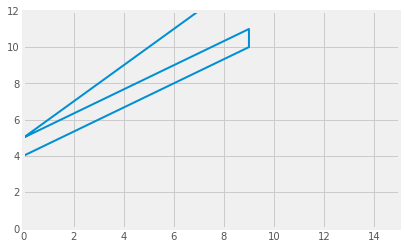

In [118]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
x_limit = [dronec[i][0] for i in range(len(dronec))]
y_limit = [dronec[i][1] for i in range(len(dronec))]
ax.set_xlim((0,max(x_limit)+3))
ax.set_ylim((0,max(y_limit)+3))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)
# animation function. This is called sequentially
def animate(i):
    x = np.array(x_limit)

    y = np.array(y_limit)
    line.set_data(y, x)
    return (line,)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=1, blit=True)
HTML(anim.to_html5_video())

30 2
1 2
4 5


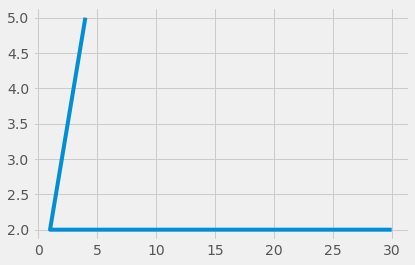

In [95]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style

style.use('fivethirtyeight')

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
z=[[30,2],[1,2],[4,5]]
def animate(i):
    #graph_data = open('example.txt','r').read()
    lines = z#graph_data.split('\n')
    xs = []
    ys = []
    for line in lines:
        if len(line) > 1:
            x, y = line[0],line[1]
            print(x,y)
            xs.append(float(x))
            ys.append(float(y))
    ax1.clear()
    ax1.plot(xs, ys)
ani = animation.FuncAnimation(fig, animate, interval=1000000)
plt.show()

In [21]:
import numpy as np
import matplotlib.pyplot as plt
print(tankc)
x1 = [tankc[i][0] for i in range(len(tankc))]
y1 = [tankc[i][1] for i in range(len(tankc))]

x2 = [tankrc[i][0] for i in range(len(tankrc))]
y2 = [tankrc[i][1] for i in range(len(tankrc))]

x3 = [tankfc[i][0] for i in range(len(tankfc))]
y3 = [tankfc[i][1] for i in range(len(tankfc))]



# plt.scatter(y3,x3,color='black')
# plt.scatter(y2,x2,color='red')
# plt.scatter(y1,x1)
# plt.show

[(13, 2), (6, 0), (13, 4), (6, 0), (13, 6), (13, 8), (6, 1), (13, 10), (13, 12), (12, 15), (10, 12), (6, 3), (6, 3), (6, 4), (6, 4), (6, 4), (10, 1), (6, 4), (6, 4), (6, 6), (11, 1), (12, 1), (6, 7), (6, 7), (6, 7), (13, 4), (6, 7), (13, 6), (6, 8), (13, 14), (6, 9), (6, 9), (11, 16), (6, 9), (6, 10), (10, 11), (9, 12), (11, 1), (13, 0), (13, 2), (13, 4), (6, 12), (13, 6), (6, 12), (13, 8), (13, 2), (12, 5), (6, 14), (13, 6), (13, 8), (6, 14)]


[(13, 4), (13, 3), (13, 5), (13, 6), (13, 7), (13, 9), (13, 11), (13, 11), (13, 14), (10, 11), (10, 5), (10, 3), (10, 4), (13, 9), (12, 9), (13, 11), (6, 10), (13, 13), (13, 15), (13, 16), (11, 16), (11, 15), (10, 16), (10, 13), (10, 13), (10, 14), (10, 11), (11, 1), (13, 1), (13, 4), (13, 3), (13, 5), (13, 6), (13, 7), (13, 8), (13, 9), (13, 11), (13, 11), (13, 14), (13, 15), (6, 15), (10, 8), (10, 7), (10, 6), (10, 5), (10, 3), (10, 4), (10, 2), (11, 1), (13, 6), (13, 7), (13, 8), (13, 11)]


<function matplotlib.pyplot.show(*args, **kw)>

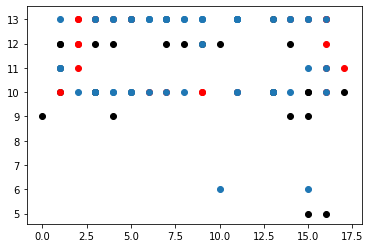

In [20]:
import numpy as np
import matplotlib.pyplot as plt
print(dronec)
x1 = [dronec[i][0] for i in range(len(dronec))]
y1 = [dronec[i][1] for i in range(len(dronec))]

x2 = [dronerc[i][0] for i in range(len(dronerc))]
y2 = [dronerc[i][1] for i in range(len(dronerc))]

x3 = [dronefc[i][0] for i in range(len(dronefc))]
y3 = [dronefc[i][1] for i in range(len(dronefc))]



plt.scatter(y3,x3,color='black')
plt.scatter(y2,x2,color='red')
plt.scatter(y1,x1)
plt.show

In [6]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)   

from PIL import  Image,ImageDraw

img = uframes[20]
z = Image.fromarray(img)
z.show()
data3=[]
data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
y3 = np.array(data3)
x_1 = torch.from_numpy(y3)
temp = model(x_1[0].reshape(1,3,100,100))[0].detach().numpy()
filename = "Marginalization_Simple-increased_channels-32-video-multiple/TD.txt"
file = open(filename, 'w')
file.write(str(model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()))
file.close()

In [14]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)   

from PIL import  Image,ImageDraw

img = Image.open("frame/tank_frame0.jpg")
img =  cv2.resize(np.asarray(img),(100,100))
data3=[]
data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
y3 = np.array(data3)
x_1 = torch.from_numpy(y3)
temp = model(x_1[0].reshape(1,3,100,100))[0].detach().numpy()
filename = "Marginalization_Simple-increased_channels-32-video-multiple/tank.txt"
file = open(filename, 'w')
file.write(str(model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()))
file.close()

100%|██████████| 1000/1000 [00:03<00:00, 296.44it/s]


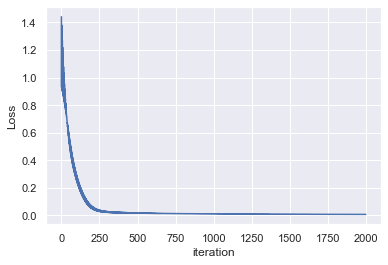

seq 0, prev = tensor([[ 4., 11.]])  -> predicted 5th step = tensor([[ 4.0181, 10.1336]]), actual step = tensor([[ 4., 10.]])
		predicted step 6 (prev = tensor([[[ 4., 10.]]])) = tensor([[3.8167, 8.9214]]), actual step = tensor([[4., 9.]])
		predicted step 7 (prev = tensor([[[4., 9.]]])) = tensor([[3.7085, 7.7733]]), actual step = tensor([[4., 8.]])
		predicted step 8 (prev = tensor([[[4., 8.]]])) = tensor([[3.6956, 6.6876]]), actual step = tensor([[4., 7.]])
		predicted step 9 (prev = tensor([[[4., 7.]]])) = tensor([[3.7559, 5.6683]]), actual step = tensor([[4., 6.]])
		predicted step 10 (prev = tensor([[[4., 6.]]])) = tensor([[3.8623, 4.7333]]), actual step = tensor([[4., 5.]])
		predicted step 11 (prev = tensor([[[4., 5.]]])) = tensor([[3.9918, 3.9030]]), actual step = tensor([[4., 4.]])
		predicted step 12 (prev = tensor([[[4., 4.]]])) = tensor([[4.1273, 3.1905]]), actual step = tensor([[4., 3.]])
		predicted step 13 (prev = tensor([[[4., 3.]]])) = tensor([[4.2568, 2.5978]]), actual

In [53]:
import seaborn as sns
from tqdm import trange
sns.set()

class MyRnn(nn.Module):
  def __init__(self, in_d=2, out_d=2, hidden_d=4, num_hidden=1):
    super(MyRnn, self).__init__()
    self.rnn = nn.RNN(input_size=in_d, hidden_size=hidden_d, num_layers=num_hidden)
    self.fc = nn.Linear(hidden_d, out_d)

  def forward(self, x, h0):
    r, h = self.rnn(x, h0)
    y = self.fc(r)  # no activation on the output
    return y, h

s1 = torch.tensor([[4, 15], [4, 14], [4, 13], [4, 12], [4, 11], [4, 10], [4, 9], [4, 8], [4,7], [4, 6], [4, 5], [4, 4], [4, 3], [4, 2]], dtype=torch.float)[:, None, :] 
s2 = torch.tensor([[4, 15], [5,15],[6,15],[7,15],[8,15],[9,15],[10,15],[11, 15],[12, 15],[12,14],[12,13],[12,12],[12,11],[12,10],[12,9],[12,8],[12,7],[12,6],[12,5]],dtype=torch.float)[:, None, :]

x = torch.cat((s1,s2),dim=0)
mu = x.mean(dim=0)
sig=x.std(dim=0)
sequences = [(s1-mu)/sig, (s2-mu)/sig]  # pythonic list to hold sequences of un-even length

in_d = s1.shape[-1]
out_d = in_d
hidden_d = 8
num_hidden = 1
rnn = MyRnn(in_d, out_d, hidden_d, num_hidden)
loss = []
criterion = nn.MSELoss()
opt = torch.optim.SGD(rnn.parameters(), lr=0.01)
n_epochs = 1000
for e in trange(n_epochs):
  for s in sequences:
    pred, _ = rnn(s[:-1,...], torch.zeros(num_hidden, 1, hidden_d, dtype=torch.float))  # predict next step, init hidden state to zero at the begining of the sequence
    err = criterion(pred, s[1:, ...])  # predict next step for each step
    opt.zero_grad()
    err.backward()
    opt.step()
    loss.append(err.item())
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('iteration')
plt.show()

rnn.eval()
with torch.no_grad():
  k = 5 
  for si, s in enumerate(sequences):
    pred, h = rnn(s[:k,...], torch.zeros(num_hidden, 1, hidden_d, dtype=torch.float))  # given first k steps predict the next one
    print('seq {}, prev = {}  -> predicted {}th step = {}, actual step = {}'.format(si, s[k-1,...]*sig+mu, k, pred[-1, ...]*sig + mu, s[k, ...]*sig+mu))
    prev = (torch.round(pred[-1:, ...]*sig + mu) - mu) / sig  # round the prediction, attmepting to avoid accumulation of error
    # continue to predict 
    for j in  range(k+1, s.shape[0]):
      pred, h = rnn(prev, h)
      print('\t\tpredicted step {} (prev = {}) = {}, actual step = {}'.format(j, prev*sig+mu, pred[-1,...]*sig+mu, s[j, ...]*sig + mu))
      prev = (torch.round(pred*sig + mu) - mu) / sig
  print('\n')